In [1]:
import numpy as np
import time
import pickle
import os
import matplotlib.pyplot as plt
import warnings
import pandas as pd

warnings.filterwarnings('ignore')

In [2]:
print("----------------Reading the Data-------------------------")
PATH = os.getcwd()
os.chdir('Alphabets/')

X_train = pd.read_csv('train.csv', sep=',', header=None, index_col=False)
X_test = pd.read_csv('test.csv', sep=',', header=None, index_col=False)

np.random.shuffle(X_train.to_numpy()) #Randomly shuffle the training data for batching

train_class = X_train[X_train.columns[-1]]
test_actual_class = X_test[X_test.columns[-1]]

X_train = X_train.drop(X_train.columns[-1], axis=1)
X_test = X_test.drop(X_test.columns[-1], axis=1)

print("----------------Data Reading completed-------------------")

os.chdir('../')

print("----------------Preprocessing the data-------------------")
X_train = X_train/255
X_test = X_test/255

m = X_train.shape[0] # Number of Training Samples

#Separating 15% of the training Data as Validation Dataset
X_valid = X_train.iloc[(int(0.85*m)):]
valid_class = train_class[(int(0.85*m)):]
X_train = X_train.iloc[0:int(0.85*m)]
train_class = train_class[0:int(0.85*m)]


m = X_train.shape[0] # Number of Training Samples
n = X_train.shape[1] # Number of input features

print("The total number of training samples = {}".format(m))
print("The total number of validation samples = {}".format(X_valid.shape[0]))
print("The number of features = {}".format(n))

----------------Reading the Data-------------------------
----------------Data Reading completed-------------------
----------------Preprocessing the data-------------------
The total number of training samples = 11050
The total number of validation samples = 1950
The number of features = 784


In [3]:
#To get the one hot encoding of each label
print("--------Perform 1-hot encoding of class labels------------")

train_class_enc = pd.get_dummies(train_class).to_numpy()
valid_class_enc = pd.get_dummies(valid_class).to_numpy()
test_actual_class_enc = pd.get_dummies(test_actual_class).to_numpy()
print("--------------------Done----------------------------------")

--------Perform 1-hot encoding of class labels------------
--------------------Done----------------------------------


In [4]:
#Add the intercept term to the data samples both in training and test dataset
print("--------Adding the intercept term in the dataset as bias------------")
X_train = np.hstack((np.ones((m,1)),X_train.to_numpy()))
X_valid = np.hstack((np.ones((X_valid.shape[0],1)), X_valid.to_numpy()))
X_test = np.hstack((np.ones((X_test.shape[0],1)),X_test.to_numpy()))
print("-----------------------------Done----------------------------------")

--------Adding the intercept term in the dataset as bias------------
-----------------------------Done----------------------------------


In [5]:
#Mini-Batch formation

batch_size = 100 # Mini-Batch Size

print("----------------Forming mini-batches of size {}---------------------".format(batch_size))
mini_batch = [(X_train[i:i+batch_size,:], train_class_enc[i:i+batch_size]) for i in range(0, m, batch_size)]
print("The number of mini-batches formed is = {}".format(len(mini_batch)))

----------------Forming mini-batches of size 100---------------------
The number of mini-batches formed is = 111


In [40]:
#Theta Initialization 

def theta_init(arch=[50], mode='normal'):
    theta = []
    for i in range(len(arch)+1):
        if i == 0:
            dim0=n+1
            dim1=arch[i]
        elif (i == len(arch)):
            dim0=arch[i-1]
            dim1 = r
        else:
            dim0=arch[i-1]
            dim1= arch[i]
        if (mode=='normal'):
            theta.append(np.random.normal(0,0.05, (dim0,dim1)))
        elif(mode=='random'):
            theta.append(2*np.random.random((dim0, dim1))-1)
        #theta.append(np.zeros((dim0, dim1)))
    return theta

In [29]:
# Sigmoid activation function
def activation(x):
    return 1/(1+np.exp(-x))

#ReLU Activation Function
def relu_act(x):
    return np.maximum(0.0, x)

#Derivative of ReLU activation Function
def deriv_relu(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

def softplus(x):
    return np.log(1+np.exp(x))

def deriv_softplus(x):
    return 1/(1+np.exp(-x))

In [8]:
# Forward propagation

def forward_prop(data, theta, act_fn='sigmoid'):
    fm = []
    fm.append(data)
    if (act_fn == 'sigmoid'):
        for l in range(len(theta)):
            fm.append(activation(np.dot(fm[l], theta[l])))
    elif(act_fn == 'relu'):
        for l in range(len(theta)):
            if (l != len(theta)-1):
                fm.append(relu_act(np.dot(fm[l], theta[l])))
            else:
                fm.append(activation(np.dot(fm[l], theta[l])))
    elif(act_fn == 'softplus'):
        for l in range(len(theta)):
            if (l != len(theta)-1):
                fm.append(softplus(np.dot(fm[l], theta[l])))
            else:
                fm.append(activation(np.dot(fm[l], theta[l])))
    return fm

In [9]:
# Backward propagation
def backward_prop(fm, Y_b, theta, batch_size, act_fn='sigmoid', cost_fn='sqr_error'):
    delta = [None]*len(fm)
    for l in range(len(fm)-1, 0, -1):
        if (l == len(fm)-1):
            if (cost_fn=='entropy'):
                delta[l] = ((1/batch_size)*((Y_b/fm[l])-((1-Y_b)/(1-fm[l])))*fm[l]*(1-fm[l]))
            else:
                delta[l] = ((1/batch_size)*(Y_b - fm[l])*fm[l]*(1-fm[l]))
        else:
            if (act_fn == 'sigmoid'):
                delta[l]=(np.dot(delta[l+1], theta[l].T)*fm[l]*(1-fm[l]))
            elif(act_fn == 'relu'):
                delta[l]=np.dot(delta[l+1], theta[l].T)*deriv_relu(fm[l])
            elif(act_fn=='softplus'):
                delta[l]=np.dot(delta[l+1], theta[l].T)*deriv_softplus(fm[l])
    return delta

In [10]:
def cost_total(X, theta, Y, m, act_fn='sigmoid', cost_fn='sqr_error'):
    fm = forward_prop(X, theta, act_fn)
    if (cost_fn == 'sqr_error'):
        cost = (1/(2*m))*np.sum((Y-fm[-1])**2)
    else:
        cost = -(1/m)*(np.sum(((Y*np.log(fm[-1]))+((1-Y)*(np.log(1-fm[-1]))))))
    return cost

In [11]:
def calc_accuracy(data, theta, actual_class, act_fn='sigmoid'):
    pred_class = forward_prop(data, theta, act_fn)
    test_pred_class = pred_class[-1]
    for i in range(len(test_pred_class)):
        test_pred_class[i][test_pred_class[i] == np.max(test_pred_class[i])] = 1
        test_pred_class[i][test_pred_class[i] != np.max(test_pred_class[i])] = 0


    test_acc = 0
    for i in range(len(actual_class)):
        if (np.array_equal(test_pred_class[i], actual_class[i])):
            test_acc+=1
    test_acc /= data.shape[0]

    return (test_acc*100)

## PART AB - One Hidden Layer Neural Network

In [44]:
def training(mini_batch, X_valid, valid_class_enc, theta, lr, act_fn='sigmoid', lr_mode='constant', cost_fn='sqr_error'):
    lr0=lr
    epoch = 1 # Number of epochs
    early_stop=0 #Early stop count of iteration
    
    cost_init = cost_total(X_valid, theta, valid_class_enc, X_valid.shape[0], act_fn, cost_fn)
    
    while(True):
        count_batch = 0
        print("Initial Cost on Val dataset for this epoch {} = {}".format(epoch, cost_init))
        
        if(lr_mode == "adaptive"):
            lr = lr0/(np.power(epoch, 1/4))
            print("learning rate for this epoch = ", lr)
        
        for b in mini_batch:
            X_b = b[0] #100x785
            Y_b = b[1]
            
            #Forward Propagation
            fm = forward_prop(X_b, theta, act_fn) #theta 785x100 fm=100x100
            
            if (count_batch % 60 == 0):
                print("Error on this batch = "+str(cost_total(X_b, theta, Y_b, batch_size, act_fn, cost_fn)))
                    
            #Backward Propagation
            delta = [None]*len(fm)
            delta = backward_prop(fm, Y_b, theta, batch_size, act_fn, cost_fn)

            #Theta Update
            for t in range(len(theta)):
                theta[t] += lr*np.dot(fm[t].T, delta[t+1]) 

            count_batch+=1

        epoch+=1 #Number of epochs
        
        
        cost_final = cost_total(X_valid, theta, valid_class_enc, X_valid.shape[0], act_fn, cost_fn)
        print("Cost on val dataset after {} epochs is = {}".format(epoch, cost_final))
        #Stopping criteria for sigmoid - when Validation loss stops decreasing beyond a threshold for 10 epochs
        if (act_fn =='sigmoid'):
            if (abs(cost_final-cost_init) < 1e-06):
                early_stop +=1
            else:
                early_stop=0
            if (early_stop == 10):
                print("cost initial= {} , cost final={} , change in cost= {}".format(cost_init,cost_final, cost_final-cost_init))
                break
        
        #Stopping criteria for relu - when Validation loss increases continuously for 30 epochs
        elif(act_fn=='relu' or act_fn=='softplus'):
            if ((cost_final-cost_init) > 0):
                early_stop +=1
            else:
                early_stop=0
            if (early_stop == 30):
                print("cost initial= {} , cost final={} , change in cost= {}".format(cost_init,cost_final, cost_final-cost_init))
                break
        
        cost_init = cost_final
    return epoch, theta

In [13]:
def plot_accuracy(arch_test, train_accuracy, test_accuracy, valid_accuracy):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title("Accuracy with number of hidden units \n in one hidden layer network")
    ax.plot(arch_test, train_accuracy, marker='o', label='Train Accuracy')
    ax.plot(arch_test, valid_accuracy, marker='o',label='Validation Accuracy')
    ax.plot(arch_test, test_accuracy, marker='o', label='Test Accuracy')
    ax.set_xlabel("number of hidden units")
    ax.set_ylabel("Accuracy (%)")

    plt.legend()
    #plt.savefig("plots/partd/accuracy_val_normal_adapt_sqrt.png", dpi=1000, bbox_inches='tight')
    plt.show()

In [14]:
def plot_epoch(arch_test, epochs, train_time):
    fig = plt.figure()
    ax = fig.add_subplot(211)
    plt.title("Epochs/Time with number of hidden units \n in one hidden layer network")
    ax.plot(arch_test, epochs, c='b', marker='o', label='#epochs')
    ax.set_xlabel("number of hidden units")
    ax.set_ylabel("Epochs")
    ax.legend()

    ax1 = fig.add_subplot(212)
    ax1.plot(arch_test, train_time, c='b', marker='o', label='train time')
    ax1.set_xlabel("number of hidden units")
    ax1.set_ylabel("train time(sec)")
    plt.legend()
    #plt.savefig("plots/partc/epochs_time_normal_adapt.png", dpi=1000, bbox_inches='tight')
    plt.show()

In [15]:
arch_test = [1,5,10,50,100] # Specifically for part a and b
arch = [50] #means one hidden layer with 50 perceptrons (DEFAULT)
r = np.max(train_class) + 1 # Default value of the number of classes = 26

In [38]:
epochs = []
train_accuracy = []
test_accuracy = []
valid_accuracy = []
train_time = []

lr=0.1

for i in range(len(arch_test)):
    #Choose between normal or random. Normal gives better results
    theta = theta_init([arch_test[i]], 'normal')
    #print(theta[0].shape, theta[1].shape, theta[2].shape)
    print("Training the network with {} hidden layer with {} units".format(len([arch_test[i]]), arch_test[i]))
    print("The parameters of the layers are of the shape:")

    for j in range(len(theta)):
        print("theta between layer {} and layer {} is {}".format(j, j+1,theta[j].shape))

    start = time.time()
    epoch, theta = training(mini_batch, X_valid, valid_class_enc, theta, lr, 'sigmoid')
    
    epochs.append(epoch)
    train_time.append(time.time()-start)
    train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc))
    valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc))
    test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc))
    print("\n------------------------------------------------------------------------------")
    print("The stats for number of units in the hidden layer = {} are as below:".format(arch_test[i]))
    print("------------------------------------------------------------------------------")
    print("The number of epochs = {}".format(epochs[-1]))
    print("The training time = {:2.3f}sec".format(train_time[-1]))
    print("The training accuracy is = {:2.3f}%".format(train_accuracy[-1]))
    print("The validation accuracy is = {:2.3f}%".format(valid_accuracy[-1]))
    print("The test accuracy is = {:2.3f}%".format(test_accuracy[-1]))
    print("------------------------------------------------------------------------------\n")

Training the network with 1 hidden layer with 1 units
The parameters of the layers are of the shape:
theta between layer 0 and layer 1 is (785, 1)
theta between layer 1 and layer 2 is (1, 26)
Initial Cost on Val dataset for this epoch 1 = 3.1357832368389955
Error on this batch = 3.1221638905977045
Error on this batch = 2.1105603708861254
Cost on val dataset after 2 epochs is = 1.4464901315192906
Initial Cost on Val dataset for this epoch 2 = 1.4464901315192906
Error on this batch = 1.4234413674160162
Error on this batch = 1.053969133138891
Cost on val dataset after 3 epochs is = 0.8989110169186323
Initial Cost on Val dataset for this epoch 3 = 0.8989110169186323
Error on this batch = 0.8890437987605267
Error on this batch = 0.7774428850654721
Cost on val dataset after 4 epochs is = 0.7214359876646514
Initial Cost on Val dataset for this epoch 4 = 0.7214359876646514
Error on this batch = 0.7160694724966249
Error on this batch = 0.6674588760670588
Cost on val dataset after 5 epochs is = 

Error on this batch = 0.48366051913121655
Cost on val dataset after 42 epochs is = 0.48370273449878054
Initial Cost on Val dataset for this epoch 42 = 0.48370273449878054
Error on this batch = 0.48355856043959833
Error on this batch = 0.4835045821673856
Cost on val dataset after 43 epochs is = 0.483548096188776
Initial Cost on Val dataset for this epoch 43 = 0.483548096188776
Error on this batch = 0.48340746629988035
Error on this batch = 0.4833592304665123
Cost on val dataset after 44 epochs is = 0.4834038382904175
Initial Cost on Val dataset for this epoch 44 = 0.4834038382904175
Error on this batch = 0.4832665356684784
Error on this batch = 0.4832235751161511
Cost on val dataset after 45 epochs is = 0.483269097883087
Initial Cost on Val dataset for this epoch 45 = 0.483269097883087
Error on this batch = 0.4831349229112222
Error on this batch = 0.48309681771918306
Cost on val dataset after 46 epochs is = 0.483143099053673
Initial Cost on Val dataset for this epoch 46 = 0.483143099053

Error on this batch = 0.48126045267776835
Cost on val dataset after 82 epochs is = 0.481302281576364
Initial Cost on Val dataset for this epoch 82 = 0.481302281576364
Error on this batch = 0.48121798309699365
Error on this batch = 0.4812431807570947
Cost on val dataset after 83 epochs is = 0.4812847181921934
Initial Cost on Val dataset for this epoch 83 = 0.4812847181921934
Error on this batch = 0.4812009405725997
Error on this batch = 0.48122667181617734
Cost on val dataset after 84 epochs is = 0.48126792050086514
Initial Cost on Val dataset for this epoch 84 = 0.48126792050086514
Error on this batch = 0.4811846439550961
Error on this batch = 0.4812108876545535
Cost on val dataset after 85 epochs is = 0.4812518504755364
Initial Cost on Val dataset for this epoch 85 = 0.4812518504755364
Error on this batch = 0.4811690560813681
Error on this batch = 0.4811957922812265
Cost on val dataset after 86 epochs is = 0.4812364722749552
Initial Cost on Val dataset for this epoch 86 = 0.4812364722

Error on this batch = 0.4809224259512076
Cost on val dataset after 122 epochs is = 0.48095522507729344
Initial Cost on Val dataset for this epoch 122 = 0.48095522507729344
Error on this batch = 0.4808820102064225
Error on this batch = 0.48091910915170405
Cost on val dataset after 123 epochs is = 0.4809517484340736
Initial Cost on Val dataset for this epoch 123 = 0.4809517484340736
Error on this batch = 0.48087865627897586
Error on this batch = 0.48091591771791
Cost on val dataset after 124 epochs is = 0.4809483998271423
Initial Cost on Val dataset for this epoch 124 = 0.4809483998271423
Error on this batch = 0.4808754261429637
Error on this batch = 0.4809128466806098
Cost on val dataset after 125 epochs is = 0.48094517424206357
Initial Cost on Val dataset for this epoch 125 = 0.48094517424206357
Error on this batch = 0.4808723149269031
Error on this batch = 0.4809098912859626
Cost on val dataset after 126 epochs is = 0.4809420668801457
Initial Cost on Val dataset for this epoch 126 = 0

Error on this batch = 0.48085294531555667
Cost on val dataset after 162 epochs is = 0.4808810334429453
Initial Cost on Val dataset for this epoch 162 = 0.4808810334429453
Error on this batch = 0.48081046270588645
Error on this batch = 0.4808522165441811
Cost on val dataset after 163 epochs is = 0.4808802215489927
Initial Cost on Val dataset for this epoch 163 = 0.4808802215489927
Error on this batch = 0.4808096783730102
Error on this batch = 0.4808515150442339
Cost on val dataset after 164 epochs is = 0.48087943820665885
Initial Cost on Val dataset for this epoch 164 = 0.48087943820665885
Error on this batch = 0.480808921469969
Error on this batch = 0.4808508398392716
Cost on val dataset after 165 epochs is = 0.48087868241575615
Initial Cost on Val dataset for this epoch 165 = 0.48087868241575615
Error on this batch = 0.4808081910336341
Error on this batch = 0.4808501899890202
Cost on val dataset after 166 epochs is = 0.48087795321272014
Initial Cost on Val dataset for this epoch 166 =

Cost on val dataset after 32 epochs is = 0.48082655456508727
Initial Cost on Val dataset for this epoch 32 = 0.48082655456508727
Error on this batch = 0.4805970485953063
Error on this batch = 0.4793003427755265
Cost on val dataset after 33 epochs is = 0.48077772313785494
Initial Cost on Val dataset for this epoch 33 = 0.48077772313785494
Error on this batch = 0.4805629225178232
Error on this batch = 0.479236076926166
Cost on val dataset after 34 epochs is = 0.48073193504520983
Initial Cost on Val dataset for this epoch 34 = 0.48073193504520983
Error on this batch = 0.4805313905318784
Error on this batch = 0.4791747669628187
Cost on val dataset after 35 epochs is = 0.48068877280939765
Initial Cost on Val dataset for this epoch 35 = 0.48068877280939765
Error on this batch = 0.4805020357466427
Error on this batch = 0.4791160239543196
Cost on val dataset after 36 epochs is = 0.4806478816493788
Initial Cost on Val dataset for this epoch 36 = 0.4806478816493788
Error on this batch = 0.480474

Cost on val dataset after 74 epochs is = 0.47956847711773537
Initial Cost on Val dataset for this epoch 74 = 0.47956847711773537
Error on this batch = 0.47965334395624665
Error on this batch = 0.4774889670164339
Cost on val dataset after 75 epochs is = 0.47954148645838085
Initial Cost on Val dataset for this epoch 75 = 0.47954148645838085
Error on this batch = 0.4796304496436152
Error on this batch = 0.47745060308810117
Cost on val dataset after 76 epochs is = 0.4795143266183751
Initial Cost on Val dataset for this epoch 76 = 0.4795143266183751
Error on this batch = 0.4796075116385901
Error on this batch = 0.4774119014462858
Cost on val dataset after 77 epochs is = 0.47948698375885906
Initial Cost on Val dataset for this epoch 77 = 0.47948698375885906
Error on this batch = 0.4795845421069946
Error on this batch = 0.47737281583581703
Cost on val dataset after 78 epochs is = 0.479459443626232
Initial Cost on Val dataset for this epoch 78 = 0.479459443626232
Error on this batch = 0.479561

Error on this batch = 0.4750955332531798
Cost on val dataset after 113 epochs is = 0.47821799704167506
Initial Cost on Val dataset for this epoch 113 = 0.47821799704167506
Error on this batch = 0.4789559290302789
Error on this batch = 0.4749716873898011
Cost on val dataset after 114 epochs is = 0.47816499037431603
Initial Cost on Val dataset for this epoch 114 = 0.47816499037431603
Error on this batch = 0.47895751264418146
Error on this batch = 0.4748414244761526
Cost on val dataset after 115 epochs is = 0.4781095295493207
Initial Cost on Val dataset for this epoch 115 = 0.4781095295493207
Error on this batch = 0.47896155426516457
Error on this batch = 0.47470420633941557
Cost on val dataset after 116 epochs is = 0.4780513793720896
Initial Cost on Val dataset for this epoch 116 = 0.4780513793720896
Error on this batch = 0.4789682184263593
Error on this batch = 0.4745594295397195
Cost on val dataset after 117 epochs is = 0.47799031375036144
Initial Cost on Val dataset for this epoch 117

Error on this batch = 0.4652931386290864
Cost on val dataset after 155 epochs is = 0.4739085436030655
Initial Cost on Val dataset for this epoch 155 = 0.4739085436030655
Error on this batch = 0.47861530217039316
Error on this batch = 0.4650787263181961
Cost on val dataset after 156 epochs is = 0.4737894328604799
Initial Cost on Val dataset for this epoch 156 = 0.4737894328604799
Error on this batch = 0.47855922524025674
Error on this batch = 0.46486733557046445
Cost on val dataset after 157 epochs is = 0.4736705119721202
Initial Cost on Val dataset for this epoch 157 = 0.4736705119721202
Error on this batch = 0.4785021316355166
Error on this batch = 0.4646589392266431
Cost on val dataset after 158 epochs is = 0.4735518487929605
Initial Cost on Val dataset for this epoch 158 = 0.4735518487929605
Error on this batch = 0.47844401049223534
Error on this batch = 0.46445350985232126
Cost on val dataset after 159 epochs is = 0.4734335123782555
Initial Cost on Val dataset for this epoch 159 = 

Cost on val dataset after 195 epochs is = 0.4697005157996733
Initial Cost on Val dataset for this epoch 195 = 0.4697005157996733
Error on this batch = 0.47554046000185096
Error on this batch = 0.45856864987778423
Cost on val dataset after 196 epochs is = 0.46961113653887476
Initial Cost on Val dataset for this epoch 196 = 0.46961113653887476
Error on this batch = 0.4754397671888066
Error on this batch = 0.4584359581985441
Cost on val dataset after 197 epochs is = 0.4695220692091275
Initial Cost on Val dataset for this epoch 197 = 0.4695220692091275
Error on this batch = 0.47533788376342434
Error on this batch = 0.45830247123486373
Cost on val dataset after 198 epochs is = 0.46943323711894874
Initial Cost on Val dataset for this epoch 198 = 0.46943323711894874
Error on this batch = 0.47523488272279396
Error on this batch = 0.45816781601664724
Cost on val dataset after 199 epochs is = 0.4693445578086039
Initial Cost on Val dataset for this epoch 199 = 0.4693445578086039
Error on this bat

Cost on val dataset after 236 epochs is = 0.4654994782233996
Initial Cost on Val dataset for this epoch 236 = 0.4654994782233996
Error on this batch = 0.4712086523568999
Error on this batch = 0.44971185305212724
Cost on val dataset after 237 epochs is = 0.4653775066181334
Initial Cost on Val dataset for this epoch 237 = 0.4653775066181334
Error on this batch = 0.47109850019992894
Error on this batch = 0.4495065894030977
Cost on val dataset after 238 epochs is = 0.46525595346249304
Initial Cost on Val dataset for this epoch 238 = 0.46525595346249304
Error on this batch = 0.47098881178083846
Error on this batch = 0.4493040616501836
Cost on val dataset after 239 epochs is = 0.46513483256578003
Initial Cost on Val dataset for this epoch 239 = 0.46513483256578003
Error on this batch = 0.47087969986546596
Error on this batch = 0.4491041057716453
Cost on val dataset after 240 epochs is = 0.4650141220818133
Initial Cost on Val dataset for this epoch 240 = 0.4650141220818133
Error on this batch

Error on this batch = 0.44356751143580253
Cost on val dataset after 275 epochs is = 0.4607864598540188
Initial Cost on Val dataset for this epoch 275 = 0.4607864598540188
Error on this batch = 0.46761807119452414
Error on this batch = 0.4434487690105467
Cost on val dataset after 276 epochs is = 0.4606780691136285
Initial Cost on Val dataset for this epoch 276 = 0.4606780691136285
Error on this batch = 0.4675422583952672
Error on this batch = 0.44333191791794935
Cost on val dataset after 277 epochs is = 0.4605709374882579
Initial Cost on Val dataset for this epoch 277 = 0.4605709374882579
Error on this batch = 0.46746704332112987
Error on this batch = 0.4432169139641478
Cost on val dataset after 278 epochs is = 0.4604650427961
Initial Cost on Val dataset for this epoch 278 = 0.4604650427961
Error on this batch = 0.46739241518624625
Error on this batch = 0.4431037110713006
Cost on val dataset after 279 epochs is = 0.46036036363664556
Initial Cost on Val dataset for this epoch 279 = 0.460

Error on this batch = 0.4397230860579991
Cost on val dataset after 317 epochs is = 0.45720740931176407
Initial Cost on Val dataset for this epoch 317 = 0.45720740931176407
Error on this batch = 0.4648264112487339
Error on this batch = 0.43965082385744214
Cost on val dataset after 318 epochs is = 0.45714314186341765
Initial Cost on Val dataset for this epoch 318 = 0.45714314186341765
Error on this batch = 0.4647687176005947
Error on this batch = 0.4395791241006947
Cost on val dataset after 319 epochs is = 0.4570795620517708
Initial Cost on Val dataset for this epoch 319 = 0.4570795620517708
Error on this batch = 0.46471143057824577
Error on this batch = 0.439507963200866
Cost on val dataset after 320 epochs is = 0.457016649087863
Initial Cost on Val dataset for this epoch 320 = 0.457016649087863
Error on this batch = 0.46465455027406455
Error on this batch = 0.4394373169040995
Cost on val dataset after 321 epochs is = 0.45695438291586304
Initial Cost on Val dataset for this epoch 321 = 

Error on this batch = 0.4368002635633866
Cost on val dataset after 359 epochs is = 0.4549331590736104
Initial Cost on Val dataset for this epoch 359 = 0.4549331590736104
Error on this batch = 0.4627828532861439
Error on this batch = 0.4367206900711112
Cost on val dataset after 360 epochs is = 0.45488667651382303
Initial Cost on Val dataset for this epoch 360 = 0.45488667651382303
Error on this batch = 0.46274439627160846
Error on this batch = 0.436639971829657
Cost on val dataset after 361 epochs is = 0.4548404490565228
Initial Cost on Val dataset for this epoch 361 = 0.4548404490565228
Error on this batch = 0.46270640278898056
Error on this batch = 0.436558085506137
Cost on val dataset after 362 epochs is = 0.4547944711067588
Initial Cost on Val dataset for this epoch 362 = 0.4547944711067588
Error on this batch = 0.4626688685929456
Error on this batch = 0.436475015308903
Cost on val dataset after 363 epochs is = 0.45474873715455433
Initial Cost on Val dataset for this epoch 363 = 0.4

Error on this batch = 0.4331178179179069
Cost on val dataset after 401 epochs is = 0.45315648667275754
Initial Cost on Val dataset for this epoch 401 = 0.45315648667275754
Error on this batch = 0.461498676269031
Error on this batch = 0.4330476526402741
Cost on val dataset after 402 epochs is = 0.453118053455344
Initial Cost on Val dataset for this epoch 402 = 0.453118053455344
Error on this batch = 0.4614739105090375
Error on this batch = 0.4329789965677489
Cost on val dataset after 403 epochs is = 0.45307979447206737
Initial Cost on Val dataset for this epoch 403 = 0.45307979447206737
Error on this batch = 0.4614492790446495
Error on this batch = 0.4329118283315579
Cost on val dataset after 404 epochs is = 0.4530417088905119
Initial Cost on Val dataset for this epoch 404 = 0.4530417088905119
Error on this batch = 0.46142477432956097
Error on this batch = 0.43284612342295353
Cost on val dataset after 405 epochs is = 0.4530037956921027
Initial Cost on Val dataset for this epoch 405 = 0.

Error on this batch = 0.4311107879478053
Cost on val dataset after 443 epochs is = 0.4516662334092469
Initial Cost on Val dataset for this epoch 443 = 0.4516662334092469
Error on this batch = 0.46051865606390335
Error on this batch = 0.4310774953352262
Cost on val dataset after 444 epochs is = 0.4516329282106394
Initial Cost on Val dataset for this epoch 444 = 0.4516329282106394
Error on this batch = 0.4604958681231709
Error on this batch = 0.43104454253714425
Cost on val dataset after 445 epochs is = 0.45159967903183734
Initial Cost on Val dataset for this epoch 445 = 0.45159967903183734
Error on this batch = 0.4604730689192236
Error on this batch = 0.4310119151918716
Cost on val dataset after 446 epochs is = 0.45156648331830074
Initial Cost on Val dataset for this epoch 446 = 0.45156648331830074
Error on this batch = 0.46045025597393
Error on this batch = 0.4309795995595965
Cost on val dataset after 447 epochs is = 0.4515333385823965
Initial Cost on Val dataset for this epoch 447 = 0

Error on this batch = 0.42989329391133496
Cost on val dataset after 485 epochs is = 0.45029298761365133
Initial Cost on Val dataset for this epoch 485 = 0.45029298761365133
Error on this batch = 0.4595181930320476
Error on this batch = 0.42986693484693633
Cost on val dataset after 486 epochs is = 0.45026051451722987
Initial Cost on Val dataset for this epoch 486 = 0.45026051451722987
Error on this batch = 0.45949220935739177
Error on this batch = 0.42984064025319607
Cost on val dataset after 487 epochs is = 0.45022804273911
Initial Cost on Val dataset for this epoch 487 = 0.45022804273911
Error on this batch = 0.4594660621742751
Error on this batch = 0.4298144074498864
Cost on val dataset after 488 epochs is = 0.45019557279321537
Initial Cost on Val dataset for this epoch 488 = 0.45019557279321537
Error on this batch = 0.4594397467409241
Error on this batch = 0.4297882338040401
Cost on val dataset after 489 epochs is = 0.4501631053290897
Initial Cost on Val dataset for this epoch 489 =

Error on this batch = 0.4288140014981103
Cost on val dataset after 527 epochs is = 0.44895112496975115
Initial Cost on Val dataset for this epoch 527 = 0.44895112496975115
Error on this batch = 0.458224929106364
Error on this batch = 0.4287879285921065
Cost on val dataset after 528 epochs is = 0.44892064730407966
Initial Cost on Val dataset for this epoch 528 = 0.44892064730407966
Error on this batch = 0.45818740683573456
Error on this batch = 0.42876171786107264
Cost on val dataset after 529 epochs is = 0.4488902969177198
Initial Cost on Val dataset for this epoch 529 = 0.4488902969177198
Error on this batch = 0.4581495124515154
Error on this batch = 0.4287353505718426
Cost on val dataset after 530 epochs is = 0.4488600779394898
Initial Cost on Val dataset for this epoch 530 = 0.4488600779394898
Error on this batch = 0.4581112472165175
Error on this batch = 0.4287088064821319
Cost on val dataset after 531 epochs is = 0.4488299943485191
Initial Cost on Val dataset for this epoch 531 = 

Error on this batch = 0.4272299082031842
Cost on val dataset after 569 epochs is = 0.4477852153204724
Initial Cost on Val dataset for this epoch 569 = 0.4477852153204724
Error on this batch = 0.45644361774259895
Error on this batch = 0.42716750034741224
Cost on val dataset after 570 epochs is = 0.44775899365330396
Initial Cost on Val dataset for this epoch 570 = 0.44775899365330396
Error on this batch = 0.45640041181876484
Error on this batch = 0.4271032942593625
Cost on val dataset after 571 epochs is = 0.44773273338779784
Initial Cost on Val dataset for this epoch 571 = 0.44773273338779784
Error on this batch = 0.45635732075421354
Error on this batch = 0.4270372496441603
Cost on val dataset after 572 epochs is = 0.44770642692920326
Initial Cost on Val dataset for this epoch 572 = 0.44770642692920326
Error on this batch = 0.456314342801837
Error on this batch = 0.4269693276673675
Cost on val dataset after 573 epochs is = 0.44768006668000143
Initial Cost on Val dataset for this epoch 5

Cost on val dataset after 610 epochs is = 0.44659749028127693
Initial Cost on Val dataset for this epoch 610 = 0.44659749028127693
Error on this batch = 0.45471381327856975
Error on this batch = 0.42323699271008985
Cost on val dataset after 611 epochs is = 0.4465650638803114
Initial Cost on Val dataset for this epoch 611 = 0.4465650638803114
Error on this batch = 0.4546724523739244
Error on this batch = 0.42313285674350093
Cost on val dataset after 612 epochs is = 0.4465326034227943
Initial Cost on Val dataset for this epoch 612 = 0.4465326034227943
Error on this batch = 0.4546311984539309
Error on this batch = 0.4230296701765755
Cost on val dataset after 613 epochs is = 0.4465001246174115
Initial Cost on Val dataset for this epoch 613 = 0.4465001246174115
Error on this batch = 0.4545900537507619
Error on this batch = 0.42292744621711265
Cost on val dataset after 614 epochs is = 0.4464676424254426
Initial Cost on Val dataset for this epoch 614 = 0.4464676424254426
Error on this batch =

Error on this batch = 0.4198370857711102
Cost on val dataset after 649 epochs is = 0.4453867801925664
Initial Cost on Val dataset for this epoch 649 = 0.4453867801925664
Error on this batch = 0.4531463880122843
Error on this batch = 0.41975875436035687
Cost on val dataset after 650 epochs is = 0.44535800575159523
Initial Cost on Val dataset for this epoch 650 = 0.44535800575159523
Error on this batch = 0.4531058031821955
Error on this batch = 0.41968083463431444
Cost on val dataset after 651 epochs is = 0.44532934188493806
Initial Cost on Val dataset for this epoch 651 = 0.44532934188493806
Error on this batch = 0.4530651103886623
Error on this batch = 0.41960332214323914
Cost on val dataset after 652 epochs is = 0.44530078688790076
Initial Cost on Val dataset for this epoch 652 = 0.44530078688790076
Error on this batch = 0.4530243041938282
Error on this batch = 0.41952621294889897
Cost on val dataset after 653 epochs is = 0.44527233902009183
Initial Cost on Val dataset for this epoch 

Error on this batch = 0.41688001547826625
Cost on val dataset after 691 epochs is = 0.44425063905273376
Initial Cost on Val dataset for this epoch 691 = 0.44425063905273376
Error on this batch = 0.45130039824055035
Error on this batch = 0.4168175062189004
Cost on val dataset after 692 epochs is = 0.44422467501750434
Initial Cost on Val dataset for this epoch 692 = 0.44422467501750434
Error on this batch = 0.4512520461432405
Error on this batch = 0.41675532484565786
Cost on val dataset after 693 epochs is = 0.44419871587271803
Initial Cost on Val dataset for this epoch 693 = 0.44419871587271803
Error on this batch = 0.4512034694202485
Error on this batch = 0.4166934657959351
Cost on val dataset after 694 epochs is = 0.4441727572307009
Initial Cost on Val dataset for this epoch 694 = 0.4441727572307009
Error on this batch = 0.45115466840082336
Error on this batch = 0.4166319231282748
Cost on val dataset after 695 epochs is = 0.44414679451944045
Initial Cost on Val dataset for this epoch 

Cost on val dataset after 732 epochs is = 0.44311331509559143
Initial Cost on Val dataset for this epoch 732 = 0.44311331509559143
Error on this batch = 0.4491393678565115
Error on this batch = 0.41439693998465293
Cost on val dataset after 733 epochs is = 0.4430803488625189
Initial Cost on Val dataset for this epoch 733 = 0.4430803488625189
Error on this batch = 0.4490816453918965
Error on this batch = 0.41433365097225394
Cost on val dataset after 734 epochs is = 0.44304687122554215
Initial Cost on Val dataset for this epoch 734 = 0.44304687122554215
Error on this batch = 0.44902357655952074
Error on this batch = 0.4142693976762273
Cost on val dataset after 735 epochs is = 0.4430128559291935
Initial Cost on Val dataset for this epoch 735 = 0.4430128559291935
Error on this batch = 0.448965142380148
Error on this batch = 0.41420407883422383
Cost on val dataset after 736 epochs is = 0.4429782763228498
Initial Cost on Val dataset for this epoch 736 = 0.4429782763228498
Error on this batch 

Cost on val dataset after 771 epochs is = 0.4412906610023175
Initial Cost on Val dataset for this epoch 771 = 0.4412906610023175
Error on this batch = 0.44643044217805894
Error on this batch = 0.4105941280997146
Cost on val dataset after 772 epochs is = 0.44122765911214124
Initial Cost on Val dataset for this epoch 772 = 0.44122765911214124
Error on this batch = 0.44634431659265017
Error on this batch = 0.4104654201339526
Cost on val dataset after 773 epochs is = 0.44116367853785865
Initial Cost on Val dataset for this epoch 773 = 0.44116367853785865
Error on this batch = 0.446257106583551
Error on this batch = 0.41033551509059607
Cost on val dataset after 774 epochs is = 0.44109868679159464
Initial Cost on Val dataset for this epoch 774 = 0.44109868679159464
Error on this batch = 0.44616877081322737
Error on this batch = 0.41020433637950815
Cost on val dataset after 775 epochs is = 0.4410326510188829
Initial Cost on Val dataset for this epoch 775 = 0.4410326510188829
Error on this bat

Error on this batch = 0.40484583220550796
Cost on val dataset after 810 epochs is = 0.43796809563348427
Initial Cost on Val dataset for this epoch 810 = 0.43796809563348427
Error on this batch = 0.4421157463781312
Error on this batch = 0.40470720660269877
Cost on val dataset after 811 epochs is = 0.4378667055812791
Initial Cost on Val dataset for this epoch 811 = 0.4378667055812791
Error on this batch = 0.44198785978339544
Error on this batch = 0.4045706169609126
Cost on val dataset after 812 epochs is = 0.4377653575458124
Initial Cost on Val dataset for this epoch 812 = 0.4377653575458124
Error on this batch = 0.44185993095567183
Error on this batch = 0.40443587384354396
Cost on val dataset after 813 epochs is = 0.43766409402642176
Initial Cost on Val dataset for this epoch 813 = 0.43766409402642176
Error on this batch = 0.4417319972851803
Error on this batch = 0.40430279948050457
Cost on val dataset after 814 epochs is = 0.4375629549278068
Initial Cost on Val dataset for this epoch 8

Error on this batch = 0.3997816289777583
Cost on val dataset after 852 epochs is = 0.43399788129583183
Initial Cost on Val dataset for this epoch 852 = 0.43399788129583183
Error on this batch = 0.4369415162658204
Error on this batch = 0.39967037330509364
Cost on val dataset after 853 epochs is = 0.43391196774612634
Initial Cost on Val dataset for this epoch 853 = 0.43391196774612634
Error on this batch = 0.43682560386924296
Error on this batch = 0.3995594044376737
Cost on val dataset after 854 epochs is = 0.4338264029346406
Initial Cost on Val dataset for this epoch 854 = 0.4338264029346406
Error on this batch = 0.43671004906669764
Error on this batch = 0.3994487266922015
Cost on val dataset after 855 epochs is = 0.43374118485114205
Initial Cost on Val dataset for this epoch 855 = 0.43374118485114205
Error on this batch = 0.43659485264117115
Error on this batch = 0.3993383461096566
Cost on val dataset after 856 epochs is = 0.4336563122092233
Initial Cost on Val dataset for this epoch 8

Error on this batch = 0.39549065837036496
Cost on val dataset after 894 epochs is = 0.4307263705781319
Initial Cost on Val dataset for this epoch 894 = 0.4307263705781319
Error on this batch = 0.43239696364838753
Error on this batch = 0.39540069882418394
Cost on val dataset after 895 epochs is = 0.43065850101095615
Initial Cost on Val dataset for this epoch 895 = 0.43065850101095615
Error on this batch = 0.4322973841015721
Error on this batch = 0.3953112727228709
Cost on val dataset after 896 epochs is = 0.43059115806760645
Initial Cost on Val dataset for this epoch 896 = 0.43059115806760645
Error on this batch = 0.4321983277359959
Error on this batch = 0.3952223647388128
Cost on val dataset after 897 epochs is = 0.43052434120906363
Initial Cost on Val dataset for this epoch 897 = 0.43052434120906363
Error on this batch = 0.43209981748094695
Error on this batch = 0.3951339595112445
Cost on val dataset after 898 epochs is = 0.430458049281851
Initial Cost on Val dataset for this epoch 89

Cost on val dataset after 935 epochs is = 0.4283287202171541
Initial Cost on Val dataset for this epoch 935 = 0.4283287202171541
Error on this batch = 0.42891918176477767
Error on this batch = 0.39211474860736145
Cost on val dataset after 936 epochs is = 0.42827847248330636
Initial Cost on Val dataset for this epoch 936 = 0.42827847248330636
Error on this batch = 0.4288506655924308
Error on this batch = 0.39204673301868953
Cost on val dataset after 937 epochs is = 0.4282285509976628
Initial Cost on Val dataset for this epoch 937 = 0.4282285509976628
Error on this batch = 0.42878279873110453
Error on this batch = 0.391979487134216
Cost on val dataset after 938 epochs is = 0.4281789529062303
Initial Cost on Val dataset for this epoch 938 = 0.4281789529062303
Error on this batch = 0.4287155691687074
Error on this batch = 0.39191301662325734
Cost on val dataset after 939 epochs is = 0.4281296753485855
Initial Cost on Val dataset for this epoch 939 = 0.4281296753485855
Error on this batch =

Error on this batch = 0.39003569342583094
Cost on val dataset after 974 epochs is = 0.42658165636876666
Initial Cost on Val dataset for this epoch 974 = 0.42658165636876666
Error on this batch = 0.4266516818225647
Error on this batch = 0.3899925819232378
Cost on val dataset after 975 epochs is = 0.42654180799943336
Initial Cost on Val dataset for this epoch 975 = 0.42654180799943336
Error on this batch = 0.4266029272173864
Error on this batch = 0.3899499149181226
Cost on val dataset after 976 epochs is = 0.42650217826582376
Initial Cost on Val dataset for this epoch 976 = 0.42650217826582376
Error on this batch = 0.4265545760247413
Error on this batch = 0.3899076825903957
Cost on val dataset after 977 epochs is = 0.4264627665061272
Initial Cost on Val dataset for this epoch 977 = 0.4264627665061272
Error on this batch = 0.4265066233243091
Error on this batch = 0.3898658753823051
Cost on val dataset after 978 epochs is = 0.4264235721762034
Initial Cost on Val dataset for this epoch 978 

Error on this batch = 0.3885207646494241
Cost on val dataset after 1016 epochs is = 0.42509508949148966
Initial Cost on Val dataset for this epoch 1016 = 0.42509508949148966
Error on this batch = 0.4248907688888221
Error on this batch = 0.3884903842885462
Cost on val dataset after 1017 epochs is = 0.42506435977979756
Initial Cost on Val dataset for this epoch 1017 = 0.42506435977979756
Error on this batch = 0.42485444226108293
Error on this batch = 0.3884602092133731
Cost on val dataset after 1018 epochs is = 0.42503384279838413
Initial Cost on Val dataset for this epoch 1018 = 0.42503384279838413
Error on this batch = 0.42481830840786494
Error on this batch = 0.38843023661089987
Cost on val dataset after 1019 epochs is = 0.42500353780821265
Initial Cost on Val dataset for this epoch 1019 = 0.42500353780821265
Error on this batch = 0.4247823636886884
Error on this batch = 0.38840046374371456
Cost on val dataset after 1020 epochs is = 0.42497344402993126
Initial Cost on Val dataset for 

Error on this batch = 0.38739551508823383
Cost on val dataset after 1058 epochs is = 0.4239755608205056
Initial Cost on Val dataset for this epoch 1058 = 0.4239755608205056
Error on this batch = 0.42349963606378693
Error on this batch = 0.3873719282102696
Cost on val dataset after 1059 epochs is = 0.4239527928019409
Initial Cost on Val dataset for this epoch 1059 = 0.4239527928019409
Error on this batch = 0.42346929708554065
Error on this batch = 0.3873484675778485
Cost on val dataset after 1060 epochs is = 0.42393018466941373
Initial Cost on Val dataset for this epoch 1060 = 0.42393018466941373
Error on this batch = 0.42343906948687593
Error on this batch = 0.38732513186228146
Cost on val dataset after 1061 epochs is = 0.4239077349396187
Initial Cost on Val dataset for this epoch 1061 = 0.4239077349396187
Error on this batch = 0.423408952565988
Error on this batch = 0.387301919750592
Cost on val dataset after 1062 epochs is = 0.423885442131684
Initial Cost on Val dataset for this epoc

Error on this batch = 0.38651925880984805
Cost on val dataset after 1099 epochs is = 0.4231579658433441
Initial Cost on Val dataset for this epoch 1099 = 0.4231579658433441
Error on this batch = 0.42234166899217956
Error on this batch = 0.3864999065706668
Cost on val dataset after 1100 epochs is = 0.42314060713404955
Initial Cost on Val dataset for this epoch 1100 = 0.42314060713404955
Error on this batch = 0.42231551452991667
Error on this batch = 0.38648063691590506
Cost on val dataset after 1101 epochs is = 0.4231233536625996
Initial Cost on Val dataset for this epoch 1101 = 0.4231233536625996
Error on this batch = 0.42228945458634715
Error on this batch = 0.3864614489975138
Cost on val dataset after 1102 epochs is = 0.42310620430853385
Initial Cost on Val dataset for this epoch 1102 = 0.42310620430853385
Error on this batch = 0.42226348880695236
Error on this batch = 0.38644234197468796
Cost on val dataset after 1103 epochs is = 0.4230891579621563
Initial Cost on Val dataset for th

Error on this batch = 0.3857851341720589
Cost on val dataset after 1140 epochs is = 0.4225216792468906
Initial Cost on Val dataset for this epoch 1140 = 0.4225216792468906
Error on this batch = 0.42134273261397065
Error on this batch = 0.3857685379767827
Cost on val dataset after 1141 epochs is = 0.422507828502601
Initial Cost on Val dataset for this epoch 1141 = 0.422507828502601
Error on this batch = 0.4213201321253836
Error on this batch = 0.38575199447792335
Cost on val dataset after 1142 epochs is = 0.42249404559207787
Initial Cost on Val dataset for this epoch 1142 = 0.42249404559207787
Error on this batch = 0.4212976098720326
Error on this batch = 0.3857355030644691
Cost on val dataset after 1143 epochs is = 0.4224803298124195
Initial Cost on Val dataset for this epoch 1143 = 0.4224803298124195
Error on this batch = 0.42127516547999205
Error on this batch = 0.38571906313154525
Cost on val dataset after 1144 epochs is = 0.4224666804699784
Initial Cost on Val dataset for this epoc

Cost on val dataset after 1178 epochs is = 0.42203774015732404
Initial Cost on Val dataset for this epoch 1178 = 0.42203774015732404
Error on this batch = 0.4205361789612518
Error on this batch = 0.38517188959830057
Cost on val dataset after 1179 epochs is = 0.4220260432108335
Initial Cost on Val dataset for this epoch 1179 = 0.4220260432108335
Error on this batch = 0.4205163376373987
Error on this batch = 0.3851569570429366
Cost on val dataset after 1180 epochs is = 0.4220143929614111
Initial Cost on Val dataset for this epoch 1180 = 0.4220143929614111
Error on this batch = 0.4204965645138475
Error on this batch = 0.3851420584138341
Cost on val dataset after 1181 epochs is = 0.4220027889758306
Initial Cost on Val dataset for this epoch 1181 = 0.4220027889758306
Error on this batch = 0.42047685944052166
Error on this batch = 0.38512719337123463
Cost on val dataset after 1182 epochs is = 0.42199123082541135
Initial Cost on Val dataset for this epoch 1182 = 0.42199123082541135
Error on t

Error on this batch = 0.3846258790102246
Cost on val dataset after 1217 epochs is = 0.4216125148549223
Initial Cost on Val dataset for this epoch 1217 = 0.4216125148549223
Error on this batch = 0.4198117958120557
Error on this batch = 0.38461204565676854
Cost on val dataset after 1218 epochs is = 0.4216023511136346
Initial Cost on Val dataset for this epoch 1218 = 0.4216023511136346
Error on this batch = 0.419794529205939
Error on this batch = 0.3845982371501919
Cost on val dataset after 1219 epochs is = 0.42159221964516014
Initial Cost on Val dataset for this epoch 1219 = 0.42159221964516014
Error on this batch = 0.41977732665541256
Error on this batch = 0.38458445333247193
Cost on val dataset after 1220 epochs is = 0.42158212012718543
Initial Cost on Val dataset for this epoch 1220 = 0.42158212012718543
Error on this batch = 0.41976018806129434
Error on this batch = 0.3845706940485353
Cost on val dataset after 1221 epochs is = 0.4215720522390815
Initial Cost on Val dataset for this e

Cost on val dataset after 1258 epochs is = 0.4212189812743087
Initial Cost on Val dataset for this epoch 1258 = 0.4212189812743087
Error on this batch = 0.4191552148132491
Error on this batch = 0.38406474961467163
Cost on val dataset after 1259 epochs is = 0.4212098919497582
Initial Cost on Val dataset for this epoch 1259 = 0.4212098919497582
Error on this batch = 0.4191404810033224
Error on this batch = 0.3840518531974236
Cost on val dataset after 1260 epochs is = 0.42120082281953675
Initial Cost on Val dataset for this epoch 1260 = 0.42120082281953675
Error on this batch = 0.4191258063187294
Error on this batch = 0.38403897715692664
Cost on val dataset after 1261 epochs is = 0.42119177361231497
Initial Cost on Val dataset for this epoch 1261 = 0.42119177361231497
Error on this batch = 0.41911119062834845
Error on this batch = 0.384026121441497
Cost on val dataset after 1262 epochs is = 0.4211827440575226
Initial Cost on Val dataset for this epoch 1262 = 0.4211827440575226
Error on th

Error on this batch = 0.3835888715320219
Cost on val dataset after 1297 epochs is = 0.4208770162160982
Initial Cost on Val dataset for this epoch 1297 = 0.4208770162160982
Error on this batch = 0.418623306381572
Error on this batch = 0.38357675007150155
Cost on val dataset after 1298 epochs is = 0.42086851610153386
Initial Cost on Val dataset for this epoch 1298 = 0.42086851610153386
Error on this batch = 0.4186107940263586
Error on this batch = 0.3835646506038737
Cost on val dataset after 1299 epochs is = 0.42086002565560976
Initial Cost on Val dataset for this epoch 1299 = 0.42086002565560976
Error on this batch = 0.4185983369938554
Error on this batch = 0.3835525733391559
Cost on val dataset after 1300 epochs is = 0.4208515445922641
Initial Cost on Val dataset for this epoch 1300 = 0.4208515445922641
Error on this batch = 0.4185859352525669
Error on this batch = 0.3835405185017885
Cost on val dataset after 1301 epochs is = 0.420843072623862
Initial Cost on Val dataset for this epoch

Cost on val dataset after 1338 epochs is = 0.4205334095404049
Initial Cost on Val dataset for this epoch 1338 = 0.4205334095404049
Error on this batch = 0.41815571582222893
Error on this batch = 0.38310280225325843
Cost on val dataset after 1339 epochs is = 0.4205250877421272
Initial Cost on Val dataset for this epoch 1339 = 0.4205250877421272
Error on this batch = 0.4181454720683965
Error on this batch = 0.3830919156862177
Cost on val dataset after 1340 epochs is = 0.42051676791516446
Initial Cost on Val dataset for this epoch 1340 = 0.42051676791516446
Error on this batch = 0.4181352815467397
Error on this batch = 0.38308105952057586
Cost on val dataset after 1341 epochs is = 0.42050845043775137
Initial Cost on Val dataset for this epoch 1341 = 0.42050845043775137
Error on this batch = 0.41812514377153515
Error on this batch = 0.3830702321651826
Cost on val dataset after 1342 epochs is = 0.42050013576975
Initial Cost on Val dataset for this epoch 1342 = 0.42050013576975
Error on this

Error on this batch = 0.38269372719569617
Cost on val dataset after 1377 epochs is = 0.4202191126488729
Initial Cost on Val dataset for this epoch 1377 = 0.4202191126488729
Error on this batch = 0.4177895467778953
Error on this batch = 0.38268284740114
Cost on val dataset after 1378 epochs is = 0.42021157126568115
Initial Cost on Val dataset for this epoch 1378 = 0.42021157126568115
Error on this batch = 0.417780887441238
Error on this batch = 0.38267196666768855
Cost on val dataset after 1379 epochs is = 0.42020405898055657
Initial Cost on Val dataset for this epoch 1379 = 0.42020405898055657
Error on this batch = 0.41777225711568206
Error on this batch = 0.382661085972208
Cost on val dataset after 1380 epochs is = 0.42019657524245174
Initial Cost on Val dataset for this epoch 1380 = 0.42019657524245174
Error on this batch = 0.4177636553956542
Error on this batch = 0.3826502062553499
Cost on val dataset after 1381 epochs is = 0.42018911947952764
Initial Cost on Val dataset for this ep

Cost on val dataset after 1415 epochs is = 0.4199485862114886
Initial Cost on Val dataset for this epoch 1415 = 0.4199485862114886
Error on this batch = 0.41747850530593306
Error on this batch = 0.3822742423755061
Cost on val dataset after 1416 epochs is = 0.41994181442548767
Initial Cost on Val dataset for this epoch 1416 = 0.41994181442548767
Error on this batch = 0.41747077333933813
Error on this batch = 0.38226368573052216
Cost on val dataset after 1417 epochs is = 0.4199350571841645
Initial Cost on Val dataset for this epoch 1417 = 0.4199350571841645
Error on this batch = 0.4174630628990957
Error on this batch = 0.3822531391961763
Cost on val dataset after 1418 epochs is = 0.41992831437300027
Initial Cost on Val dataset for this epoch 1418 = 0.41992831437300027
Error on this batch = 0.4174553738798422
Error on this batch = 0.3822426026222314
Cost on val dataset after 1419 epochs is = 0.4199215858860951
Initial Cost on Val dataset for this epoch 1419 = 0.4199215858860951
Error on t

Error on this batch = 0.38187864654595083
Cost on val dataset after 1454 epochs is = 0.41969472407572156
Initial Cost on Val dataset for this epoch 1454 = 0.41969472407572156
Error on this batch = 0.41719188699598847
Error on this batch = 0.3818683418212153
Cost on val dataset after 1455 epochs is = 0.41968848570409906
Initial Cost on Val dataset for this epoch 1455 = 0.41968848570409906
Error on this batch = 0.41718490943684056
Error on this batch = 0.38185803997688283
Cost on val dataset after 1456 epochs is = 0.41968226089475713
Initial Cost on Val dataset for this epoch 1456 = 0.41968226089475713
Error on this batch = 0.4171779487025266
Error on this batch = 0.3818477408424048
Cost on val dataset after 1457 epochs is = 0.4196760496552853
Initial Cost on Val dataset for this epoch 1457 = 0.4196760496552853
Error on this batch = 0.41717100465817936
Error on this batch = 0.38183744425006694
Cost on val dataset after 1458 epochs is = 0.4196698519924962
Initial Cost on Val dataset for t

Cost on val dataset after 1492 epochs is = 0.4194671506218107
Initial Cost on Val dataset for this epoch 1492 = 0.4194671506218107
Error on this batch = 0.4169374110962079
Error on this batch = 0.3814775820990181
Cost on val dataset after 1493 epochs is = 0.419461418480696
Initial Cost on Val dataset for this epoch 1493 = 0.419461418480696
Error on this batch = 0.41693097607658614
Error on this batch = 0.3814672902430279
Cost on val dataset after 1494 epochs is = 0.41945569880164063
Initial Cost on Val dataset for this epoch 1494 = 0.41945569880164063
Error on this batch = 0.41692455260932193
Error on this batch = 0.3814569967398558
Cost on val dataset after 1495 epochs is = 0.4194499915012858
Initial Cost on Val dataset for this epoch 1495 = 0.4194499915012858
Error on this batch = 0.4169181405534944
Error on this batch = 0.3814467015204157
Cost on val dataset after 1496 epochs is = 0.41944429649314297
Initial Cost on Val dataset for this epoch 1496 = 0.41944429649314297
Error on this

Error on this batch = 0.38108480573657233
Cost on val dataset after 1531 epochs is = 0.4192518364092637
Initial Cost on Val dataset for this epoch 1531 = 0.4192518364092637
Error on this batch = 0.41669374657377484
Error on this batch = 0.3810744076991192
Cost on val dataset after 1532 epochs is = 0.4192465038433529
Initial Cost on Val dataset for this epoch 1532 = 0.4192465038433529
Error on this batch = 0.41668766196455664
Error on this batch = 0.3810640056420489
Cost on val dataset after 1533 epochs is = 0.41924117868289584
Initial Cost on Val dataset for this epoch 1533 = 0.41924117868289584
Error on this batch = 0.4166815839236185
Error on this batch = 0.38105359949594236
Cost on val dataset after 1534 epochs is = 0.4192358607738618
Initial Cost on Val dataset for this epoch 1534 = 0.4192358607738618
Error on this batch = 0.4166755123565173
Error on this batch = 0.3810431891907872
Cost on val dataset after 1535 epochs is = 0.4192305499626477
Initial Cost on Val dataset for this ep

Cost on val dataset after 1569 epochs is = 0.4190531793734117
Initial Cost on Val dataset for this epoch 1569 = 0.4190531793734117
Error on this batch = 0.41646660046101647
Error on this batch = 0.38067561894240876
Cost on val dataset after 1570 epochs is = 0.41904802897420296
Initial Cost on Val dataset for this epoch 1570 = 0.41904802897420296
Error on this batch = 0.41646072822288377
Error on this batch = 0.3806650059676771
Cost on val dataset after 1571 epochs is = 0.41904288091847797
Initial Cost on Val dataset for this epoch 1571 = 0.41904288091847797
Error on this batch = 0.4164548614887885
Error on this batch = 0.3806543854669144
Cost on val dataset after 1572 epochs is = 0.41903773509345
Initial Cost on Val dataset for this epoch 1572 = 0.41903773509345
Error on this batch = 0.4164490003089602
Error on this batch = 0.3806437572852629
Cost on val dataset after 1573 epochs is = 0.41903259138715065
Initial Cost on Val dataset for this epoch 1573 = 0.41903259138715065
Error on thi

Error on this batch = 0.3802652206048501
Cost on val dataset after 1608 epochs is = 0.4188532702136046
Initial Cost on Val dataset for this epoch 1608 = 0.4188532702136046
Error on this batch = 0.4162424943250003
Error on this batch = 0.3802541639989048
Cost on val dataset after 1609 epochs is = 0.4188481635737794
Initial Cost on Val dataset for this epoch 1609 = 0.4188481635737794
Error on this batch = 0.41623691414381214
Error on this batch = 0.380243091604586
Cost on val dataset after 1610 epochs is = 0.41884305877958455
Initial Cost on Val dataset for this epoch 1610 = 0.41884305877958455
Error on this batch = 0.4162313443170966
Error on this batch = 0.38023200335619495
Cost on val dataset after 1611 epochs is = 0.4188379559832315
Initial Cost on Val dataset for this epoch 1611 = 0.4188379559832315
Error on this batch = 0.4162257849763455
Error on this batch = 0.38022089920573593
Cost on val dataset after 1612 epochs is = 0.41883285533868553
Initial Cost on Val dataset for this epo

Error on this batch = 0.379787839414105
Cost on val dataset after 1650 epochs is = 0.41864147376120314
Initial Cost on Val dataset for this epoch 1650 = 0.41864147376120314
Error on this batch = 0.41601761569666973
Error on this batch = 0.3797761811319188
Cost on val dataset after 1651 epochs is = 0.4186364974280337
Initial Cost on Val dataset for this epoch 1651 = 0.4186364974280337
Error on this batch = 0.41601249203221335
Error on this batch = 0.3797645109009028
Cost on val dataset after 1652 epochs is = 0.4186315227129557
Initial Cost on Val dataset for this epoch 1652 = 0.4186315227129557
Error on this batch = 0.4160073781875142
Error on this batch = 0.3797528288002633
Cost on val dataset after 1653 epochs is = 0.4186265494444982
Initial Cost on Val dataset for this epoch 1653 = 0.4186265494444982
Error on this batch = 0.41600227409847806
Error on this batch = 0.37974113490536826
Cost on val dataset after 1654 epochs is = 0.41862157744837797
Initial Cost on Val dataset for this ep

Error on this batch = 0.37928845803971184
Cost on val dataset after 1692 epochs is = 0.41843172023112896
Initial Cost on Val dataset for this epoch 1692 = 0.41843172023112896
Error on this batch = 0.4158104568536139
Error on this batch = 0.3792763316910447
Cost on val dataset after 1693 epochs is = 0.4184266485430319
Initial Cost on Val dataset for this epoch 1693 = 0.4184266485430319
Error on this batch = 0.41580572225861107
Error on this batch = 0.37926419434636954
Cost on val dataset after 1694 epochs is = 0.41842157025280463
Initial Cost on Val dataset for this epoch 1694 = 0.41842157025280463
Error on this batch = 0.4158009970541095
Error on this batch = 0.37925204598185064
Cost on val dataset after 1695 epochs is = 0.41841648514347746
Initial Cost on Val dataset for this epoch 1695 = 0.41841648514347746
Error on this batch = 0.4157962812692436
Error on this batch = 0.3792398865710897
Cost on val dataset after 1696 epochs is = 0.41841139299628705
Initial Cost on Val dataset for th

Cost on val dataset after 1730 epochs is = 0.41823235435759754
Initial Cost on Val dataset for this epoch 1730 = 0.41823235435759754
Error on this batch = 0.41563741691930217
Error on this batch = 0.3788068956861288
Cost on val dataset after 1731 epochs is = 0.4182268588745425
Initial Cost on Val dataset for this epoch 1731 = 0.4182268588745425
Error on this batch = 0.4156330620557529
Error on this batch = 0.3787942914600136
Cost on val dataset after 1732 epochs is = 0.4182213467370667
Initial Cost on Val dataset for this epoch 1732 = 0.4182213467370667
Error on this batch = 0.4156287177902348
Error on this batch = 0.378781672610982
Cost on val dataset after 1733 epochs is = 0.41821581762259646
Initial Cost on Val dataset for this epoch 1733 = 0.41821581762259646
Error on this batch = 0.41562438414528813
Error on this batch = 0.37876903896707353
Cost on val dataset after 1734 epochs is = 0.41821027120564774
Initial Cost on Val dataset for this epoch 1734 = 0.41821027120564774
Error on 

Error on this batch = 0.378316156465029
Cost on val dataset after 1769 epochs is = 0.4180024825438783
Initial Cost on Val dataset for this epoch 1769 = 0.4180024825438783
Error on this batch = 0.4154753625543552
Error on this batch = 0.3783028714497772
Cost on val dataset after 1770 epochs is = 0.41799606554883995
Initial Cost on Val dataset for this epoch 1770 = 0.41799606554883995
Error on this batch = 0.4154713993206388
Error on this batch = 0.37828956441854283
Cost on val dataset after 1771 epochs is = 0.41798961559573555
Initial Cost on Val dataset for this epoch 1771 = 0.41798961559573555
Error on this batch = 0.4154674430949386
Error on this batch = 0.3782762349123617
Cost on val dataset after 1772 epochs is = 0.41798313194060016
Initial Cost on Val dataset for this epoch 1772 = 0.41798313194060016
Error on this batch = 0.41546349347085854
Error on this batch = 0.3782628824025136
Cost on val dataset after 1773 epochs is = 0.41797661378860246
Initial Cost on Val dataset for this 

Cost on val dataset after 1807 epochs is = 0.417725843051312
Initial Cost on Val dataset for this epoch 1807 = 0.417725843051312
Error on this batch = 0.41532547690552335
Error on this batch = 0.37776750418033916
Cost on val dataset after 1808 epochs is = 0.4177174417949272
Initial Cost on Val dataset for this epoch 1808 = 0.4177174417949272
Error on this batch = 0.41532153835478874
Error on this batch = 0.37775206055682364
Cost on val dataset after 1809 epochs is = 0.41770898814782814
Initial Cost on Val dataset for this epoch 1809 = 0.41770898814782814
Error on this batch = 0.41531761129511197
Error on this batch = 0.37773653646033417
Cost on val dataset after 1810 epochs is = 0.4177004836220493
Initial Cost on Val dataset for this epoch 1810 = 0.4177004836220493
Error on this batch = 0.41531369693082015
Error on this batch = 0.37772093376997734
Cost on val dataset after 1811 epochs is = 0.4176919296526961
Initial Cost on Val dataset for this epoch 1811 = 0.4176919296526961
Error on 

Error on this batch = 0.3771410558821214
Cost on val dataset after 1846 epochs is = 0.4173660578841412
Initial Cost on Val dataset for this epoch 1846 = 0.4173660578841412
Error on this batch = 0.41518513764313475
Error on this batch = 0.3771239459696276
Cost on val dataset after 1847 epochs is = 0.4173560138479969
Initial Cost on Val dataset for this epoch 1847 = 0.4173560138479969
Error on this batch = 0.4151820025186329
Error on this batch = 0.3771068287777735
Cost on val dataset after 1848 epochs is = 0.41734592703161155
Initial Cost on Val dataset for this epoch 1848 = 0.41734592703161155
Error on this batch = 0.41517890222184667
Error on this batch = 0.3770897061535233
Cost on val dataset after 1849 epochs is = 0.41733579692774947
Initial Cost on Val dataset for this epoch 1849 = 0.41733579692774947
Error on this batch = 0.4151758386002879
Error on this batch = 0.3770725799515697
Cost on val dataset after 1850 epochs is = 0.4173256229467288
Initial Cost on Val dataset for this ep

Cost on val dataset after 1884 epochs is = 0.416932712286231
Initial Cost on Val dataset for this epoch 1884 = 0.416932712286231
Error on this batch = 0.41513119949683247
Error on this batch = 0.37649504048735455
Cost on val dataset after 1885 epochs is = 0.41691803390889554
Initial Cost on Val dataset for this epoch 1885 = 0.41691803390889554
Error on this batch = 0.4151344496459588
Error on this batch = 0.3764806046963476
Cost on val dataset after 1886 epochs is = 0.4169029441390061
Initial Cost on Val dataset for this epoch 1886 = 0.4169029441390061
Error on this batch = 0.41513829753776493
Error on this batch = 0.37646644990049916
Cost on val dataset after 1887 epochs is = 0.41688740142271785
Initial Cost on Val dataset for this epoch 1887 = 0.41688740142271785
Error on this batch = 0.4151428048787132
Error on this batch = 0.3764526042469744
Cost on val dataset after 1888 epochs is = 0.4168713594975043
Initial Cost on Val dataset for this epoch 1888 = 0.4168713594975043
Error on th

Error on this batch = 0.3765118484187525
Cost on val dataset after 1926 epochs is = 0.41527772148145337
Initial Cost on Val dataset for this epoch 1926 = 0.41527772148145337
Error on this batch = 0.41645809304047077
Error on this batch = 0.37651321528013343
Cost on val dataset after 1927 epochs is = 0.4152195971274822
Initial Cost on Val dataset for this epoch 1927 = 0.4152195971274822
Error on this batch = 0.4164840489567203
Error on this batch = 0.3765136121946979
Cost on val dataset after 1928 epochs is = 0.4151619519144883
Initial Cost on Val dataset for this epoch 1928 = 0.4151619519144883
Error on this batch = 0.41650828990808164
Error on this batch = 0.3765130985277802
Cost on val dataset after 1929 epochs is = 0.41510481386845743
Initial Cost on Val dataset for this epoch 1929 = 0.41510481386845743
Error on this batch = 0.41653104236753324
Error on this batch = 0.3765117386882889
Cost on val dataset after 1930 epochs is = 0.41504819445957236
Initial Cost on Val dataset for this

Error on this batch = 0.37609652617128597
Cost on val dataset after 1968 epochs is = 0.41318610229633157
Initial Cost on Val dataset for this epoch 1968 = 0.41318610229633157
Error on this batch = 0.4171012661333782
Error on this batch = 0.37607844027055154
Cost on val dataset after 1969 epochs is = 0.41314751227652297
Initial Cost on Val dataset for this epoch 1969 = 0.41314751227652297
Error on this batch = 0.4171099992686573
Error on this batch = 0.37606020731717066
Cost on val dataset after 1970 epochs is = 0.4131095208545334
Initial Cost on Val dataset for this epoch 1970 = 0.4131095208545334
Error on this batch = 0.41711853580033187
Error on this batch = 0.3760418450914431
Cost on val dataset after 1971 epochs is = 0.4130721156327416
Initial Cost on Val dataset for this epoch 1971 = 0.4130721156327416
Error on this batch = 0.41712688733793657
Error on this batch = 0.3760233705019808
Cost on val dataset after 1972 epochs is = 0.4130352837535825
Initial Cost on Val dataset for this

Error on this batch = 0.37534267583714426
Cost on val dataset after 2010 epochs is = 0.41194664096945877
Initial Cost on Val dataset for this epoch 2010 = 0.41194664096945877
Error on this batch = 0.4173844841802178
Error on this batch = 0.37532644165475193
Cost on val dataset after 2011 epochs is = 0.41192442152646513
Initial Cost on Val dataset for this epoch 2011 = 0.41192442152646513
Error on this batch = 0.41738961552626064
Error on this batch = 0.3753102787728393
Cost on val dataset after 2012 epochs is = 0.41190249906175036
Initial Cost on Val dataset for this epoch 2012 = 0.41190249906175036
Error on this batch = 0.417394567181178
Error on this batch = 0.3752941849525937
Cost on val dataset after 2013 epochs is = 0.4118808706301031
Initial Cost on Val dataset for this epoch 2013 = 0.4118808706301031
Error on this batch = 0.41739932738347646
Error on this batch = 0.37527815830255423
Cost on val dataset after 2014 epochs is = 0.4118595327357652
Initial Cost on Val dataset for thi

Cost on val dataset after 2050 epochs is = 0.41123537078448325
Initial Cost on Val dataset for this epoch 2050 = 0.41123537078448325
Error on this batch = 0.4173969831429469
Error on this batch = 0.3747333334326538
Cost on val dataset after 2051 epochs is = 0.41122074878062914
Initial Cost on Val dataset for this epoch 2051 = 0.41122074878062914
Error on this batch = 0.4173926191469636
Error on this batch = 0.37472014254919556
Cost on val dataset after 2052 epochs is = 0.41120622552342295
Initial Cost on Val dataset for this epoch 2052 = 0.41120622552342295
Error on this batch = 0.4173881202863465
Error on this batch = 0.3747070444943152
Cost on val dataset after 2053 epochs is = 0.41119179892834784
Initial Cost on Val dataset for this epoch 2053 = 0.41119179892834784
Error on this batch = 0.41738349505487554
Error on this batch = 0.3746940394836382
Cost on val dataset after 2054 epochs is = 0.4111774670239976
Initial Cost on Val dataset for this epoch 2054 = 0.4111774670239976
Error o

Cost on val dataset after 2091 epochs is = 0.410701574102175
Initial Cost on Val dataset for this epoch 2091 = 0.410701574102175
Error on this batch = 0.41717250647863835
Error on this batch = 0.37426294726077275
Cost on val dataset after 2092 epochs is = 0.4106899384900189
Initial Cost on Val dataset for this epoch 2092 = 0.4106899384900189
Error on this batch = 0.41716693819060396
Error on this batch = 0.37425300344263546
Cost on val dataset after 2093 epochs is = 0.41067835711339606
Initial Cost on Val dataset for this epoch 2093 = 0.41067835711339606
Error on this batch = 0.41716139156936294
Error on this batch = 0.37424311700838453
Cost on val dataset after 2094 epochs is = 0.41066682930206994
Initial Cost on Val dataset for this epoch 2094 = 0.41066682930206994
Error on this batch = 0.4171558671167766
Error on this batch = 0.37423328698340685
Cost on val dataset after 2095 epochs is = 0.41065535439536416
Initial Cost on Val dataset for this epoch 2095 = 0.41065535439536416
Error 

Error on this batch = 0.3738935559742444
Cost on val dataset after 2133 epochs is = 0.4102528573318728
Initial Cost on Val dataset for this epoch 2133 = 0.4102528573318728
Error on this batch = 0.4169581044356307
Error on this batch = 0.37388533085565784
Cost on val dataset after 2134 epochs is = 0.4102430196893548
Initial Cost on Val dataset for this epoch 2134 = 0.4102430196893548
Error on this batch = 0.4169534206621694
Error on this batch = 0.3738771349036651
Cost on val dataset after 2135 epochs is = 0.4102332150212101
Initial Cost on Val dataset for this epoch 2135 = 0.4102332150212101
Error on this batch = 0.4169487507577982
Error on this batch = 0.3738689676393975
Cost on val dataset after 2136 epochs is = 0.4102234429516659
Initial Cost on Val dataset for this epoch 2136 = 0.4102234429516659
Error on this batch = 0.4169440942487461
Error on this batch = 0.3738608285906057
Cost on val dataset after 2137 epochs is = 0.41021370310881056
Initial Cost on Val dataset for this epoch 

Error on this batch = 0.3735684334188209
Cost on val dataset after 2175 epochs is = 0.4098640957218445
Initial Cost on Val dataset for this epoch 2175 = 0.4098640957218445
Error on this batch = 0.41676828223888585
Error on this batch = 0.3735610950683133
Cost on val dataset after 2176 epochs is = 0.40985535276494367
Initial Cost on Val dataset for this epoch 2176 = 0.40985535276494367
Error on this batch = 0.4167638264113028
Error on this batch = 0.3735537714170207
Cost on val dataset after 2177 epochs is = 0.4098466293134013
Initial Cost on Val dataset for this epoch 2177 = 0.4098466293134013
Error on this batch = 0.4167593700616904
Error on this batch = 0.3735464622707035
Cost on val dataset after 2178 epochs is = 0.4098379250918579
Initial Cost on Val dataset for this epoch 2178 = 0.4098379250918579
Error on this batch = 0.4167549131098511
Error on this batch = 0.3735391674420807
Cost on val dataset after 2179 epochs is = 0.40982923982701486
Initial Cost on Val dataset for this epoc

Error on this batch = 0.3732781170430611
Cost on val dataset after 2216 epochs is = 0.4095189317951107
Initial Cost on Val dataset for this epoch 2216 = 0.4095189317951107
Error on this batch = 0.41658553131534193
Error on this batch = 0.37327127685768086
Cost on val dataset after 2217 epochs is = 0.40951078924642736
Initial Cost on Val dataset for this epoch 2217 = 0.40951078924642736
Error on this batch = 0.4165811035784401
Error on this batch = 0.37326444682199994
Cost on val dataset after 2218 epochs is = 0.40950265717107637
Initial Cost on Val dataset for this epoch 2218 = 0.40950265717107637
Error on this batch = 0.41657667893407524
Error on this batch = 0.37325762682093877
Cost on val dataset after 2219 epochs is = 0.40949453543543596
Initial Cost on Val dataset for this epoch 2219 = 0.40949453543543596
Error on this batch = 0.4165722574138397
Error on this batch = 0.37325081673348315
Cost on val dataset after 2220 epochs is = 0.4094864239123687
Initial Cost on Val dataset for t

Cost on val dataset after 2254 epochs is = 0.40921634095952764
Initial Cost on Val dataset for this epoch 2254 = 0.40921634095952764
Error on this batch = 0.41641788064262775
Error on this batch = 0.3730171296670075
Cost on val dataset after 2255 epochs is = 0.4092085727701622
Initial Cost on Val dataset for this epoch 2255 = 0.4092085727701622
Error on this batch = 0.4164133750562379
Error on this batch = 0.3730105199066274
Cost on val dataset after 2256 epochs is = 0.40920081612396686
Initial Cost on Val dataset for this epoch 2256 = 0.40920081612396686
Error on this batch = 0.4164088553482537
Error on this batch = 0.373003909080075
Cost on val dataset after 2257 epochs is = 0.40919307122957227
Initial Cost on Val dataset for this epoch 2257 = 0.40919307122957227
Error on this batch = 0.4164043206643293
Error on this batch = 0.37299729673773824
Cost on val dataset after 2258 epochs is = 0.40918533830195153
Initial Cost on Val dataset for this epoch 2258 = 0.40918533830195153
Error on

Error on this batch = 0.372761741188044
Cost on val dataset after 2293 epochs is = 0.4089240207279227
Initial Cost on Val dataset for this epoch 2293 = 0.4089240207279227
Error on this batch = 0.41622577364902746
Error on this batch = 0.3727548222037022
Cost on val dataset after 2294 epochs is = 0.4089168670052795
Initial Cost on Val dataset for this epoch 2294 = 0.4089168670052795
Error on this batch = 0.41622032237103157
Error on this batch = 0.37274789019250193
Cost on val dataset after 2295 epochs is = 0.40890973249900814
Initial Cost on Val dataset for this epoch 2295 = 0.40890973249900814
Error on this batch = 0.41621484555633176
Error on this batch = 0.3727409450707365
Cost on val dataset after 2296 epochs is = 0.4089026172868707
Initial Cost on Val dataset for this epoch 2296 = 0.4089026172868707
Error on this batch = 0.41620934358334943
Error on this batch = 0.3727339867670099
Cost on val dataset after 2297 epochs is = 0.40889552143868185
Initial Cost on Val dataset for this e

Cost on val dataset after 2331 epochs is = 0.40866583907095816
Initial Cost on Val dataset for this epoch 2331 = 0.40866583907095816
Error on this batch = 0.4160045180217087
Error on this batch = 0.3724824054860558
Cost on val dataset after 2332 epochs is = 0.4086594155477136
Initial Cost on Val dataset for this epoch 2332 = 0.4086594155477136
Error on this batch = 0.41599842182027214
Error on this batch = 0.3724750157166815
Cost on val dataset after 2333 epochs is = 0.40865301006849486
Initial Cost on Val dataset for this epoch 2333 = 0.40865301006849486
Error on this batch = 0.41599231765673267
Error on this batch = 0.3724676172349855
Cost on val dataset after 2334 epochs is = 0.408646622534167
Initial Cost on Val dataset for this epoch 2334 = 0.408646622534167
Error on this batch = 0.41598620594058333
Error on this batch = 0.37246021030012744
Cost on val dataset after 2335 epochs is = 0.40864025284439487
Initial Cost on Val dataset for this epoch 2335 = 0.40864025284439487
Error on 

Error on this batch = 0.3721977694967457
Cost on val dataset after 2370 epochs is = 0.40842775797262176
Initial Cost on Val dataset for this epoch 2370 = 0.40842775797262176
Error on this batch = 0.41576414128541517
Error on this batch = 0.37219023931645967
Cost on val dataset after 2371 epochs is = 0.4084219633935569
Initial Cost on Val dataset for this epoch 2371 = 0.4084219633935569
Error on this batch = 0.4157579855161987
Error on this batch = 0.37218271039411366
Cost on val dataset after 2372 epochs is = 0.40841618310852595
Initial Cost on Val dataset for this epoch 2372 = 0.40841618310852595
Error on this batch = 0.41575183342740774
Error on this batch = 0.37217518294045776
Cost on val dataset after 2373 epochs is = 0.4084104170440619
Initial Cost on Val dataset for this epoch 2373 = 0.4084104170440619
Error on this batch = 0.41574568519412836
Error on this batch = 0.3721676571617553
Cost on val dataset after 2374 epochs is = 0.40840466512836915
Initial Cost on Val dataset for th

Cost on val dataset after 2408 epochs is = 0.40821711162474666
Initial Cost on Val dataset for this epoch 2408 = 0.40821711162474666
Error on this batch = 0.41553384910683233
Error on this batch = 0.37190657592771686
Cost on val dataset after 2409 epochs is = 0.40821182179181786
Initial Cost on Val dataset for this epoch 2409 = 0.40821182179181786
Error on this batch = 0.4155279075038307
Error on this batch = 0.3718992097331321
Cost on val dataset after 2410 epochs is = 0.40820654450518706
Initial Cost on Val dataset for this epoch 2410 = 0.40820654450518706
Error on this batch = 0.4155219723547664
Error on this batch = 0.3718918497519047
Cost on val dataset after 2411 epochs is = 0.40820127974034226
Initial Cost on Val dataset for this epoch 2411 = 0.40820127974034226
Error on this batch = 0.4155160436473365
Error on this batch = 0.3718844960348525
Cost on val dataset after 2412 epochs is = 0.4081960274733559
Initial Cost on Val dataset for this epoch 2412 = 0.4081960274733559
Error o

Error on this batch = 0.3716312809568678
Cost on val dataset after 2447 epochs is = 0.40801990826506207
Initial Cost on Val dataset for this epoch 2447 = 0.40801990826506207
Error on this batch = 0.41530660842273875
Error on this batch = 0.3716241675215764
Cost on val dataset after 2448 epochs is = 0.4080150920540208
Initial Cost on Val dataset for this epoch 2448 = 0.4080150920540208
Error on this batch = 0.4153008900661442
Error on this batch = 0.37161706078259044
Cost on val dataset after 2449 epochs is = 0.4080102875660438
Initial Cost on Val dataset for this epoch 2449 = 0.4080102875660438
Error on this batch = 0.4152951763135379
Error on this batch = 0.3716099607264788
Cost on val dataset after 2450 epochs is = 0.4080054947775391
Initial Cost on Val dataset for this epoch 2450 = 0.4080054947775391
Error on this batch = 0.4152894670994471
Error on this batch = 0.37160286733906106
Cost on val dataset after 2451 epochs is = 0.4080007136646148
Initial Cost on Val dataset for this epo

Cost on val dataset after 2488 epochs is = 0.4078317750069316
Initial Cost on Val dataset for this epoch 2488 = 0.4078317750069316
Error on this batch = 0.4150752514177145
Error on this batch = 0.3713380664674494
Cost on val dataset after 2489 epochs is = 0.4078274169976211
Initial Cost on Val dataset for this epoch 2489 = 0.4078274169976211
Error on this batch = 0.4150696709295809
Error on this batch = 0.3713312169182862
Cost on val dataset after 2490 epochs is = 0.4078230695153077
Initial Cost on Val dataset for this epoch 2490 = 0.4078230695153077
Error on this batch = 0.4150640926840363
Error on this batch = 0.3713243731252737
Cost on val dataset after 2491 epochs is = 0.40781873252603845
Initial Cost on Val dataset for this epoch 2491 = 0.40781873252603845
Error on this batch = 0.4150585166420935
Error on this batch = 0.3713175350615515
Cost on val dataset after 2492 epochs is = 0.4078144059956846
Initial Cost on Val dataset for this epoch 2492 = 0.4078144059956846
Error on this b

Error on this batch = 0.3710816029278027
Cost on val dataset after 2527 epochs is = 0.4076692881499542
Initial Cost on Val dataset for this epoch 2527 = 0.4076692881499542
Error on this batch = 0.4148590403430785
Error on this batch = 0.37107495323595374
Cost on val dataset after 2528 epochs is = 0.40766531385347266
Initial Cost on Val dataset for this epoch 2528 = 0.40766531385347266
Error on this batch = 0.4148535323530891
Error on this batch = 0.3710683082902906
Cost on val dataset after 2529 epochs is = 0.40766134861476705
Initial Cost on Val dataset for this epoch 2529 = 0.40766134861476705
Error on this batch = 0.41484802625200573
Error on this batch = 0.37106166806545965
Cost on val dataset after 2530 epochs is = 0.40765739239096055
Initial Cost on Val dataset for this epoch 2530 = 0.40765739239096055
Error on this batch = 0.41484252206546307
Error on this batch = 0.37105503253619476
Cost on val dataset after 2531 epochs is = 0.4076534451388043
Initial Cost on Val dataset for th

Cost on val dataset after 2565 epochs is = 0.4075242373076519
Initial Cost on Val dataset for this epoch 2565 = 0.4075242373076519
Error on this batch = 0.41465141417871265
Error on this batch = 0.3708255558776804
Cost on val dataset after 2566 epochs is = 0.4075205730360123
Initial Cost on Val dataset for this epoch 2566 = 0.4075205730360123
Error on this batch = 0.41464601119585437
Error on this batch = 0.370819073045068
Cost on val dataset after 2567 epochs is = 0.4075169158294147
Initial Cost on Val dataset for this epoch 2567 = 0.4075169158294147
Error on this batch = 0.4146406123399383
Error on this batch = 0.370812593999043
Cost on val dataset after 2568 epochs is = 0.4075132656224457
Initial Cost on Val dataset for this epoch 2568 = 0.4075132656224457
Error on this batch = 0.41463521770468204
Error on this batch = 0.37080611871375097
Cost on val dataset after 2569 epochs is = 0.40750962234889665
Initial Cost on Val dataset for this epoch 2569 = 0.40750962234889665
Error on this

Error on this batch = 0.3705689079314109
Cost on val dataset after 2606 epochs is = 0.4073790166345132
Initial Cost on Val dataset for this epoch 2606 = 0.4073790166345132
Error on this batch = 0.41443446223058034
Error on this batch = 0.3705625524803536
Cost on val dataset after 2607 epochs is = 0.4073755798903619
Initial Cost on Val dataset for this epoch 2607 = 0.4073755798903619
Error on this batch = 0.41442932516438136
Error on this batch = 0.3705561994235466
Cost on val dataset after 2608 epochs is = 0.40737214689363743
Initial Cost on Val dataset for this epoch 2608 = 0.40737214689363743
Error on this batch = 0.41442419761389815
Error on this batch = 0.37054984871192587
Cost on val dataset after 2609 epochs is = 0.4073687175500678
Initial Cost on Val dataset for this epoch 2609 = 0.4073687175500678
Error on this batch = 0.41441907975153847
Error on this batch = 0.37054350029552835
Cost on val dataset after 2610 epochs is = 0.40736529176502523
Initial Cost on Val dataset for this

Cost on val dataset after 2644 epochs is = 0.4072502489099744
Initial Cost on Val dataset for this epoch 2644 = 0.4072502489099744
Error on this batch = 0.4142475252854544
Error on this batch = 0.37032229533155686
Cost on val dataset after 2645 epochs is = 0.40724688762185857
Initial Cost on Val dataset for this epoch 2645 = 0.40724688762185857
Error on this batch = 0.41424288491416533
Error on this batch = 0.3703159885252094
Cost on val dataset after 2646 epochs is = 0.4072435265180583
Initial Cost on Val dataset for this epoch 2646 = 0.4072435265180583
Error on this batch = 0.4142382616577932
Error on this batch = 0.37030968153209026
Cost on val dataset after 2647 epochs is = 0.40724016551341885
Initial Cost on Val dataset for this epoch 2647 = 0.40724016551341885
Error on this batch = 0.4142336557310685
Error on this batch = 0.37030337427006244
Cost on val dataset after 2648 epochs is = 0.407236804523632
Initial Cost on Val dataset for this epoch 2648 = 0.407236804523632
Error on th

Error on this batch = 0.37008177788491353
Cost on val dataset after 2683 epochs is = 0.40711859774630466
Initial Cost on Val dataset for this epoch 2683 = 0.40711859774630466
Error on this batch = 0.4140811072431702
Error on this batch = 0.37007540256448856
Cost on val dataset after 2684 epochs is = 0.4071151897555152
Initial Cost on Val dataset for this epoch 2684 = 0.4071151897555152
Error on this batch = 0.4140772816667615
Error on this batch = 0.3700690236660823
Cost on val dataset after 2685 epochs is = 0.4071117793998981
Initial Cost on Val dataset for this epoch 2685 = 0.4071117793998981
Error on this batch = 0.41407348035183633
Error on this batch = 0.370062641096389
Cost on val dataset after 2686 epochs is = 0.40710836663646977
Initial Cost on Val dataset for this epoch 2686 = 0.40710836663646977
Error on this batch = 0.41406970342033456
Error on this batch = 0.37005625476200665
Cost on val dataset after 2687 epochs is = 0.4071049514233081
Initial Cost on Val dataset for this 

Cost on val dataset after 2721 epochs is = 0.4069871389735567
Initial Cost on Val dataset for this epoch 2721 = 0.4069871389735567
Error on this batch = 0.4139534497255968
Error on this batch = 0.3698296277540897
Cost on val dataset after 2722 epochs is = 0.40698361857925863
Initial Cost on Val dataset for this epoch 2722 = 0.40698361857925863
Error on this batch = 0.4139505882679636
Error on this batch = 0.3698230427220641
Cost on val dataset after 2723 epochs is = 0.40698009478053015
Initial Cost on Val dataset for this epoch 2723 = 0.40698009478053015
Error on this batch = 0.41394775191050664
Error on this batch = 0.36981645037756794
Cost on val dataset after 2724 epochs is = 0.40697656756128336
Initial Cost on Val dataset for this epoch 2724 = 0.40697656756128336
Error on this batch = 0.41394494055286246
Error on this batch = 0.3698098506207229
Cost on val dataset after 2725 epochs is = 0.40697303690570963
Initial Cost on Val dataset for this epoch 2725 = 0.40697303690570963
Error 

Error on this batch = 0.36957338767524384
Cost on val dataset after 2760 epochs is = 0.406847184521278
Initial Cost on Val dataset for this epoch 2760 = 0.406847184521278
Error on this batch = 0.4138589184877215
Error on this batch = 0.3695664515678142
Cost on val dataset after 2761 epochs is = 0.4068435202396118
Initial Cost on Val dataset for this epoch 2761 = 0.4068435202396118
Error on this batch = 0.41385689218370064
Error on this batch = 0.3695595040976862
Cost on val dataset after 2762 epochs is = 0.4068398519417855
Initial Cost on Val dataset for this epoch 2762 = 0.4068398519417855
Error on this batch = 0.4138548813277838
Error on this batch = 0.3695525451509296
Cost on val dataset after 2763 epochs is = 0.4068361796074574
Initial Cost on Val dataset for this epoch 2763 = 0.4068361796074574
Error on this batch = 0.41385288550749577
Error on this batch = 0.3695455746132694
Cost on val dataset after 2764 epochs is = 0.4068325032158038
Initial Cost on Val dataset for this epoch 2

Cost on val dataset after 2801 epochs is = 0.40669337741396117
Initial Cost on Val dataset for this epoch 2801 = 0.40669337741396117
Error on this batch = 0.4137832779785511
Error on this batch = 0.36927094658542897
Cost on val dataset after 2802 epochs is = 0.4066895249451186
Initial Cost on Val dataset for this epoch 2802 = 0.4066895249451186
Error on this batch = 0.41378146074135985
Error on this batch = 0.36926343188286903
Cost on val dataset after 2803 epochs is = 0.40668566705157194
Initial Cost on Val dataset for this epoch 2803 = 0.40668566705157194
Error on this batch = 0.4137796356623514
Error on this batch = 0.3692559008062327
Cost on val dataset after 2804 epochs is = 0.40668180367941775
Initial Cost on Val dataset for this epoch 2804 = 0.40668180367941775
Error on this batch = 0.4137778020410581
Error on this batch = 0.3692483532322337
Cost on val dataset after 2805 epochs is = 0.40667793477357234
Initial Cost on Val dataset for this epoch 2805 = 0.40667793477357234
Error 

Error on this batch = 0.3689728270557026
Cost on val dataset after 2840 epochs is = 0.4065385099164516
Initial Cost on Val dataset for this epoch 2840 = 0.4065385099164516
Error on this batch = 0.41370001518553495
Error on this batch = 0.3689646023061488
Cost on val dataset after 2841 epochs is = 0.40653439343392583
Initial Cost on Val dataset for this epoch 2841 = 0.40653439343392583
Error on this batch = 0.41369735831135074
Error on this batch = 0.3689563563932164
Cost on val dataset after 2842 epochs is = 0.4065302683524674
Initial Cost on Val dataset for this epoch 2842 = 0.4065302683524674
Error on this batch = 0.4136946657808765
Error on this batch = 0.3689480891868024
Cost on val dataset after 2843 epochs is = 0.4065261345552587
Initial Cost on Val dataset for this epoch 2843 = 0.4065261345552587
Error on this batch = 0.4136919369436396
Error on this batch = 0.36893980055647874
Cost on val dataset after 2844 epochs is = 0.4065219919233181
Initial Cost on Val dataset for this epo

Error on this batch = 0.36860761596499797
Cost on val dataset after 2882 epochs is = 0.40635660517652344
Initial Cost on Val dataset for this epoch 2882 = 0.40635660517652344
Error on this batch = 0.4135512894785154
Error on this batch = 0.36859838362843683
Cost on val dataset after 2883 epochs is = 0.40635199888774204
Initial Cost on Val dataset for this epoch 2883 = 0.40635199888774204
Error on this batch = 0.41354668546048273
Error on this batch = 0.3685891240173347
Cost on val dataset after 2884 epochs is = 0.4063473769250913
Initial Cost on Val dataset for this epoch 2884 = 0.4063473769250913
Error on this batch = 0.41354202724894307
Error on this batch = 0.3685798369510825
Cost on val dataset after 2885 epochs is = 0.40634273906227897
Initial Cost on Val dataset for this epoch 2885 = 0.40634273906227897
Error on this batch = 0.4135373146539761
Error on this batch = 0.3685705222457918
Cost on val dataset after 2886 epochs is = 0.4063380850705284
Initial Cost on Val dataset for thi

Error on this batch = 0.3681937466886436
Cost on val dataset after 2924 epochs is = 0.4061468293861722
Initial Cost on Val dataset for this epoch 2924 = 0.4061468293861722
Error on this batch = 0.41331007384391877
Error on this batch = 0.36818315032050747
Cost on val dataset after 2925 epochs is = 0.40614134940366925
Initial Cost on Val dataset for this epoch 2925 = 0.40614134940366925
Error on this batch = 0.41330312349311443
Error on this batch = 0.36817251358428343
Cost on val dataset after 2926 epochs is = 0.40613584291907184
Initial Cost on Val dataset for this epoch 2926 = 0.40613584291907184
Error on this batch = 0.413296116852933
Error on this batch = 0.3681618359541261
Cost on val dataset after 2927 epochs is = 0.4061303096580274
Initial Cost on Val dataset for this epoch 2927 = 0.4061303096580274
Error on this batch = 0.4132890539091361
Error on this batch = 0.3681511168908385
Cost on val dataset after 2928 epochs is = 0.4061247493452596
Initial Cost on Val dataset for this e

Error on this batch = 0.3677319011336638
Cost on val dataset after 2964 epochs is = 0.40590402185425606
Initial Cost on Val dataset for this epoch 2964 = 0.40590402185425606
Error on this batch = 0.412987553924312
Error on this batch = 0.36771913602695044
Cost on val dataset after 2965 epochs is = 0.4058972372971059
Initial Cost on Val dataset for this epoch 2965 = 0.4058972372971059
Error on this batch = 0.41297828742057024
Error on this batch = 0.3677062978326383
Cost on val dataset after 2966 epochs is = 0.4058904119640727
Initial Cost on Val dataset for this epoch 2966 = 0.4058904119640727
Error on this batch = 0.4129689593427072
Error on this batch = 0.3676933853871987
Cost on val dataset after 2967 epochs is = 0.4058835453062623
Initial Cost on Val dataset for this epoch 2967 = 0.4058835453062623
Error on this batch = 0.41295956938199957
Error on this batch = 0.3676803975071543
Cost on val dataset after 2968 epochs is = 0.40587663675838254
Initial Cost on Val dataset for this epo

Cost on val dataset after 3005 epochs is = 0.40558438207832254
Initial Cost on Val dataset for this epoch 3005 = 0.40558438207832254
Error on this batch = 0.4125522356399031
Error on this batch = 0.3671167792129863
Cost on val dataset after 3006 epochs is = 0.40557522761151527
Initial Cost on Val dataset for this epoch 3006 = 0.40557522761151527
Error on this batch = 0.41254000698388493
Error on this batch = 0.36709964736501194
Cost on val dataset after 3007 epochs is = 0.40556598833691593
Initial Cost on Val dataset for this epoch 3007 = 0.40556598833691593
Error on this batch = 0.41252768776677373
Error on this batch = 0.36708236890003376
Cost on val dataset after 3008 epochs is = 0.4055566623615209
Initial Cost on Val dataset for this epoch 3008 = 0.4055566623615209
Error on this batch = 0.4125152766160779
Error on this batch = 0.3670649411746485
Cost on val dataset after 3009 epochs is = 0.4055472477372726
Initial Cost on Val dataset for this epoch 3009 = 0.4055472477372726
Error o

Error on this batch = 0.3663359822882081
Cost on val dataset after 3044 epochs is = 0.40514208785178907
Initial Cost on Val dataset for this epoch 3044 = 0.40514208785178907
Error on this batch = 0.41199070727375947
Error on this batch = 0.36631092562590584
Cost on val dataset after 3045 epochs is = 0.4051276435011068
Initial Cost on Val dataset for this epoch 3045 = 0.4051276435011068
Error on this batch = 0.4119733397457837
Error on this batch = 0.36628558317911164
Cost on val dataset after 3046 epochs is = 0.4051129931422967
Initial Cost on Val dataset for this epoch 3046 = 0.4051129931422967
Error on this batch = 0.4119557744692399
Error on this batch = 0.36625995068962136
Cost on val dataset after 3047 epochs is = 0.4050981325475786
Initial Cost on Val dataset for this epoch 3047 = 0.4050981325475786
Error on this batch = 0.4119380065239696
Error on this batch = 0.3662340239199714
Cost on val dataset after 3048 epochs is = 0.40508305747507967
Initial Cost on Val dataset for this e

Cost on val dataset after 3082 epochs is = 0.4044160647624727
Initial Cost on Val dataset for this epoch 3082 = 0.4044160647624727
Error on this batch = 0.4111363156156675
Error on this batch = 0.3651131106659284
Cost on val dataset after 3083 epochs is = 0.4043913674369326
Initial Cost on Val dataset for this epoch 3083 = 0.4043913674369326
Error on this batch = 0.41110639712775865
Error on this batch = 0.3650744679780384
Cost on val dataset after 3084 epochs is = 0.40436637197185826
Initial Cost on Val dataset for this epoch 3084 = 0.40436637197185826
Error on this batch = 0.41107597275191976
Error on this batch = 0.3650354587137939
Cost on val dataset after 3085 epochs is = 0.40434108018544823
Initial Cost on Val dataset for this epoch 3085 = 0.40434108018544823
Error on this batch = 0.4110450339864562
Error on this batch = 0.364996087044639
Cost on val dataset after 3086 epochs is = 0.4043154941923128
Initial Cost on Val dataset for this epoch 3086 = 0.4043154941923128
Error on thi

Error on this batch = 0.36332069516228005
Cost on val dataset after 3124 epochs is = 0.40316805511704135
Initial Cost on Val dataset for this epoch 3124 = 0.40316805511704135
Error on this batch = 0.4094431673360293
Error on this batch = 0.3632744610063891
Cost on val dataset after 3125 epochs is = 0.4031347057873594
Initial Cost on Val dataset for this epoch 3125 = 0.4031347057873594
Error on this batch = 0.409394963654978
Error on this batch = 0.3632282046641826
Cost on val dataset after 3126 epochs is = 0.40310127852759314
Initial Cost on Val dataset for this epoch 3126 = 0.40310127852759314
Error on this batch = 0.40934665321978947
Error on this batch = 0.36318192748906747
Cost on val dataset after 3127 epochs is = 0.40306778011660066
Initial Cost on Val dataset for this epoch 3127 = 0.40306778011660066
Error on this batch = 0.4092982556097495
Error on this batch = 0.3631356304233397
Cost on val dataset after 3128 epochs is = 0.4030342173499006
Initial Cost on Val dataset for this 

Cost on val dataset after 3162 epochs is = 0.40189840121483766
Initial Cost on Val dataset for this epoch 3162 = 0.40189840121483766
Error on this batch = 0.40766129845498783
Error on this batch = 0.36149528725947244
Cost on val dataset after 3163 epochs is = 0.40186616313164303
Initial Cost on Val dataset for this epoch 3163 = 0.40186616313164303
Error on this batch = 0.40761814767743615
Error on this batch = 0.36144754576660243
Cost on val dataset after 3164 epochs is = 0.4018340312148448
Initial Cost on Val dataset for this epoch 3164 = 0.4018340312148448
Error on this batch = 0.40757524971002407
Error on this batch = 0.3613997451868183
Cost on val dataset after 3165 epochs is = 0.4018020072810607
Initial Cost on Val dataset for this epoch 3165 = 0.4018020072810607
Error on this batch = 0.4075326051166989
Error on this batch = 0.3613518856465311
Cost on val dataset after 3166 epochs is = 0.4017700930168036
Initial Cost on Val dataset for this epoch 3166 = 0.4017700930168036
Error on

Error on this batch = 0.35964677926398464
Cost on val dataset after 3201 epochs is = 0.4007282614968397
Initial Cost on Val dataset for this epoch 3201 = 0.4007282614968397
Error on this batch = 0.4061579631953174
Error on this batch = 0.3595975184805846
Cost on val dataset after 3202 epochs is = 0.40070067777769325
Initial Cost on Val dataset for this epoch 3202 = 0.40070067777769325
Error on this batch = 0.40612382422978044
Error on this batch = 0.35954824816856407
Cost on val dataset after 3203 epochs is = 0.4006732123769157
Initial Cost on Val dataset for this epoch 3203 = 0.4006732123769157
Error on this batch = 0.4060898776297352
Error on this batch = 0.3594989701103187
Cost on val dataset after 3204 epochs is = 0.4006458648271593
Initial Cost on Val dataset for this epoch 3204 = 0.4006458648271593
Error on this batch = 0.4060561213097641
Error on this batch = 0.35944968609323646
Cost on val dataset after 3205 epochs is = 0.4006186346498985
Initial Cost on Val dataset for this ep

Error on this batch = 0.35759095838686483
Cost on val dataset after 3243 epochs is = 0.39966563272636974
Initial Cost on Val dataset for this epoch 3243 = 0.39966563272636974
Error on this batch = 0.4048679134671852
Error on this batch = 0.3575429276077582
Cost on val dataset after 3244 epochs is = 0.3996425636166413
Initial Cost on Val dataset for this epoch 3244 = 0.3996425636166413
Error on this batch = 0.4048402744349733
Error on this batch = 0.35749496959502863
Cost on val dataset after 3245 epochs is = 0.3996195903532177
Initial Cost on Val dataset for this epoch 3245 = 0.3996195903532177
Error on this batch = 0.4048127561148383
Error on this batch = 0.3574470864405545
Cost on val dataset after 3246 epochs is = 0.3995967123969561
Initial Cost on Val dataset for this epoch 3246 = 0.3995967123969561
Error on this batch = 0.4047853571286999
Error on this batch = 0.35739928022980777
Cost on val dataset after 3247 epochs is = 0.3995739292081488
Initial Cost on Val dataset for this epo

Cost on val dataset after 3281 epochs is = 0.398851711315462
Initial Cost on Val dataset for this epoch 3281 = 0.398851711315462
Error on this batch = 0.4038911773301724
Error on this batch = 0.3557894304953912
Cost on val dataset after 3282 epochs is = 0.3988318881138324
Initial Cost on Val dataset for this epoch 3282 = 0.3988318881138324
Error on this batch = 0.4038671837007992
Error on this batch = 0.355745611489496
Cost on val dataset after 3283 epochs is = 0.3988121384704407
Initial Cost on Val dataset for this epoch 3283 = 0.3988121384704407
Error on this batch = 0.40384325955412487
Error on this batch = 0.3557019294677379
Cost on val dataset after 3284 epochs is = 0.39879246171207994
Initial Cost on Val dataset for this epoch 3284 = 0.39879246171207994
Error on this batch = 0.4038194034619076
Error on this batch = 0.35565838532743266
Cost on val dataset after 3285 epochs is = 0.3987728571595182
Initial Cost on Val dataset for this epoch 3285 = 0.3987728571595182
Error on this ba

Error on this batch = 0.35422485920650715
Cost on val dataset after 3320 epochs is = 0.39812642000281073
Initial Cost on Val dataset for this epoch 3320 = 0.39812642000281073
Error on this batch = 0.40299295442985944
Error on this batch = 0.3541865018526674
Cost on val dataset after 3321 epochs is = 0.3981089051900341
Initial Cost on Val dataset for this epoch 3321 = 0.3981089051900341
Error on this batch = 0.40297050562835796
Error on this batch = 0.35414828512623203
Cost on val dataset after 3322 epochs is = 0.3980914324793987
Initial Cost on Val dataset for this epoch 3322 = 0.3980914324793987
Error on this batch = 0.40294806107217607
Error on this batch = 0.354110208371543
Cost on val dataset after 3323 epochs is = 0.39807400089821826
Initial Cost on Val dataset for this epoch 3323 = 0.39807400089821826
Error on this batch = 0.40292561872488164
Error on this batch = 0.35407227089994936
Cost on val dataset after 3324 epochs is = 0.39805660946346005
Initial Cost on Val dataset for th

Cost on val dataset after 3358 epochs is = 0.39748131788855157
Initial Cost on Val dataset for this epoch 3358 = 0.39748131788855157
Error on this batch = 0.4021232964386472
Error on this batch = 0.352824515970307
Cost on val dataset after 3359 epochs is = 0.39746460524701005
Initial Cost on Val dataset for this epoch 3359 = 0.39746460524701005
Error on this batch = 0.4020992819353545
Error on this batch = 0.3527908654712878
Cost on val dataset after 3360 epochs is = 0.3974478870649746
Initial Cost on Val dataset for this epoch 3360 = 0.3974478870649746
Error on this batch = 0.4020751666021674
Error on this batch = 0.35275730598738103
Cost on val dataset after 3361 epochs is = 0.3974311616365491
Initial Cost on Val dataset for this epoch 3361 = 0.3974311616365491
Error on this batch = 0.4020509465262294
Error on this batch = 0.35272383550623765
Cost on val dataset after 3362 epochs is = 0.3974144272200571
Initial Cost on Val dataset for this epoch 3362 = 0.3974144272200571
Error on thi

Error on this batch = 0.3515878693751733
Cost on val dataset after 3397 epochs is = 0.39680590427399304
Initial Cost on Val dataset for this epoch 3397 = 0.39680590427399304
Error on this batch = 0.40106764900210307
Error on this batch = 0.3515556395018877
Cost on val dataset after 3398 epochs is = 0.3967872372417375
Initial Cost on Val dataset for this epoch 3398 = 0.3967872372417375
Error on this batch = 0.40103580167075664
Error on this batch = 0.3515233626237992
Cost on val dataset after 3399 epochs is = 0.39676845410435174
Initial Cost on Val dataset for this epoch 3399 = 0.39676845410435174
Error on this batch = 0.40100361457522427
Error on this batch = 0.3514910321139449
Cost on val dataset after 3400 epochs is = 0.3967495501885512
Initial Cost on Val dataset for this epoch 3400 = 0.3967495501885512
Error on this batch = 0.4009710789360167
Error on this batch = 0.35145864108585545
Cost on val dataset after 3401 epochs is = 0.39673052068904335
Initial Cost on Val dataset for this

Cost on val dataset after 3435 epochs is = 0.39596528198077907
Initial Cost on Val dataset for this epoch 3435 = 0.39596528198077907
Error on this batch = 0.39954632689773323
Error on this batch = 0.35020843090904963
Cost on val dataset after 3436 epochs is = 0.3959377882564808
Initial Cost on Val dataset for this epoch 3436 = 0.3959377882564808
Error on this batch = 0.3994960639423876
Error on this batch = 0.35016637195996503
Cost on val dataset after 3437 epochs is = 0.3959099174373458
Initial Cost on Val dataset for this epoch 3437 = 0.3959099174373458
Error on this batch = 0.39944525412062476
Error on this batch = 0.3501237616731153
Cost on val dataset after 3438 epochs is = 0.3958816624619239
Initial Cost on Val dataset for this epoch 3438 = 0.3958816624619239
Error on this batch = 0.39939390349237813
Error on this batch = 0.3500805841290267
Cost on val dataset after 3439 epochs is = 0.3958530165114587
Initial Cost on Val dataset for this epoch 3439 = 0.3958530165114587
Error on t

Error on this batch = 0.34817840300943736
Cost on val dataset after 3474 epochs is = 0.3945852127007277
Initial Cost on Val dataset for this epoch 3474 = 0.3945852127007277
Error on this batch = 0.39728986446360526
Error on this batch = 0.3481152532506337
Cost on val dataset after 3475 epochs is = 0.3945422280628476
Initial Cost on Val dataset for this epoch 3475 = 0.3945422280628476
Error on this batch = 0.39722809609323106
Error on this batch = 0.348051909081599
Cost on val dataset after 3476 epochs is = 0.3944989981704582
Initial Cost on Val dataset for this epoch 3476 = 0.3944989981704582
Error on this batch = 0.3971663673666915
Error on this batch = 0.34798840086707317
Cost on val dataset after 3477 epochs is = 0.3944555396639503
Initial Cost on Val dataset for this epoch 3477 = 0.3944555396639503
Error on this batch = 0.39710469445178553
Error on this batch = 0.34792475865463696
Cost on val dataset after 3478 epochs is = 0.39441186950638546
Initial Cost on Val dataset for this ep

Error on this batch = 0.3456222179075138
Cost on val dataset after 3516 epochs is = 0.39274987140963846
Initial Cost on Val dataset for this epoch 3516 = 0.39274987140963846
Error on this batch = 0.3948712575735891
Error on this batch = 0.34556802699547745
Cost on val dataset after 3517 epochs is = 0.39270909216585814
Initial Cost on Val dataset for this epoch 3517 = 0.39270909216585814
Error on this batch = 0.3948205556413896
Error on this batch = 0.34551423946057525
Cost on val dataset after 3518 epochs is = 0.3926685568174286
Initial Cost on Val dataset for this epoch 3518 = 0.3926685568174286
Error on this batch = 0.39477023780792037
Error on this batch = 0.3454608557571828
Cost on val dataset after 3519 epochs is = 0.3926282681474813
Initial Cost on Val dataset for this epoch 3519 = 0.3926282681474813
Error on this batch = 0.3947203048579165
Error on this batch = 0.3454078760038414
Cost on val dataset after 3520 epochs is = 0.3925882286544603
Initial Cost on Val dataset for this e

Error on this batch = 0.3436718397538691
Cost on val dataset after 3558 epochs is = 0.3912559995744862
Initial Cost on Val dataset for this epoch 3558 = 0.3912559995744862
Error on this batch = 0.39305999645620043
Error on this batch = 0.34363250363955117
Cost on val dataset after 3559 epochs is = 0.39122567881596904
Initial Cost on Val dataset for this epoch 3559 = 0.39122567881596904
Error on this batch = 0.39302405436347243
Error on this batch = 0.3435934372082635
Cost on val dataset after 3560 epochs is = 0.3911955768902758
Initial Cost on Val dataset for this epoch 3560 = 0.3911955768902758
Error on this batch = 0.392988395965055
Error on this batch = 0.34355463637768824
Cost on val dataset after 3561 epochs is = 0.39116569160641235
Initial Cost on Val dataset for this epoch 3561 = 0.39116569160641235
Error on this batch = 0.3929530175456476
Error on this batch = 0.3435160971192887
Cost on val dataset after 3562 epochs is = 0.39113602077868675
Initial Cost on Val dataset for this 

Cost on val dataset after 3596 epochs is = 0.39024071913361813
Initial Cost on Val dataset for this epoch 3596 = 0.39024071913361813
Error on this batch = 0.39186439716709603
Error on this batch = 0.3423051343928505
Cost on val dataset after 3597 epochs is = 0.39021736959564235
Initial Cost on Val dataset for this epoch 3597 = 0.39021736959564235
Error on this batch = 0.3918368638576111
Error on this batch = 0.34227382831620595
Cost on val dataset after 3598 epochs is = 0.3901941735304757
Initial Cost on Val dataset for this epoch 3598 = 0.3901941735304757
Error on this batch = 0.39180949251072983
Error on this batch = 0.3422426750595504
Cost on val dataset after 3599 epochs is = 0.3901711297496988
Initial Cost on Val dataset for this epoch 3599 = 0.3901711297496988
Error on this batch = 0.3917822803476832
Error on this batch = 0.34221167257722085
Cost on val dataset after 3600 epochs is = 0.39014823708065494
Initial Cost on Val dataset for this epoch 3600 = 0.39014823708065494
Error o

Error on this batch = 0.3412080119236468
Cost on val dataset after 3635 epochs is = 0.3894336480565722
Initial Cost on Val dataset for this epoch 3635 = 0.3894336480565722
Error on this batch = 0.39088635174020625
Error on this batch = 0.34118133682703927
Cost on val dataset after 3636 epochs is = 0.3894154676211521
Initial Cost on Val dataset for this epoch 3636 = 0.3894154676211521
Error on this batch = 0.3908632081137471
Error on this batch = 0.34115475805531986
Cost on val dataset after 3637 epochs is = 0.389397398091912
Initial Cost on Val dataset for this epoch 3637 = 0.389397398091912
Error on this batch = 0.3908401298342163
Error on this batch = 0.34112827465239476
Cost on val dataset after 3638 epochs is = 0.38937943838488964
Initial Cost on Val dataset for this epoch 3638 = 0.38937943838488964
Error on this batch = 0.39081711487361104
Error on this batch = 0.3411018856858575
Cost on val dataset after 3639 epochs is = 0.3893615874178404
Initial Cost on Val dataset for this epo

Cost on val dataset after 3673 epochs is = 0.3888119386024684
Initial Cost on Val dataset for this epoch 3673 = 0.3888119386024684
Error on this batch = 0.39003823190074066
Error on this batch = 0.34023199740761667
Cost on val dataset after 3674 epochs is = 0.3887972534033212
Initial Cost on Val dataset for this epoch 3674 = 0.3887972534033212
Error on this batch = 0.39001643917535816
Error on this batch = 0.34020854708071824
Cost on val dataset after 3675 epochs is = 0.3887826422182555
Initial Cost on Val dataset for this epoch 3675 = 0.3887826422182555
Error on this batch = 0.3899946600898332
Error on this batch = 0.3401851687914924
Cost on val dataset after 3676 epochs is = 0.3887681042621103
Initial Cost on Val dataset for this epoch 3676 = 0.3887681042621103
Error on this batch = 0.38997289407631874
Error on this batch = 0.3401618621292479
Cost on val dataset after 3677 epochs is = 0.3887536387611232
Initial Cost on Val dataset for this epoch 3677 = 0.3887536387611232
Error on thi

Error on this batch = 0.3393882135000905
Cost on val dataset after 3712 epochs is = 0.3882878012521764
Initial Cost on Val dataset for this epoch 3712 = 0.3882878012521764
Error on this batch = 0.38919659994230194
Error on this batch = 0.33936722696672644
Cost on val dataset after 3713 epochs is = 0.388275521113706
Initial Cost on Val dataset for this epoch 3713 = 0.388275521113706
Error on this batch = 0.38917527654989126
Error on this batch = 0.33934629795420945
Cost on val dataset after 3714 epochs is = 0.38826329224542966
Initial Cost on Val dataset for this epoch 3714 = 0.38826329224542966
Error on this batch = 0.38915397104579896
Error on this batch = 0.33932542611173816
Cost on val dataset after 3715 epochs is = 0.38825111424210434
Initial Cost on Val dataset for this epoch 3715 = 0.38825111424210434
Error on this batch = 0.38913268390519706
Error on this batch = 0.33930461109216636
Cost on val dataset after 3716 epochs is = 0.3882389867046457
Initial Cost on Val dataset for thi

Cost on val dataset after 3750 epochs is = 0.3878541185411593
Initial Cost on Val dataset for this epoch 3750 = 0.3878541185411593
Error on this batch = 0.3884018644459555
Error on this batch = 0.33860954096498647
Cost on val dataset after 3751 epochs is = 0.387843537222489
Initial Cost on Val dataset for this epoch 3751 = 0.387843537222489
Error on this batch = 0.38838142664203756
Error on this batch = 0.3385905818901104
Cost on val dataset after 3752 epochs is = 0.3878329943319116
Initial Cost on Val dataset for this epoch 3752 = 0.3878329943319116
Error on this batch = 0.3883610131793243
Error on this batch = 0.3385716703186709
Cost on val dataset after 3753 epochs is = 0.3878224895682843
Initial Cost on Val dataset for this epoch 3753 = 0.3878224895682843
Error on this batch = 0.3883406238823316
Error on this batch = 0.33855280609016036
Cost on val dataset after 3754 epochs is = 0.387812022631656
Initial Cost on Val dataset for this epoch 3754 = 0.387812022631656
Error on this batc

Error on this batch = 0.33786971653615866
Cost on val dataset after 3792 epochs is = 0.387439498028218
Initial Cost on Val dataset for this epoch 3792 = 0.387439498028218
Error on this batch = 0.38756173936374605
Error on this batch = 0.3378525980247059
Cost on val dataset after 3793 epochs is = 0.3874302893962749
Initial Cost on Val dataset for this epoch 3793 = 0.3874302893962749
Error on this batch = 0.3875421163335654
Error on this batch = 0.33783552204474193
Cost on val dataset after 3794 epochs is = 0.38742110801680457
Initial Cost on Val dataset for this epoch 3794 = 0.38742110801680457
Error on this batch = 0.387522507527892
Error on this batch = 0.33781848849243845
Cost on val dataset after 3795 epochs is = 0.38741195367119624
Initial Cost on Val dataset for this epoch 3795 = 0.38741195367119624
Error on this batch = 0.38750291275761856
Error on this batch = 0.3378014972640832
Cost on val dataset after 3796 epochs is = 0.38740282614335547
Initial Cost on Val dataset for this e

Error on this batch = 0.33718616914453914
Cost on val dataset after 3834 epochs is = 0.3870739669431398
Initial Cost on Val dataset for this epoch 3834 = 0.3870739669431398
Error on this batch = 0.3867483107911875
Error on this batch = 0.33717074768492444
Cost on val dataset after 3835 epochs is = 0.3870657427636759
Initial Cost on Val dataset for this epoch 3835 = 0.3870657427636759
Error on this batch = 0.38672919057563593
Error on this batch = 0.33715536439778476
Cost on val dataset after 3836 epochs is = 0.38705753871449244
Initial Cost on Val dataset for this epoch 3836 = 0.38705753871449244
Error on this batch = 0.3867100817595214
Error on this batch = 0.33714001917959513
Cost on val dataset after 3837 epochs is = 0.3870493546720607
Initial Cost on Val dataset for this epoch 3837 = 0.3870493546720607
Error on this batch = 0.3866909843993943
Error on this batch = 0.3371247119269413
Cost on val dataset after 3838 epochs is = 0.3870411905146512
Initial Cost on Val dataset for this e

Cost on val dataset after 3872 epochs is = 0.38677467774637375
Initial Cost on Val dataset for this epoch 3872 = 0.38677467774637375
Error on this batch = 0.3860305777288459
Error on this batch = 0.3366120863964659
Cost on val dataset after 3873 epochs is = 0.3867671450076828
Initial Cost on Val dataset for this epoch 3873 = 0.3867671450076828
Error on this batch = 0.38601196850624553
Error on this batch = 0.33659807871639175
Cost on val dataset after 3874 epochs is = 0.38675962876230685
Initial Cost on Val dataset for this epoch 3874 = 0.38675962876230685
Error on this batch = 0.3859933758183119
Error on this batch = 0.33658410533396127
Cost on val dataset after 3875 epochs is = 0.38675212893830185
Initial Cost on Val dataset for this epoch 3875 = 0.38675212893830185
Error on this batch = 0.385974799861944
Error on this batch = 0.33657016615600394
Cost on val dataset after 3876 epochs is = 0.3867446454646787
Initial Cost on Val dataset for this epoch 3876 = 0.3867446454646787
Error on

Cost on val dataset after 3912 epochs is = 0.38648559937605953
Initial Cost on Val dataset for this epoch 3912 = 0.38648559937605953
Error on this batch = 0.3853011565773642
Error on this batch = 0.33607764354292113
Cost on val dataset after 3913 epochs is = 0.3864786783151906
Initial Cost on Val dataset for this epoch 3913 = 0.3864786783151906
Error on this batch = 0.3852833715898582
Error on this batch = 0.33606493857830827
Cost on val dataset after 3914 epochs is = 0.386471771470181
Initial Cost on Val dataset for this epoch 3914 = 0.386471771470181
Error on this batch = 0.385265611467259
Error on this batch = 0.3360522644507622
Cost on val dataset after 3915 epochs is = 0.386464878796336
Initial Cost on Val dataset for this epoch 3915 = 0.386464878796336
Error on this batch = 0.38524787640182084
Error on this batch = 0.336039621079652
Cost on val dataset after 3916 epochs is = 0.3864580002493944
Initial Cost on Val dataset for this epoch 3916 = 0.3864580002493944
Error on this batc

Error on this batch = 0.3355811833067351
Cost on val dataset after 3954 epochs is = 0.3862066809938775
Initial Cost on Val dataset for this epoch 3954 = 0.3862066809938775
Error on this batch = 0.384577507953716
Error on this batch = 0.3355696781479859
Cost on val dataset after 3955 epochs is = 0.38620032230083007
Initial Cost on Val dataset for this epoch 3955 = 0.38620032230083007
Error on this batch = 0.38456090122270803
Error on this batch = 0.33555820062832437
Cost on val dataset after 3956 epochs is = 0.38619397619825097
Initial Cost on Val dataset for this epoch 3956 = 0.38619397619825097
Error on this batch = 0.3845443249128803
Error on this batch = 0.33554675067111667
Cost on val dataset after 3957 epochs is = 0.3861876426506575
Initial Cost on Val dataset for this epoch 3957 = 0.3861876426506575
Error on this batch = 0.3845277790822192
Error on this batch = 0.3355353281997439
Cost on val dataset after 3958 epochs is = 0.38618132162257374
Initial Cost on Val dataset for this e

Cost on val dataset after 3992 epochs is = 0.38597359846601415
Initial Cost on Val dataset for this epoch 3992 = 0.38597359846601415
Error on this batch = 0.3839680675730523
Error on this batch = 0.3351522630198012
Cost on val dataset after 3993 epochs is = 0.38596769267179964
Initial Cost on Val dataset for this epoch 3993 = 0.38596769267179964
Error on this batch = 0.38395262835998395
Error on this batch = 0.3351417790731706
Cost on val dataset after 3994 epochs is = 0.3859617980506342
Initial Cost on Val dataset for this epoch 3994 = 0.3859617980506342
Error on this batch = 0.38393721940263065
Error on this batch = 0.3351313197830173
Cost on val dataset after 3995 epochs is = 0.38595591456122225
Initial Cost on Val dataset for this epoch 3995 = 0.38595591456122225
Error on this batch = 0.3839218406392595
Error on this batch = 0.3351208850731436
Cost on val dataset after 3996 epochs is = 0.385950042161955
Initial Cost on Val dataset for this epoch 3996 = 0.385950042161955
Error on th

Error on this batch = 0.33477056661499255
Cost on val dataset after 4031 epochs is = 0.3857511442471628
Initial Cost on Val dataset for this epoch 4031 = 0.3857511442471628
Error on this batch = 0.38338762162859236
Error on this batch = 0.33476096639109315
Cost on val dataset after 4032 epochs is = 0.3857456401364139
Initial Cost on Val dataset for this epoch 4032 = 0.3857456401364139
Error on this batch = 0.3833732983291461
Error on this batch = 0.33475138795852327
Cost on val dataset after 4033 epochs is = 0.38574014529166556
Initial Cost on Val dataset for this epoch 4033 = 0.38574014529166556
Error on this batch = 0.3833590014981128
Error on this batch = 0.3347418312428268
Cost on val dataset after 4034 epochs is = 0.38573465965461834
Initial Cost on Val dataset for this epoch 4034 = 0.38573465965461834
Error on this batch = 0.3833447310119876
Error on this batch = 0.3347322961695893
Cost on val dataset after 4035 epochs is = 0.3857291831664695
Initial Cost on Val dataset for this 

Cost on val dataset after 4072 epochs is = 0.385532406441929
Initial Cost on Val dataset for this epoch 4072 = 0.385532406441929
Error on this batch = 0.3828207016733616
Error on this batch = 0.3343852672870051
Cost on val dataset after 4073 epochs is = 0.3855272298653743
Initial Cost on Val dataset for this epoch 4073 = 0.3855272298653743
Error on this batch = 0.38280735759037954
Error on this batch = 0.334376518374158
Cost on val dataset after 4074 epochs is = 0.3855220598545362
Initial Cost on Val dataset for this epoch 4074 = 0.3855220598545362
Error on this batch = 0.382794034648136
Error on this batch = 0.334367788129387
Cost on val dataset after 4075 epochs is = 0.3855168963407889
Initial Cost on Val dataset for this epoch 4075 = 0.3855168963407889
Error on this batch = 0.38278073271952145
Error on this batch = 0.3343590764774402
Cost on val dataset after 4076 epochs is = 0.3855117392557549
Initial Cost on Val dataset for this epoch 4076 = 0.3855117392557549
Error on this batch 

Error on this batch = 0.33406529060906665
Cost on val dataset after 4111 epochs is = 0.3853347975509259
Initial Cost on Val dataset for this epoch 4111 = 0.3853347975509259
Error on this batch = 0.3823148449783252
Error on this batch = 0.3340571974168975
Cost on val dataset after 4112 epochs is = 0.38532983115225516
Initial Cost on Val dataset for this epoch 4112 = 0.38532983115225516
Error on this batch = 0.3823022380172386
Error on this batch = 0.3340491199736043
Cost on val dataset after 4113 epochs is = 0.3853248691180732
Initial Cost on Val dataset for this epoch 4113 = 0.3853248691180732
Error on this batch = 0.38228964782312885
Error on this batch = 0.3340410582014616
Cost on val dataset after 4114 epochs is = 0.3853199114114996
Initial Cost on Val dataset for this epoch 4114 = 0.3853199114114996
Error on this batch = 0.3822770743017086
Error on this batch = 0.3340330120227795
Cost on val dataset after 4115 epochs is = 0.3853149579968447
Initial Cost on Val dataset for this epoc

Cost on val dataset after 4149 epochs is = 0.3851489166778507
Initial Cost on Val dataset for this epoch 4149 = 0.3851489166778507
Error on this batch = 0.38184682931074276
Error on this batch = 0.3337606241952134
Cost on val dataset after 4150 epochs is = 0.3851440997409298
Initial Cost on Val dataset for this epoch 4150 = 0.3851440997409298
Error on this batch = 0.3818347994884549
Error on this batch = 0.33375308874205034
Cost on val dataset after 4151 epochs is = 0.3851392865295287
Initial Cost on Val dataset for this epoch 4151 = 0.3851392865295287
Error on this batch = 0.38182278333923236
Error on this batch = 0.33374556612238593
Cost on val dataset after 4152 epochs is = 0.38513447704377096
Initial Cost on Val dataset for this epoch 4152 = 0.38513447704377096
Error on this batch = 0.3818107807916219
Error on this batch = 0.3337380562670828
Cost on val dataset after 4153 epochs is = 0.3851296712843543
Initial Cost on Val dataset for this epoch 4153 = 0.3851296712843543
Error on th

Error on this batch = 0.3334827465140111
Cost on val dataset after 4188 epochs is = 0.3849638526116987
Initial Cost on Val dataset for this epoch 4188 = 0.3849638526116987
Error on this batch = 0.38138716988543386
Error on this batch = 0.33347565368916465
Cost on val dataset after 4189 epochs is = 0.384959184569186
Initial Cost on Val dataset for this epoch 4189 = 0.384959184569186
Error on this batch = 0.38137562306921163
Error on this batch = 0.33346857137041724
Cost on val dataset after 4190 epochs is = 0.3849545204969064
Initial Cost on Val dataset for this epoch 4190 = 0.3849545204969064
Error on this batch = 0.3813640873520772
Error on this batch = 0.3334614995049387
Cost on val dataset after 4191 epochs is = 0.3849498604034143
Initial Cost on Val dataset for this epoch 4191 = 0.3849498604034143
Error on this batch = 0.38135256267340434
Error on this batch = 0.3334544380403067
Cost on val dataset after 4192 epochs is = 0.3849452042972194
Initial Cost on Val dataset for this epoch

Error on this batch = 0.3332000309651072
Cost on val dataset after 4229 epochs is = 0.3847758013277075
Initial Cost on Val dataset for this epoch 4229 = 0.3847758013277075
Error on this batch = 0.3809222358286373
Error on this batch = 0.3331933295253762
Cost on val dataset after 4230 epochs is = 0.3847713021251032
Initial Cost on Val dataset for this epoch 4230 = 0.3847713021251032
Error on this batch = 0.38091109761763675
Error on this batch = 0.33318663671838844
Cost on val dataset after 4231 epochs is = 0.38476680716178235
Initial Cost on Val dataset for this epoch 4231 = 0.38476680716178235
Error on this batch = 0.3808999682769706
Error on this batch = 0.3331799525047978
Cost on val dataset after 4232 epochs is = 0.38476231644162184
Initial Cost on Val dataset for this epoch 4232 = 0.38476231644162184
Error on this batch = 0.38088884775944837
Error on this batch = 0.33317327684550635
Cost on val dataset after 4233 epochs is = 0.3847578299683643
Initial Cost on Val dataset for this 

Error on this batch = 0.33293195433411316
Cost on val dataset after 4270 epochs is = 0.3845948387570613
Initial Cost on Val dataset for this epoch 4270 = 0.3845948387570613
Error on this batch = 0.38047237702498093
Error on this batch = 0.3329255769353185
Cost on val dataset after 4271 epochs is = 0.38459051522341264
Initial Cost on Val dataset for this epoch 4271 = 0.38459051522341264
Error on this batch = 0.3804615677272589
Error on this batch = 0.33291920673100506
Cost on val dataset after 4272 epochs is = 0.3845861959900495
Initial Cost on Val dataset for this epoch 4272 = 0.3845861959900495
Error on this batch = 0.3804507656677059
Error on this batch = 0.33291284368996077
Cost on val dataset after 4273 epochs is = 0.3845818810563361
Initial Cost on Val dataset for this epoch 4273 = 0.3845818810563361
Error on this batch = 0.3804399708142897
Error on this batch = 0.33290648778113374
Cost on val dataset after 4274 epochs is = 0.38457757042155644
Initial Cost on Val dataset for this 

Cost on val dataset after 4308 epochs is = 0.3844335570313597
Initial Cost on Val dataset for this epoch 4308 = 0.3844335570313597
Error on this batch = 0.38006646879156153
Error on this batch = 0.33268829432779407
Cost on val dataset after 4309 epochs is = 0.384429395892668
Initial Cost on Val dataset for this epoch 4309 = 0.384429395892668
Error on this batch = 0.38005591508767533
Error on this batch = 0.33268217578012027
Cost on val dataset after 4310 epochs is = 0.38442523898592235
Initial Cost on Val dataset for this epoch 4310 = 0.38442523898592235
Error on this batch = 0.3800453676586242
Error on this batch = 0.3326760633208766
Cost on val dataset after 4311 epochs is = 0.38442108630844135
Initial Cost on Val dataset for this epoch 4311 = 0.38442108630844135
Error on this batch = 0.3800348264859548
Error on this batch = 0.33266995692453166
Cost on val dataset after 4312 epochs is = 0.38441693785751596
Initial Cost on Val dataset for this epoch 4312 = 0.38441693785751596
Error on

Error on this batch = 0.33244216764106027
Cost on val dataset after 4350 epochs is = 0.3842624000165621
Initial Cost on Val dataset for this epoch 4350 = 0.3842624000165621
Error on this batch = 0.3796284420811055
Error on this batch = 0.3324362791901952
Cost on val dataset after 4351 epochs is = 0.3842584141215809
Initial Cost on Val dataset for this epoch 4351 = 0.3842584141215809
Error on this batch = 0.3796181399189382
Error on this batch = 0.3324303958885129
Cost on val dataset after 4352 epochs is = 0.3842544323350581
Initial Cost on Val dataset for this epoch 4352 = 0.3842544323350581
Error on this batch = 0.3796078435459535
Error on this batch = 0.3324245177157972
Cost on val dataset after 4353 epochs is = 0.3842504546540941
Initial Cost on Val dataset for this epoch 4353 = 0.3842504546540941
Error on this batch = 0.3795975529576059
Error on this batch = 0.33241864465195764
Cost on val dataset after 4354 epochs is = 0.3842464810758041
Initial Cost on Val dataset for this epoch 

Error on this batch = 0.3321990680776027
Cost on val dataset after 4392 epochs is = 0.38409849888161574
Initial Cost on Val dataset for this epoch 4392 = 0.38409849888161574
Error on this batch = 0.3792007183727016
Error on this batch = 0.3321933799214691
Cost on val dataset after 4393 epochs is = 0.3840946833038083
Initial Cost on Val dataset for this epoch 4393 = 0.3840946833038083
Error on this batch = 0.3791906589948445
Error on this batch = 0.33218769617292054
Cost on val dataset after 4394 epochs is = 0.38409087173402395
Initial Cost on Val dataset for this epoch 4394 = 0.38409087173402395
Error on this batch = 0.3791806054795932
Error on this batch = 0.33218201681697423
Cost on val dataset after 4395 epochs is = 0.38408706417058064
Initial Cost on Val dataset for this epoch 4395 = 0.38408706417058064
Error on this batch = 0.3791705578350941
Error on this batch = 0.3321763418387721
Cost on val dataset after 4396 epochs is = 0.38408326061183645
Initial Cost on Val dataset for this

Cost on val dataset after 4430 epochs is = 0.3839563134597454
Initial Cost on Val dataset for this epoch 4430 = 0.3839563134597454
Error on this batch = 0.37882267309476647
Error on this batch = 0.3319803693836992
Cost on val dataset after 4431 epochs is = 0.38395264936047013
Initial Cost on Val dataset for this epoch 4431 = 0.38395264936047013
Error on this batch = 0.37881284460638387
Error on this batch = 0.33197484316799847
Cost on val dataset after 4432 epochs is = 0.3839489892354263
Initial Cost on Val dataset for this epoch 4432 = 0.3839489892354263
Error on this batch = 0.3788030224873776
Error on this batch = 0.3319693208688581
Cost on val dataset after 4433 epochs is = 0.3839453330845991
Initial Cost on Val dataset for this epoch 4433 = 0.3839453330845991
Error on this batch = 0.37879320675640077
Error on this batch = 0.3319638024762429
Cost on val dataset after 4434 epochs is = 0.3839416809080202
Initial Cost on Val dataset for this epoch 4434 = 0.3839416809080202
Error on th

Error on this batch = 0.3317622885473533
Cost on val dataset after 4471 epochs is = 0.383809348686396
Initial Cost on Val dataset for this epoch 4471 = 0.383809348686396
Error on this batch = 0.3784251529996244
Error on this batch = 0.33175691247006855
Cost on val dataset after 4472 epochs is = 0.38380584799834755
Initial Cost on Val dataset for this epoch 4472 = 0.38380584799834755
Error on this batch = 0.37841560369029936
Error on this batch = 0.3317515400113135
Cost on val dataset after 4473 epochs is = 0.38380235132042795
Initial Cost on Val dataset for this epoch 4473 = 0.38380235132042795
Error on this batch = 0.3784060617232663
Error on this batch = 0.3317461711663987
Cost on val dataset after 4474 epochs is = 0.3837988586543977
Initial Cost on Val dataset for this epoch 4474 = 0.3837988586543977
Error on this batch = 0.37839652712729854
Error on this batch = 0.3317408059307711
Cost on val dataset after 4475 epochs is = 0.3837953700020561
Initial Cost on Val dataset for this epo

Cost on val dataset after 4512 epochs is = 0.3836691311683746
Initial Cost on Val dataset for this epoch 4512 = 0.3836691311683746
Error on this batch = 0.37803997951756074
Error on this batch = 0.3315395702330848
Cost on val dataset after 4513 epochs is = 0.38366579671027423
Initial Cost on Val dataset for this epoch 4513 = 0.38366579671027423
Error on this batch = 0.378030756966305
Error on this batch = 0.33153434365315576
Cost on val dataset after 4514 epochs is = 0.3836624663616735
Initial Cost on Val dataset for this epoch 4514 = 0.3836624663616735
Error on this batch = 0.378021543092592
Error on this batch = 0.33152912061096035
Cost on val dataset after 4515 epochs is = 0.3836591401255441
Initial Cost on Val dataset for this epoch 4515 = 0.3836591401255441
Error on this batch = 0.3780123379320288
Error on this batch = 0.3315239011073933
Cost on val dataset after 4516 epochs is = 0.38365581800487525
Initial Cost on Val dataset for this epoch 4516 = 0.38365581800487525
Error on thi

Error on this batch = 0.3313434634814302
Cost on val dataset after 4551 epochs is = 0.38354216051754036
Initial Cost on Val dataset for this epoch 4551 = 0.38354216051754036
Error on this batch = 0.3776870586428514
Error on this batch = 0.3313383729426167
Cost on val dataset after 4552 epochs is = 0.3835389886167026
Initial Cost on Val dataset for this epoch 4552 = 0.3835389886167026
Error on this batch = 0.37767820112168615
Error on this batch = 0.33133328605449097
Cost on val dataset after 4553 epochs is = 0.3835358209457163
Initial Cost on Val dataset for this epoch 4553 = 0.3835358209457163
Error on this batch = 0.3776693536663963
Error on this batch = 0.3313282028219112
Cost on val dataset after 4554 epochs is = 0.38353265750751886
Initial Cost on Val dataset for this epoch 4554 = 0.38353265750751886
Error on this batch = 0.37766051631052416
Error on this batch = 0.33132312324981256
Cost on val dataset after 4555 epochs is = 0.3835294983050241
Initial Cost on Val dataset for this 

Error on this batch = 0.3311328668488979
Cost on val dataset after 4593 epochs is = 0.38341261255313025
Initial Cost on Val dataset for this epoch 4593 = 0.38341261255313025
Error on this batch = 0.37732406091102577
Error on this batch = 0.3311279344886846
Cost on val dataset after 4594 epochs is = 0.3834096204170581
Initial Cost on Val dataset for this epoch 4594 = 0.3834096204170581
Error on this batch = 0.3773156513447309
Error on this batch = 0.33112300602691946
Cost on val dataset after 4595 epochs is = 0.38340663259871205
Initial Cost on Val dataset for this epoch 4595 = 0.38340663259871205
Error on this batch = 0.37730725294632633
Error on this batch = 0.3311180814699661
Cost on val dataset after 4596 epochs is = 0.38340364909889924
Initial Cost on Val dataset for this epoch 4596 = 0.38340364909889924
Error on this batch = 0.3772988657315758
Error on this batch = 0.3311131608241778
Cost on val dataset after 4597 epochs is = 0.3834006699183491
Initial Cost on Val dataset for this

Cost on val dataset after 4634 epochs is = 0.3832934755310705
Initial Cost on Val dataset for this epoch 4634 = 0.3832934755310705
Error on this batch = 0.376988529260158
Error on this batch = 0.3309291344978724
Cost on val dataset after 4635 epochs is = 0.38329066016383034
Initial Cost on Val dataset for this epoch 4635 = 0.38329066016383034
Error on this batch = 0.37698058357586567
Error on this batch = 0.33092437101359606
Cost on val dataset after 4636 epochs is = 0.38328784907482666
Initial Cost on Val dataset for this epoch 4636 = 0.38328784907482666
Error on this batch = 0.37697264916612855
Error on this batch = 0.3309196116640854
Cost on val dataset after 4637 epochs is = 0.38328504226109594
Initial Cost on Val dataset for this epoch 4637 = 0.38328504226109594
Error on this batch = 0.3769647260194006
Error on this batch = 0.3309148564536825
Cost on val dataset after 4638 epochs is = 0.3832822397195779
Initial Cost on Val dataset for this epoch 4638 = 0.3832822397195779
Error on 

Error on this batch = 0.3307510591683136
Cost on val dataset after 4673 epochs is = 0.3831868115768414
Initial Cost on Val dataset for this epoch 4673 = 0.3831868115768414
Error on this batch = 0.37668684671292396
Error on this batch = 0.3307464551281037
Cost on val dataset after 4674 epochs is = 0.38318416001853484
Initial Cost on Val dataset for this epoch 4674 = 0.38318416001853484
Error on this batch = 0.3766793267801841
Error on this batch = 0.3307418553257078
Cost on val dataset after 4675 epochs is = 0.38318151255602323
Initial Cost on Val dataset for this epoch 4675 = 0.38318151255602323
Error on this batch = 0.37667181725262255
Error on this batch = 0.33073725976202656
Cost on val dataset after 4676 epochs is = 0.3831788691830357
Initial Cost on Val dataset for this epoch 4676 = 0.3831788691830357
Error on this batch = 0.3766643180987597
Error on this batch = 0.3307326684378664
Cost on val dataset after 4677 epochs is = 0.38317622989323574
Initial Cost on Val dataset for this 

Error on this batch = 0.33056133832994533
Cost on val dataset after 4715 epochs is = 0.38307889433348175
Initial Cost on Val dataset for this epoch 4715 = 0.38307889433348175
Error on this batch = 0.3763795778737833
Error on this batch = 0.33055691201267423
Cost on val dataset after 4716 epochs is = 0.383076408785314
Initial Cost on Val dataset for this epoch 4716 = 0.383076408785314
Error on this batch = 0.37637246509355193
Error on this batch = 0.3305524898943844
Cost on val dataset after 4717 epochs is = 0.38307392702730186
Initial Cost on Val dataset for this epoch 4717 = 0.38307392702730186
Error on this batch = 0.37636536121695985
Error on this batch = 0.33054807197238717
Cost on val dataset after 4718 epochs is = 0.3830714490514765
Initial Cost on Val dataset for this epoch 4718 = 0.3830714490514765
Error on this batch = 0.37635826620635576
Error on this batch = 0.3305436582439205
Cost on val dataset after 4719 epochs is = 0.3830689748498532
Initial Cost on Val dataset for this 

Error on this batch = 0.33037900980705326
Cost on val dataset after 4757 epochs is = 0.38297767218873946
Initial Cost on Val dataset for this epoch 4757 = 0.38297767218873946
Error on this batch = 0.37608808168786734
Error on this batch = 0.33037475676303696
Cost on val dataset after 4758 epochs is = 0.3829753388873342
Initial Cost on Val dataset for this epoch 4758 = 0.3829753388873342
Error on this batch = 0.37608131124736033
Error on this batch = 0.3303705077493995
Cost on val dataset after 4759 epochs is = 0.38297300903788306
Initial Cost on Val dataset for this epoch 4759 = 0.38297300903788306
Error on this batch = 0.3760745482019261
Error on this batch = 0.3303662627609296
Cost on val dataset after 4760 epochs is = 0.38297068263245826
Initial Cost on Val dataset for this epoch 4760 = 0.38297068263245826
Error on this batch = 0.37606779251851846
Error on this batch = 0.3303620217923691
Cost on val dataset after 4761 epochs is = 0.3829683596631456
Initial Cost on Val dataset for th

Cost on val dataset after 4795 epochs is = 0.3828913677539968
Initial Cost on Val dataset for this epoch 4795 = 0.3828913677539968
Error on this batch = 0.37583573760791184
Error on this batch = 0.33021607648343165
Cost on val dataset after 4796 epochs is = 0.3828891601918886
Initial Cost on Val dataset for this epoch 4796 = 0.3828891601918886
Error on this batch = 0.3758292264058823
Error on this batch = 0.3302119763852564
Cost on val dataset after 4797 epochs is = 0.3828869557925139
Initial Cost on Val dataset for this epoch 4797 = 0.3828869557925139
Error on this batch = 0.37582272146503426
Error on this batch = 0.3302078800850399
Cost on val dataset after 4798 epochs is = 0.3828847545486412
Initial Cost on Val dataset for this epoch 4798 = 0.3828847545486412
Error on this batch = 0.3758162227589028
Error on this batch = 0.33020378757618213
Cost on val dataset after 4799 epochs is = 0.38288255645306
Initial Cost on Val dataset for this epoch 4799 = 0.38288255645306
Error on this bat

Error on this batch = 0.33005101435075473
Cost on val dataset after 4837 epochs is = 0.38280129257210516
Initial Cost on Val dataset for this epoch 4837 = 0.38280129257210516
Error on this batch = 0.3755673720050458
Error on this batch = 0.3300470643500144
Cost on val dataset after 4838 epochs is = 0.38279921185680416
Initial Cost on Val dataset for this epoch 4838 = 0.38279921185680416
Error on this batch = 0.37556110278839344
Error on this batch = 0.33004311786223367
Cost on val dataset after 4839 epochs is = 0.38279713401827126
Initial Cost on Val dataset for this epoch 4839 = 0.38279713401827126
Error on this batch = 0.37555483885323115
Error on this batch = 0.3300391748802433
Cost on val dataset after 4840 epochs is = 0.38279505905012634
Initial Cost on Val dataset for this epoch 4840 = 0.38279505905012634
Error on this batch = 0.3755485801791922
Error on this batch = 0.3300352353968715
Cost on val dataset after 4841 epochs is = 0.3827929869460083
Initial Cost on Val dataset for t

Cost on val dataset after 4878 epochs is = 0.3827182760311369
Initial Cost on Val dataset for this epoch 4878 = 0.3827182760311369
Error on this batch = 0.37531445926618234
Error on this batch = 0.3298880567842388
Cost on val dataset after 4879 epochs is = 0.3827163082243088
Initial Cost on Val dataset for this epoch 4879 = 0.3827163082243088
Error on this batch = 0.37530839107001557
Error on this batch = 0.3298842481786349
Cost on val dataset after 4880 epochs is = 0.3827143430472451
Initial Cost on Val dataset for this epoch 4880 = 0.3827143430472451
Error on this batch = 0.3753023274081841
Error on this batch = 0.32988044278818407
Cost on val dataset after 4881 epochs is = 0.3827123804942718
Initial Cost on Val dataset for this epoch 4881 = 0.3827123804942718
Error on this batch = 0.3752962682644371
Error on this batch = 0.32987664060602656
Cost on val dataset after 4882 epochs is = 0.38271042055973026
Initial Cost on Val dataset for this epoch 4882 = 0.38271042055973026
Error on th

Error on this batch = 0.32974553368422077
Cost on val dataset after 4917 epochs is = 0.38264342961715236
Initial Cost on Val dataset for this epoch 4917 = 0.38264342961715236
Error on this batch = 0.37508101734520277
Error on this batch = 0.32974184261383443
Cost on val dataset after 4918 epochs is = 0.38264156030492585
Initial Cost on Val dataset for this epoch 4918 = 0.38264156030492585
Error on this batch = 0.3750751146348543
Error on this batch = 0.32973815451403793
Cost on val dataset after 4919 epochs is = 0.38263969341227533
Initial Cost on Val dataset for this epoch 4919 = 0.38263969341227533
Error on this batch = 0.3750692158793656
Error on this batch = 0.32973446937894246
Cost on val dataset after 4920 epochs is = 0.38263782893410037
Initial Cost on Val dataset for this epoch 4920 = 0.38263782893410037
Error on this batch = 0.375063321065193
Error on this batch = 0.32973078720269205
Cost on val dataset after 4921 epochs is = 0.3826359668653141
Initial Cost on Val dataset for 

Cost on val dataset after 4955 epochs is = 0.3825740547097559
Initial Cost on Val dataset for this epoch 4955 = 0.3825740547097559
Error on this batch = 0.374859384530259
Error on this batch = 0.3296037322173443
Cost on val dataset after 4956 epochs is = 0.38257227387245085
Initial Cost on Val dataset for this epoch 4956 = 0.38257227387245085
Error on this batch = 0.37485362305385767
Error on this batch = 0.329600152962487
Cost on val dataset after 4957 epochs is = 0.38257049527059417
Initial Cost on Val dataset for this epoch 4957 = 0.38257049527059417
Error on this batch = 0.3748478650561107
Error on this batch = 0.32959657647565904
Cost on val dataset after 4958 epochs is = 0.38256871889960603
Initial Cost on Val dataset for this epoch 4958 = 0.38256871889960603
Error on this batch = 0.37484211052547717
Error on this batch = 0.32959300275246206
Cost on val dataset after 4959 epochs is = 0.3825669447549198
Initial Cost on Val dataset for this epoch 4959 = 0.3825669447549198
Error on 

Error on this batch = 0.3294592100466361
Cost on val dataset after 4997 epochs is = 0.3825011331843722
Initial Cost on Val dataset for this epoch 4997 = 0.3825011331843722
Error on this batch = 0.37462027027586803
Error on this batch = 0.32945574113711196
Cost on val dataset after 4998 epochs is = 0.38249944244586515
Initial Cost on Val dataset for this epoch 4998 = 0.38249944244586515
Error on this batch = 0.37461464548712625
Error on this batch = 0.32945227485105066
Cost on val dataset after 4999 epochs is = 0.3824977537618984
Initial Cost on Val dataset for this epoch 4999 = 0.3824977537618984
Error on this batch = 0.3746090237308417
Error on this batch = 0.32944881118585223
Cost on val dataset after 5000 epochs is = 0.38249606712844525
Initial Cost on Val dataset for this epoch 5000 = 0.38249606712844525
Error on this batch = 0.3746034049973016
Error on this batch = 0.3294453501389607
Cost on val dataset after 5001 epochs is = 0.3824943825414916
Initial Cost on Val dataset for this

Cost on val dataset after 5035 epochs is = 0.3824382964144428
Initial Cost on Val dataset for this epoch 5035 = 0.3824382964144428
Error on this batch = 0.3744085810846744
Error on this batch = 0.32932584634978296
Cost on val dataset after 5036 epochs is = 0.3824366810222672
Initial Cost on Val dataset for this epoch 5036 = 0.3824366810222672
Error on this batch = 0.37440306503063836
Error on this batch = 0.3293224782208063
Cost on val dataset after 5037 epochs is = 0.3824350675402353
Initial Cost on Val dataset for this epoch 5037 = 0.3824350675402353
Error on this batch = 0.37439755166714195
Error on this batch = 0.3293191126453425
Cost on val dataset after 5038 epochs is = 0.38243345596477507
Initial Cost on Val dataset for this epoch 5038 = 0.38243345596477507
Error on this batch = 0.374392040985911
Error on this batch = 0.3293157496224069
Cost on val dataset after 5039 epochs is = 0.38243184629232535
Initial Cost on Val dataset for this epoch 5039 = 0.38243184629232535
Error on th

Error on this batch = 0.3291996469428149
Cost on val dataset after 5074 epochs is = 0.3823766797581364
Initial Cost on Val dataset for this epoch 5074 = 0.3823766797581364
Error on this batch = 0.3741953759170678
Error on this batch = 0.3291963754575485
Cost on val dataset after 5075 epochs is = 0.3823751363098041
Initial Cost on Val dataset for this epoch 5075 = 0.3823751363098041
Error on this batch = 0.37418995897966434
Error on this batch = 0.3291931065130217
Cost on val dataset after 5076 epochs is = 0.3823735946398532
Initial Cost on Val dataset for this epoch 5076 = 0.3823735946398532
Error on this batch = 0.37418454443554305
Error on this batch = 0.3291898401095209
Cost on val dataset after 5077 epochs is = 0.38237205474509145
Initial Cost on Val dataset for this epoch 5077 = 0.38237205474509145
Error on this batch = 0.3741791322777435
Error on this batch = 0.3291865762473607
Cost on val dataset after 5078 epochs is = 0.38237051662233484
Initial Cost on Val dataset for this epo

Cost on val dataset after 5112 epochs is = 0.38231925257740856
Initial Cost on Val dataset for this epoch 5112 = 0.38231925257740856
Error on this batch = 0.3739911583703606
Error on this batch = 0.32907394652833005
Cost on val dataset after 5113 epochs is = 0.3823177745291805
Initial Cost on Val dataset for this epoch 5113 = 0.3823177745291805
Error on this batch = 0.37398582774811917
Error on this batch = 0.3290707745849948
Cost on val dataset after 5114 epochs is = 0.3823162981433831
Initial Cost on Val dataset for this epoch 5114 = 0.3823162981433831
Error on this batch = 0.37398049927650034
Error on this batch = 0.32906760521254586
Cost on val dataset after 5115 epochs is = 0.38231482341710105
Initial Cost on Val dataset for this epoch 5115 = 0.38231482341710105
Error on this batch = 0.3739751729497112
Error on this batch = 0.32906443841221267
Cost on val dataset after 5116 epochs is = 0.3823133503474254
Initial Cost on Val dataset for this epoch 5116 = 0.3823133503474254
Error on

Error on this batch = 0.3289552318282811
Cost on val dataset after 5151 epochs is = 0.38226281444272997
Initial Cost on Val dataset for this epoch 5151 = 0.38226281444272997
Error on this batch = 0.37378480723259716
Error on this batch = 0.3289521586062148
Cost on val dataset after 5152 epochs is = 0.3822613991279283
Initial Cost on Val dataset for this epoch 5152 = 0.3822613991279283
Error on this batch = 0.373779556465573
Error on this batch = 0.32894908801518574
Cost on val dataset after 5153 epochs is = 0.38225998536667904
Initial Cost on Val dataset for this epoch 5153 = 0.38225998536667904
Error on this batch = 0.3737743076454636
Error on this batch = 0.32894602005713586
Cost on val dataset after 5154 epochs is = 0.3822585731563286
Initial Cost on Val dataset for this epoch 5154 = 0.3822585731563286
Error on this batch = 0.3737690607676521
Error on this batch = 0.3289429547340258
Cost on val dataset after 5155 epochs is = 0.38225716249423075
Initial Cost on Val dataset for this e

Cost on val dataset after 5189 epochs is = 0.38221010287205354
Initial Cost on Val dataset for this epoch 5189 = 0.38221010287205354
Error on this batch = 0.37358661015936256
Error on this batch = 0.3288373450742658
Cost on val dataset after 5190 epochs is = 0.3822087448011482
Initial Cost on Val dataset for this epoch 5190 = 0.3822087448011482
Error on this batch = 0.3735814303986764
Error on this batch = 0.32883437607694127
Cost on val dataset after 5191 epochs is = 0.382207388189506
Initial Cost on Val dataset for this epoch 5191 = 0.382207388189506
Error on this batch = 0.37357625243216186
Error on this batch = 0.3288314098008858
Cost on val dataset after 5192 epochs is = 0.3822060330348684
Initial Cost on Val dataset for this epoch 5192 = 0.3822060330348684
Error on this batch = 0.3735710762564599
Error on this batch = 0.32882844624883706
Cost on val dataset after 5193 epochs is = 0.3822046793349911
Initial Cost on Val dataset for this epoch 5193 = 0.3822046793349911
Error on this

Error on this batch = 0.3287264610792268
Cost on val dataset after 5228 epochs is = 0.3821582000885539
Initial Cost on Val dataset for this epoch 5228 = 0.3821582000885539
Error on this batch = 0.3733859013375425
Error on this batch = 0.32872359761625275
Cost on val dataset after 5229 epochs is = 0.38215689740564157
Initial Cost on Val dataset for this epoch 5229 = 0.38215689740564157
Error on this batch = 0.37338078940443353
Error on this batch = 0.32872073699541093
Cost on val dataset after 5230 epochs is = 0.382155596106775
Initial Cost on Val dataset for this epoch 5230 = 0.382155596106775
Error on this batch = 0.3733756791628987
Error on this batch = 0.32871787922033774
Cost on val dataset after 5231 epochs is = 0.3821542961904462
Initial Cost on Val dataset for this epoch 5231 = 0.3821542961904462
Error on this batch = 0.37337057061113127
Error on this batch = 0.32871502429469013
Cost on val dataset after 5232 epochs is = 0.38215299765517213
Initial Cost on Val dataset for this e

Cost on val dataset after 5266 epochs is = 0.3821096604032186
Initial Cost on Val dataset for this epoch 5266 = 0.3821096604032186
Error on this batch = 0.3731928252547943
Error on this batch = 0.3286169265361502
Cost on val dataset after 5267 epochs is = 0.38210840948752217
Initial Cost on Val dataset for this epoch 5267 = 0.38210840948752217
Error on this batch = 0.37318777672981895
Error on this batch = 0.3286141767322542
Cost on val dataset after 5268 epochs is = 0.3821071599186758
Initial Cost on Val dataset for this epoch 5268 = 0.3821071599186758
Error on this batch = 0.3731827298617253
Error on this batch = 0.3286114299192414
Cost on val dataset after 5269 epochs is = 0.3821059116963246
Initial Cost on Val dataset for this epoch 5269 = 0.3821059116963246
Error on this batch = 0.3731776846506291
Error on this batch = 0.32860868610073996
Cost on val dataset after 5270 epochs is = 0.38210466482014915
Initial Cost on Val dataset for this epoch 5270 = 0.38210466482014915
Error on th

Error on this batch = 0.3285145624843588
Cost on val dataset after 5305 epochs is = 0.3820618724284227
Initial Cost on Val dataset for this epoch 5305 = 0.3820618724284227
Error on this batch = 0.37299716665440225
Error on this batch = 0.32851192827465264
Cost on val dataset after 5306 epochs is = 0.3820606741075955
Initial Cost on Val dataset for this epoch 5306 = 0.3820606741075955
Error on this batch = 0.3729921834061553
Error on this batch = 0.3285092971319558
Cost on val dataset after 5307 epochs is = 0.38205947714668653
Initial Cost on Val dataset for this epoch 5307 = 0.38205947714668653
Error on this batch = 0.3729872018670669
Error on this batch = 0.3285066690552405
Cost on val dataset after 5308 epochs is = 0.38205828154675414
Initial Cost on Val dataset for this epoch 5308 = 0.38205828154675414
Error on this batch = 0.37298222203991166
Error on this batch = 0.3285040440432328
Cost on val dataset after 5309 epochs is = 0.38205708730889054
Initial Cost on Val dataset for this 

Error on this batch = 0.32840651917850167
Cost on val dataset after 5347 epochs is = 0.3820127293769582
Initial Cost on Val dataset for this epoch 5347 = 0.3820127293769582
Error on this batch = 0.3727893830191603
Error on this batch = 0.32840400901877476
Cost on val dataset after 5348 epochs is = 0.382011589414063
Initial Cost on Val dataset for this epoch 5348 = 0.382011589414063
Error on this batch = 0.3727844749124147
Error on this batch = 0.3284015015598831
Cost on val dataset after 5349 epochs is = 0.382010450877884
Initial Cost on Val dataset for this epoch 5349 = 0.382010450877884
Error on this batch = 0.372779568704749
Error on this batch = 0.3283989967818196
Cost on val dataset after 5350 epochs is = 0.38200931377028857
Initial Cost on Val dataset for this epoch 5350 = 0.38200931377028857
Error on this batch = 0.3727746644025447
Error on this batch = 0.32839649466388965
Cost on val dataset after 5351 epochs is = 0.3820081780931376
Initial Cost on Val dataset for this epoch 53

Error on this batch = 0.3283031040995499
Cost on val dataset after 5389 epochs is = 0.38196609831016903
Initial Cost on Val dataset for this epoch 5389 = 0.38196609831016903
Error on this batch = 0.3725849582847093
Error on this batch = 0.328300681380844
Cost on val dataset after 5390 epochs is = 0.3819650195689717
Initial Cost on Val dataset for this epoch 5390 = 0.3819650195689717
Error on this batch = 0.3725801361257078
Error on this batch = 0.32829825985225086
Cost on val dataset after 5391 epochs is = 0.38196394230268127
Initial Cost on Val dataset for this epoch 5391 = 0.38196394230268127
Error on this batch = 0.37257531617643636
Error on this batch = 0.328295839460604
Cost on val dataset after 5392 epochs is = 0.38196286651097455
Initial Cost on Val dataset for this epoch 5392 = 0.38196286651097455
Error on this batch = 0.3725704984442872
Error on this batch = 0.328293420152022
Cost on val dataset after 5393 epochs is = 0.3819617921934248
Initial Cost on Val dataset for this epo

Cost on val dataset after 5427 epochs is = 0.38192613178879425
Initial Cost on Val dataset for this epoch 5427 = 0.38192613178879425
Error on this batch = 0.37240332366520046
Error on this batch = 0.32820896673415717
Cost on val dataset after 5428 epochs is = 0.3819251078792579
Initial Cost on Val dataset for this epoch 5428 = 0.3819251078792579
Error on this batch = 0.3723985896153005
Error on this batch = 0.32820654622324635
Cost on val dataset after 5429 epochs is = 0.3819240853483612
Initial Cost on Val dataset for this epoch 5429 = 0.3819240853483612
Error on this batch = 0.3723938579544787
Error on this batch = 0.3282041245037638
Cost on val dataset after 5430 epochs is = 0.38192306419118516
Initial Cost on Val dataset for this epoch 5430 = 0.38192306419118516
Error on this batch = 0.37238912868328383
Error on this batch = 0.32820170151283656
Cost on val dataset after 5431 epochs is = 0.38192204440270283
Initial Cost on Val dataset for this epoch 5431 = 0.38192204440270283
Error 

Cost on val dataset after 10 epochs is = 0.4833822440766029
Initial Cost on Val dataset for this epoch 10 = 0.4833822440766029
Error on this batch = 0.48515044179142425
Error on this batch = 0.4835746516097594
Cost on val dataset after 11 epochs is = 0.4830624781087285
Initial Cost on Val dataset for this epoch 11 = 0.4830624781087285
Error on this batch = 0.48478187033280706
Error on this batch = 0.4833329436421376
Cost on val dataset after 12 epochs is = 0.48281717322625534
Initial Cost on Val dataset for this epoch 12 = 0.48281717322625534
Error on this batch = 0.4845020787860201
Error on this batch = 0.4831472619387481
Cost on val dataset after 13 epochs is = 0.48262218464405704
Initial Cost on Val dataset for this epoch 13 = 0.48262218464405704
Error on this batch = 0.4842833228169702
Error on this batch = 0.4829998401147922
Cost on val dataset after 14 epochs is = 0.48246217034333316
Initial Cost on Val dataset for this epoch 14 = 0.48246217034333316
Error on this batch = 0.48410

Cost on val dataset after 49 epochs is = 0.47997466724188204
Initial Cost on Val dataset for this epoch 49 = 0.47997466724188204
Error on this batch = 0.482167809577044
Error on this batch = 0.48100317693784506
Cost on val dataset after 50 epochs is = 0.4799025003455975
Initial Cost on Val dataset for this epoch 50 = 0.4799025003455975
Error on this batch = 0.4821212189824837
Error on this batch = 0.48094901906901294
Cost on val dataset after 51 epochs is = 0.4798287513505446
Initial Cost on Val dataset for this epoch 51 = 0.4798287513505446
Error on this batch = 0.48207388403061174
Error on this batch = 0.4808935480611334
Cost on val dataset after 52 epochs is = 0.4797532703860177
Initial Cost on Val dataset for this epoch 52 = 0.4797532703860177
Error on this batch = 0.48202577592558454
Error on this batch = 0.48083655700252176
Cost on val dataset after 53 epochs is = 0.4796758905926091
Initial Cost on Val dataset for this epoch 53 = 0.4796758905926091
Error on this batch = 0.4819768

Cost on val dataset after 88 epochs is = 0.473432765729159
Initial Cost on Val dataset for this epoch 88 = 0.473432765729159
Error on this batch = 0.47649318018691716
Error on this batch = 0.47228771947478576
Cost on val dataset after 89 epochs is = 0.47315323728646114
Initial Cost on Val dataset for this epoch 89 = 0.47315323728646114
Error on this batch = 0.4761675195107405
Error on this batch = 0.47160975256008725
Cost on val dataset after 90 epochs is = 0.47287196761845757
Initial Cost on Val dataset for this epoch 90 = 0.47287196761845757
Error on this batch = 0.4758534188277226
Error on this batch = 0.47094036385009846
Cost on val dataset after 91 epochs is = 0.47258920989447006
Initial Cost on Val dataset for this epoch 91 = 0.47258920989447006
Error on this batch = 0.4755489564196514
Error on this batch = 0.47028394888019165
Cost on val dataset after 92 epochs is = 0.4723053755530025
Initial Cost on Val dataset for this epoch 92 = 0.4723053755530025
Error on this batch = 0.4752

Cost on val dataset after 127 epochs is = 0.4625594313429207
Initial Cost on Val dataset for this epoch 127 = 0.4625594313429207
Error on this batch = 0.46684919552001647
Error on this batch = 0.45790077290490877
Cost on val dataset after 128 epochs is = 0.4622939819226034
Initial Cost on Val dataset for this epoch 128 = 0.4622939819226034
Error on this batch = 0.46661352912573884
Error on this batch = 0.45767293379968566
Cost on val dataset after 129 epochs is = 0.4620287535859604
Initial Cost on Val dataset for this epoch 129 = 0.4620287535859604
Error on this batch = 0.46637755157904104
Error on this batch = 0.4574451182468124
Cost on val dataset after 130 epochs is = 0.46176371337916294
Initial Cost on Val dataset for this epoch 130 = 0.46176371337916294
Error on this batch = 0.4661414312154156
Error on this batch = 0.45721714462764107
Cost on val dataset after 131 epochs is = 0.4614988371682066
Initial Cost on Val dataset for this epoch 131 = 0.4614988371682066
Error on this batch

Cost on val dataset after 166 epochs is = 0.4524275034469211
Initial Cost on Val dataset for this epoch 166 = 0.4524275034469211
Error on this batch = 0.45817075313318767
Error on this batch = 0.4483309930164703
Cost on val dataset after 167 epochs is = 0.4521735854369413
Initial Cost on Val dataset for this epoch 167 = 0.4521735854369413
Error on this batch = 0.4579625517679895
Error on this batch = 0.44808163946556007
Cost on val dataset after 168 epochs is = 0.45191949085598637
Initial Cost on Val dataset for this epoch 168 = 0.45191949085598637
Error on this batch = 0.45775421251156434
Error on this batch = 0.44783311634347384
Cost on val dataset after 169 epochs is = 0.451665171436749
Initial Cost on Val dataset for this epoch 169 = 0.451665171436749
Error on this batch = 0.4575456412424096
Error on this batch = 0.4475853628340862
Cost on val dataset after 170 epochs is = 0.45141058177230275
Initial Cost on Val dataset for this epoch 170 = 0.45141058177230275
Error on this batch =

Cost on val dataset after 207 epochs is = 0.4415055327475414
Initial Cost on Val dataset for this epoch 207 = 0.4415055327475414
Error on this batch = 0.44867659144672817
Error on this batch = 0.4373679164319104
Cost on val dataset after 208 epochs is = 0.4412143690510076
Initial Cost on Val dataset for this epoch 208 = 0.4412143690510076
Error on this batch = 0.44840904028022766
Error on this batch = 0.4370288588813618
Cost on val dataset after 209 epochs is = 0.4409210738172849
Initial Cost on Val dataset for this epoch 209 = 0.4409210738172849
Error on this batch = 0.44814000856403086
Error on this batch = 0.4366838580261949
Cost on val dataset after 210 epochs is = 0.44062552888782713
Initial Cost on Val dataset for this epoch 210 = 0.44062552888782713
Error on this batch = 0.44786952557615317
Error on this batch = 0.43633286217687156
Cost on val dataset after 211 epochs is = 0.4403276056972
Initial Cost on Val dataset for this epoch 211 = 0.4403276056972
Error on this batch = 0.44

Cost on val dataset after 246 epochs is = 0.42736076652197286
Initial Cost on Val dataset for this epoch 246 = 0.42736076652197286
Error on this batch = 0.43685924093302464
Error on this batch = 0.42055924019168744
Cost on val dataset after 247 epochs is = 0.4269413668870966
Initial Cost on Val dataset for this epoch 247 = 0.4269413668870966
Error on this batch = 0.4365301593458829
Error on this batch = 0.42010417547747914
Cost on val dataset after 248 epochs is = 0.4265222877832184
Initial Cost on Val dataset for this epoch 248 = 0.4265222877832184
Error on this batch = 0.4362028007705904
Error on this batch = 0.41965379290523047
Cost on val dataset after 249 epochs is = 0.4261035280542083
Initial Cost on Val dataset for this epoch 249 = 0.4261035280542083
Error on this batch = 0.4358774586626231
Error on this batch = 0.41920825036610204
Cost on val dataset after 250 epochs is = 0.4256850897621079
Initial Cost on Val dataset for this epoch 250 = 0.4256850897621079
Error on this batch 

Cost on val dataset after 285 epochs is = 0.4114317528724175
Initial Cost on Val dataset for this epoch 285 = 0.4114317528724175
Error on this batch = 0.425294928778951
Error on this batch = 0.40496028618259056
Cost on val dataset after 286 epochs is = 0.41103464300285564
Initial Cost on Val dataset for this epoch 286 = 0.41103464300285564
Error on this batch = 0.42500623262380105
Error on this batch = 0.4045827914763951
Cost on val dataset after 287 epochs is = 0.4106375636638523
Initial Cost on Val dataset for this epoch 287 = 0.4106375636638523
Error on this batch = 0.4247166770013884
Error on this batch = 0.40420481941541125
Cost on val dataset after 288 epochs is = 0.41024041656497034
Initial Cost on Val dataset for this epoch 288 = 0.41024041656497034
Error on this batch = 0.42442618147819633
Error on this batch = 0.40382623831939796
Cost on val dataset after 289 epochs is = 0.409843095438088
Initial Cost on Val dataset for this epoch 289 = 0.409843095438088
Error on this batch =

Cost on val dataset after 324 epochs is = 0.3950850090229933
Initial Cost on Val dataset for this epoch 324 = 0.3950850090229933
Error on this batch = 0.4118245635922844
Error on this batch = 0.3891553638813802
Cost on val dataset after 325 epochs is = 0.3946330854745047
Initial Cost on Val dataset for this epoch 325 = 0.3946330854745047
Error on this batch = 0.41134406750634567
Error on this batch = 0.3886999996937277
Cost on val dataset after 326 epochs is = 0.3941801889360319
Initial Cost on Val dataset for this epoch 326 = 0.3941801889360319
Error on this batch = 0.41085168812367956
Error on this batch = 0.3882419973330913
Cost on val dataset after 327 epochs is = 0.39372640605064
Initial Cost on Val dataset for this epoch 327 = 0.39372640605064
Error on this batch = 0.41034722229142945
Error on this batch = 0.38778167467454633
Cost on val dataset after 328 epochs is = 0.3932718159252349
Initial Cost on Val dataset for this epoch 328 = 0.3932718159252349
Error on this batch = 0.409

Cost on val dataset after 363 epochs is = 0.37774095335248714
Initial Cost on Val dataset for this epoch 363 = 0.37774095335248714
Error on this batch = 0.390190051098163
Error on this batch = 0.3718125163642745
Cost on val dataset after 364 epochs is = 0.3773311491937177
Initial Cost on Val dataset for this epoch 364 = 0.3773311491937177
Error on this batch = 0.38968914122764703
Error on this batch = 0.3714075538510113
Cost on val dataset after 365 epochs is = 0.3769235748571875
Initial Cost on Val dataset for this epoch 365 = 0.3769235748571875
Error on this batch = 0.38919222117976193
Error on this batch = 0.37100470666492413
Cost on val dataset after 366 epochs is = 0.37651819144574733
Initial Cost on Val dataset for this epoch 366 = 0.37651819144574733
Error on this batch = 0.388699216091797
Error on this batch = 0.37060385321476885
Cost on val dataset after 367 epochs is = 0.37611495875595646
Initial Cost on Val dataset for this epoch 367 = 0.37611495875595646
Error on this batch

Cost on val dataset after 402 epochs is = 0.36306819799156775
Initial Cost on Val dataset for this epoch 402 = 0.36306819799156775
Error on this batch = 0.37258466211795865
Error on this batch = 0.3567244358437597
Cost on val dataset after 403 epochs is = 0.36272111349675923
Initial Cost on Val dataset for this epoch 403 = 0.36272111349675923
Error on this batch = 0.37216740875703463
Error on this batch = 0.356347758283127
Cost on val dataset after 404 epochs is = 0.3623753813429154
Initial Cost on Val dataset for this epoch 404 = 0.3623753813429154
Error on this batch = 0.37175198894353073
Error on this batch = 0.35597181533078937
Cost on val dataset after 405 epochs is = 0.36203100086408796
Initial Cost on Val dataset for this epoch 405 = 0.36203100086408796
Error on this batch = 0.3713384813323735
Error on this batch = 0.3555966480304087
Cost on val dataset after 406 epochs is = 0.3616879707841293
Initial Cost on Val dataset for this epoch 406 = 0.3616879707841293
Error on this batc

Cost on val dataset after 441 epochs is = 0.35046380720823284
Initial Cost on Val dataset for this epoch 441 = 0.35046380720823284
Error on this batch = 0.3582138121535068
Error on this batch = 0.34295409642631525
Cost on val dataset after 442 epochs is = 0.35016251487423916
Initial Cost on Val dataset for this epoch 442 = 0.35016251487423916
Error on this batch = 0.3578977934634547
Error on this batch = 0.34263512229589127
Cost on val dataset after 443 epochs is = 0.34986213521130066
Initial Cost on Val dataset for this epoch 443 = 0.34986213521130066
Error on this batch = 0.35758339040919734
Error on this batch = 0.3423181729861107
Cost on val dataset after 444 epochs is = 0.34956265685068044
Initial Cost on Val dataset for this epoch 444 = 0.34956265685068044
Error on this batch = 0.35727046337988555
Error on this batch = 0.3420032550682564
Cost on val dataset after 445 epochs is = 0.3492640685720907
Initial Cost on Val dataset for this epoch 445 = 0.3492640685720907
Error on this b

Cost on val dataset after 480 epochs is = 0.33930293030140246
Initial Cost on Val dataset for this epoch 480 = 0.33930293030140246
Error on this batch = 0.34611170807962105
Error on this batch = 0.33204967252079826
Cost on val dataset after 481 epochs is = 0.3390307760649993
Initial Cost on Val dataset for this epoch 481 = 0.3390307760649993
Error on this batch = 0.3457935115961389
Error on this batch = 0.33181037166939187
Cost on val dataset after 482 epochs is = 0.3387592399212576
Initial Cost on Val dataset for this epoch 482 = 0.3387592399212576
Error on this batch = 0.34547497792801574
Error on this batch = 0.3315727638573057
Cost on val dataset after 483 epochs is = 0.3384883157771958
Initial Cost on Val dataset for this epoch 483 = 0.3384883157771958
Error on this batch = 0.3451561560744206
Error on this batch = 0.33133680047264236
Cost on val dataset after 484 epochs is = 0.3382179977235429
Initial Cost on Val dataset for this epoch 484 = 0.3382179977235429
Error on this batch 

Cost on val dataset after 519 epochs is = 0.32912192420053116
Initial Cost on Val dataset for this epoch 519 = 0.32912192420053116
Error on this batch = 0.3339186124873623
Error on this batch = 0.32346328455610496
Cost on val dataset after 520 epochs is = 0.328872632222639
Initial Cost on Val dataset for this epoch 520 = 0.328872632222639
Error on this batch = 0.33362284677555026
Error on this batch = 0.3232495729962149
Cost on val dataset after 521 epochs is = 0.32862394796248445
Initial Cost on Val dataset for this epoch 521 = 0.32862394796248445
Error on this batch = 0.3333282989333485
Error on this batch = 0.32303566988425253
Cost on val dataset after 522 epochs is = 0.32837587193092765
Initial Cost on Val dataset for this epoch 522 = 0.32837587193092765
Error on this batch = 0.3330349806336326
Error on this batch = 0.32282156329692896
Cost on val dataset after 523 epochs is = 0.3281284044633889
Initial Cost on Val dataset for this epoch 523 = 0.3281284044633889
Error on this batch

Cost on val dataset after 558 epochs is = 0.31985072924140234
Initial Cost on Val dataset for this epoch 558 = 0.31985072924140234
Error on this batch = 0.3233079867099981
Error on this batch = 0.31498177593015614
Cost on val dataset after 559 epochs is = 0.31962534195741626
Initial Cost on Val dataset for this epoch 559 = 0.31962534195741626
Error on this batch = 0.3230581633438392
Error on this batch = 0.3147607346820677
Cost on val dataset after 560 epochs is = 0.3194005916917279
Initial Cost on Val dataset for this epoch 560 = 0.3194005916917279
Error on this batch = 0.3228091069112506
Error on this batch = 0.31453948538103804
Cost on val dataset after 561 epochs is = 0.31917648055100295
Initial Cost on Val dataset for this epoch 561 = 0.31917648055100295
Error on this batch = 0.3225607806818691
Error on this batch = 0.3143180211517029
Cost on val dataset after 562 epochs is = 0.31895301065210374
Initial Cost on Val dataset for this epoch 562 = 0.31895301065210374
Error on this bat

Cost on val dataset after 597 epochs is = 0.31155516971179886
Initial Cost on Val dataset for this epoch 597 = 0.31155516971179886
Error on this batch = 0.31388683037738124
Error on this batch = 0.30619499815162365
Cost on val dataset after 598 epochs is = 0.3113566139171875
Initial Cost on Val dataset for this epoch 598 = 0.3113566139171875
Error on this batch = 0.3136511797109144
Error on this batch = 0.3059676244090512
Cost on val dataset after 599 epochs is = 0.31115881476891044
Initial Cost on Val dataset for this epoch 599 = 0.31115881476891044
Error on this batch = 0.3134159177943075
Error on this batch = 0.30574044257232946
Cost on val dataset after 600 epochs is = 0.31096177560661853
Initial Cost on Val dataset for this epoch 600 = 0.31096177560661853
Error on this batch = 0.3131810640461482
Error on this batch = 0.30551348358699687
Cost on val dataset after 601 epochs is = 0.31076549962450445
Initial Cost on Val dataset for this epoch 601 = 0.31076549962450445
Error on this b

Cost on val dataset after 636 epochs is = 0.304385965449737
Initial Cost on Val dataset for this epoch 636 = 0.304385965449737
Error on this batch = 0.30514971593735807
Error on this batch = 0.2977191295362332
Cost on val dataset after 637 epochs is = 0.3042174910343852
Initial Cost on Val dataset for this epoch 637 = 0.3042174910343852
Error on this batch = 0.30494159575812535
Error on this batch = 0.2975175402037123
Cost on val dataset after 638 epochs is = 0.3040497483189912
Initial Cost on Val dataset for this epoch 638 = 0.3040497483189912
Error on this batch = 0.3047343959103314
Error on this batch = 0.29731687730283307
Cost on val dataset after 639 epochs is = 0.3038827329901429
Initial Cost on Val dataset for this epoch 639 = 0.3038827329901429
Error on this batch = 0.3045281208880889
Error on this batch = 0.29711714070522305
Cost on val dataset after 640 epochs is = 0.3037164406252016
Initial Cost on Val dataset for this epoch 640 = 0.3037164406252016
Error on this batch = 0.3

Cost on val dataset after 675 epochs is = 0.2983118642559412
Initial Cost on Val dataset for this epoch 675 = 0.2983118642559412
Error on this batch = 0.2977368373160098
Error on this batch = 0.2904889250537293
Cost on val dataset after 676 epochs is = 0.29816809768554486
Initial Cost on Val dataset for this epoch 676 = 0.29816809768554486
Error on this batch = 0.2975658775467423
Error on this batch = 0.29031806345058464
Cost on val dataset after 677 epochs is = 0.2980248534072991
Initial Cost on Val dataset for this epoch 677 = 0.2980248534072991
Error on this batch = 0.29739585042046274
Error on this batch = 0.2901477792418087
Cost on val dataset after 678 epochs is = 0.2978821259959245
Initial Cost on Val dataset for this epoch 678 = 0.2978821259959245
Error on this batch = 0.29722675159952
Error on this batch = 0.2899780627900274
Cost on val dataset after 679 epochs is = 0.29773991007749395
Initial Cost on Val dataset for this epoch 679 = 0.29773991007749395
Error on this batch = 0

Cost on val dataset after 714 epochs is = 0.29304774171836434
Initial Cost on Val dataset for this epoch 714 = 0.29304774171836434
Error on this batch = 0.29169890639387064
Error on this batch = 0.284186228542455
Cost on val dataset after 715 epochs is = 0.29292093090323396
Initial Cost on Val dataset for this epoch 715 = 0.29292093090323396
Error on this batch = 0.29155884172426905
Error on this batch = 0.2840329318531717
Cost on val dataset after 716 epochs is = 0.29279448080135323
Initial Cost on Val dataset for this epoch 716 = 0.29279448080135323
Error on this batch = 0.29141938494381703
Error on this batch = 0.28387999029590544
Cost on val dataset after 717 epochs is = 0.29266838858871025
Initial Cost on Val dataset for this epoch 717 = 0.29266838858871025
Error on this batch = 0.29128052694936296
Error on this batch = 0.28372739977298794
Cost on val dataset after 718 epochs is = 0.2925426514972205
Initial Cost on Val dataset for this epoch 718 = 0.2925426514972205
Error on this 

Cost on val dataset after 753 epochs is = 0.28834811452428916
Initial Cost on Val dataset for this epoch 753 = 0.28834811452428916
Error on this batch = 0.28662100824134656
Error on this batch = 0.27843288241436825
Cost on val dataset after 754 epochs is = 0.28823378075434614
Initial Cost on Val dataset for this epoch 754 = 0.28823378075434614
Error on this batch = 0.28649987472241994
Error on this batch = 0.2782903849455026
Cost on val dataset after 755 epochs is = 0.288119738105355
Initial Cost on Val dataset for this epoch 755 = 0.288119738105355
Error on this batch = 0.28637915444121637
Error on this batch = 0.2781480865940389
Cost on val dataset after 756 epochs is = 0.2880059858112577
Initial Cost on Val dataset for this epoch 756 = 0.2880059858112577
Error on this batch = 0.28625884618724845
Error on this batch = 0.2780059839104171
Cost on val dataset after 757 epochs is = 0.28789252313959096
Initial Cost on Val dataset for this epoch 757 = 0.28789252313959096
Error on this batc

Error on this batch = 0.27313256691734766
Cost on val dataset after 792 epochs is = 0.2840987220779501
Initial Cost on Val dataset for this epoch 792 = 0.2840987220779501
Error on this batch = 0.2821951409351218
Error on this batch = 0.27299566554235377
Cost on val dataset after 793 epochs is = 0.28399521913303466
Initial Cost on Val dataset for this epoch 793 = 0.28399521913303466
Error on this batch = 0.28208944965387367
Error on this batch = 0.2728588744748134
Cost on val dataset after 794 epochs is = 0.2838919742971574
Initial Cost on Val dataset for this epoch 794 = 0.2838919742971574
Error on this batch = 0.2819841263172572
Error on this batch = 0.2727221930066165
Cost on val dataset after 795 epochs is = 0.28378898608397435
Initial Cost on Val dataset for this epoch 795 = 0.28378898608397435
Error on this batch = 0.28187916840869875
Error on this batch = 0.27258562052971924
Cost on val dataset after 796 epochs is = 0.28368625296950106
Initial Cost on Val dataset for this epoch 7

Error on this batch = 0.2678765207604872
Cost on val dataset after 831 epochs is = 0.28023756632826874
Initial Cost on Val dataset for this epoch 831 = 0.28023756632826874
Error on this batch = 0.2783164942739822
Error on this batch = 0.26774424589426
Cost on val dataset after 832 epochs is = 0.2801428086266966
Initial Cost on Val dataset for this epoch 832 = 0.2801428086266966
Error on this batch = 0.2782226624765131
Error on this batch = 0.26761211917781585
Cost on val dataset after 833 epochs is = 0.28004823658866235
Initial Cost on Val dataset for this epoch 833 = 0.28004823658866235
Error on this batch = 0.27812906076162364
Error on this batch = 0.2674801429375594
Cost on val dataset after 834 epochs is = 0.2799538482682792
Initial Cost on Val dataset for this epoch 834 = 0.2799538482682792
Error on this batch = 0.27803568567126
Error on this batch = 0.2673483195417144
Cost on val dataset after 835 epochs is = 0.27985964172476063
Initial Cost on Val dataset for this epoch 835 = 0.

Error on this batch = 0.26285132777642684
Cost on val dataset after 870 epochs is = 0.2766624520712427
Initial Cost on Val dataset for this epoch 870 = 0.2766624520712427
Error on this batch = 0.27479928736130205
Error on this batch = 0.26272680553734207
Cost on val dataset after 871 epochs is = 0.2765735754257137
Initial Cost on Val dataset for this epoch 871 = 0.2765735754257137
Error on this batch = 0.27471218588677576
Error on this batch = 0.2626025393185511
Cost on val dataset after 872 epochs is = 0.27648481700256916
Initial Cost on Val dataset for this epoch 872 = 0.27648481700256916
Error on this batch = 0.2746251974199048
Error on this batch = 0.2624785320332036
Cost on val dataset after 873 epochs is = 0.27639617555640905
Initial Cost on Val dataset for this epoch 873 = 0.27639617555640905
Error on this batch = 0.2745383184792051
Error on this batch = 0.26235478658495226
Cost on val dataset after 874 epochs is = 0.2763076498898444
Initial Cost on Val dataset for this epoch 87

Error on this batch = 0.2582092451212821
Cost on val dataset after 909 epochs is = 0.27327784858786325
Initial Cost on Val dataset for this epoch 909 = 0.27327784858786325
Error on this batch = 0.2714458001859414
Error on this batch = 0.25809659041678534
Cost on val dataset after 910 epochs is = 0.27319327402873433
Initial Cost on Val dataset for this epoch 910 = 0.27319327402873433
Error on this batch = 0.27135950216922033
Error on this batch = 0.25798427589019685
Cost on val dataset after 911 epochs is = 0.27310881808617865
Initial Cost on Val dataset for this epoch 911 = 0.27310881808617865
Error on this batch = 0.2712730855046892
Error on this batch = 0.257872302035593
Cost on val dataset after 912 epochs is = 0.2730244813716288
Initial Cost on Val dataset for this epoch 912 = 0.2730244813716288
Error on this batch = 0.2711865401976506
Error on this batch = 0.25776066919285884
Cost on val dataset after 913 epochs is = 0.27294026440186464
Initial Cost on Val dataset for this epoch 9

Error on this batch = 0.25405209481915864
Cost on val dataset after 948 epochs is = 0.27006269557702506
Initial Cost on Val dataset for this epoch 948 = 0.27006269557702506
Error on this batch = 0.26789784745820255
Error on this batch = 0.25395056665240257
Cost on val dataset after 949 epochs is = 0.26998216265503633
Initial Cost on Val dataset for this epoch 949 = 0.26998216265503633
Error on this batch = 0.26780028896749786
Error on this batch = 0.25384916475658253
Cost on val dataset after 950 epochs is = 0.2699017096100443
Initial Cost on Val dataset for this epoch 950 = 0.2699017096100443
Error on this batch = 0.26770245973546325
Error on this batch = 0.25374787602770005
Cost on val dataset after 951 epochs is = 0.26982133677659104
Initial Cost on Val dataset for this epoch 951 = 0.26982133677659104
Error on this batch = 0.267604381697849
Error on this batch = 0.25364668733479123
Cost on val dataset after 952 epochs is = 0.2697410446920589
Initial Cost on Val dataset for this epoc

Error on this batch = 0.2500989079777206
Cost on val dataset after 987 epochs is = 0.2669911267184829
Initial Cost on Val dataset for this epoch 987 = 0.2669911267184829
Error on this batch = 0.26411148525586897
Error on this batch = 0.24999665623206624
Cost on val dataset after 988 epochs is = 0.26691446878679775
Initial Cost on Val dataset for this epoch 988 = 0.26691446878679775
Error on this batch = 0.26401888643766563
Error on this batch = 0.24989437079428517
Cost on val dataset after 989 epochs is = 0.26683791801720413
Initial Cost on Val dataset for this epoch 989 = 0.26683791801720413
Error on this batch = 0.263926539272812
Error on this batch = 0.2497920549827537
Cost on val dataset after 990 epochs is = 0.2667614738781118
Initial Cost on Val dataset for this epoch 990 = 0.2667614738781118
Error on this batch = 0.2638344346705837
Error on this batch = 0.24968971212543062
Cost on val dataset after 991 epochs is = 0.26668513581234005
Initial Cost on Val dataset for this epoch 99

Error on this batch = 0.2461170456991109
Cost on val dataset after 1026 epochs is = 0.26407462936129356
Initial Cost on Val dataset for this epoch 1026 = 0.26407462936129356
Error on this batch = 0.2605950156406919
Error on this batch = 0.24601606582008018
Cost on val dataset after 1027 epochs is = 0.2640015940367794
Initial Cost on Val dataset for this epoch 1027 = 0.2640015940367794
Error on this batch = 0.2605050328105535
Error on this batch = 0.2459151992754515
Cost on val dataset after 1028 epochs is = 0.2639286297983123
Initial Cost on Val dataset for this epoch 1028 = 0.2639286297983123
Error on this batch = 0.2604149623784879
Error on this batch = 0.2458144506964836
Cost on val dataset after 1029 epochs is = 0.2638557350135239
Initial Cost on Val dataset for this epoch 1029 = 0.2638557350135239
Error on this batch = 0.2603248000676699
Error on this batch = 0.24571382470883954
Cost on val dataset after 1030 epochs is = 0.26378290800503107
Initial Cost on Val dataset for this epo

Error on this batch = 0.24230014474283554
Cost on val dataset after 1065 epochs is = 0.26126267828008365
Initial Cost on Val dataset for this epoch 1065 = 0.26126267828008365
Error on this batch = 0.2570059919774824
Error on this batch = 0.24220629328286813
Cost on val dataset after 1066 epochs is = 0.26119118291641225
Initial Cost on Val dataset for this epoch 1066 = 0.26119118291641225
Error on this batch = 0.2569120943576795
Error on this batch = 0.24211265008803534
Cost on val dataset after 1067 epochs is = 0.26111971276620033
Initial Cost on Val dataset for this epoch 1067 = 0.26111971276620033
Error on this batch = 0.2568181532006835
Error on this batch = 0.24201921150012
Cost on val dataset after 1068 epochs is = 0.26104826953128196
Initial Cost on Val dataset for this epoch 1068 = 0.26104826953128196
Error on this batch = 0.2567241745284733
Error on this batch = 0.24192597319951156
Cost on val dataset after 1069 epochs is = 0.2609768551938388
Initial Cost on Val dataset for thi

Error on this batch = 0.23869627093864
Cost on val dataset after 1104 epochs is = 0.2585266005038627
Initial Cost on Val dataset for this epoch 1104 = 0.2585266005038627
Error on this batch = 0.2533755794980268
Error on this batch = 0.23860111027700548
Cost on val dataset after 1105 epochs is = 0.2584590245608067
Initial Cost on Val dataset for this epoch 1105 = 0.2584590245608067
Error on this batch = 0.25328505644672805
Error on this batch = 0.23850558396430147
Cost on val dataset after 1106 epochs is = 0.2583916286626782
Initial Cost on Val dataset for this epoch 1106 = 0.2583916286626782
Error on this batch = 0.2531947216552124
Error on this batch = 0.23840968390656955
Cost on val dataset after 1107 epochs is = 0.2583244142058177
Initial Cost on Val dataset for this epoch 1107 = 0.2583244142058177
Error on this batch = 0.25310457582296975
Error on this batch = 0.23831340352123093
Cost on val dataset after 1108 epochs is = 0.25825738227011047
Initial Cost on Val dataset for this epo

Error on this batch = 0.23473406040039568
Cost on val dataset after 1143 epochs is = 0.2560166829127684
Initial Cost on Val dataset for this epoch 1143 = 0.2560166829127684
Error on this batch = 0.24995870593336064
Error on this batch = 0.23462782676819582
Cost on val dataset after 1144 epochs is = 0.2559551606391122
Initial Cost on Val dataset for this epoch 1144 = 0.2559551606391122
Error on this batch = 0.24987273620750514
Error on this batch = 0.23452149942742828
Cost on val dataset after 1145 epochs is = 0.2558937486869764
Initial Cost on Val dataset for this epoch 1145 = 0.2558937486869764
Error on this batch = 0.24978676286981677
Error on this batch = 0.2344150877667116
Cost on val dataset after 1146 epochs is = 0.2558324453081011
Initial Cost on Val dataset for this epoch 1146 = 0.2558324453081011
Error on this batch = 0.24970078087148068
Error on this batch = 0.23430860103116918
Cost on val dataset after 1147 epochs is = 0.25577124881423485
Initial Cost on Val dataset for this

Error on this batch = 0.23059585684805453
Cost on val dataset after 1182 epochs is = 0.2536871784603436
Initial Cost on Val dataset for this epoch 1182 = 0.2536871784603436
Error on this batch = 0.2465701625840334
Error on this batch = 0.2304916232415364
Cost on val dataset after 1183 epochs is = 0.25362911550760225
Initial Cost on Val dataset for this epoch 1183 = 0.25362911550760225
Error on this batch = 0.2464815546310465
Error on this batch = 0.23038755077878498
Cost on val dataset after 1184 epochs is = 0.25357113156145783
Initial Cost on Val dataset for this epoch 1184 = 0.25357113156145783
Error on this batch = 0.24639282055249767
Error on this batch = 0.23028364223833564
Cost on val dataset after 1185 epochs is = 0.2535132268356234
Initial Cost on Val dataset for this epoch 1185 = 0.2535132268356234
Error on this batch = 0.24630395705070832
Error on this batch = 0.23017990017784995
Cost on val dataset after 1186 epochs is = 0.25345540158490787
Initial Cost on Val dataset for th

Error on this batch = 0.22665988411031407
Cost on val dataset after 1221 epochs is = 0.2514857610527588
Initial Cost on Val dataset for this epoch 1221 = 0.2514857610527588
Error on this batch = 0.24299723051004862
Error on this batch = 0.22656234701971897
Cost on val dataset after 1222 epochs is = 0.2514312029088942
Initial Cost on Val dataset for this epoch 1222 = 0.2514312029088942
Error on this batch = 0.24290211238388792
Error on this batch = 0.22646495790721802
Cost on val dataset after 1223 epochs is = 0.25137675134723236
Initial Cost on Val dataset for this epoch 1223 = 0.25137675134723236
Error on this batch = 0.24280682130283565
Error on this batch = 0.22636771429844885
Cost on val dataset after 1224 epochs is = 0.25132240729767724
Initial Cost on Val dataset for this epoch 1224 = 0.25132240729767724
Error on this batch = 0.24271135848383957
Error on this batch = 0.22627061366442455
Cost on val dataset after 1225 epochs is = 0.2512681716671546
Initial Cost on Val dataset for 

Error on this batch = 0.2229433602495251
Cost on val dataset after 1260 epochs is = 0.2494403342003068
Initial Cost on Val dataset for this epoch 1260 = 0.2494403342003068
Error on this batch = 0.23916535732867109
Error on this batch = 0.22284996589414452
Cost on val dataset after 1261 epochs is = 0.24938995881390882
Initial Cost on Val dataset for this epoch 1261 = 0.24938995881390882
Error on this batch = 0.239063787057567
Error on this batch = 0.22275665906013345
Cost on val dataset after 1262 epochs is = 0.2493396622844573
Initial Cost on Val dataset for this epoch 1262 = 0.2493396622844573
Error on this batch = 0.23896204689884115
Error on this batch = 0.22266344057278764
Cost on val dataset after 1263 epochs is = 0.24928944158999122
Initial Cost on Val dataset for this epoch 1263 = 0.24928944158999122
Error on this batch = 0.23886013747916685
Error on this batch = 0.22257031133630706
Cost on val dataset after 1264 epochs is = 0.24923929364482314
Initial Cost on Val dataset for th

Error on this batch = 0.21937128058164215
Cost on val dataset after 1299 epochs is = 0.24750794229922782
Initial Cost on Val dataset for this epoch 1299 = 0.24750794229922782
Error on this batch = 0.23510492197039612
Error on this batch = 0.21928143102983894
Cost on val dataset after 1300 epochs is = 0.24745873430092125
Initial Cost on Val dataset for this epoch 1300 = 0.24745873430092125
Error on this batch = 0.2349993915115332
Error on this batch = 0.2191916340853149
Cost on val dataset after 1301 epochs is = 0.24740953290497497
Initial Cost on Val dataset for this epoch 1301 = 0.24740953290497497
Error on this batch = 0.2348938685850183
Error on this batch = 0.21910188516403725
Cost on val dataset after 1302 epochs is = 0.24736033868111248
Initial Cost on Val dataset for this epoch 1302 = 0.24736033868111248
Error on this batch = 0.23478835840591294
Error on this batch = 0.21901217956681657
Cost on val dataset after 1303 epochs is = 0.24731115228382536
Initial Cost on Val dataset fo

Error on this batch = 0.21586491394240262
Cost on val dataset after 1338 epochs is = 0.24560199643146194
Initial Cost on Val dataset for this epoch 1338 = 0.24560199643146194
Error on this batch = 0.23103008885407497
Error on this batch = 0.2157740766045044
Cost on val dataset after 1339 epochs is = 0.2455537112497421
Initial Cost on Val dataset for this epoch 1339 = 0.2455537112497421
Error on this batch = 0.23092742021605672
Error on this batch = 0.21568317572235438
Cost on val dataset after 1340 epochs is = 0.24550546315313407
Initial Cost on Val dataset for this epoch 1340 = 0.24550546315313407
Error on this batch = 0.23082486901200264
Error on this batch = 0.21559221266614917
Cost on val dataset after 1341 epochs is = 0.24545725221633685
Initial Cost on Val dataset for this epoch 1341 = 0.24545725221633685
Error on this batch = 0.2307224366615882
Error on this batch = 0.21550118901499782
Cost on val dataset after 1342 epochs is = 0.24540907846665436
Initial Cost on Val dataset for

Error on this batch = 0.21229263804811258
Cost on val dataset after 1377 epochs is = 0.24374497312360657
Initial Cost on Val dataset for this epoch 1377 = 0.24374497312360657
Error on this batch = 0.22712098070892758
Error on this batch = 0.2122005313508416
Cost on val dataset after 1378 epochs is = 0.24369801095683696
Initial Cost on Val dataset for this epoch 1378 = 0.24369801095683696
Error on this batch = 0.22702340342460745
Error on this batch = 0.21210838953983582
Cost on val dataset after 1379 epochs is = 0.2436510798495873
Initial Cost on Val dataset for this epoch 1379 = 0.2436510798495873
Error on this batch = 0.2269259576567413
Error on this batch = 0.21201620970551127
Cost on val dataset after 1380 epochs is = 0.24360417977945653
Initial Cost on Val dataset for this epoch 1380 = 0.24360417977945653
Error on this batch = 0.2268286427231859
Error on this batch = 0.21192398876277044
Cost on val dataset after 1381 epochs is = 0.24355731072811287
Initial Cost on Val dataset for 

Error on this batch = 0.20863762767601696
Cost on val dataset after 1416 epochs is = 0.24193650714946383
Initial Cost on Val dataset for this epoch 1416 = 0.24193650714946383
Error on this batch = 0.22339479844669544
Error on this batch = 0.20854101084702983
Cost on val dataset after 1417 epochs is = 0.24189077277087215
Initial Cost on Val dataset for this epoch 1417 = 0.24189077277087215
Error on this batch = 0.22330046620396288
Error on this batch = 0.20844418849487284
Cost on val dataset after 1418 epochs is = 0.2418450725124969
Initial Cost on Val dataset for this epoch 1418 = 0.2418450725124969
Error on this batch = 0.22320612438333257
Error on this batch = 0.208347157465179
Cost on val dataset after 1419 epochs is = 0.24179940677479841
Initial Cost on Val dataset for this epoch 1419 = 0.24179940677479841
Error on this batch = 0.22311176698964716
Error on this batch = 0.20824991483278793
Cost on val dataset after 1420 epochs is = 0.2417537759968858
Initial Cost on Val dataset for 

Error on this batch = 0.20470808148272107
Cost on val dataset after 1455 epochs is = 0.24018586553264112
Initial Cost on Val dataset for this epoch 1455 = 0.24018586553264112
Error on this batch = 0.21968510779962253
Error on this batch = 0.20460324903407084
Cost on val dataset after 1456 epochs is = 0.24014220659668783
Initial Cost on Val dataset for this epoch 1456 = 0.24014220659668783
Error on this batch = 0.21959007949008885
Error on this batch = 0.20449825496001375
Cost on val dataset after 1457 epochs is = 0.24009863108286902
Initial Cost on Val dataset for this epoch 1457 = 0.24009863108286902
Error on this batch = 0.21949521008453807
Error on this batch = 0.20439310444375922
Cost on val dataset after 1458 epochs is = 0.24005514054698254
Initial Cost on Val dataset for this epoch 1458 = 0.24005514054698254
Error on this batch = 0.21940051768491373
Error on this batch = 0.20428780292230198
Cost on val dataset after 1459 epochs is = 0.24001173649286245
Initial Cost on Val dataset

Error on this batch = 0.2005767508377049
Cost on val dataset after 1494 epochs is = 0.23855282118893242
Initial Cost on Val dataset for this epoch 1494 = 0.23855282118893242
Error on this batch = 0.21623758367059304
Error on this batch = 0.2004728104202465
Cost on val dataset after 1495 epochs is = 0.2385128296323841
Initial Cost on Val dataset for this epoch 1495 = 0.2385128296323841
Error on this batch = 0.21615856975962963
Error on this batch = 0.20036916832753998
Cost on val dataset after 1496 epochs is = 0.23847292078033364
Initial Cost on Val dataset for this epoch 1496 = 0.23847292078033364
Error on this batch = 0.2160800454689087
Error on this batch = 0.2002658376515913
Cost on val dataset after 1497 epochs is = 0.23843309321511744
Initial Cost on Val dataset for this epoch 1497 = 0.23843309321511744
Error on this batch = 0.21600200548672172
Error on this batch = 0.2001628307983264
Cost on val dataset after 1498 epochs is = 0.23839334551102312
Initial Cost on Val dataset for th

Error on this batch = 0.19680539133086541
Cost on val dataset after 1533 epochs is = 0.23704286303416439
Initial Cost on Val dataset for this epoch 1533 = 0.23704286303416439
Error on this batch = 0.21346823041778135
Error on this batch = 0.19671675751584508
Cost on val dataset after 1534 epochs is = 0.2370052233059479
Initial Cost on Val dataset for this epoch 1534 = 0.2370052233059479
Error on this batch = 0.2134044988779957
Error on this batch = 0.19662851410021084
Cost on val dataset after 1535 epochs is = 0.23696762682020825
Initial Cost on Val dataset for this epoch 1535 = 0.23696762682020825
Error on this batch = 0.21334108973579582
Error on this batch = 0.1965406593686253
Cost on val dataset after 1536 epochs is = 0.2369300729894179
Initial Cost on Val dataset for this epoch 1536 = 0.2369300729894179
Error on this batch = 0.21327800074906583
Error on this batch = 0.1964531915926925
Cost on val dataset after 1537 epochs is = 0.23689256124141755
Initial Cost on Val dataset for th

Error on this batch = 0.19361752327231307
Cost on val dataset after 1572 epochs is = 0.2356033327359258
Initial Cost on Val dataset for this epoch 1572 = 0.2356033327359258
Error on this batch = 0.21119965615341493
Error on this batch = 0.19354225577273998
Cost on val dataset after 1573 epochs is = 0.23556714905156345
Initial Cost on Val dataset for this epoch 1573 = 0.23556714905156345
Error on this batch = 0.21114671130418072
Error on this batch = 0.19346726071771653
Cost on val dataset after 1574 epochs is = 0.2355310031563064
Initial Cost on Val dataset for this epoch 1574 = 0.2355310031563064
Error on this batch = 0.21109399751268945
Error on this batch = 0.19339253403169515
Cost on val dataset after 1575 epochs is = 0.23549489535984958
Initial Cost on Val dataset for this epoch 1575 = 0.23549489535984958
Error on this batch = 0.2110415130471625
Error on this batch = 0.19331807166897072
Cost on val dataset after 1576 epochs is = 0.23545882598007134
Initial Cost on Val dataset for 

Error on this batch = 0.19085146660984997
Cost on val dataset after 1611 epochs is = 0.23422304818060863
Initial Cost on Val dataset for this epoch 1611 = 0.23422304818060863
Error on this batch = 0.20929270536408154
Error on this batch = 0.19078436399227217
Cost on val dataset after 1612 epochs is = 0.23418856085595058
Initial Cost on Val dataset for this epoch 1612 = 0.23418856085595058
Error on this batch = 0.20924771942666234
Error on this batch = 0.1907174228754247
Cost on val dataset after 1613 epochs is = 0.2341541216135326
Initial Cost on Val dataset for this epoch 1613 = 0.2341541216135326
Error on this batch = 0.2092029099804247
Error on this batch = 0.19065064176561689
Cost on val dataset after 1614 epochs is = 0.23411973059632937
Initial Cost on Val dataset for this epoch 1614 = 0.23411973059632937
Error on this batch = 0.20915827551103036
Error on this batch = 0.1905840192209808
Cost on val dataset after 1615 epochs is = 0.23408538794292544
Initial Cost on Val dataset for 

Error on this batch = 0.1883440611594357
Cost on val dataset after 1650 epochs is = 0.23291476720790993
Initial Cost on Val dataset for this epoch 1650 = 0.23291476720790993
Error on this batch = 0.20765472319924164
Error on this batch = 0.1882825296484667
Cost on val dataset after 1651 epochs is = 0.2328822414355237
Initial Cost on Val dataset for this epoch 1651 = 0.2328822414355237
Error on this batch = 0.20761545940201395
Error on this batch = 0.18822112994368292
Cost on val dataset after 1652 epochs is = 0.2328497681847134
Initial Cost on Val dataset for this epoch 1652 = 0.2328497681847134
Error on this batch = 0.20757631152906567
Error on this batch = 0.18815986185261516
Cost on val dataset after 1653 epochs is = 0.23281734757583902
Initial Cost on Val dataset for this epoch 1653 = 0.23281734757583902
Error on this batch = 0.20753727813014755
Error on this batch = 0.1880987252038453
Cost on val dataset after 1654 epochs is = 0.23278497973025344
Initial Cost on Val dataset for th

Error on this batch = 0.18604174862754577
Cost on val dataset after 1689 epochs is = 0.2316863310703047
Initial Cost on Val dataset for this epoch 1689 = 0.2316863310703047
Error on this batch = 0.20619683096391928
Error on this batch = 0.18598537465555529
Cost on val dataset after 1690 epochs is = 0.23165594724493732
Initial Cost on Val dataset for this epoch 1690 = 0.23165594724493732
Error on this batch = 0.20616109799709725
Error on this batch = 0.18592913682232257
Cost on val dataset after 1691 epochs is = 0.2316256208273392
Initial Cost on Val dataset for this epoch 1691 = 0.2316256208273392
Error on this batch = 0.20612543143240744
Error on this batch = 0.18587303542918954
Cost on val dataset after 1692 epochs is = 0.231595351930145
Initial Cost on Val dataset for this epoch 1692 = 0.231595351930145
Error on this batch = 0.20608983021772517
Error on this batch = 0.1858170707784798
Cost on val dataset after 1693 epochs is = 0.2315651406643954
Initial Cost on Val dataset for this 

Error on this batch = 0.18394645763597375
Cost on val dataset after 1728 epochs is = 0.23054474293419183
Initial Cost on Val dataset for this epoch 1728 = 0.23054474293419183
Error on this batch = 0.20484407860128476
Error on this batch = 0.18389556675381336
Cost on val dataset after 1729 epochs is = 0.23051665842707764
Initial Cost on Val dataset for this epoch 1729 = 0.23051665842707764
Error on this batch = 0.20481029876307777
Error on this batch = 0.18384481827481175
Cost on val dataset after 1730 epochs is = 0.23048863352954815
Initial Cost on Val dataset for this epoch 1730 = 0.23048863352954815
Error on this batch = 0.20477655651264876
Error on this batch = 0.18379421208739438
Cost on val dataset after 1731 epochs is = 0.23046066820240962
Initial Cost on Val dataset for this epoch 1731 = 0.23046066820240962
Error on this batch = 0.20474285149870677
Error on this batch = 0.18374374806479638
Cost on val dataset after 1732 epochs is = 0.2304327623996849
Initial Cost on Val dataset 

Error on this batch = 0.18206538988927354
Cost on val dataset after 1767 epochs is = 0.22949268115589172
Initial Cost on Val dataset for this epoch 1767 = 0.22949268115589172
Error on this batch = 0.2035528618767936
Error on this batch = 0.1820198972725651
Cost on val dataset after 1768 epochs is = 0.22946682868492155
Initial Cost on Val dataset for this epoch 1768 = 0.22946682868492155
Error on this batch = 0.20352045282698505
Error on this batch = 0.18197453958396467
Cost on val dataset after 1769 epochs is = 0.2294410292642294
Initial Cost on Val dataset for this epoch 1769 = 0.2294410292642294
Error on this batch = 0.2034880799114574
Error on this batch = 0.181929316866896
Cost on val dataset after 1770 epochs is = 0.2294152826090941
Initial Cost on Val dataset for this epoch 1770 = 0.2294152826090941
Error on this batch = 0.2034557432869022
Error on this batch = 0.18188422919503183
Cost on val dataset after 1771 epochs is = 0.22938958842986648
Initial Cost on Val dataset for this 

Error on this batch = 0.18039475897609233
Cost on val dataset after 1806 epochs is = 0.22852056833249995
Initial Cost on Val dataset for this epoch 1806 = 0.22852056833249995
Error on this batch = 0.20231645492565484
Error on this batch = 0.18035494035456728
Cost on val dataset after 1807 epochs is = 0.22849649999329422
Initial Cost on Val dataset for this epoch 1807 = 0.22849649999329422
Error on this batch = 0.20228546113753657
Error on this batch = 0.18031529240213096
Cost on val dataset after 1808 epochs is = 0.22847246597103077
Initial Cost on Val dataset for this epoch 1808 = 0.22847246597103077
Error on this batch = 0.20225449452918573
Error on this batch = 0.1802758172813497
Cost on val dataset after 1809 epochs is = 0.2284484653651875
Initial Cost on Val dataset for this epoch 1809 = 0.2284484653651875
Error on this batch = 0.20222355361124122
Error on this batch = 0.18023651722288947
Cost on val dataset after 1810 epochs is = 0.22842449723932595
Initial Cost on Val dataset fo

Error on this batch = 0.17898894863595455
Cost on val dataset after 1845 epochs is = 0.22759640789808847
Initial Cost on Val dataset for this epoch 1845 = 0.22759640789808847
Error on this batch = 0.20110333588126972
Error on this batch = 0.1789572602480721
Cost on val dataset after 1846 epochs is = 0.22757275179943343
Initial Cost on Val dataset for this epoch 1846 = 0.22757275179943343
Error on this batch = 0.20107122937437635
Error on this batch = 0.17892578490938266
Cost on val dataset after 1847 epochs is = 0.2275490811969282
Initial Cost on Val dataset for this epoch 1847 = 0.2275490811969282
Error on this batch = 0.20103903163360812
Error on this batch = 0.17889451957244717
Cost on val dataset after 1848 epochs is = 0.22752539543726913
Initial Cost on Val dataset for this epoch 1848 = 0.22752539543726913
Error on this batch = 0.2010067415005773
Error on this batch = 0.1788634609429236
Cost on val dataset after 1849 epochs is = 0.22750169395250894
Initial Cost on Val dataset for 

Error on this batch = 0.17787189690768251
Cost on val dataset after 1884 epochs is = 0.22666312006273925
Initial Cost on Val dataset for this epoch 1884 = 0.22666312006273925
Error on this batch = 0.19979025310720452
Error on this batch = 0.177845280081766
Cost on val dataset after 1885 epochs is = 0.2266390250050455
Initial Cost on Val dataset for this epoch 1885 = 0.2266390250050455
Error on this batch = 0.19975542564877416
Error on this batch = 0.17781871047880748
Cost on val dataset after 1886 epochs is = 0.2266149313186066
Initial Cost on Val dataset for this epoch 1886 = 0.2266149313186066
Error on this batch = 0.19972057023853831
Error on this batch = 0.1777921853179862
Cost on val dataset after 1887 epochs is = 0.2265908396909041
Initial Cost on Val dataset for this epoch 1887 = 0.2265908396909041
Error on this batch = 0.19968568874381795
Error on this batch = 0.1777657019478532
Cost on val dataset after 1888 epochs is = 0.22656675079237554
Initial Cost on Val dataset for this 

Error on this batch = 0.1768527675883107
Cost on val dataset after 1923 epochs is = 0.2257292219594906
Initial Cost on Val dataset for this epoch 1923 = 0.2257292219594906
Error on this batch = 0.19842369481004468
Error on this batch = 0.1768269207190949
Cost on val dataset after 1924 epochs is = 0.225705527218362
Initial Cost on Val dataset for this epoch 1924 = 0.225705527218362
Error on this batch = 0.19838866774553013
Error on this batch = 0.17680108590446394
Cost on val dataset after 1925 epochs is = 0.22568184806540323
Initial Cost on Val dataset for this epoch 1925 = 0.22568184806540323
Error on this batch = 0.19835364874057287
Error on this batch = 0.17677526349443304
Cost on val dataset after 1926 epochs is = 0.22565818460681653
Initial Cost on Val dataset for this epoch 1926 = 0.22565818460681653
Error on this batch = 0.19831863806108582
Error on this batch = 0.17674945386654617
Cost on val dataset after 1927 epochs is = 0.22563453694132593
Initial Cost on Val dataset for thi

Error on this batch = 0.17585816923553474
Cost on val dataset after 1962 epochs is = 0.2248172019644256
Initial Cost on Val dataset for this epoch 1962 = 0.2248172019644256
Error on this batch = 0.19706491407070778
Error on this batch = 0.17583317153662192
Cost on val dataset after 1963 epochs is = 0.2247941485747201
Initial Cost on Val dataset for this epoch 1963 = 0.2247941485747201
Error on this batch = 0.19703027941525633
Error on this batch = 0.1758082062681471
Cost on val dataset after 1964 epochs is = 0.22477111177068296
Initial Cost on Val dataset for this epoch 1964 = 0.22477111177068296
Error on this batch = 0.19699565424216264
Error on this batch = 0.17578327387151846
Cost on val dataset after 1965 epochs is = 0.22474809153998113
Initial Cost on Val dataset for this epoch 1965 = 0.22474809153998113
Error on this batch = 0.1969610383995727
Error on this batch = 0.17575837477624284
Cost on val dataset after 1966 epochs is = 0.22472508786987336
Initial Cost on Val dataset for t

Error on this batch = 0.1749102911765758
Cost on val dataset after 2001 epochs is = 0.22393028393221806
Initial Cost on Val dataset for this epoch 2001 = 0.22393028393221806
Error on this batch = 0.19571916431884376
Error on this batch = 0.17488677052822327
Cost on val dataset after 2002 epochs is = 0.22390786720663308
Initial Cost on Val dataset for this epoch 2002 = 0.22390786720663308
Error on this batch = 0.19568471870912774
Error on this batch = 0.17486329027453829
Cost on val dataset after 2003 epochs is = 0.22388546654772673
Initial Cost on Val dataset for this epoch 2003 = 0.22388546654772673
Error on this batch = 0.19565027151001868
Error on this batch = 0.17483985038447278
Cost on val dataset after 2004 epochs is = 0.22386308194468166
Initial Cost on Val dataset for this epoch 2004 = 0.22386308194468166
Error on this batch = 0.19561582234494754
Error on this batch = 0.17481645081663338
Cost on val dataset after 2005 epochs is = 0.2238407133868586
Initial Cost on Val dataset f

Error on this batch = 0.17402184186002123
Cost on val dataset after 2040 epochs is = 0.22306785165039447
Initial Cost on Val dataset for this epoch 2040 = 0.22306785165039447
Error on this batch = 0.19437114578279746
Error on this batch = 0.17399978734182164
Cost on val dataset after 2041 epochs is = 0.2230460549637969
Initial Cost on Val dataset for this epoch 2041 = 0.2230460549637969
Error on this batch = 0.19433635984816428
Error on this batch = 0.17397776527004105
Cost on val dataset after 2042 epochs is = 0.22302427403444394
Initial Cost on Val dataset for this epoch 2042 = 0.22302427403444394
Error on this batch = 0.1943015580476821
Error on this batch = 0.17395577528862569
Cost on val dataset after 2043 epochs is = 0.22300250885693473
Initial Cost on Val dataset for this epoch 2043 = 0.22300250885693473
Error on this batch = 0.19426674005509104
Error on this batch = 0.1739338170359976
Cost on val dataset after 2044 epochs is = 0.22298075942598314
Initial Cost on Val dataset for

Error on this batch = 0.1731822002579537
Cost on val dataset after 2079 epochs is = 0.2222294179915699
Initial Cost on Val dataset for this epoch 2079 = 0.2222294179915699
Error on this batch = 0.1929999002301256
Error on this batch = 0.17316111884278573
Cost on val dataset after 2080 epochs is = 0.22220823302267642
Initial Cost on Val dataset for this epoch 2080 = 0.22220823302267642
Error on this batch = 0.19296426795085084
Error on this batch = 0.17314005441531793
Cost on val dataset after 2081 epochs is = 0.22218706370155827
Initial Cost on Val dataset for this epoch 2081 = 0.22218706370155827
Error on this batch = 0.19292860798582467
Error on this batch = 0.17311900661461543
Cost on val dataset after 2082 epochs is = 0.22216591002860925
Initial Cost on Val dataset for this epoch 2082 = 0.22216591002860925
Error on this batch = 0.1928929200323637
Error on this batch = 0.17309797508528704
Cost on val dataset after 2083 epochs is = 0.22214477200439273
Initial Cost on Val dataset for 

Error on this batch = 0.172369843055542
Cost on val dataset after 2118 epochs is = 0.2214148144247142
Initial Cost on Val dataset for this epoch 2118 = 0.2214148144247142
Error on this batch = 0.19158691021713278
Error on this batch = 0.17234921646856535
Cost on val dataset after 2119 epochs is = 0.22139424118356016
Initial Cost on Val dataset for this epoch 2119 = 0.22139424118356016
Error on this batch = 0.19154996925175616
Error on this batch = 0.17232859770538114
Cost on val dataset after 2120 epochs is = 0.2213736836822079
Initial Cost on Val dataset for this epoch 2120 = 0.2213736836822079
Error on this batch = 0.19151298855138507
Error on this batch = 0.1723079866606998
Cost on val dataset after 2121 epochs is = 0.2213531419228151
Initial Cost on Val dataset for this epoch 2121 = 0.2213531419228151
Error on this batch = 0.19147596781593457
Error on this batch = 0.1722873832345101
Cost on val dataset after 2122 epochs is = 0.22133261590737868
Initial Cost on Val dataset for this 

Error on this batch = 0.17157059870910954
Cost on val dataset after 2157 epochs is = 0.22062412225698994
Initial Cost on Val dataset for this epoch 2157 = 0.22062412225698994
Error on this batch = 0.19011416314177482
Error on this batch = 0.17155023659475782
Cost on val dataset after 2158 epochs is = 0.22060416226719268
Initial Cost on Val dataset for this epoch 2158 = 0.22060416226719268
Error on this batch = 0.19007546609448522
Error on this batch = 0.17152988092058394
Cost on val dataset after 2159 epochs is = 0.2205842179095745
Initial Cost on Val dataset for this epoch 2159 = 0.2205842179095745
Error on this batch = 0.1900367189998535
Error on this batch = 0.17150953169399863
Cost on val dataset after 2160 epochs is = 0.22056428917535453
Initial Cost on Val dataset for this epoch 2160 = 0.22056428917535453
Error on this batch = 0.18999792164088938
Error on this batch = 0.1714891889231868
Cost on val dataset after 2161 epochs is = 0.22054437605548077
Initial Cost on Val dataset for

Error on this batch = 0.17078133859157188
Cost on val dataset after 2196 epochs is = 0.21985716911549033
Initial Cost on Val dataset for this epoch 2196 = 0.21985716911549033
Error on this batch = 0.18856617959676253
Error on this batch = 0.17076123449506372
Cost on val dataset after 2197 epochs is = 0.219837810619624
Initial Cost on Val dataset for this epoch 2197 = 0.219837810619624
Error on this batch = 0.18852540110783372
Error on this batch = 0.17074113709512348
Cost on val dataset after 2198 epochs is = 0.21981846730813945
Initial Cost on Val dataset for this epoch 2198 = 0.21981846730813945
Error on this batch = 0.188484566824189
Error on this batch = 0.1707210463840279
Cost on val dataset after 2199 epochs is = 0.21979913916985772
Initial Cost on Val dataset for this epoch 2199 = 0.21979913916985772
Error on this batch = 0.18844367669398715
Error on this batch = 0.17070096235283835
Cost on val dataset after 2200 epochs is = 0.21977982619378558
Initial Cost on Val dataset for th

Error on this batch = 0.17000206245217492
Cost on val dataset after 2235 epochs is = 0.2191133584596167
Initial Cost on Val dataset for this epoch 2235 = 0.2191133584596167
Error on this batch = 0.1869346010785428
Error on this batch = 0.16998220168822578
Cost on val dataset after 2236 epochs is = 0.21909458639150167
Initial Cost on Val dataset for this epoch 2236 = 0.21909458639150167
Error on this batch = 0.18689167753231004
Error on this batch = 0.16996234632963664
Cost on val dataset after 2237 epochs is = 0.21907582929643007
Initial Cost on Val dataset for this epoch 2237 = 0.21907582929643007
Error on this batch = 0.18684870214760346
Error on this batch = 0.1699424963168574
Cost on val dataset after 2238 epochs is = 0.2190570871769095
Initial Cost on Val dataset for this epoch 2238 = 0.2190570871769095
Error on this batch = 0.18680567522318373
Error on this batch = 0.16992265158915842
Cost on val dataset after 2239 epochs is = 0.21903836003590713
Initial Cost on Val dataset for t

Error on this batch = 0.16923086751010766
Cost on val dataset after 2274 epochs is = 0.2183924038442969
Initial Cost on Val dataset for this epoch 2274 = 0.2183924038442969
Error on this batch = 0.18522586571256455
Error on this batch = 0.1692111641826742
Cost on val dataset after 2275 epochs is = 0.21837422179693625
Initial Cost on Val dataset for this epoch 2275 = 0.21837422179693625
Error on this batch = 0.18518124908415787
Error on this batch = 0.1691914632338664
Cost on val dataset after 2276 epochs is = 0.21835605515753526
Initial Cost on Val dataset for this epoch 2276 = 0.21835605515753526
Error on this batch = 0.18513660092498874
Error on this batch = 0.169171764571662
Cost on val dataset after 2277 epochs is = 0.21833790394554084
Initial Cost on Val dataset for this epoch 2277 = 0.21833790394554084
Error on this batch = 0.18509192197876767
Error on this batch = 0.1691520681035322
Cost on val dataset after 2278 epochs is = 0.2183197681807271
Initial Cost on Val dataset for thi

Error on this batch = 0.16846332794551758
Cost on val dataset after 2313 epochs is = 0.21769491843981348
Initial Cost on Val dataset for this epoch 2313 = 0.21769491843981348
Error on this batch = 0.18346996121211953
Error on this batch = 0.16844364616263657
Cost on val dataset after 2314 epochs is = 0.2176773535866586
Initial Cost on Val dataset for this epoch 2314 = 0.2176773535866586
Error on this batch = 0.1834247417447414
Error on this batch = 0.1684239629960652
Cost on val dataset after 2315 epochs is = 0.21765980501100649
Initial Cost on Val dataset for this epoch 2315 = 0.21765980501100649
Error on this batch = 0.18337952543403263
Error on this batch = 0.1684042783543892
Cost on val dataset after 2316 epochs is = 0.2176422727335415
Initial Cost on Val dataset for this epoch 2316 = 0.2176422727335415
Error on this batch = 0.18333431327152686
Error on this batch = 0.16838459214726936
Cost on val dataset after 2317 epochs is = 0.21762475677459958
Initial Cost on Val dataset for th

Error on this batch = 0.1676940178805638
Cost on val dataset after 2352 epochs is = 0.217022102850682
Initial Cost on Val dataset for this epoch 2352 = 0.217022102850682
Error on this batch = 0.18171780357707046
Error on this batch = 0.16767423149042926
Cost on val dataset after 2353 epochs is = 0.2170051838811437
Initial Cost on Val dataset for this epoch 2353 = 0.2170051838811437
Error on this batch = 0.1816734364654876
Error on this batch = 0.1676544417206985
Cost on val dataset after 2354 epochs is = 0.21698828163658254
Initial Cost on Val dataset for this epoch 2354 = 0.21698828163658254
Error on this batch = 0.1816291099731146
Error on this batch = 0.16763464857726157
Cost on val dataset after 2355 epochs is = 0.21697139611870092
Initial Cost on Val dataset for this epoch 2355 = 0.21697139611870092
Error on this batch = 0.1815848249475782
Error on this batch = 0.16761485206886345
Cost on val dataset after 2356 epochs is = 0.21695452732888498
Initial Cost on Val dataset for this e

Error on this batch = 0.16692006732818143
Cost on val dataset after 2391 epochs is = 0.21637466278337372
Initial Cost on Val dataset for this epoch 2391 = 0.21637466278337372
Error on this batch = 0.180024447868971
Error on this batch = 0.16690016977496605
Cost on val dataset after 2392 epochs is = 0.21635839691904776
Initial Cost on Val dataset for this epoch 2392 = 0.21635839691904776
Error on this batch = 0.17998219308358762
Error on this batch = 0.16688027004275902
Cost on val dataset after 2393 epochs is = 0.21634214788812
Initial Cost on Val dataset for this epoch 2393 = 0.21634214788812
Error on this batch = 0.1799400037117842
Error on this batch = 0.1668603681518927
Cost on val dataset after 2394 epochs is = 0.2163259157023437
Initial Cost on Val dataset for this epoch 2394 = 0.2163259157023437
Error on this batch = 0.17989788015983113
Error on this batch = 0.16684046412050493
Cost on val dataset after 2395 epochs is = 0.2163097003742673
Initial Cost on Val dataset for this epo

Error on this batch = 0.1661424328712656
Cost on val dataset after 2430 epochs is = 0.21575294603288386
Initial Cost on Val dataset for this epoch 2430 = 0.21575294603288386
Error on this batch = 0.17842789514163507
Error on this batch = 0.16612244304814427
Cost on val dataset after 2431 epochs is = 0.21573735331876623
Initial Cost on Val dataset for this epoch 2431 = 0.21573735331876623
Error on this batch = 0.17838840591493824
Error on this batch = 0.16610245005872812
Cost on val dataset after 2432 epochs is = 0.21572177853914767
Initial Cost on Val dataset for this epoch 2432 = 0.21572177853914767
Error on this batch = 0.17834899122939388
Error on this batch = 0.16608245383796966
Cost on val dataset after 2433 epochs is = 0.21570622173832413
Initial Cost on Val dataset for this epoch 2433 = 0.21570622173832413
Error on this batch = 0.1783096511682944
Error on this batch = 0.16606245431980976
Cost on val dataset after 2434 epochs is = 0.21569068296118152
Initial Cost on Val dataset f

Error on this batch = 0.1653598664235575
Cost on val dataset after 2469 epochs is = 0.2151585564479447
Initial Cost on Val dataset for this epoch 2469 = 0.2151585564479447
Error on this batch = 0.17694333559619702
Error on this batch = 0.16533970438281834
Cost on val dataset after 2470 epochs is = 0.21514369899108404
Initial Cost on Val dataset for this epoch 2470 = 0.21514369899108404
Error on this batch = 0.17690676321930324
Error on this batch = 0.1653195368644527
Cost on val dataset after 2471 epochs is = 0.2151288613615041
Initial Cost on Val dataset for this epoch 2471 = 0.2151288613615041
Error on this batch = 0.17687026453233995
Error on this batch = 0.16529936384329078
Cost on val dataset after 2472 epochs is = 0.2151140436041335
Initial Cost on Val dataset for this epoch 2472 = 0.2151140436041335
Error on this batch = 0.17683383941404798
Error on this batch = 0.16527918529724123
Cost on val dataset after 2473 epochs is = 0.21509924576333214
Initial Cost on Val dataset for thi

Error on this batch = 0.16458990487501413
Cost on val dataset after 2507 epochs is = 0.21460824070011078
Initial Cost on Val dataset for this epoch 2507 = 0.21460824070011078
Error on this batch = 0.17560406602296816
Error on this batch = 0.1645695472729743
Cost on val dataset after 2508 epochs is = 0.21459416238629128
Initial Cost on Val dataset for this epoch 2508 = 0.21459416238629128
Error on this batch = 0.17557017527599197
Error on this batch = 0.16454918582801475
Cost on val dataset after 2509 epochs is = 0.21458010509967965
Initial Cost on Val dataset for this epoch 2509 = 0.21458010509967965
Error on this batch = 0.17553635097522993
Error on this batch = 0.1645288206581302
Cost on val dataset after 2510 epochs is = 0.2145660688567158
Initial Cost on Val dataset for this epoch 2510 = 0.2145660688567158
Error on this batch = 0.17550259287325504
Error on this batch = 0.1645084518847812
Cost on val dataset after 2511 epochs is = 0.2145520536730984
Initial Cost on Val dataset for t

Cost on val dataset after 2547 epochs is = 0.2140616088669263
Initial Cost on Val dataset for this epoch 2547 = 0.2140616088669263
Error on this batch = 0.17429768934254264
Error on this batch = 0.16375364084450378
Cost on val dataset after 2548 epochs is = 0.2140483778041173
Initial Cost on Val dataset for this epoch 2548 = 0.2140483778041173
Error on this batch = 0.17426625076143382
Error on this batch = 0.16373325110880413
Cost on val dataset after 2549 epochs is = 0.21403516791836819
Initial Cost on Val dataset for this epoch 2549 = 0.21403516791836819
Error on this batch = 0.1742348679063352
Error on this batch = 0.1637128643183749
Cost on val dataset after 2550 epochs is = 0.21402197920181654
Initial Cost on Val dataset for this epoch 2550 = 0.21402197920181654
Error on this batch = 0.17420354050518264
Error on this batch = 0.16369248066324624
Cost on val dataset after 2551 epochs is = 0.21400881164610727
Initial Cost on Val dataset for this epoch 2551 = 0.21400881164610727
Error

Cost on val dataset after 2586 epochs is = 0.21356117971983254
Initial Cost on Val dataset for this epoch 2586 = 0.21356117971983254
Error on this batch = 0.17311046652014972
Error on this batch = 0.16296232407676606
Cost on val dataset after 2587 epochs is = 0.21354876458843422
Initial Cost on Val dataset for this epoch 2587 = 0.21354876458843422
Error on this batch = 0.17308100873303414
Error on this batch = 0.1629421851186494
Cost on val dataset after 2588 epochs is = 0.21353637000203884
Initial Cost on Val dataset for this epoch 2588 = 0.21353637000203884
Error on this batch = 0.17305159688813312
Error on this batch = 0.16292205601235843
Cost on val dataset after 2589 epochs is = 0.21352399593683868
Initial Cost on Val dataset for this epoch 2589 = 0.21352399593683868
Error on this batch = 0.17302223076540763
Error on this batch = 0.1629019369117644
Cost on val dataset after 2590 epochs is = 0.21351164236871414
Initial Cost on Val dataset for this epoch 2590 = 0.21351164236871414
E

Cost on val dataset after 2625 epochs is = 0.21309197354075674
Initial Cost on Val dataset for this epoch 2625 = 0.21309197354075674
Error on this batch = 0.1719938014137591
Error on this batch = 0.1621854877427016
Cost on val dataset after 2626 epochs is = 0.21308033965570547
Initial Cost on Val dataset for this epoch 2626 = 0.21308033965570547
Error on this batch = 0.1719659897128912
Error on this batch = 0.16216583329457612
Cost on val dataset after 2627 epochs is = 0.213068725210923
Initial Cost on Val dataset for this epoch 2627 = 0.213068725210923
Error on this batch = 0.17193821677889395
Error on this batch = 0.16214619358724755
Cost on val dataset after 2628 epochs is = 0.2130571301750484
Initial Cost on Val dataset for this epoch 2628 = 0.2130571301750484
Error on this batch = 0.17191048246443585
Error on this batch = 0.16212656871672265
Cost on val dataset after 2629 epochs is = 0.21304555451666865
Initial Cost on Val dataset for this epoch 2629 = 0.21304555451666865
Error on

Cost on val dataset after 2664 epochs is = 0.2126523712925357
Initial Cost on Val dataset for this epoch 2664 = 0.2126523712925357
Error on this batch = 0.17093664778921
Error on this batch = 0.16143065823217248
Cost on val dataset after 2665 epochs is = 0.21264147257476554
Initial Cost on Val dataset for this epoch 2665 = 0.21264147257476554
Error on this batch = 0.1709102520155172
Error on this batch = 0.1614116382275256
Cost on val dataset after 2666 epochs is = 0.21263059211597019
Initial Cost on Val dataset for this epoch 2666 = 0.21263059211597019
Error on this batch = 0.170883890267039
Error on this batch = 0.1613926358005147
Cost on val dataset after 2667 epochs is = 0.21261972988944802
Initial Cost on Val dataset for this epoch 2667 = 0.21261972988944802
Error on this batch = 0.1708575624420928
Error on this batch = 0.16137365100292647
Cost on val dataset after 2668 epochs is = 0.21260888586881357
Initial Cost on Val dataset for this epoch 2668 = 0.21260888586881357
Error on t

Cost on val dataset after 2703 epochs is = 0.21224063883662958
Initial Cost on Val dataset for this epoch 2703 = 0.21224063883662958
Error on this batch = 0.16993152599646646
Error on this batch = 0.16070231512173888
Cost on val dataset after 2704 epochs is = 0.21223043611623427
Initial Cost on Val dataset for this epoch 2704 = 0.21223043611623427
Error on this batch = 0.1699063846478883
Error on this batch = 0.16068401245557518
Cost on val dataset after 2705 epochs is = 0.21222025093302885
Initial Cost on Val dataset for this epoch 2705 = 0.21222025093302885
Error on this batch = 0.16988127351427962
Error on this batch = 0.16066572888477076
Cost on val dataset after 2706 epochs is = 0.2122100832790668
Initial Cost on Val dataset for this epoch 2706 = 0.2122100832790668
Error on this batch = 0.169856192495184
Error on this batch = 0.1606474644374213
Cost on val dataset after 2707 epochs is = 0.21219993314698712
Initial Cost on Val dataset for this epoch 2707 = 0.21219993314698712
Error

Cost on val dataset after 2742 epochs is = 0.21185570047325203
Initial Cost on Val dataset for this epoch 2742 = 0.21185570047325203
Error on this batch = 0.168972446919662
Error on this batch = 0.16000287311329014
Cost on val dataset after 2743 epochs is = 0.21184618066461908
Initial Cost on Val dataset for this epoch 2743 = 0.21184618066461908
Error on this batch = 0.1689484053649923
Error on this batch = 0.1599853307166169
Cost on val dataset after 2744 epochs is = 0.21183667844542065
Initial Cost on Val dataset for this epoch 2744 = 0.21183667844542065
Error on this batch = 0.16892438978356417
Error on this batch = 0.15996780802942706
Cost on val dataset after 2745 epochs is = 0.21182719382246495
Initial Cost on Val dataset for this epoch 2745 = 0.21182719382246495
Error on this batch = 0.16890040006030893
Error on this batch = 0.15995030504710084
Cost on val dataset after 2746 epochs is = 0.21181772680246785
Initial Cost on Val dataset for this epoch 2746 = 0.21181772680246785
Err

Cost on val dataset after 2781 epochs is = 0.21149749118700362
Initial Cost on Val dataset for this epoch 2781 = 0.21149749118700362
Error on this batch = 0.16805302404393785
Error on this batch = 0.15933310902387937
Cost on val dataset after 2782 epochs is = 0.2114886578810491
Initial Cost on Val dataset for this epoch 2782 = 0.2114886578810491
Error on this batch = 0.16802991067114575
Error on this batch = 0.1593163112774085
Cost on val dataset after 2783 epochs is = 0.21147984193777047
Initial Cost on Val dataset for this epoch 2783 = 0.21147984193777047
Error on this batch = 0.1680068188303236
Error on this batch = 0.15929953120359341
Cost on val dataset after 2784 epochs is = 0.21147104332439037
Initial Cost on Val dataset for this epoch 2784 = 0.21147104332439037
Error on this batch = 0.16798374840758548
Error on this batch = 0.15928276868039007
Cost on val dataset after 2785 epochs is = 0.21146226200603518
Initial Cost on Val dataset for this epoch 2785 = 0.21146226200603518
Err

Cost on val dataset after 2820 epochs is = 0.2111653645987137
Initial Cost on Val dataset for this epoch 2820 = 0.2111653645987137
Error on this batch = 0.16716647404835377
Error on this batch = 0.1586895978866741
Cost on val dataset after 2821 epochs is = 0.211157162272403
Initial Cost on Val dataset for this epoch 2821 = 0.211157162272403
Error on this batch = 0.1671441110290567
Error on this batch = 0.15867335704509825
Cost on val dataset after 2822 epochs is = 0.2111489742379039
Initial Cost on Val dataset for this epoch 2822 = 0.2111489742379039
Error on this batch = 0.16712176468978668
Error on this batch = 0.15865712579511887
Cost on val dataset after 2823 epochs is = 0.21114080037081143
Initial Cost on Val dataset for this epoch 2823 = 0.21114080037081143
Error on this batch = 0.16709943489971857
Error on this batch = 0.15864090385506294
Cost on val dataset after 2824 epochs is = 0.21113264054524122
Initial Cost on Val dataset for this epoch 2824 = 0.21113264054524122
Error on 

Cost on val dataset after 2859 epochs is = 0.210854880160061
Initial Cost on Val dataset for this epoch 2859 = 0.210854880160061
Error on this batch = 0.16630562020619863
Error on this batch = 0.1580606829704065
Cost on val dataset after 2860 epochs is = 0.21084714027765383
Initial Cost on Val dataset for this epoch 2860 = 0.21084714027765383
Error on this batch = 0.16628382886912127
Error on this batch = 0.1580446046185017
Cost on val dataset after 2861 epochs is = 0.21083940993728112
Initial Cost on Val dataset for this epoch 2861 = 0.21083940993728112
Error on this batch = 0.166262050902591
Error on this batch = 0.15802852505514367
Cost on val dataset after 2862 epochs is = 0.21083168905152547
Initial Cost on Val dataset for this epoch 2862 = 0.21083168905152547
Error on this batch = 0.16624028629886436
Error on this batch = 0.15801244404625858
Cost on val dataset after 2863 epochs is = 0.21082397753581575
Initial Cost on Val dataset for this epoch 2863 = 0.21082397753581575
Error o

Cost on val dataset after 2898 epochs is = 0.21055952166895459
Initial Cost on Val dataset for this epoch 2898 = 0.21055952166895459
Error on this batch = 0.16546590710904874
Error on this batch = 0.157430843677438
Cost on val dataset after 2899 epochs is = 0.21055211336139873
Initial Cost on Val dataset for this epoch 2899 = 0.21055211336139873
Error on this batch = 0.16544466393425444
Error on this batch = 0.15741457179662427
Cost on val dataset after 2900 epochs is = 0.21054471301777378
Initial Cost on Val dataset for this epoch 2900 = 0.21054471301777378
Error on this batch = 0.1654234361350916
Error on this batch = 0.15739829162702787
Cost on val dataset after 2901 epochs is = 0.21053732063043387
Initial Cost on Val dataset for this epoch 2901 = 0.21053732063043387
Error on this batch = 0.1654022237890996
Error on this batch = 0.15738200302450323
Cost on val dataset after 2902 epochs is = 0.21052993619229876
Initial Cost on Val dataset for this epoch 2902 = 0.21052993619229876
Err

Cost on val dataset after 2936 epochs is = 0.21028354954744136
Initial Cost on Val dataset for this epoch 2936 = 0.21028354954744136
Error on this batch = 0.164670027790785
Error on this batch = 0.15680549412200281
Cost on val dataset after 2937 epochs is = 0.2102764386998944
Initial Cost on Val dataset for this epoch 2937 = 0.2102764386998944
Error on this batch = 0.1646494103365623
Error on this batch = 0.15678880789871483
Cost on val dataset after 2938 epochs is = 0.21026933543354528
Initial Cost on Val dataset for this epoch 2938 = 0.21026933543354528
Error on this batch = 0.16462880993731951
Error on this batch = 0.15677210796065227
Cost on val dataset after 2939 epochs is = 0.21026223972575592
Initial Cost on Val dataset for this epoch 2939 = 0.21026223972575592
Error on this batch = 0.16460822658569235
Error on this batch = 0.15675539415596737
Cost on val dataset after 2940 epochs is = 0.21025515155292235
Initial Cost on Val dataset for this epoch 2940 = 0.21025515155292235
Erro

Cost on val dataset after 2975 epochs is = 0.21001155431128335
Initial Cost on Val dataset for this epoch 2975 = 0.21001155431128335
Error on this batch = 0.1638782478408713
Error on this batch = 0.15614310639653953
Cost on val dataset after 2976 epochs is = 0.2100047130866301
Initial Cost on Val dataset for this epoch 2976 = 0.2100047130866301
Error on this batch = 0.16385825996666853
Error on this batch = 0.15612576434805378
Cost on val dataset after 2977 epochs is = 0.20999787780444168
Initial Cost on Val dataset for this epoch 2977 = 0.20999787780444168
Error on this batch = 0.16383828640415707
Error on this batch = 0.15610840196358236
Cost on val dataset after 2978 epochs is = 0.20999104840217392
Initial Cost on Val dataset for this epoch 2978 = 0.20999104840217392
Error on this batch = 0.16381832701572088
Error on this batch = 0.15609101905322947
Cost on val dataset after 2979 epochs is = 0.20998422481627868
Initial Cost on Val dataset for this epoch 2979 = 0.20998422481627868
Er

Cost on val dataset after 3014 epochs is = 0.20974849678165364
Initial Cost on Val dataset for this epoch 3014 = 0.20974849678165364
Error on this batch = 0.16310779366325384
Error on this batch = 0.15544987824757456
Cost on val dataset after 3015 epochs is = 0.20974183193027005
Initial Cost on Val dataset for this epoch 3015 = 0.20974183193027005
Error on this batch = 0.16308823154811955
Error on this batch = 0.15543159312030316
Cost on val dataset after 3016 epochs is = 0.20973516985177168
Initial Cost on Val dataset for this epoch 3016 = 0.20973516985177168
Error on this batch = 0.16306867591975452
Error on this batch = 0.15541327950898795
Cost on val dataset after 3017 epochs is = 0.20972851044532875
Initial Cost on Val dataset for this epoch 3017 = 0.20972851044532875
Error on this batch = 0.1630491265121923
Error on this batch = 0.1553949371859322
Cost on val dataset after 3018 epochs is = 0.20972185360912943
Initial Cost on Val dataset for this epoch 3018 = 0.20972185360912943
E

Cost on val dataset after 3053 epochs is = 0.2094896194671394
Initial Cost on Val dataset for this epoch 3053 = 0.2094896194671394
Error on this batch = 0.16234698923790247
Error on this batch = 0.15471351301453592
Cost on val dataset after 3054 epochs is = 0.2094829789919209
Initial Cost on Val dataset for this epoch 3054 = 0.2094829789919209
Error on this batch = 0.16232745458266012
Error on this batch = 0.15469394229179032
Cost on val dataset after 3055 epochs is = 0.20947633662191992
Initial Cost on Val dataset for this epoch 3055 = 0.20947633662191992
Error on this batch = 0.16230791376937595
Error on this batch = 0.15467433378132311
Cost on val dataset after 3056 epochs is = 0.20946969221756992
Initial Cost on Val dataset for this epoch 3056 = 0.20946969221756992
Error on this batch = 0.1622883664168738
Error on this batch = 0.15465468724086412
Cost on val dataset after 3057 epochs is = 0.20946304563832804
Initial Cost on Val dataset for this epoch 3057 = 0.20946304563832804
Erro

Cost on val dataset after 3092 epochs is = 0.20922788450097496
Initial Cost on Val dataset for this epoch 3092 = 0.20922788450097496
Error on this batch = 0.16157691321312243
Error on this batch = 0.15392010929659536
Cost on val dataset after 3093 epochs is = 0.2092210583256788
Initial Cost on Val dataset for this epoch 3093 = 0.2092210583256788
Error on this batch = 0.16155683728725953
Error on this batch = 0.15389889443136817
Cost on val dataset after 3094 epochs is = 0.2092142241579682
Initial Cost on Val dataset for this epoch 3094 = 0.2092142241579682
Error on this batch = 0.1615367389889569
Error on this batch = 0.15387763326987078
Cost on val dataset after 3095 epochs is = 0.20920738182713097
Initial Cost on Val dataset for this epoch 3095 = 0.20920738182713097
Error on this batch = 0.1615166178859502
Error on this batch = 0.15385632564253282
Cost on val dataset after 3096 epochs is = 0.2092005311620019
Initial Cost on Val dataset for this epoch 3096 = 0.2092005311620019
Error o

Cost on val dataset after 3131 epochs is = 0.20895416304615447
Initial Cost on Val dataset for this epoch 3131 = 0.20895416304615447
Error on this batch = 0.16077356034380072
Error on this batch = 0.15305726840977552
Cost on val dataset after 3132 epochs is = 0.20894689737581376
Initial Cost on Val dataset for this epoch 3132 = 0.20894689737581376
Error on this batch = 0.16075230994862152
Error on this batch = 0.15303416848490956
Cost on val dataset after 3133 epochs is = 0.20893961705418698
Initial Cost on Val dataset for this epoch 3133 = 0.20893961705418698
Error on this batch = 0.16073102226191643
Error on this batch = 0.15301101970723038
Cost on val dataset after 3134 epochs is = 0.20893232192246472
Initial Cost on Val dataset for this epoch 3134 = 0.20893232192246472
Error on this batch = 0.16070969700399582
Error on this batch = 0.15298782215282497
Cost on val dataset after 3135 epochs is = 0.20892501182318887
Initial Cost on Val dataset for this epoch 3135 = 0.20892501182318887

Cost on val dataset after 3170 epochs is = 0.20865864237629186
Initial Cost on Val dataset for this epoch 3170 = 0.20865864237629186
Error on this batch = 0.15991541216487956
Error on this batch = 0.15212160142548445
Cost on val dataset after 3171 epochs is = 0.20865070530167434
Initial Cost on Val dataset for this epoch 3171 = 0.20865070530167434
Error on this batch = 0.15989259389056706
Error on this batch = 0.1520967347397036
Cost on val dataset after 3172 epochs is = 0.20864274897257062
Initial Cost on Val dataset for this epoch 3172 = 0.20864274897257062
Error on this batch = 0.1598697355594845
Error on this batch = 0.15207182886359616
Cost on val dataset after 3173 epochs is = 0.2086347733299101
Initial Cost on Val dataset for this epoch 3173 = 0.2086347733299101
Error on this batch = 0.15984683737390395
Error on this batch = 0.15204688422516463
Cost on val dataset after 3174 epochs is = 0.20862677831831344
Initial Cost on Val dataset for this epoch 3174 = 0.20862677831831344
Err

Cost on val dataset after 3209 epochs is = 0.20833461196775502
Initial Cost on Val dataset for this epoch 3209 = 0.20833461196775502
Error on this batch = 0.15899899129537923
Error on this batch = 0.1511273428350044
Cost on val dataset after 3210 epochs is = 0.20832591650988216
Initial Cost on Val dataset for this epoch 3210 = 0.20832591650988216
Error on this batch = 0.15897490736187742
Error on this batch = 0.1511013387842597
Cost on val dataset after 3211 epochs is = 0.20831720248506727
Initial Cost on Val dataset for this epoch 3211 = 0.20831720248506727
Error on this batch = 0.15895080298459943
Error on this batch = 0.15107531817137787
Cost on val dataset after 3212 epochs is = 0.20830846999477448
Initial Cost on Val dataset for this epoch 3212 = 0.20830846999477448
Error on this batch = 0.15892667895015605
Error on this batch = 0.15104928173529764
Cost on val dataset after 3213 epochs is = 0.2082997191445785
Initial Cost on Val dataset for this epoch 3213 = 0.2082997191445785
Err

Cost on val dataset after 3248 epochs is = 0.20798297658114243
Initial Cost on Val dataset for this epoch 3248 = 0.20798297658114243
Error on this batch = 0.15805224780971455
Error on this batch = 0.15010836891150564
Cost on val dataset after 3249 epochs is = 0.2079736668234338
Initial Cost on Val dataset for this epoch 3249 = 0.2079736668234338
Error on this batch = 0.15802798958678077
Error on this batch = 0.150082342918284
Cost on val dataset after 3250 epochs is = 0.2079643451622202
Initial Cost on Val dataset for this epoch 3250 = 0.2079643451622202
Error on this batch = 0.15800374275063112
Error on this batch = 0.15005633493636406
Cost on val dataset after 3251 epochs is = 0.20795501183111592
Initial Cost on Val dataset for this epoch 3251 = 0.20795501183111592
Error on this batch = 0.15797950790379522
Error on this batch = 0.15003034592091324
Cost on val dataset after 3252 epochs is = 0.20794566706645826
Initial Cost on Val dataset for this epoch 3252 = 0.20794566706645826
Error

Cost on val dataset after 3287 epochs is = 0.2076134064467583
Initial Cost on Val dataset for this epoch 3287 = 0.2076134064467583
Error on this batch = 0.15711766870744576
Error on this batch = 0.14911404961900554
Cost on val dataset after 3288 epochs is = 0.20760382533963714
Initial Cost on Val dataset for this epoch 3288 = 0.20760382533963714
Error on this batch = 0.1570940258412636
Error on this batch = 0.14908926046476575
Cost on val dataset after 3289 epochs is = 0.20759424268992624
Initial Cost on Val dataset for this epoch 3289 = 0.20759424268992624
Error on this batch = 0.15707039565709044
Error on this batch = 0.14906451036105176
Cost on val dataset after 3290 epochs is = 0.20758465874694762
Initial Cost on Val dataset for this epoch 3290 = 0.20758465874694762
Error on this batch = 0.15704677766346617
Error on this batch = 0.14903979927937047
Cost on val dataset after 3291 epochs is = 0.20757507375530831
Initial Cost on Val dataset for this epoch 3291 = 0.20757507375530831
Er

Cost on val dataset after 3326 epochs is = 0.20724038955252028
Initial Cost on Val dataset for this epoch 3326 = 0.20724038955252028
Error on this batch = 0.15619945777691513
Error on this batch = 0.1481747662246728
Cost on val dataset after 3327 epochs is = 0.2072308773689671
Initial Cost on Val dataset for this epoch 3327 = 0.2072308773689671
Error on this batch = 0.156175838605467
Error on this batch = 0.14815136451813235
Cost on val dataset after 3328 epochs is = 0.20722136877283137
Initial Cost on Val dataset for this epoch 3328 = 0.20722136877283137
Error on this batch = 0.15615220551831038
Error on this batch = 0.14812799346585734
Cost on val dataset after 3329 epochs is = 0.2072118637756451
Initial Cost on Val dataset for this epoch 3329 = 0.2072118637756451
Error on this batch = 0.15612855775699686
Error on this batch = 0.14810465281745347
Cost on val dataset after 3330 epochs is = 0.20720236238424097
Initial Cost on Val dataset for this epoch 3330 = 0.20720236238424097
Error 

Cost on val dataset after 3365 epochs is = 0.20687185167943462
Initial Cost on Val dataset for this epoch 3365 = 0.20687185167943462
Error on this batch = 0.15526152667062346
Error on this batch = 0.147282494583413
Cost on val dataset after 3366 epochs is = 0.20686245374892143
Initial Cost on Val dataset for this epoch 3366 = 0.20686245374892143
Error on this batch = 0.15523686239631432
Error on this batch = 0.1472600958433671
Cost on val dataset after 3367 epochs is = 0.20685305740288842
Initial Cost on Val dataset for this epoch 3367 = 0.20685305740288842
Error on this batch = 0.15521216065335483
Error on this batch = 0.14723771700328547
Cost on val dataset after 3368 epochs is = 0.2068436625684913
Initial Cost on Val dataset for this epoch 3368 = 0.2068436625684913
Error on this batch = 0.15518742113465142
Error on this batch = 0.14721535773125524
Cost on val dataset after 3369 epochs is = 0.20683426917659795
Initial Cost on Val dataset for this epoch 3369 = 0.20683426917659795
Erro

Cost on val dataset after 3404 epochs is = 0.2065068760365737
Initial Cost on Val dataset for this epoch 3404 = 0.2065068760365737
Error on this batch = 0.1542716913903069
Error on this batch = 0.1464213718282338
Cost on val dataset after 3405 epochs is = 0.20649763403687174
Initial Cost on Val dataset for this epoch 3405 = 0.20649763403687174
Error on this batch = 0.15424565982000585
Error on this batch = 0.14639961891674058
Cost on val dataset after 3406 epochs is = 0.20648840748265743
Initial Cost on Val dataset for this epoch 3406 = 0.20648840748265743
Error on this batch = 0.15421960887063887
Error on this batch = 0.14637788700451046
Cost on val dataset after 3407 epochs is = 0.20647919761779185
Initial Cost on Val dataset for this epoch 3407 = 0.20647919761779185
Error on this batch = 0.15419354023586715
Error on this batch = 0.14635617679264887
Cost on val dataset after 3408 epochs is = 0.20647000572262902
Initial Cost on Val dataset for this epoch 3408 = 0.20647000572262902
Err

Cost on val dataset after 3443 epochs is = 0.206167494214985
Initial Cost on Val dataset for this epoch 3443 = 0.206167494214985
Error on this batch = 0.15325896758542962
Error on this batch = 0.14559177171073628
Cost on val dataset after 3444 epochs is = 0.20615948471254106
Initial Cost on Val dataset for this epoch 3444 = 0.20615948471254106
Error on this batch = 0.15323340619897052
Error on this batch = 0.14557105943593254
Cost on val dataset after 3445 epochs is = 0.20615150751132635
Initial Cost on Val dataset for this epoch 3445 = 0.20615150751132635
Error on this batch = 0.15320786717390586
Error on this batch = 0.14555038217639651
Cost on val dataset after 3446 epochs is = 0.20614356201490455
Initial Cost on Val dataset for this epoch 3446 = 0.20614356201490455
Error on this batch = 0.15318234938301448
Error on this batch = 0.1455297410221857
Cost on val dataset after 3447 epochs is = 0.20613564761794292
Initial Cost on Val dataset for this epoch 3447 = 0.20613564761794292
Erro

Cost on val dataset after 3482 epochs is = 0.20587369638453298
Initial Cost on Val dataset for this epoch 3482 = 0.20587369638453298
Error on this batch = 0.15226647572361057
Error on this batch = 0.14481930851468325
Cost on val dataset after 3483 epochs is = 0.20586653133283297
Initial Cost on Val dataset for this epoch 3483 = 0.20586653133283297
Error on this batch = 0.1522408368635167
Error on this batch = 0.1448006369049899
Cost on val dataset after 3484 epochs is = 0.20585937938884913
Initial Cost on Val dataset for this epoch 3484 = 0.20585937938884913
Error on this batch = 0.15221517797049905
Error on this batch = 0.1447820252349843
Cost on val dataset after 3485 epochs is = 0.2058522403186553
Initial Cost on Val dataset for this epoch 3485 = 0.2058522403186553
Error on this batch = 0.15218949888177583
Error on this batch = 0.14476347327956238
Cost on val dataset after 3486 epochs is = 0.20584511390293708
Initial Cost on Val dataset for this epoch 3486 = 0.20584511390293708
Erro

Cost on val dataset after 3521 epochs is = 0.20560281525950813
Initial Cost on Val dataset for this epoch 3521 = 0.20560281525950813
Error on this batch = 0.15125425442120807
Error on this batch = 0.14413229933183672
Cost on val dataset after 3522 epochs is = 0.20559608940639618
Initial Cost on Val dataset for this epoch 3522 = 0.20559608940639618
Error on this batch = 0.15122812407391822
Error on this batch = 0.1441156924749032
Cost on val dataset after 3523 epochs is = 0.205589374740578
Initial Cost on Val dataset for this epoch 3523 = 0.205589374740578
Error on this batch = 0.1512019956602803
Error on this batch = 0.14409913086427892
Cost on val dataset after 3524 epochs is = 0.20558267130723604
Initial Cost on Val dataset for this epoch 3524 = 0.20558267130723604
Error on this batch = 0.15117587001211874
Error on this batch = 0.14408261416279497
Cost on val dataset after 3525 epochs is = 0.2055759791523049
Initial Cost on Val dataset for this epoch 3525 = 0.2055759791523049
Error o

Cost on val dataset after 3560 epochs is = 0.2053492064067981
Initial Cost on Val dataset for this epoch 3560 = 0.2053492064067981
Error on this batch = 0.15024340808655642
Error on this batch = 0.14351536191242018
Cost on val dataset after 3561 epochs is = 0.20534294866025699
Initial Cost on Val dataset for this epoch 3561 = 0.20534294866025699
Error on this batch = 0.15021787660405989
Error on this batch = 0.14350029985630372
Cost on val dataset after 3562 epochs is = 0.20533670358453268
Initial Cost on Val dataset for this epoch 3562 = 0.20533670358453268
Error on this batch = 0.1501923715729908
Error on this batch = 0.143485272156264
Cost on val dataset after 3563 epochs is = 0.20533047119977468
Initial Cost on Val dataset for this epoch 3563 = 0.20533047119977468
Error on this batch = 0.1501668933922618
Error on this batch = 0.14347027857945466
Cost on val dataset after 3564 epochs is = 0.20532425152515021
Initial Cost on Val dataset for this epoch 3564 = 0.20532425152515021
Error

Cost on val dataset after 3599 epochs is = 0.20511465458157407
Initial Cost on Val dataset for this epoch 3599 = 0.20511465458157407
Error on this batch = 0.1492702133478549
Error on this batch = 0.14295142922051682
Cost on val dataset after 3600 epochs is = 0.20510889808596783
Initial Cost on Val dataset for this epoch 3600 = 0.20510889808596783
Error on this batch = 0.14924593299970615
Error on this batch = 0.1429375518655832
Cost on val dataset after 3601 epochs is = 0.20510315444622543
Initial Cost on Val dataset for this epoch 3601 = 0.20510315444622543
Error on this batch = 0.14922168890354062
Error on this batch = 0.14292370116915296
Cost on val dataset after 3602 epochs is = 0.20509742365444603
Initial Cost on Val dataset for this epoch 3602 = 0.20509742365444603
Error on this batch = 0.14919748119550152
Error on this batch = 0.14290987696839313
Cost on val dataset after 3603 epochs is = 0.20509170570226112
Initial Cost on Val dataset for this epoch 3603 = 0.20509170570226112
E

Cost on val dataset after 3638 epochs is = 0.2048995715278893
Initial Cost on Val dataset for this epoch 3638 = 0.2048995715278893
Error on this batch = 0.14835110102318838
Error on this batch = 0.14242859523568446
Cost on val dataset after 3639 epochs is = 0.2048943069388736
Initial Cost on Val dataset for this epoch 3639 = 0.2048943069388736
Error on this batch = 0.14832830490888924
Error on this batch = 0.1424156496002173
Cost on val dataset after 3640 epochs is = 0.2048890546203976
Initial Cost on Val dataset for this epoch 3640 = 0.2048890546203976
Error on this batch = 0.14830554804469706
Error on this batch = 0.14240272526096562
Cost on val dataset after 3641 epochs is = 0.20488381455148735
Initial Cost on Val dataset for this epoch 3641 = 0.20488381455148735
Error on this batch = 0.14828283046022844
Error on this batch = 0.14238982210281706
Cost on val dataset after 3642 epochs is = 0.20487858671092965
Initial Cost on Val dataset for this epoch 3642 = 0.20487858671092965
Error 

Cost on val dataset after 3677 epochs is = 0.20470313512733468
Initial Cost on Val dataset for this epoch 3677 = 0.20470313512733468
Error on this batch = 0.14749128158969904
Error on this batch = 0.1419385107721092
Cost on val dataset after 3678 epochs is = 0.2046983315631225
Initial Cost on Val dataset for this epoch 3678 = 0.2046983315631225
Error on this batch = 0.14747002470797912
Error on this batch = 0.14192631759818491
Cost on val dataset after 3679 epochs is = 0.20469353929554898
Initial Cost on Val dataset for this epoch 3679 = 0.20469353929554898
Error on this batch = 0.14744880720872794
Error on this batch = 0.14191414178739423
Cost on val dataset after 3680 epochs is = 0.204688758295908
Initial Cost on Val dataset for this epoch 3680 = 0.204688758295908
Error on this batch = 0.14742762907471282
Error on this batch = 0.14190198325119058
Cost on val dataset after 3681 epochs is = 0.20468398853532635
Initial Cost on Val dataset for this epoch 3681 = 0.20468398853532635
Error 

Cost on val dataset after 3716 epochs is = 0.20452389148940783
Initial Cost on Val dataset for this epoch 3716 = 0.20452389148940783
Error on this batch = 0.14669124292314226
Error on this batch = 0.14147507322840572
Cost on val dataset after 3717 epochs is = 0.20451950578848524
Initial Cost on Val dataset for this epoch 3717 = 0.20451950578848524
Error on this batch = 0.14667150453682237
Error on this batch = 0.14146349594288715
Cost on val dataset after 3718 epochs is = 0.20451513015122955
Initial Cost on Val dataset for this epoch 3718 = 0.20451513015122955
Error on this batch = 0.14665180453249757
Error on this batch = 0.14145193291601887
Cost on val dataset after 3719 epochs is = 0.2045107645432757
Initial Cost on Val dataset for this epoch 3719 = 0.2045107645432757
Error on this batch = 0.1466321428805551
Error on this batch = 0.14144038407761536
Cost on val dataset after 3720 epochs is = 0.20450640893013916
Initial Cost on Val dataset for this epoch 3720 = 0.20450640893013916
Er

Cost on val dataset after 3755 epochs is = 0.2043599834113382
Initial Cost on Val dataset for this epoch 3755 = 0.2043599834113382
Error on this batch = 0.14594962519304586
Error on this batch = 0.1410335301129455
Cost on val dataset after 3756 epochs is = 0.20435596377979273
Initial Cost on Val dataset for this epoch 3756 = 0.20435596377979273
Error on this batch = 0.14593136291673445
Error on this batch = 0.14102246229229212
Cost on val dataset after 3757 epochs is = 0.2043519527997731
Initial Cost on Val dataset for this epoch 3757 = 0.2043519527997731
Error on this batch = 0.14591313798049738
Error on this batch = 0.1410114064574149
Cost on val dataset after 3758 epochs is = 0.20434795043372073
Initial Cost on Val dataset for this epoch 3758 = 0.20434795043372073
Error on this batch = 0.14589495036219374
Error on this batch = 0.1410003625659091
Cost on val dataset after 3759 epochs is = 0.20434395664404995
Initial Cost on Val dataset for this epoch 3759 = 0.20434395664404995
Error 

Cost on val dataset after 3794 epochs is = 0.2042092859134613
Initial Cost on Val dataset for this epoch 3794 = 0.2042092859134613
Error on this batch = 0.14526487720675657
Error on this batch = 0.14061047870310428
Cost on val dataset after 3795 epochs is = 0.2042055760395084
Initial Cost on Val dataset for this epoch 3795 = 0.2042055760395084
Error on this batch = 0.14524805609498898
Error on this batch = 0.14059985854035031
Cost on val dataset after 3796 epochs is = 0.20420187338362475
Initial Cost on Val dataset for this epoch 3796 = 0.20420187338362475
Error on this batch = 0.14523127152427504
Error on this batch = 0.14058924973355968
Cost on val dataset after 3797 epochs is = 0.20419817791194897
Initial Cost on Val dataset for this epoch 3797 = 0.20419817791194897
Error on this batch = 0.14521452347047625
Error on this batch = 0.14057865230346722
Cost on val dataset after 3798 epochs is = 0.20419448959091147
Initial Cost on Val dataset for this epoch 3798 = 0.20419448959091147
Err

Cost on val dataset after 3833 epochs is = 0.20406967300907328
Initial Cost on Val dataset for this epoch 3833 = 0.20406967300907328
Error on this batch = 0.14463562966512192
Error on this batch = 0.14020511832366456
Cost on val dataset after 3834 epochs is = 0.20406622353197687
Initial Cost on Val dataset for this epoch 3834 = 0.20406622353197687
Error on this batch = 0.1446202056784751
Error on this batch = 0.14019498155937396
Cost on val dataset after 3835 epochs is = 0.204062780318079
Initial Cost on Val dataset for this epoch 3835 = 0.204062780318079
Error on this batch = 0.14460481630827204
Error on this batch = 0.14018485904873068
Cost on val dataset after 3836 epochs is = 0.20405934335728554
Initial Cost on Val dataset for this epoch 3836 = 0.20405934335728554
Error on this batch = 0.14458946145972312
Error on this batch = 0.14017475092376916
Cost on val dataset after 3837 epochs is = 0.20405591264044382
Initial Cost on Val dataset for this epoch 3837 = 0.20405591264044382
Erro

Cost on val dataset after 3872 epochs is = 0.20393977353104792
Initial Cost on Val dataset for this epoch 3872 = 0.20393977353104792
Error on this batch = 0.14405855640691992
Error on this batch = 0.13982166558965878
Cost on val dataset after 3873 epochs is = 0.2039365698842834
Initial Cost on Val dataset for this epoch 3873 = 0.2039365698842834
Error on this batch = 0.14404437559676894
Error on this batch = 0.1398121919704551
Cost on val dataset after 3874 epochs is = 0.2039333728334623
Initial Cost on Val dataset for this epoch 3874 = 0.2039333728334623
Error on this batch = 0.1440302226664444
Error on this batch = 0.13980273808147217
Cost on val dataset after 3875 epochs is = 0.20393018240472685
Initial Cost on Val dataset for this epoch 3875 = 0.20393018240472685
Error on this batch = 0.14401609736088908
Error on this batch = 0.13979330402434598
Cost on val dataset after 3876 epochs is = 0.20392699862483613
Initial Cost on Val dataset for this epoch 3876 = 0.20392699862483613
Error

Cost on val dataset after 3911 epochs is = 0.20381998994660208
Initial Cost on Val dataset for this epoch 3911 = 0.20381998994660208
Error on this batch = 0.1435236816775586
Error on this batch = 0.1394673306660478
Cost on val dataset after 3912 epochs is = 0.20381706588378412
Initial Cost on Val dataset for this epoch 3912 = 0.20381706588378412
Error on this batch = 0.1435103859565691
Error on this batch = 0.1394586552017587
Cost on val dataset after 3913 epochs is = 0.20381414959785932
Initial Cost on Val dataset for this epoch 3913 = 0.20381414959785932
Error on this batch = 0.14349710757229023
Error on this batch = 0.13944999959323728
Cost on val dataset after 3914 epochs is = 0.20381124111550716
Initial Cost on Val dataset for this epoch 3914 = 0.20381124111550716
Error on this batch = 0.14348384628614874
Error on this batch = 0.13944136374107124
Cost on val dataset after 3915 epochs is = 0.2038083404628873
Initial Cost on Val dataset for this epoch 3915 = 0.2038083404628873
Error

Cost on val dataset after 3950 epochs is = 0.2037119093110087
Initial Cost on Val dataset for this epoch 3950 = 0.2037119093110087
Error on this batch = 0.14301612925339893
Error on this batch = 0.1391424965584537
Cost on val dataset after 3951 epochs is = 0.20370930281533628
Initial Cost on Val dataset for this epoch 3951 = 0.20370930281533628
Error on this batch = 0.14300336783884154
Error on this batch = 0.13913449090158975
Cost on val dataset after 3952 epochs is = 0.20370670468380647
Initial Cost on Val dataset for this epoch 3952 = 0.20370670468380647
Error on this batch = 0.1429906172604989
Error on this batch = 0.13912649897976814
Cost on val dataset after 3953 epochs is = 0.20370411491921692
Initial Cost on Val dataset for this epoch 3953 = 0.20370411491921692
Error on this batch = 0.14297787741987414
Error on this batch = 0.13911852060277835
Cost on val dataset after 3954 epochs is = 0.20370153352382953
Initial Cost on Val dataset for this epoch 3954 = 0.20370153352382953
Err

Cost on val dataset after 3989 epochs is = 0.20361644100282955
Initial Cost on Val dataset for this epoch 3989 = 0.20361644100282955
Error on this batch = 0.1425257396896099
Error on this batch = 0.13883873551994053
Cost on val dataset after 3990 epochs is = 0.20361415869881028
Initial Cost on Val dataset for this epoch 3990 = 0.20361415869881028
Error on this batch = 0.14251334639035207
Error on this batch = 0.13883112808459352
Cost on val dataset after 3991 epochs is = 0.20361188456108129
Initial Cost on Val dataset for this epoch 3991 = 0.20361188456108129
Error on this batch = 0.14250096144813226
Error on this batch = 0.1388235274068273
Cost on val dataset after 3992 epochs is = 0.20360961857874055
Initial Cost on Val dataset for this epoch 3992 = 0.20360961857874055
Error on this batch = 0.1424885848232244
Error on this batch = 0.13881593333421063
Cost on val dataset after 3993 epochs is = 0.20360736074070987
Initial Cost on Val dataset for this epoch 3993 = 0.20360736074070987
Er

Cost on val dataset after 4028 epochs is = 0.2035333717836822
Initial Cost on Val dataset for this epoch 4028 = 0.2035333717836822
Error on this batch = 0.14204827852508065
Error on this batch = 0.13854581846099762
Cost on val dataset after 4029 epochs is = 0.20353139876607074
Initial Cost on Val dataset for this epoch 4029 = 0.20353139876607074
Error on this batch = 0.14203618681033475
Error on this batch = 0.13853837932807855
Cost on val dataset after 4030 epochs is = 0.20352943341075744
Initial Cost on Val dataset for this epoch 4030 = 0.20352943341075744
Error on this batch = 0.14202410228838536
Error on this batch = 0.1385309424477536
Cost on val dataset after 4031 epochs is = 0.20352747570381377
Initial Cost on Val dataset for this epoch 4031 = 0.20352747570381377
Error on this batch = 0.14201202493730367
Error on this batch = 0.13852350774274397
Cost on val dataset after 4032 epochs is = 0.20352552563130216
Initial Cost on Val dataset for this epoch 4032 = 0.20352552563130216
Er

Cost on val dataset after 4067 epochs is = 0.20346197459122095
Initial Cost on Val dataset for this epoch 4067 = 0.20346197459122095
Error on this batch = 0.1415818550987887
Error on this batch = 0.13825678913454967
Cost on val dataset after 4068 epochs is = 0.20346029010128563
Initial Cost on Val dataset for this epoch 4068 = 0.20346029010128563
Error on this batch = 0.14157003025745746
Error on this batch = 0.13824939510347506
Cost on val dataset after 4069 epochs is = 0.20345861273379312
Initial Cost on Val dataset for this epoch 4069 = 0.20345861273379312
Error on this batch = 0.1415582119563868
Error on this batch = 0.13824200143769388
Cost on val dataset after 4070 epochs is = 0.20345694247512552
Initial Cost on Val dataset for this epoch 4070 = 0.20345694247512552
Error on this batch = 0.1415464001834277
Error on this batch = 0.13823460811388444
Cost on val dataset after 4071 epochs is = 0.20345527931167706
Initial Cost on Val dataset for this epoch 4071 = 0.20345527931167706
Er

Cost on val dataset after 4106 epochs is = 0.20340143363501723
Initial Cost on Val dataset for this epoch 4106 = 0.20340143363501723
Error on this batch = 0.14112543448096757
Error on this batch = 0.1379685492875321
Cost on val dataset after 4107 epochs is = 0.20340001692256127
Initial Cost on Val dataset for this epoch 4107 = 0.20340001692256127
Error on this batch = 0.14111385707525675
Error on this batch = 0.13796115967477326
Cost on val dataset after 4108 epochs is = 0.203398606808461
Initial Cost on Val dataset for this epoch 4108 = 0.203398606808461
Error on this batch = 0.14110228583824216
Error on this batch = 0.13795377008256046
Cost on val dataset after 4109 epochs is = 0.2033972032794171
Initial Cost on Val dataset for this epoch 4109 = 0.2033972032794171
Error on this batch = 0.14109072076225274
Error on this batch = 0.13794638051339952
Cost on val dataset after 4110 epochs is = 0.20339580632213536
Initial Cost on Val dataset for this epoch 4110 = 0.20339580632213536
Error 

Cost on val dataset after 4145 epochs is = 0.20335095008656906
Initial Cost on Val dataset for this epoch 4145 = 0.20335095008656906
Error on this batch = 0.14067841841058076
Error on this batch = 0.13768042018993853
Cost on val dataset after 4146 epochs is = 0.20334978089758568
Initial Cost on Val dataset for this epoch 4146 = 0.20334978089758568
Error on this batch = 0.14066707604111892
Error on this batch = 0.13767303617816878
Cost on val dataset after 4147 epochs is = 0.2033486177913565
Initial Cost on Val dataset for this epoch 4147 = 0.2033486177913565
Error on this batch = 0.14065573954363536
Error on this batch = 0.13766565250683901
Cost on val dataset after 4148 epochs is = 0.20334746075468044
Initial Cost on Val dataset for this epoch 4148 = 0.20334746075468044
Error on this batch = 0.14064440890958602
Error on this batch = 0.137658269188629
Cost on val dataset after 4149 epochs is = 0.20334630977434973
Initial Cost on Val dataset for this epoch 4149 = 0.20334630977434973
Err

Cost on val dataset after 4184 epochs is = 0.20330973681294842
cost initial= 0.2033106843364343 , cost final=0.20330973681294842 , change in cost= -9.475234858669079e-07

------------------------------------------------------------------------------
The stats for number of units in the hidden layer = 10 are as below:
------------------------------------------------------------------------------
The number of epochs = 4184
The training time = 293.069sec
The training accuracy is = 82.570%
The validation accuracy is = 72.513%
The test accuracy is = 73.185%
------------------------------------------------------------------------------

Training the network with 1 hidden layer with 50 units
The parameters of the layers are of the shape:
theta between layer 0 and layer 1 is (785, 50)
theta between layer 1 and layer 2 is (50, 26)
Initial Cost on Val dataset for this epoch 1 = 3.6414806884505366
Error on this batch = 3.6530500271418633
Error on this batch = 0.5797223809702783
Cost on val datas

Error on this batch = 0.46245525639749885
Cost on val dataset after 37 epochs is = 0.44876158545087996
Initial Cost on Val dataset for this epoch 37 = 0.44876158545087996
Error on this batch = 0.44773636353506524
Error on this batch = 0.46100712817914263
Cost on val dataset after 38 epochs is = 0.4472602607742829
Initial Cost on Val dataset for this epoch 38 = 0.4472602607742829
Error on this batch = 0.4460271928459195
Error on this batch = 0.4595213034557051
Cost on val dataset after 39 epochs is = 0.445760140594837
Initial Cost on Val dataset for this epoch 39 = 0.445760140594837
Error on this batch = 0.44432988752811897
Error on this batch = 0.4579953579052274
Cost on val dataset after 40 epochs is = 0.4442587428326042
Initial Cost on Val dataset for this epoch 40 = 0.4442587428326042
Error on this batch = 0.44264640461234267
Error on this batch = 0.45642606948070125
Cost on val dataset after 41 epochs is = 0.4427528452916333
Initial Cost on Val dataset for this epoch 41 = 0.4427528

Error on this batch = 0.38636872012824897
Cost on val dataset after 77 epochs is = 0.37955756747155367
Initial Cost on Val dataset for this epoch 77 = 0.37955756747155367
Error on this batch = 0.38559348285665856
Error on this batch = 0.3850501227626952
Cost on val dataset after 78 epochs is = 0.3778931405387188
Initial Cost on Val dataset for this epoch 78 = 0.3778931405387188
Error on this batch = 0.3838484920136693
Error on this batch = 0.383759481355902
Cost on val dataset after 79 epochs is = 0.3762355145476672
Initial Cost on Val dataset for this epoch 79 = 0.3762355145476672
Error on this batch = 0.38209469220033
Error on this batch = 0.38249616338046877
Cost on val dataset after 80 epochs is = 0.37458295147457865
Initial Cost on Val dataset for this epoch 80 = 0.37458295147457865
Error on this batch = 0.38033322494500243
Error on this batch = 0.3812598806226199
Cost on val dataset after 81 epochs is = 0.37293301868153067
Initial Cost on Val dataset for this epoch 81 = 0.3729330

Error on this batch = 0.3387050654424674
Cost on val dataset after 117 epochs is = 0.3181367390919668
Initial Cost on Val dataset for this epoch 117 = 0.3181367390919668
Error on this batch = 0.3135742276384911
Error on this batch = 0.3367691650333835
Cost on val dataset after 118 epochs is = 0.31669733666197775
Initial Cost on Val dataset for this epoch 118 = 0.31669733666197775
Error on this batch = 0.3119398442983416
Error on this batch = 0.33481100929640817
Cost on val dataset after 119 epochs is = 0.31526307842102486
Initial Cost on Val dataset for this epoch 119 = 0.31526307842102486
Error on this batch = 0.3103173453469409
Error on this batch = 0.33286183627459426
Cost on val dataset after 120 epochs is = 0.3138392598293762
Initial Cost on Val dataset for this epoch 120 = 0.3138392598293762
Error on this batch = 0.308709797142341
Error on this batch = 0.3309470593799553
Cost on val dataset after 121 epochs is = 0.3124296475779745
Initial Cost on Val dataset for this epoch 121 = 

Error on this batch = 0.2828093960197439
Cost on val dataset after 157 epochs is = 0.26836905288848556
Initial Cost on Val dataset for this epoch 157 = 0.26836905288848556
Error on this batch = 0.25997119507565786
Error on this batch = 0.28140511145097585
Cost on val dataset after 158 epochs is = 0.2672007655676504
Initial Cost on Val dataset for this epoch 158 = 0.2672007655676504
Error on this batch = 0.25893146010179635
Error on this batch = 0.2800032887464953
Cost on val dataset after 159 epochs is = 0.26602756280514206
Initial Cost on Val dataset for this epoch 159 = 0.26602756280514206
Error on this batch = 0.25790945369260326
Error on this batch = 0.27860762330679
Cost on val dataset after 160 epochs is = 0.26484787312307273
Initial Cost on Val dataset for this epoch 160 = 0.26484787312307273
Error on this batch = 0.2569058395025225
Error on this batch = 0.27722152767913016
Cost on val dataset after 161 epochs is = 0.2636601610326533
Initial Cost on Val dataset for this epoch 16

Error on this batch = 0.23802375501585432
Cost on val dataset after 197 epochs is = 0.22647825025434287
Initial Cost on Val dataset for this epoch 197 = 0.22647825025434287
Error on this batch = 0.22648705591291246
Error on this batch = 0.23726364033294212
Cost on val dataset after 198 epochs is = 0.22580402128006005
Initial Cost on Val dataset for this epoch 198 = 0.22580402128006005
Error on this batch = 0.22580658729266234
Error on this batch = 0.2365188944456852
Cost on val dataset after 199 epochs is = 0.22514352501055943
Initial Cost on Val dataset for this epoch 199 = 0.22514352501055943
Error on this batch = 0.22513588848089655
Error on this batch = 0.23578896682020362
Cost on val dataset after 200 epochs is = 0.22449618018149758
Initial Cost on Val dataset for this epoch 200 = 0.22449618018149758
Error on this batch = 0.22447476160617
Error on this batch = 0.23507331671707568
Cost on val dataset after 201 epochs is = 0.2238614396221049
Initial Cost on Val dataset for this epoc

Error on this batch = 0.21546953306138064
Cost on val dataset after 237 epochs is = 0.206552589534125
Initial Cost on Val dataset for this epoch 237 = 0.206552589534125
Error on this batch = 0.2049850754203498
Error on this batch = 0.21503340876543448
Cost on val dataset after 238 epochs is = 0.20617636623329869
Initial Cost on Val dataset for this epoch 238 = 0.20617636623329869
Error on this batch = 0.2045554906141564
Error on this batch = 0.21460100219381492
Cost on val dataset after 239 epochs is = 0.20580410327340065
Initial Cost on Val dataset for this epoch 239 = 0.20580410327340065
Error on this batch = 0.204129621320337
Error on this batch = 0.2141722121676292
Cost on val dataset after 240 epochs is = 0.2054357137182973
Initial Cost on Val dataset for this epoch 240 = 0.2054357137182973
Error on this batch = 0.20370739419579614
Error on this batch = 0.21374694201940067
Cost on val dataset after 241 epochs is = 0.20507111356821453
Initial Cost on Val dataset for this epoch 241 

Error on this batch = 0.2002235064182983
Cost on val dataset after 277 epochs is = 0.19393513127562476
Initial Cost on Val dataset for this epoch 277 = 0.19393513127562476
Error on this batch = 0.1901322816169808
Error on this batch = 0.19988684781077826
Cost on val dataset after 278 epochs is = 0.19366978433356036
Initial Cost on Val dataset for this epoch 278 = 0.19366978433356036
Error on this batch = 0.1898097340883567
Error on this batch = 0.19955189637980508
Cost on val dataset after 279 epochs is = 0.1934063486613203
Initial Cost on Val dataset for this epoch 279 = 0.1934063486613203
Error on this batch = 0.18948905507110872
Error on this batch = 0.1992186290600288
Cost on val dataset after 280 epochs is = 0.1931447960325682
Initial Cost on Val dataset for this epoch 280 = 0.1931447960325682
Error on this batch = 0.18917021678605422
Error on this batch = 0.19888702327262625
Cost on val dataset after 281 epochs is = 0.1928850988944459
Initial Cost on Val dataset for this epoch 28

Cost on val dataset after 316 epochs is = 0.18478928522274846
Initial Cost on Val dataset for this epoch 316 = 0.18478928522274846
Error on this batch = 0.178762187658386
Error on this batch = 0.18788564791335532
Cost on val dataset after 317 epochs is = 0.18458215751367293
Initial Cost on Val dataset for this epoch 317 = 0.18458215751367293
Error on this batch = 0.17850028590048148
Error on this batch = 0.18760144524871436
Cost on val dataset after 318 epochs is = 0.18437616758015452
Initial Cost on Val dataset for this epoch 318 = 0.18437616758015452
Error on this batch = 0.1782397679501687
Error on this batch = 0.18731813277897832
Cost on val dataset after 319 epochs is = 0.1841712997035346
Initial Cost on Val dataset for this epoch 319 = 0.1841712997035346
Error on this batch = 0.17798062530548261
Error on this batch = 0.1870356865890737
Cost on val dataset after 320 epochs is = 0.18396753812912317
Initial Cost on Val dataset for this epoch 320 = 0.18396753812912317
Error on this b

Cost on val dataset after 356 epochs is = 0.17722004873972994
Initial Cost on Val dataset for this epoch 356 = 0.17722004873972994
Error on this batch = 0.1691789774163249
Error on this batch = 0.17692598727735043
Cost on val dataset after 357 epochs is = 0.1770439216056111
Initial Cost on Val dataset for this epoch 357 = 0.1770439216056111
Error on this batch = 0.16895404260318755
Error on this batch = 0.17665360584209772
Cost on val dataset after 358 epochs is = 0.17686805531882757
Initial Cost on Val dataset for this epoch 358 = 0.17686805531882757
Error on this batch = 0.16872915197256297
Error on this batch = 0.17638083807427213
Cost on val dataset after 359 epochs is = 0.17669241344037767
Initial Cost on Val dataset for this epoch 359 = 0.17669241344037767
Error on this batch = 0.16850424185934917
Error on this batch = 0.17610766363550803
Cost on val dataset after 360 epochs is = 0.17651695842043882
Initial Cost on Val dataset for this epoch 360 = 0.17651695842043882
Error on thi

Cost on val dataset after 396 epochs is = 0.16996577950350708
Initial Cost on Val dataset for this epoch 396 = 0.16996577950350708
Error on this batch = 0.15964073152864136
Error on this batch = 0.16589573072632063
Cost on val dataset after 397 epochs is = 0.16976852541987403
Initial Cost on Val dataset for this epoch 397 = 0.16976852541987403
Error on this batch = 0.15937686427743372
Error on this batch = 0.1656265923885392
Cost on val dataset after 398 epochs is = 0.16957017562990606
Initial Cost on Val dataset for this epoch 398 = 0.16957017562990606
Error on this batch = 0.15911145316364053
Error on this batch = 0.16535807346282494
Cost on val dataset after 399 epochs is = 0.16937073411279185
Initial Cost on Val dataset for this epoch 399 = 0.16937073411279185
Error on this batch = 0.1588444865633598
Error on this batch = 0.16509014400454597
Cost on val dataset after 400 epochs is = 0.16917020828926582
Initial Cost on Val dataset for this epoch 400 = 0.16917020828926582
Error on th

Error on this batch = 0.15516107779982977
Cost on val dataset after 436 epochs is = 0.16154157307692654
Initial Cost on Val dataset for this epoch 436 = 0.16154157307692654
Error on this batch = 0.14811009989018398
Error on this batch = 0.15485621059455612
Cost on val dataset after 437 epochs is = 0.16133185023796984
Initial Cost on Val dataset for this epoch 437 = 0.16133185023796984
Error on this batch = 0.1478222972024569
Error on this batch = 0.15454940679018517
Cost on val dataset after 438 epochs is = 0.16112312773500112
Initial Cost on Val dataset for this epoch 438 = 0.16112312773500112
Error on this batch = 0.14753692466267165
Error on this batch = 0.15424077642969444
Cost on val dataset after 439 epochs is = 0.160915476736781
Initial Cost on Val dataset for this epoch 439 = 0.160915476736781
Error on this batch = 0.14725415581067083
Error on this batch = 0.15393044761063673
Cost on val dataset after 440 epochs is = 0.16070896713295424
Initial Cost on Val dataset for this epoc

Error on this batch = 0.1432745021336511
Cost on val dataset after 476 epochs is = 0.15436235568028245
Initial Cost on Val dataset for this epoch 476 = 0.15436235568028245
Error on this batch = 0.13903596415157388
Error on this batch = 0.1430280945894504
Cost on val dataset after 477 epochs is = 0.15421667215208673
Initial Cost on Val dataset for this epoch 477 = 0.15421667215208673
Error on this batch = 0.13886515319762147
Error on this batch = 0.14278494304626357
Cost on val dataset after 478 epochs is = 0.15407232917040625
Initial Cost on Val dataset for this epoch 478 = 0.15407232917040625
Error on this batch = 0.1386961424287719
Error on this batch = 0.1425449935908856
Cost on val dataset after 479 epochs is = 0.15392929413323292
Initial Cost on Val dataset for this epoch 479 = 0.15392929413323292
Error on this batch = 0.13852886626908173
Error on this batch = 0.1423081872707376
Cost on val dataset after 480 epochs is = 0.15378753512684423
Initial Cost on Val dataset for this epoc

Error on this batch = 0.1352915988493486
Cost on val dataset after 516 epochs is = 0.14932950648144877
Initial Cost on Val dataset for this epoch 516 = 0.14932950648144877
Error on this batch = 0.1331248236544541
Error on this batch = 0.13512447509435532
Cost on val dataset after 517 epochs is = 0.1492194618069113
Initial Cost on Val dataset for this epoch 517 = 0.1492194618069113
Error on this batch = 0.13299208184531167
Error on this batch = 0.13495828887160863
Cost on val dataset after 518 epochs is = 0.14911000259979618
Initial Cost on Val dataset for this epoch 518 = 0.14911000259979618
Error on this batch = 0.13285978261632908
Error on this batch = 0.13479301107720368
Cost on val dataset after 519 epochs is = 0.14900111982397174
Initial Cost on Val dataset for this epoch 519 = 0.14900111982397174
Error on this batch = 0.1327279149582909
Error on this batch = 0.13462861387055003
Cost on val dataset after 520 epochs is = 0.1488928046981495
Initial Cost on Val dataset for this epoch

Error on this batch = 0.12913912450694406
Cost on val dataset after 556 epochs is = 0.14531337459730032
Initial Cost on Val dataset for this epoch 556 = 0.14531337459730032
Error on this batch = 0.12809123508761217
Error on this batch = 0.12899571443828925
Cost on val dataset after 557 epochs is = 0.1452215591459907
Initial Cost on Val dataset for this epoch 557 = 0.1452215591459907
Error on this batch = 0.12797153104406556
Error on this batch = 0.1288526997591936
Cost on val dataset after 558 epochs is = 0.1451301009083925
Initial Cost on Val dataset for this epoch 558 = 0.1451301009083925
Error on this batch = 0.1278520958295582
Error on this batch = 0.12871007602293255
Cost on val dataset after 559 epochs is = 0.14503899651740904
Initial Cost on Val dataset for this epoch 559 = 0.14503899651740904
Error on this batch = 0.1277329283804593
Error on this batch = 0.1285678389829516
Cost on val dataset after 560 epochs is = 0.14494824268330372
Initial Cost on Val dataset for this epoch 5

Error on this batch = 0.12368023121549133
Cost on val dataset after 596 epochs is = 0.14189222600875032
Initial Cost on Val dataset for this epoch 596 = 0.14189222600875032
Error on this batch = 0.1235040428310293
Error on this batch = 0.12355045449950272
Cost on val dataset after 597 epochs is = 0.1418127050408114
Initial Cost on Val dataset for this epoch 597 = 0.1418127050408114
Error on this batch = 0.1233944085645374
Error on this batch = 0.12342098239074462
Cost on val dataset after 598 epochs is = 0.14173345278087413
Initial Cost on Val dataset for this epoch 598 = 0.14173345278087413
Error on this batch = 0.12328500670153901
Error on this batch = 0.12329181366414464
Cost on val dataset after 599 epochs is = 0.14165446783761632
Initial Cost on Val dataset for this epoch 599 = 0.14165446783761632
Error on this batch = 0.12317583604402932
Error on this batch = 0.12316294710613385
Cost on val dataset after 600 epochs is = 0.1415757488380767
Initial Cost on Val dataset for this epoc

Cost on val dataset after 635 epochs is = 0.13897797998413408
Initial Cost on Val dataset for this epoch 635 = 0.13897797998413408
Error on this batch = 0.11938767082605706
Error on this batch = 0.11871485433363038
Cost on val dataset after 636 epochs is = 0.13890796189332236
Initial Cost on Val dataset for this epoch 636 = 0.13890796189332236
Error on this batch = 0.11928601832893933
Error on this batch = 0.1185963095786834
Cost on val dataset after 637 epochs is = 0.13883816031078242
Initial Cost on Val dataset for this epoch 637 = 0.13883816031078242
Error on this batch = 0.11918453862117005
Error on this batch = 0.1184780186828508
Cost on val dataset after 638 epochs is = 0.13876857378460794
Initial Cost on Val dataset for this epoch 638 = 0.13876857378460794
Error on this batch = 0.11908323021377011
Error on this batch = 0.11835998019395738
Cost on val dataset after 639 epochs is = 0.13869920085818319
Initial Cost on Val dataset for this epoch 639 = 0.13869920085818319
Error on th

Cost on val dataset after 675 epochs is = 0.13633184872088688
Initial Cost on Val dataset for this epoch 675 = 0.13633184872088688
Error on this batch = 0.11544546798356047
Error on this batch = 0.11415642118543495
Cost on val dataset after 676 epochs is = 0.1362693791553458
Initial Cost on Val dataset for this epoch 676 = 0.1362693791553458
Error on this batch = 0.1153499944441535
Error on this batch = 0.11404687874747722
Cost on val dataset after 677 epochs is = 0.13620707136330262
Initial Cost on Val dataset for this epoch 677 = 0.13620707136330262
Error on this batch = 0.11525466885486883
Error on this batch = 0.11393753234718203
Cost on val dataset after 678 epochs is = 0.13614492421253516
Initial Cost on Val dataset for this epoch 678 = 0.13614492421253516
Error on this batch = 0.11515949144695582
Error on this batch = 0.11382838072661537
Cost on val dataset after 679 epochs is = 0.13608293658619333
Initial Cost on Val dataset for this epoch 679 = 0.13608293658619333
Error on thi

Cost on val dataset after 715 epochs is = 0.13394940897888263
Initial Cost on Val dataset for this epoch 715 = 0.13394940897888263
Error on this batch = 0.11174517032786056
Error on this batch = 0.10991715836327468
Cost on val dataset after 716 epochs is = 0.1338926696958781
Initial Cost on Val dataset for this epoch 716 = 0.1338926696958781
Error on this batch = 0.11165587117131644
Error on this batch = 0.10981469638309359
Cost on val dataset after 717 epochs is = 0.13383605770614274
Initial Cost on Val dataset for this epoch 717 = 0.13383605770614274
Error on this batch = 0.11156673204210707
Error on this batch = 0.10971239858007074
Cost on val dataset after 718 epochs is = 0.1337795723825118
Initial Cost on Val dataset for this epoch 718 = 0.1337795723825118
Error on this batch = 0.11147775305971187
Error on this batch = 0.10961026473618939
Cost on val dataset after 719 epochs is = 0.13372321310655017
Initial Cost on Val dataset for this epoch 719 = 0.13372321310655017
Error on this

Error on this batch = 0.1060431766668649
Cost on val dataset after 755 epochs is = 0.13177362660737896
Initial Cost on Val dataset for this epoch 755 = 0.13177362660737896
Error on this batch = 0.10829803624544974
Error on this batch = 0.10594721245874057
Cost on val dataset after 756 epochs is = 0.13172156250817418
Initial Cost on Val dataset for this epoch 756 = 0.13172156250817418
Error on this batch = 0.10821510984694921
Error on this batch = 0.10585142357245583
Cost on val dataset after 757 epochs is = 0.1316696060252482
Initial Cost on Val dataset for this epoch 757 = 0.1316696060252482
Error on this batch = 0.10813233934569791
Error on this batch = 0.10575581067937201
Cost on val dataset after 758 epochs is = 0.13161775677921814
Initial Cost on Val dataset for this epoch 758 = 0.13161775677921814
Error on this batch = 0.10804972447813947
Error on this batch = 0.10566037445984393
Cost on val dataset after 759 epochs is = 0.1315660143951032
Initial Cost on Val dataset for this epo

Error on this batch = 0.10234825559994154
Cost on val dataset after 795 epochs is = 0.12977162938754916
Initial Cost on Val dataset for this epoch 795 = 0.12977162938754916
Error on this batch = 0.10509976797510444
Error on this batch = 0.10225984048837854
Cost on val dataset after 796 epochs is = 0.12972361377813077
Initial Cost on Val dataset for this epoch 796 = 0.12972361377813077
Error on this batch = 0.10502285342824003
Error on this batch = 0.10217162657043902
Cost on val dataset after 797 epochs is = 0.12967569366067708
Initial Cost on Val dataset for this epoch 797 = 0.12967569366067708
Error on this batch = 0.1049460832763039
Error on this batch = 0.10208361428501422
Cost on val dataset after 798 epochs is = 0.12962786880399202
Initial Cost on Val dataset for this epoch 798 = 0.12962786880399202
Error on this batch = 0.10486945725206287
Error on this batch = 0.10199580405441529
Cost on val dataset after 799 epochs is = 0.12958013898001652
Initial Cost on Val dataset for this 

Error on this batch = 0.09897133780228515
Cost on val dataset after 835 epochs is = 0.12792347010499264
Initial Cost on Val dataset for this epoch 835 = 0.12792347010499264
Error on this batch = 0.10213343937707121
Error on this batch = 0.09889114199394967
Cost on val dataset after 836 epochs is = 0.1278791217972245
Initial Cost on Val dataset for this epoch 836 = 0.1278791217972245
Error on this batch = 0.10206212116154191
Error on this batch = 0.09881115156745768
Cost on val dataset after 837 epochs is = 0.12783486183462825
Initial Cost on Val dataset for this epoch 837 = 0.12783486183462825
Error on this batch = 0.10199093894920135
Error on this batch = 0.09873136630155992
Cost on val dataset after 838 epochs is = 0.12779069008188515
Initial Cost on Val dataset for this epoch 838 = 0.12779069008188515
Error on this batch = 0.10191989258805884
Error on this batch = 0.09865178596175245
Cost on val dataset after 839 epochs is = 0.1277466064050684
Initial Cost on Val dataset for this ep

Error on this batch = 0.09592046627014889
Cost on val dataset after 875 epochs is = 0.1262171996632374
Initial Cost on Val dataset for this epoch 875 = 0.1262171996632374
Error on this batch = 0.09938546631180238
Error on this batch = 0.09584820436218969
Cost on val dataset after 876 epochs is = 0.1261762881874664
Initial Cost on Val dataset for this epoch 876 = 0.1261762881874664
Error on this batch = 0.09931948746798704
Error on this batch = 0.09577613102117986
Cost on val dataset after 877 epochs is = 0.12613546017958832
Initial Cost on Val dataset for this epoch 877 = 0.12613546017958832
Error on this batch = 0.09925363981218652
Error on this batch = 0.09570424567936404
Cost on val dataset after 878 epochs is = 0.12609471551812246
Initial Cost on Val dataset for this epoch 878 = 0.12609471551812246
Error on this batch = 0.09918792324345527
Error on this batch = 0.09563254776466196
Cost on val dataset after 879 epochs is = 0.1260540540810444
Initial Cost on Val dataset for this epoc

Cost on val dataset after 914 epochs is = 0.12468233474670018
Initial Cost on Val dataset for this epoch 914 = 0.12468233474670018
Error on this batch = 0.09690858631747581
Error on this batch = 0.09317117291877793
Cost on val dataset after 915 epochs is = 0.12464458192823584
Initial Cost on Val dataset for this epoch 915 = 0.12464458192823584
Error on this batch = 0.09684764918884159
Error on this batch = 0.09310598240978767
Cost on val dataset after 916 epochs is = 0.12460690727979584
Initial Cost on Val dataset for this epoch 916 = 0.12460690727979584
Error on this batch = 0.09678683924436068
Error on this batch = 0.09304095587540072
Cost on val dataset after 917 epochs is = 0.12456931064867022
Initial Cost on Val dataset for this epoch 917 = 0.12456931064867022
Error on this batch = 0.09672615637095336
Error on this batch = 0.09297609268556752
Cost on val dataset after 918 epochs is = 0.12453179188134372
Initial Cost on Val dataset for this epoch 918 = 0.12453179188134372
Error on 

Cost on val dataset after 954 epochs is = 0.12323162083069684
Initial Cost on Val dataset for this epoch 954 = 0.12323162083069684
Error on this batch = 0.09456907294336564
Error on this batch = 0.09068533221164167
Cost on val dataset after 955 epochs is = 0.12319686896625222
Initial Cost on Val dataset for this epoch 955 = 0.12319686896625222
Error on this batch = 0.09451312181476627
Error on this batch = 0.09062622168428622
Cost on val dataset after 956 epochs is = 0.12316218867174059
Initial Cost on Val dataset for this epoch 956 = 0.12316218867174059
Error on this batch = 0.09445729220675154
Error on this batch = 0.09056725105215666
Cost on val dataset after 957 epochs is = 0.12312757977338529
Initial Cost on Val dataset for this epoch 957 = 0.12312757977338529
Error on this batch = 0.09440158393752372
Error on this batch = 0.09050841975555166
Cost on val dataset after 958 epochs is = 0.12309304209718892
Initial Cost on Val dataset for this epoch 958 = 0.12309304209718892
Error on 

Cost on val dataset after 994 epochs is = 0.12189564120673256
Initial Cost on Val dataset for this epoch 994 = 0.12189564120673256
Error on this batch = 0.09242377741747168
Error on this batch = 0.08842473774873731
Cost on val dataset after 995 epochs is = 0.12186361542571299
Initial Cost on Val dataset for this epoch 995 = 0.12186361542571299
Error on this batch = 0.09237251894921682
Error on this batch = 0.08837081234851286
Cost on val dataset after 996 epochs is = 0.12183165419678649
Initial Cost on Val dataset for this epoch 996 = 0.12183165419678649
Error on this batch = 0.09232137260531528
Error on this batch = 0.08831700651091527
Cost on val dataset after 997 epochs is = 0.12179975734522105
Initial Cost on Val dataset for this epoch 997 = 0.12179975734522105
Error on this batch = 0.09227033809177482
Error on this batch = 0.08826331978213427
Cost on val dataset after 998 epochs is = 0.12176792469643809
Initial Cost on Val dataset for this epoch 998 = 0.12176792469643809
Error on 

Cost on val dataset after 1032 epochs is = 0.12072258441542098
Initial Cost on Val dataset for this epoch 1032 = 0.12072258441542098
Error on this batch = 0.09055209328162046
Error on this batch = 0.08645598852832008
Cost on val dataset after 1033 epochs is = 0.12069289090896251
Initial Cost on Val dataset for this epoch 1033 = 0.12069289090896251
Error on this batch = 0.09050486573554714
Error on this batch = 0.08640630939863947
Cost on val dataset after 1034 epochs is = 0.12066325552377506
Initial Cost on Val dataset for this epoch 1034 = 0.12066325552377506
Error on this batch = 0.09045773727369098
Error on this batch = 0.08635673441609008
Cost on val dataset after 1035 epochs is = 0.12063367810013699
Initial Cost on Val dataset for this epoch 1035 = 0.12063367810013699
Error on this batch = 0.09041070750850262
Error on this batch = 0.08630726322648757
Cost on val dataset after 1036 epochs is = 0.12060415847905363
Initial Cost on Val dataset for this epoch 1036 = 0.12060415847905363

Error on this batch = 0.08459266861736012
Cost on val dataset after 1072 epochs is = 0.11957867988700456
Initial Cost on Val dataset for this epoch 1072 = 0.11957867988700456
Error on this batch = 0.08873632858599041
Error on this batch = 0.08454681443891982
Cost on val dataset after 1073 epochs is = 0.11955119556762693
Initial Cost on Val dataset for this epoch 1073 = 0.11955119556762693
Error on this batch = 0.08869275050658283
Error on this batch = 0.08450105268461137
Cost on val dataset after 1074 epochs is = 0.11952376372864629
Initial Cost on Val dataset for this epoch 1074 = 0.11952376372864629
Error on this batch = 0.08864925527110777
Error on this batch = 0.08445538311028773
Cost on val dataset after 1075 epochs is = 0.11949638425259274
Initial Cost on Val dataset for this epoch 1075 = 0.11949638425259274
Error on this batch = 0.08860584247323068
Error on this batch = 0.08440980547447716
Cost on val dataset after 1076 epochs is = 0.11946905702325367
Initial Cost on Val dataset

Error on this batch = 0.08291330500567838
Cost on val dataset after 1110 epochs is = 0.11857026855613614
Initial Cost on Val dataset for this epoch 1110 = 0.11857026855613614
Error on this batch = 0.08713528154684433
Error on this batch = 0.0828708112739641
Cost on val dataset after 1111 epochs is = 0.11854470604316936
Initial Cost on Val dataset for this epoch 1111 = 0.11854470604316936
Error on this batch = 0.08709457920805544
Error on this batch = 0.08282840225188638
Cost on val dataset after 1112 epochs is = 0.11851919236522122
Initial Cost on Val dataset for this epoch 1112 = 0.11851919236522122
Error on this batch = 0.08705394549832499
Error on this batch = 0.0827860777680357
Cost on val dataset after 1113 epochs is = 0.11849372744575672
Initial Cost on Val dataset for this epoch 1113 = 0.11849372744575672
Error on this batch = 0.08701338008790983
Error on this batch = 0.0827438376519096
Cost on val dataset after 1114 epochs is = 0.11846831120900746
Initial Cost on Val dataset fo

Error on this batch = 0.08135668996971321
Cost on val dataset after 1148 epochs is = 0.11763262648698622
Initial Cost on Val dataset for this epoch 1148 = 0.11763262648698622
Error on this batch = 0.08563423535665178
Error on this batch = 0.0813172987581104
Cost on val dataset after 1149 epochs is = 0.11760887114241117
Initial Cost on Val dataset for this epoch 1149 = 0.11760887114241117
Error on this batch = 0.08559592903599283
Error on this batch = 0.0812779859845236
Cost on val dataset after 1150 epochs is = 0.1175851621287254
Initial Cost on Val dataset for this epoch 1150 = 0.1175851621287254
Error on this batch = 0.0855576804056058
Error on this batch = 0.08123875148123616
Cost on val dataset after 1151 epochs is = 0.11756149938806965
Initial Cost on Val dataset for this epoch 1151 = 0.11756149938806965
Error on this batch = 0.08551948921326538
Error on this batch = 0.08119959508001583
Cost on val dataset after 1152 epochs is = 0.11753788286287153
Initial Cost on Val dataset for 

Error on this batch = 0.0799135048533759
Cost on val dataset after 1186 epochs is = 0.11676202449480941
Initial Cost on Val dataset for this epoch 1186 = 0.11676202449480941
Error on this batch = 0.08421709561041253
Error on this batch = 0.07987697089052073
Cost on val dataset after 1187 epochs is = 0.11673999109945038
Initial Cost on Val dataset for this epoch 1187 = 0.11673999109945038
Error on this batch = 0.08418081177131047
Error on this batch = 0.07984050850717904
Cost on val dataset after 1188 epochs is = 0.11671800199731032
Initial Cost on Val dataset for this epoch 1188 = 0.11671800199731032
Error on this batch = 0.08414457658068723
Error on this batch = 0.07980411750679704
Cost on val dataset after 1189 epochs is = 0.11669605713818938
Initial Cost on Val dataset for this epoch 1189 = 0.11669605713818938
Error on this batch = 0.08410838980679784
Error on this batch = 0.07976779769190492
Cost on val dataset after 1190 epochs is = 0.11667415647200544
Initial Cost on Val dataset 

Error on this batch = 0.07857380882926804
Cost on val dataset after 1224 epochs is = 0.11595547577907302
Initial Cost on Val dataset for this epoch 1224 = 0.11595547577907302
Error on this batch = 0.08287054056989769
Error on this batch = 0.07853984902885311
Cost on val dataset after 1225 epochs is = 0.11593509076730416
Initial Cost on Val dataset for this epoch 1225 = 0.11593509076730416
Error on this batch = 0.08283594064695798
Error on this batch = 0.0785059527107658
Cost on val dataset after 1226 epochs is = 0.11591474816843217
Initial Cost on Val dataset for this epoch 1226 = 0.11591474816843217
Error on this batch = 0.08280138039204941
Error on this batch = 0.07847211964651882
Cost on val dataset after 1227 epochs is = 0.11589444793172347
Initial Cost on Val dataset for this epoch 1227 = 0.11589444793172347
Error on this batch = 0.08276685956233584
Error on this batch = 0.0784383496070448
Cost on val dataset after 1228 epochs is = 0.1158741900062515
Initial Cost on Val dataset fo

Cost on val dataset after 1263 epochs is = 0.11519140255614323
Initial Cost on Val dataset for this epoch 1263 = 0.11519140255614323
Error on this batch = 0.08154830101965672
Error on this batch = 0.07726264099936045
Cost on val dataset after 1264 epochs is = 0.11517263141650384
Initial Cost on Val dataset for this epoch 1264 = 0.11517263141650384
Error on this batch = 0.08151506661188566
Error on this batch = 0.07723103916579882
Cost on val dataset after 1265 epochs is = 0.11515390047354962
Initial Cost on Val dataset for this epoch 1265 = 0.11515390047354962
Error on this batch = 0.08148186231824348
Error on this batch = 0.07719949151524212
Cost on val dataset after 1266 epochs is = 0.11513520966179651
Initial Cost on Val dataset for this epoch 1266 = 0.11513520966179651
Error on this batch = 0.08144868789659772
Error on this batch = 0.07716799781996929
Cost on val dataset after 1267 epochs is = 0.11511655891525154
Initial Cost on Val dataset for this epoch 1267 = 0.11511655891525154

Cost on val dataset after 1301 epochs is = 0.11450576829953453
Initial Cost on Val dataset for this epoch 1301 = 0.11450576829953453
Error on this batch = 0.08030455765171185
Error on this batch = 0.07609800423815069
Cost on val dataset after 1302 epochs is = 0.11448847446257904
Initial Cost on Val dataset for this epoch 1302 = 0.11448847446257904
Error on this batch = 0.08027230165480302
Error on this batch = 0.07606830883226647
Cost on val dataset after 1303 epochs is = 0.11447121800132977
Initial Cost on Val dataset for this epoch 1303 = 0.11447121800132977
Error on this batch = 0.08024006694041944
Error on this batch = 0.07603865962619566
Cost on val dataset after 1304 epochs is = 0.11445399883399249
Initial Cost on Val dataset for this epoch 1304 = 0.11445399883399249
Error on this batch = 0.08020785328692082
Error on this batch = 0.07600905643197367
Cost on val dataset after 1305 epochs is = 0.114436816878515
Initial Cost on Val dataset for this epoch 1305 = 0.114436816878515
Err

Cost on val dataset after 1339 epochs is = 0.11387417418788685
Initial Cost on Val dataset for this epoch 1339 = 0.11387417418788685
Error on this batch = 0.07909195392976394
Error on this batch = 0.07500056080305673
Cost on val dataset after 1340 epochs is = 0.11385824176934262
Initial Cost on Val dataset for this epoch 1340 = 0.11385824176934262
Error on this batch = 0.07906035442611854
Error on this batch = 0.07497249897155271
Cost on val dataset after 1341 epochs is = 0.11384234352879145
Initial Cost on Val dataset for this epoch 1341 = 0.11384234352879145
Error on this batch = 0.07902876806522594
Error on this batch = 0.07494447702875418
Cost on val dataset after 1342 epochs is = 0.11382647938198871
Initial Cost on Val dataset for this epoch 1342 = 0.11382647938198871
Error on this batch = 0.07899719463945337
Error on this batch = 0.07491649483010476
Cost on val dataset after 1343 epochs is = 0.11381064924479083
Initial Cost on Val dataset for this epoch 1343 = 0.11381064924479083

Cost on val dataset after 1377 epochs is = 0.11329206862428806
Initial Cost on Val dataset for this epoch 1377 = 0.11329206862428806
Error on this batch = 0.07789868726813493
Error on this batch = 0.0739611009724268
Cost on val dataset after 1378 epochs is = 0.11327737694106747
Initial Cost on Val dataset for this epoch 1378 = 0.11327737694106747
Error on this batch = 0.07786744440461484
Error on this batch = 0.07393446080391446
Cost on val dataset after 1379 epochs is = 0.11326271634217959
Initial Cost on Val dataset for this epoch 1379 = 0.11326271634217959
Error on this batch = 0.0778362070783517
Error on this batch = 0.07390785562915653
Cost on val dataset after 1380 epochs is = 0.11324808674992605
Initial Cost on Val dataset for this epoch 1380 = 0.11324808674992605
Error on this batch = 0.07780497509940534
Error on this batch = 0.07388128533279284
Cost on val dataset after 1381 epochs is = 0.1132334880868221
Initial Cost on Val dataset for this epoch 1381 = 0.1132334880868221
Err

Cost on val dataset after 1415 epochs is = 0.11275499741093058
Initial Cost on Val dataset for this epoch 1415 = 0.11275499741093058
Error on this batch = 0.0767138031469843
Error on this batch = 0.07297243266959864
Cost on val dataset after 1416 epochs is = 0.11274143413049556
Initial Cost on Val dataset for this epoch 1416 = 0.11274143413049556
Error on this batch = 0.07668264352734395
Error on this batch = 0.07294704444924575
Cost on val dataset after 1417 epochs is = 0.11272789913322326
Initial Cost on Val dataset for this epoch 1417 = 0.11272789913322326
Error on this batch = 0.07665148277563642
Error on this batch = 0.07292168708241102
Cost on val dataset after 1418 epochs is = 0.11271439234952117
Initial Cost on Val dataset for this epoch 1418 = 0.11271439234952117
Error on this batch = 0.07662032073331489
Error on this batch = 0.07289636046373633
Cost on val dataset after 1419 epochs is = 0.11270091370999931
Initial Cost on Val dataset for this epoch 1419 = 0.11270091370999931


Cost on val dataset after 1453 epochs is = 0.11225890321689125
Initial Cost on Val dataset for this epoch 1453 = 0.11225890321689125
Error on this batch = 0.0755276720692049
Error on this batch = 0.07202847939324446
Cost on val dataset after 1454 epochs is = 0.11224636741315938
Initial Cost on Val dataset for this epoch 1454 = 0.11224636741315938
Error on this batch = 0.0754963656787574
Error on this batch = 0.07200418917302376
Cost on val dataset after 1455 epochs is = 0.11223385738273049
Initial Cost on Val dataset for this epoch 1455 = 0.11223385738273049
Error on this batch = 0.07546505276598013
Error on this batch = 0.07197992575621323
Cost on val dataset after 1456 epochs is = 0.11222137306308688
Initial Cost on Val dataset for this epoch 1456 = 0.11222137306308688
Error on this batch = 0.07543373320556267
Error on this batch = 0.07195568903342607
Cost on val dataset after 1457 epochs is = 0.11220891439188328
Initial Cost on Val dataset for this epoch 1457 = 0.11220891439188328
E

Cost on val dataset after 1491 epochs is = 0.11180014654141297
Initial Cost on Val dataset for this epoch 1491 = 0.11180014654141297
Error on this batch = 0.07433243940917411
Error on this batch = 0.07112335583629335
Cost on val dataset after 1492 epochs is = 0.11178854761686595
Initial Cost on Val dataset for this epoch 1492 = 0.11178854761686595
Error on this batch = 0.07430080294874705
Error on this batch = 0.0711000055077526
Cost on val dataset after 1493 epochs is = 0.11177697221039945
Initial Cost on Val dataset for this epoch 1493 = 0.11177697221039945
Error on this batch = 0.07426915567609842
Error on this batch = 0.07107667768163853
Cost on val dataset after 1494 epochs is = 0.11176542026605066
Initial Cost on Val dataset for this epoch 1494 = 0.11176542026605066
Error on this batch = 0.07423749748960942
Error on this batch = 0.07105337224097082
Cost on val dataset after 1495 epochs is = 0.11175389172803611
Initial Cost on Val dataset for this epoch 1495 = 0.11175389172803611


Cost on val dataset after 1529 epochs is = 0.11137546210256312
Initial Cost on Val dataset for this epoch 1529 = 0.11137546210256312
Error on this batch = 0.07312182981375713
Error on this batch = 0.0702508650632538
Cost on val dataset after 1530 epochs is = 0.11136471908769648
Initial Cost on Val dataset for this epoch 1530 = 0.11136471908769648
Error on this batch = 0.07308971489980418
Error on this batch = 0.07022828643192036
Cost on val dataset after 1531 epochs is = 0.11135399759634573
Initial Cost on Val dataset for this epoch 1531 = 0.11135399759634573
Error on this batch = 0.07305758562644966
Error on this batch = 0.07020572576961788
Cost on val dataset after 1532 epochs is = 0.1113432975798614
Initial Cost on Val dataset for this epoch 1532 = 0.1113432975798614
Error on this batch = 0.07302544190854646
Error on this batch = 0.07018318295551619
Cost on val dataset after 1533 epochs is = 0.11133261898979997
Initial Cost on Val dataset for this epoch 1533 = 0.11133261898979997
Er

Error on this batch = 0.06938250871466982
Cost on val dataset after 1569 epochs is = 0.1109620683460703
Initial Cost on Val dataset for this epoch 1569 = 0.1109620683460703
Error on this batch = 0.0718252312191193
Error on this batch = 0.06936054133738667
Cost on val dataset after 1570 epochs is = 0.11095215040431185
Initial Cost on Val dataset for this epoch 1570 = 0.11095215040431185
Error on this batch = 0.07179247986001248
Error on this batch = 0.06933858722341146
Cost on val dataset after 1571 epochs is = 0.11094225220523676
Initial Cost on Val dataset for this epoch 1571 = 0.11094225220523676
Error on this batch = 0.07175971108916289
Error on this batch = 0.0693166462529287
Cost on val dataset after 1572 epochs is = 0.11093237370875113
Initial Cost on Val dataset for this epoch 1572 = 0.11093237370875113
Error on this batch = 0.07172692484082045
Error on this batch = 0.06929471830619192
Cost on val dataset after 1573 epochs is = 0.11092251487497909
Initial Cost on Val dataset for

Error on this batch = 0.06855606734077827
Cost on val dataset after 1607 epochs is = 0.11059874349298993
Initial Cost on Val dataset for this epoch 1607 = 0.11059874349298993
Error on this batch = 0.07056793362374016
Error on this batch = 0.06853452039408833
Cost on val dataset after 1608 epochs is = 0.11058954941934236
Initial Cost on Val dataset for this epoch 1608 = 0.11058954941934236
Error on this batch = 0.0705344801827293
Error on this batch = 0.068512982213864
Cost on val dataset after 1609 epochs is = 0.11058037371692211
Initial Cost on Val dataset for this epoch 1609 = 0.11058037371692211
Error on this batch = 0.07050100733792125
Error on this batch = 0.06849145268346045
Cost on val dataset after 1610 epochs is = 0.11057121635377506
Initial Cost on Val dataset for this epoch 1610 = 0.11057121635377506
Error on this batch = 0.07046751505373337
Error on this batch = 0.06846993168632415
Cost on val dataset after 1611 epochs is = 0.11056207729815182
Initial Cost on Val dataset fo

Error on this batch = 0.06774246917043858
Cost on val dataset after 1645 epochs is = 0.11026202863411196
Initial Cost on Val dataset for this epoch 1645 = 0.11026202863411196
Error on this batch = 0.06928284621464974
Error on this batch = 0.06772117416211199
Cost on val dataset after 1646 epochs is = 0.1102535118399152
Initial Cost on Val dataset for this epoch 1646 = 0.1102535118399152
Error on this batch = 0.06924864033207685
Error on this batch = 0.06769988355814502
Cost on val dataset after 1647 epochs is = 0.1102450123352838
Initial Cost on Val dataset for this epoch 1647 = 0.1102450123352838
Error on this batch = 0.06921441455872318
Error on this batch = 0.06767859724607685
Cost on val dataset after 1648 epochs is = 0.11023653009494573
Initial Cost on Val dataset for this epoch 1648 = 0.11023653009494573
Error on this batch = 0.06918016891009575
Error on this batch = 0.06765731511360261
Cost on val dataset after 1649 epochs is = 0.11022806509375499
Initial Cost on Val dataset for

Error on this batch = 0.06693542084641896
Cost on val dataset after 1683 epochs is = 0.10995033866816425
Initial Cost on Val dataset for this epoch 1683 = 0.10995033866816425
Error on this batch = 0.06796930623063427
Error on this batch = 0.066914215916648
Cost on val dataset after 1684 epochs is = 0.1099424617952601
Initial Cost on Val dataset for this epoch 1684 = 0.1099424617952601
Error on this batch = 0.0679343712789451
Error on this batch = 0.06689301128416741
Cost on val dataset after 1685 epochs is = 0.10993460129372173
Initial Cost on Val dataset for this epoch 1685 = 0.10993460129372173
Error on this batch = 0.06789941839663724
Error on this batch = 0.06687180684783751
Cost on val dataset after 1686 epochs is = 0.10992675713873663
Initial Cost on Val dataset for this epoch 1686 = 0.10992675713873663
Error on this batch = 0.06786444767849142
Error on this batch = 0.06685060250704113
Cost on val dataset after 1687 epochs is = 0.10991892930533116
Initial Cost on Val dataset for 

Cost on val dataset after 1722 epochs is = 0.10965502410351781
Initial Cost on Val dataset for this epoch 1722 = 0.10965502410351781
Error on this batch = 0.06659463884447524
Error on this batch = 0.06608651558002457
Cost on val dataset after 1723 epochs is = 0.10964776473544265
Initial Cost on Val dataset for this epoch 1723 = 0.10964776473544265
Error on this batch = 0.06655909915806912
Error on this batch = 0.06606525044504029
Cost on val dataset after 1724 epochs is = 0.10964052052410102
Initial Cost on Val dataset for this epoch 1724 = 0.10964052052410102
Error on this batch = 0.06652354724936833
Error on this batch = 0.06604398214907026
Cost on val dataset after 1725 epochs is = 0.10963329142772768
Initial Cost on Val dataset for this epoch 1725 = 0.10963329142772768
Error on this batch = 0.06648798332262801
Error on this batch = 0.06602271062639058
Cost on val dataset after 1726 epochs is = 0.10962607740381836
Initial Cost on Val dataset for this epoch 1726 = 0.10962607740381836

Cost on val dataset after 1760 epochs is = 0.1093894115451382
Initial Cost on Val dataset for this epoch 1760 = 0.1093894115451382
Error on this batch = 0.06523747689098318
Error on this batch = 0.06527576303102238
Cost on val dataset after 1761 epochs is = 0.10938269190105372
Initial Cost on Val dataset for this epoch 1761 = 0.10938269190105372
Error on this batch = 0.06520164060987022
Error on this batch = 0.0652543429745638
Cost on val dataset after 1762 epochs is = 0.10937598524923475
Initial Cost on Val dataset for this epoch 1762 = 0.10937598524923475
Error on this batch = 0.0651658018306646
Error on this batch = 0.0652329182101242
Cost on val dataset after 1763 epochs is = 0.1093692915172927
Initial Cost on Val dataset for this epoch 1763 = 0.1093692915172927
Error on this batch = 0.06512996085541092
Error on this batch = 0.06521148872198054
Cost on val dataset after 1764 epochs is = 0.10936261063223951
Initial Cost on Val dataset for this epoch 1764 = 0.10936261063223951
Error 

Cost on val dataset after 1798 epochs is = 0.10914256111523453
Initial Cost on Val dataset for this epoch 1798 = 0.10914256111523453
Error on this batch = 0.06387657341644432
Error on this batch = 0.0644584093694791
Cost on val dataset after 1799 epochs is = 0.10913628186995514
Initial Cost on Val dataset for this epoch 1799 = 0.10913628186995514
Error on this batch = 0.06384086269403888
Error on this batch = 0.06443680431661634
Cost on val dataset after 1800 epochs is = 0.10913001275762535
Initial Cost on Val dataset for this epoch 1800 = 0.10913001275762535
Error on this batch = 0.06380516143807598
Error on this batch = 0.06441519425130253
Cost on val dataset after 1801 epochs is = 0.10912375371021908
Initial Cost on Val dataset for this epoch 1801 = 0.10912375371021908
Error on this batch = 0.0637694699561976
Error on this batch = 0.06439357916062483
Cost on val dataset after 1802 epochs is = 0.10911750466060857
Initial Cost on Val dataset for this epoch 1802 = 0.10911750466060857
E

Error on this batch = 0.06361189943338603
Cost on val dataset after 1838 epochs is = 0.1088987183236143
Initial Cost on Val dataset for this epoch 1838 = 0.1088987183236143
Error on this batch = 0.06245840164318857
Error on this batch = 0.06359008047653734
Cost on val dataset after 1839 epochs is = 0.10889280183704715
Initial Cost on Val dataset for this epoch 1839 = 0.10889280183704715
Error on this batch = 0.062423290710784694
Error on this batch = 0.06356825532268838
Cost on val dataset after 1840 epochs is = 0.10888689360300473
Initial Cost on Val dataset for this epoch 1840 = 0.10888689360300473
Error on this batch = 0.06238819996487248
Error on this batch = 0.06354642393023824
Cost on val dataset after 1841 epochs is = 0.10888099359590202
Initial Cost on Val dataset for this epoch 1841 = 0.10888099359590202
Error on this batch = 0.06235312962364617
Error on this batch = 0.06352458625778444
Cost on val dataset after 1842 epochs is = 0.10887510179096123
Initial Cost on Val dataset 

Cost on val dataset after 1877 epochs is = 0.10867390718961731
Initial Cost on Val dataset for this epoch 1877 = 0.10867390718961731
Error on this batch = 0.06110581390488662
Error on this batch = 0.06273396628061764
Cost on val dataset after 1878 epochs is = 0.10866829872603218
Initial Cost on Val dataset for this epoch 1878 = 0.10866829872603218
Error on this batch = 0.06107162828069035
Error on this batch = 0.06271187608416652
Cost on val dataset after 1879 epochs is = 0.10866269787070404
Initial Cost on Val dataset for this epoch 1879 = 0.10866269787070404
Error on this batch = 0.06103746944904767
Error on this batch = 0.06268977894016416
Cost on val dataset after 1880 epochs is = 0.10865710461055829
Initial Cost on Val dataset for this epoch 1880 = 0.10865710461055829
Error on this batch = 0.0610033375295855
Error on this batch = 0.06266767487254503
Cost on val dataset after 1881 epochs is = 0.10865151893244693
Initial Cost on Val dataset for this epoch 1881 = 0.10865151893244693


Cost on val dataset after 1915 epochs is = 0.10846601431171035
Initial Cost on Val dataset for this epoch 1915 = 0.10846601431171035
Error on this batch = 0.05982643099983669
Error on this batch = 0.06189007454183784
Cost on val dataset after 1916 epochs is = 0.10846068458674439
Initial Cost on Val dataset for this epoch 1916 = 0.10846068458674439
Error on this batch = 0.059793327850633585
Error on this batch = 0.061867762198171604
Cost on val dataset after 1917 epochs is = 0.10845536186446694
Initial Cost on Val dataset for this epoch 1917 = 0.10845536186446694
Error on this batch = 0.05976025440697686
Error on this batch = 0.06184544590859086
Cost on val dataset after 1918 epochs is = 0.10845004612518316
Initial Cost on Val dataset for this epoch 1918 = 0.10845004612518316
Error on this batch = 0.0597272107014594
Error on this batch = 0.06182312580899274
Cost on val dataset after 1919 epochs is = 0.10844473734900317
Initial Cost on Val dataset for this epoch 1919 = 0.1084447373490031

Error on this batch = 0.06104075349222976
Cost on val dataset after 1954 epochs is = 0.1082631491409197
Initial Cost on Val dataset for this epoch 1954 = 0.1082631491409197
Error on this batch = 0.05855753837085294
Error on this batch = 0.06101840609969525
Cost on val dataset after 1955 epochs is = 0.10825807630994631
Initial Cost on Val dataset for this epoch 1955 = 0.10825807630994631
Error on this batch = 0.05852559799988784
Error on this batch = 0.06099606143809714
Cost on val dataset after 1956 epochs is = 0.10825300958761876
Initial Cost on Val dataset for this epoch 1956 = 0.10825300958761876
Error on this batch = 0.05849368700001836
Error on this batch = 0.06097371971386368
Cost on val dataset after 1957 epochs is = 0.10824794894814377
Initial Cost on Val dataset for this epoch 1957 = 0.10824794894814377
Error on this batch = 0.05846180532006587
Error on this batch = 0.060951381134360806
Cost on val dataset after 1958 epochs is = 0.10824289436560947
Initial Cost on Val dataset 

Error on this batch = 0.060195259956519254
Cost on val dataset after 1992 epochs is = 0.1080744502619572
Initial Cost on Val dataset for this epoch 1992 = 0.1080744502619572
Error on this batch = 0.05736386800825964
Error on this batch = 0.0601731660084671
Cost on val dataset after 1993 epochs is = 0.10806959052276338
Initial Cost on Val dataset for this epoch 1993 = 0.10806959052276338
Error on this batch = 0.057332990420052916
Error on this batch = 0.06015108291780693
Cost on val dataset after 1994 epochs is = 0.10806473583950793
Initial Cost on Val dataset for this epoch 1994 = 0.10806473583950793
Error on this batch = 0.05730213882487124
Error on this batch = 0.06012901089624314
Cost on val dataset after 1995 epochs is = 0.108059886182777
Initial Cost on Val dataset for this epoch 1995 = 0.108059886182777
Error on this batch = 0.05727131309551
Error on this batch = 0.06010695015490307
Cost on val dataset after 1996 epochs is = 0.1080550415230865
Initial Cost on Val dataset for this

Error on this batch = 0.059365053377833155
Cost on val dataset after 2030 epochs is = 0.10789308219361515
Initial Cost on Val dataset for this epoch 2030 = 0.10789308219361515
Error on this batch = 0.056207588104379126
Error on this batch = 0.059343514169905714
Cost on val dataset after 2031 epochs is = 0.10788839346546855
Initial Cost on Val dataset for this epoch 2031 = 0.10788839346546855
Error on this batch = 0.05617759400335027
Error on this batch = 0.05932199326247822
Cost on val dataset after 2032 epochs is = 0.10788370864515308
Initial Cost on Val dataset for this epoch 2032 = 0.10788370864515308
Error on this batch = 0.056147619857001
Error on this batch = 0.059300490830323675
Cost on val dataset after 2033 epochs is = 0.1078790277023467
Initial Cost on Val dataset for this epoch 2033 = 0.1078790277023467
Error on this batch = 0.05611766547653074
Error on this batch = 0.059279007046963754
Cost on val dataset after 2034 epochs is = 0.10787435060677332
Initial Cost on Val datase

Error on this batch = 0.058560807674221504
Cost on val dataset after 2068 epochs is = 0.10771740806187267
Initial Cost on Val dataset for this epoch 2068 = 0.10771740806187267
Error on this batch = 0.055080159162628796
Error on this batch = 0.058540075771162936
Cost on val dataset after 2069 epochs is = 0.10771284731520368
Initial Cost on Val dataset for this epoch 2069 = 0.10771284731520368
Error on this batch = 0.05505078079053356
Error on this batch = 0.058519367886553174
Cost on val dataset after 2070 epochs is = 0.10770828940529072
Initial Cost on Val dataset for this epoch 2070 = 0.10770828940529072
Error on this batch = 0.05502141442116349
Error on this batch = 0.05849868414457076
Cost on val dataset after 2071 epochs is = 0.10770373430785943
Initial Cost on Val dataset for this epoch 2071 = 0.10770373430785943
Error on this batch = 0.054992059828120575
Error on this batch = 0.0584780246680371
Cost on val dataset after 2072 epochs is = 0.10769918199893787
Initial Cost on Val dat

Error on this batch = 0.0577908285968911
Cost on val dataset after 2106 epochs is = 0.10754591583085496
Initial Cost on Val dataset for this epoch 2106 = 0.10754591583085496
Error on this batch = 0.05397027076257822
Error on this batch = 0.05777108538419711
Cost on val dataset after 2107 epochs is = 0.10754144901129332
Initial Cost on Val dataset for this epoch 2107 = 0.10754144901129332
Error on this batch = 0.053941185261585235
Error on this batch = 0.05775136997265972
Cost on val dataset after 2108 epochs is = 0.10753698439263822
Initial Cost on Val dataset for this epoch 2108 = 0.10753698439263822
Error on this batch = 0.05391210286299957
Error on this batch = 0.05773168243663731
Cost on val dataset after 2109 epochs is = 0.10753252196829069
Initial Cost on Val dataset for this epoch 2109 = 0.10753252196829069
Error on this batch = 0.05388302332906637
Error on this batch = 0.05771202284925098
Cost on val dataset after 2110 epochs is = 0.10752806173228481
Initial Cost on Val dataset

Error on this batch = 0.057060669213875974
Cost on val dataset after 2144 epochs is = 0.10737771811961255
Initial Cost on Val dataset for this epoch 2144 = 0.10737771811961255
Error on this batch = 0.05286521687582573
Error on this batch = 0.057042024656000175
Cost on val dataset after 2145 epochs is = 0.10737333606713238
Initial Cost on Val dataset for this epoch 2145 = 0.10737333606713238
Error on this batch = 0.052836084862895004
Error on this batch = 0.05702340989826499
Cost on val dataset after 2146 epochs is = 0.10736895645344975
Initial Cost on Val dataset for this epoch 2146 = 0.10736895645344975
Error on this batch = 0.0528069472145273
Error on this batch = 0.05700482497164163
Cost on val dataset after 2147 epochs is = 0.10736457929875155
Initial Cost on Val dataset for this epoch 2147 = 0.10736457929875155
Error on this batch = 0.05277780371707348
Error on this batch = 0.05698626990606132
Cost on val dataset after 2148 epochs is = 0.10736020462388735
Initial Cost on Val datas

Cost on val dataset after 2183 epochs is = 0.10720885456020002
Initial Cost on Val dataset for this epoch 2183 = 0.10720885456020002
Error on this batch = 0.05172308632833223
Error on this batch = 0.05633834527875353
Cost on val dataset after 2184 epochs is = 0.10720458714919681
Initial Cost on Val dataset for this epoch 2184 = 0.10720458714919681
Error on this batch = 0.05169359376173993
Error on this batch = 0.05632090707179224
Cost on val dataset after 2185 epochs is = 0.1072003232727761
Initial Cost on Val dataset for this epoch 2185 = 0.1072003232727761
Error on this batch = 0.05166408883758419
Error on this batch = 0.05630349914300962
Cost on val dataset after 2186 epochs is = 0.10719606295994838
Initial Cost on Val dataset for this epoch 2186 = 0.10719606295994838
Error on this batch = 0.05163457144922292
Error on this batch = 0.056286121485802414
Cost on val dataset after 2187 epochs is = 0.10719180623928969
Initial Cost on Val dataset for this epoch 2187 = 0.10719180623928969


Cost on val dataset after 2221 epochs is = 0.10704937399465557
Initial Cost on Val dataset for this epoch 2221 = 0.10704937399465557
Error on this batch = 0.050593207848614465
Error on this batch = 0.055696863736334534
Cost on val dataset after 2222 epochs is = 0.10704525532894758
Initial Cost on Val dataset for this epoch 2222 = 0.10704525532894758
Error on this batch = 0.050563221759339444
Error on this batch = 0.05568056468082364
Cost on val dataset after 2223 epochs is = 0.10704114075385104
Initial Cost on Val dataset for this epoch 2223 = 0.10704114075385104
Error on this batch = 0.05053322382693727
Error on this batch = 0.05566429508926359
Cost on val dataset after 2224 epochs is = 0.10703703026504896
Initial Cost on Val dataset for this epoch 2224 = 0.10703703026504896
Error on this batch = 0.05050321422269553
Error on this batch = 0.0556480549244135
Cost on val dataset after 2225 epochs is = 0.10703292385725587
Initial Cost on Val dataset for this epoch 2225 = 0.107032923857255

Cost on val dataset after 2259 epochs is = 0.10689564209627159
Initial Cost on Val dataset for this epoch 2259 = 0.10689564209627159
Error on this batch = 0.04944751396234213
Error on this batch = 0.055097834181817136
Cost on val dataset after 2260 epochs is = 0.10689166911633335
Initial Cost on Val dataset for this epoch 2260 = 0.10689166911633335
Error on this batch = 0.04941727191554939
Error on this batch = 0.055082621248957374
Cost on val dataset after 2261 epochs is = 0.10688769955184267
Initial Cost on Val dataset for this epoch 2261 = 0.10688769955184267
Error on this batch = 0.04938703040543924
Error on this batch = 0.05506743576463486
Cost on val dataset after 2262 epochs is = 0.10688373337612966
Initial Cost on Val dataset for this epoch 2262 = 0.10688373337612966
Error on this batch = 0.04935678988405579
Error on this batch = 0.05505227766113846
Cost on val dataset after 2263 epochs is = 0.10687977056233129
Initial Cost on Val dataset for this epoch 2263 = 0.106879770562331

Cost on val dataset after 2297 epochs is = 0.10674683789832601
Initial Cost on Val dataset for this epoch 2297 = 0.10674683789832601
Error on this batch = 0.04830264733027414
Error on this batch = 0.05453844040055194
Cost on val dataset after 2298 epochs is = 0.10674297535834774
Initial Cost on Val dataset for this epoch 2298 = 0.10674297535834774
Error on this batch = 0.04827275544953507
Error on this batch = 0.05452422016025852
Cost on val dataset after 2299 epochs is = 0.10673911519727704
Initial Cost on Val dataset for this epoch 2299 = 0.10673911519727704
Error on this batch = 0.04824288173443428
Error on this batch = 0.05451002461796589
Cost on val dataset after 2300 epochs is = 0.10673525738981164
Initial Cost on Val dataset for this epoch 2300 = 0.10673525738981164
Error on this batch = 0.0482130266055465
Error on this batch = 0.05449585370158804
Cost on val dataset after 2301 epochs is = 0.10673140191085778
Initial Cost on Val dataset for this epoch 2301 = 0.10673140191085778


Cost on val dataset after 2335 epochs is = 0.10660153800250961
Initial Cost on Val dataset for this epoch 2335 = 0.10660153800250961
Error on this batch = 0.047182677724474154
Error on this batch = 0.054014847412242994
Cost on val dataset after 2336 epochs is = 0.10659775015538583
Initial Cost on Val dataset for this epoch 2336 = 0.10659775015538583
Error on this batch = 0.04715372541962053
Error on this batch = 0.05400151757708201
Cost on val dataset after 2337 epochs is = 0.1065939639063547
Initial Cost on Val dataset for this epoch 2337 = 0.1065939639063547
Error on this batch = 0.047124803282941004
Error on this batch = 0.05398820992454049
Cost on val dataset after 2338 epochs is = 0.10659017924050442
Initial Cost on Val dataset for this epoch 2338 = 0.10659017924050442
Error on this batch = 0.04709591151275104
Error on this batch = 0.05397492439548801
Cost on val dataset after 2339 epochs is = 0.10658639614322762
Initial Cost on Val dataset for this epoch 2339 = 0.1065863961432276

Cost on val dataset after 2373 epochs is = 0.10645861973365667
Initial Cost on Val dataset for this epoch 2373 = 0.10645861973365667
Error on this batch = 0.04610497993760298
Error on this batch = 0.05352343605803544
Cost on val dataset after 2374 epochs is = 0.10645488466270689
Initial Cost on Val dataset for this epoch 2374 = 0.10645488466270689
Error on this batch = 0.04607727003894745
Error on this batch = 0.053510910623186504
Cost on val dataset after 2375 epochs is = 0.1064511508322442
Initial Cost on Val dataset for this epoch 2375 = 0.1064511508322442
Error on this batch = 0.04604959441980185
Error on this batch = 0.05349840537079005
Cost on val dataset after 2376 epochs is = 0.10644741823841902
Initial Cost on Val dataset for this epoch 2376 = 0.10644741823841902
Error on this batch = 0.04602195311494018
Error on this batch = 0.05348592025434111
Cost on val dataset after 2377 epochs is = 0.10644368687765196
Initial Cost on Val dataset for this epoch 2377 = 0.10644368687765196


Cost on val dataset after 2411 epochs is = 0.10631754610696557
Initial Cost on Val dataset for this epoch 2411 = 0.10631754610696557
Error on this batch = 0.04507624991973909
Error on this batch = 0.05306128224620516
Cost on val dataset after 2412 epochs is = 0.10631385768295783
Initial Cost on Val dataset for this epoch 2412 = 0.10631385768295783
Error on this batch = 0.04504985170482233
Error on this batch = 0.053049492876484576
Cost on val dataset after 2413 epochs is = 0.10631017053627911
Initial Cost on Val dataset for this epoch 2413 = 0.10631017053627911
Error on this batch = 0.045023487977620784
Error on this batch = 0.053037722061260596
Cost on val dataset after 2414 epochs is = 0.10630648467285712
Initial Cost on Val dataset for this epoch 2414 = 0.10630648467285712
Error on this batch = 0.044997158729709275
Error on this batch = 0.053025969760142344
Cost on val dataset after 2415 epochs is = 0.10630280009887126
Initial Cost on Val dataset for this epoch 2415 = 0.106302800098

Cost on val dataset after 2449 epochs is = 0.10617835253236413
Initial Cost on Val dataset for this epoch 2449 = 0.10617835253236413
Error on this batch = 0.0440973110720587
Error on this batch = 0.052625990121340144
Cost on val dataset after 2450 epochs is = 0.10617471893360049
Initial Cost on Val dataset for this epoch 2450 = 0.10617471893360049
Error on this batch = 0.044072220146147915
Error on this batch = 0.052614877441354437
Cost on val dataset after 2451 epochs is = 0.10617108701343597
Initial Cost on Val dataset for this epoch 2451 = 0.10617108701343597
Error on this batch = 0.04404716366584827
Error on this batch = 0.052603781770896724
Cost on val dataset after 2452 epochs is = 0.10616745678719687
Initial Cost on Val dataset for this epoch 2452 = 0.10616745678719687
Error on this batch = 0.044022141642563045
Error on this batch = 0.05259270306787303
Cost on val dataset after 2453 epochs is = 0.10616382827043958
Initial Cost on Val dataset for this epoch 2453 = 0.1061638282704

Cost on val dataset after 2487 epochs is = 0.10604160077984397
Initial Cost on Val dataset for this epoch 2487 = 0.10604160077984397
Error on this batch = 0.04316822097723394
Error on this batch = 0.05221529999649056
Cost on val dataset after 2488 epochs is = 0.10603804347602992
Initial Cost on Val dataset for this epoch 2488 = 0.10603804347602992
Error on this batch = 0.04314445298562402
Error on this batch = 0.0522048028042244
Cost on val dataset after 2489 epochs is = 0.10603448856929924
Initial Cost on Val dataset for this epoch 2489 = 0.10603448856929924
Error on this batch = 0.04312072034818471
Error on this batch = 0.05219432091023345
Cost on val dataset after 2490 epochs is = 0.1060309360813067
Initial Cost on Val dataset for this epoch 2490 = 0.1060309360813067
Error on this batch = 0.04309702309896015
Error on this batch = 0.05218385426596578
Cost on val dataset after 2491 epochs is = 0.10602738603377736
Initial Cost on Val dataset for this epoch 2491 = 0.10602738603377736
Er

Error on this batch = 0.05183670340107424
Cost on val dataset after 2525 epochs is = 0.1059082929236637
Initial Cost on Val dataset for this epoch 2525 = 0.1059082929236637
Error on this batch = 0.042290190169012386
Error on this batch = 0.05182673854366713
Cost on val dataset after 2526 epochs is = 0.10590484203279787
Initial Cost on Val dataset for this epoch 2526 = 0.10590484203279787
Error on this batch = 0.04226779056656268
Error on this batch = 0.05181678707647715
Cost on val dataset after 2527 epochs is = 0.1059013943546882
Initial Cost on Val dataset for this epoch 2527 = 0.1059013943546882
Error on this batch = 0.04224542764827085
Error on this batch = 0.05180684894548424
Cost on val dataset after 2528 epochs is = 0.10589794990892744
Initial Cost on Val dataset for this epoch 2528 = 0.10589794990892744
Error on this batch = 0.04222310144515693
Error on this batch = 0.05179692409659718
Cost on val dataset after 2529 epochs is = 0.10589450871492648
Initial Cost on Val dataset fo

Error on this batch = 0.05146699429217643
Cost on val dataset after 2563 epochs is = 0.1057795670131435
Initial Cost on Val dataset for this epoch 2563 = 0.1057795670131435
Error on this batch = 0.04146501462157721
Error on this batch = 0.05145750015094677
Cost on val dataset after 2564 epochs is = 0.1057762500946832
Initial Cost on Val dataset for this epoch 2564 = 0.1057762500946832
Error on this batch = 0.04144402588745215
Error on this batch = 0.051448017351126016
Cost on val dataset after 2565 epochs is = 0.10577293696784186
Initial Cost on Val dataset for this epoch 2565 = 0.10577293696784186
Error on this batch = 0.04142307457687133
Error on this batch = 0.05143854584058717
Cost on val dataset after 2566 epochs is = 0.10576962764249176
Initial Cost on Val dataset for this epoch 2566 = 0.10576962764249176
Error on this batch = 0.04140216069442215
Error on this batch = 0.05142908556738658
Cost on val dataset after 2567 epochs is = 0.10576632212820916
Initial Cost on Val dataset fo

Error on this batch = 0.051113766781554264
Cost on val dataset after 2601 epochs is = 0.10565625140912745
Initial Cost on Val dataset for this epoch 2601 = 0.10565625140912745
Error on this batch = 0.040693725343404444
Error on this batch = 0.05110466895507278
Cost on val dataset after 2602 epochs is = 0.1056530830788343
Initial Cost on Val dataset for this epoch 2602 = 0.1056530830788343
Error on this batch = 0.04067415450671651
Error on this batch = 0.051095580666619456
Cost on val dataset after 2603 epochs is = 0.1056499187162848
Initial Cost on Val dataset for this epoch 2603 = 0.1056499187162848
Error on this batch = 0.04065462064908244
Error on this batch = 0.051086501874830645
Cost on val dataset after 2604 epochs is = 0.10564675832109066
Initial Cost on Val dataset for this epoch 2604 = 0.10564675832109066
Error on this batch = 0.040635123741831425
Error on this batch = 0.05107743253870253
Cost on val dataset after 2605 epochs is = 0.10564360189264287
Initial Cost on Val datase

Error on this batch = 0.05077443300625443
Cost on val dataset after 2639 epochs is = 0.10553862629919195
Initial Cost on Val dataset for this epoch 2639 = 0.10553862629919195
Error on this batch = 0.03997572878420922
Error on this batch = 0.05076567168511071
Cost on val dataset after 2640 epochs is = 0.10553560685628828
Initial Cost on Val dataset for this epoch 2640 = 0.10553560685628828
Error on this batch = 0.03995753631714573
Error on this batch = 0.050756918593063347
Cost on val dataset after 2641 epochs is = 0.1055325912395345
Initial Cost on Val dataset for this epoch 2641 = 0.1055325912395345
Error on this batch = 0.03993937919492291
Error on this batch = 0.05074817370299753
Cost on val dataset after 2642 epochs is = 0.10552957944250015
Initial Cost on Val dataset for this epoch 2642 = 0.10552957944250015
Error on this batch = 0.039921257360729635
Error on this batch = 0.05073943698816387
Cost on val dataset after 2643 epochs is = 0.1055265714586577
Initial Cost on Val dataset 

Cost on val dataset after 2678 epochs is = 0.10542363791862412
Initial Cost on Val dataset for this epoch 2678 = 0.10542363791862412
Error on this batch = 0.03929184444098085
Error on this batch = 0.05043016306741516
Cost on val dataset after 2679 epochs is = 0.10542076224936411
Initial Cost on Val dataset for this epoch 2679 = 0.10542076224936411
Error on this batch = 0.03927498291746985
Error on this batch = 0.0504217131855403
Cost on val dataset after 2680 epochs is = 0.10541789010575618
Initial Cost on Val dataset for this epoch 2680 = 0.10541789010575618
Error on this batch = 0.03925815409616694
Error on this batch = 0.05041327071220018
Cost on val dataset after 2681 epochs is = 0.10541502147929438
Initial Cost on Val dataset for this epoch 2681 = 0.10541502147929438
Error on this batch = 0.03924135789895676
Error on this batch = 0.050404835633123576
Cost on val dataset after 2682 epochs is = 0.10541215636145612
Initial Cost on Val dataset for this epoch 2682 = 0.10541215636145612

Cost on val dataset after 2716 epochs is = 0.1053167686341658
Initial Cost on Val dataset for this epoch 2716 = 0.1053167686341658
Error on this batch = 0.03867340507940925
Error on this batch = 0.05011417321863064
Cost on val dataset after 2717 epochs is = 0.10531402090539109
Initial Cost on Val dataset for this epoch 2717 = 0.10531402090539109
Error on this batch = 0.03865772771424013
Error on this batch = 0.05010599681368444
Cost on val dataset after 2718 epochs is = 0.10531127637677407
Initial Cost on Val dataset for this epoch 2718 = 0.10531127637677407
Error on this batch = 0.038642079790784115
Error on this batch = 0.050097827432640296
Cost on val dataset after 2719 epochs is = 0.10530853503991364
Initial Cost on Val dataset for this epoch 2719 = 0.10530853503991364
Error on this batch = 0.03862646121609928
Error on this batch = 0.050089665068895436
Cost on val dataset after 2720 epochs is = 0.1053057968864272
Initial Cost on Val dataset for this epoch 2720 = 0.1053057968864272


Cost on val dataset after 2754 epochs is = 0.10521453543749053
Initial Cost on Val dataset for this epoch 2754 = 0.10521453543749053
Error on this batch = 0.03809755810175353
Error on this batch = 0.04980835980366418
Cost on val dataset after 2755 epochs is = 0.10521190360729143
Initial Cost on Val dataset for this epoch 2755 = 0.10521190360729143
Error on this batch = 0.0380829319163434
Error on this batch = 0.049800446501440256
Cost on val dataset after 2756 epochs is = 0.10520927467579799
Initial Cost on Val dataset for this epoch 2756 = 0.10520927467579799
Error on this batch = 0.03806833146381756
Error on this batch = 0.04979254003306991
Cost on val dataset after 2757 epochs is = 0.10520664863570196
Initial Cost on Val dataset for this epoch 2757 = 0.10520664863570196
Error on this batch = 0.03805375664299975
Error on this batch = 0.049784640394283174
Cost on val dataset after 2758 epochs is = 0.10520402547973387
Initial Cost on Val dataset for this epoch 2758 = 0.1052040254797338

Cost on val dataset after 2792 epochs is = 0.10511650512927997
Initial Cost on Val dataset for this epoch 2792 = 0.10511650512927997
Error on this batch = 0.037558995188256276
Error on this batch = 0.049512419658516
Cost on val dataset after 2793 epochs is = 0.10511397867412106
Initial Cost on Val dataset for this epoch 2793 = 0.10511397867412106
Error on this batch = 0.037545275309727386
Error on this batch = 0.049504762660963174
Cost on val dataset after 2794 epochs is = 0.10511145487111881
Initial Cost on Val dataset for this epoch 2794 = 0.10511145487111881
Error on this batch = 0.03753157729938621
Error on this batch = 0.04949711229590186
Cost on val dataset after 2795 epochs is = 0.10510893371475223
Initial Cost on Val dataset for this epoch 2795 = 0.10510893371475223
Error on this batch = 0.037517901056549965
Error on this batch = 0.049489468556195286
Cost on val dataset after 2796 epochs is = 0.10510641519955462
Initial Cost on Val dataset for this epoch 2796 = 0.10510641519955

Error on this batch = 0.049233463563596674
Cost on val dataset after 2830 epochs is = 0.1050223218073198
Initial Cost on Val dataset for this epoch 2830 = 0.1050223218073198
Error on this batch = 0.037052176492955405
Error on this batch = 0.049226046147732294
Cost on val dataset after 2831 epochs is = 0.1050198927206414
Initial Cost on Val dataset for this epoch 2831 = 0.1050198927206414
Error on this batch = 0.03703921836255687
Error on this batch = 0.04921863500759259
Cost on val dataset after 2832 epochs is = 0.10501746611536075
Initial Cost on Val dataset for this epoch 2832 = 0.10501746611536075
Error on this batch = 0.03702627841373106
Error on this batch = 0.04921123013083518
Cost on val dataset after 2833 epochs is = 0.10501504198805578
Initial Cost on Val dataset for this epoch 2833 = 0.10501504198805578
Error on this batch = 0.037013356554470106
Error on this batch = 0.049203831504983
Cost on val dataset after 2834 epochs is = 0.10501262033535654
Initial Cost on Val dataset f

Error on this batch = 0.04895590040719207
Cost on val dataset after 2868 epochs is = 0.1049317356454471
Initial Cost on Val dataset for this epoch 2868 = 0.1049317356454471
Error on this batch = 0.03657179711801032
Error on this batch = 0.04894871178982815
Cost on val dataset after 2869 epochs is = 0.10492939884474467
Initial Cost on Val dataset for this epoch 2869 = 0.10492939884474467
Error on this batch = 0.03655946799767957
Error on this batch = 0.048941528900660995
Cost on val dataset after 2870 epochs is = 0.10492706442707406
Initial Cost on Val dataset for this epoch 2870 = 0.10492706442707406
Error on this batch = 0.036547153799827085
Error on this batch = 0.04893435172368881
Cost on val dataset after 2871 epochs is = 0.1049247323905412
Initial Cost on Val dataset for this epoch 2871 = 0.1049247323905412
Error on this batch = 0.036534854445686
Error on this batch = 0.04892718024286457
Cost on val dataset after 2872 epochs is = 0.10492240273327517
Initial Cost on Val dataset for

Cost on val dataset after 2906 epochs is = 0.10484459763242923
Initial Cost on Val dataset for this epoch 2906 = 0.10484459763242923
Error on this batch = 0.036113144010827075
Error on this batch = 0.04867964071263092
Cost on val dataset after 2907 epochs is = 0.10484235016171922
Initial Cost on Val dataset for this epoch 2907 = 0.10484235016171922
Error on this batch = 0.03610132970066644
Error on this batch = 0.04867266347515521
Cost on val dataset after 2908 epochs is = 0.10484010500776385
Initial Cost on Val dataset for this epoch 2908 = 0.10484010500776385
Error on this batch = 0.03608952757926113
Error on this batch = 0.04866569133631067
Cost on val dataset after 2909 epochs is = 0.1048378621686115
Initial Cost on Val dataset for this epoch 2909 = 0.1048378621686115
Error on this batch = 0.03607773758166145
Error on this batch = 0.048658724280620014
Cost on val dataset after 2910 epochs is = 0.10483562164227686
Initial Cost on Val dataset for this epoch 2910 = 0.10483562164227686

Cost on val dataset after 2944 epochs is = 0.1047608023533677
Initial Cost on Val dataset for this epoch 2944 = 0.1047608023533677
Error on this batch = 0.035672244876629365
Error on this batch = 0.04841796683893217
Cost on val dataset after 2945 epochs is = 0.10475864109485111
Initial Cost on Val dataset for this epoch 2945 = 0.10475864109485111
Error on this batch = 0.035660850762929526
Error on this batch = 0.04841117337101631
Cost on val dataset after 2946 epochs is = 0.10475648203538136
Initial Cost on Val dataset for this epoch 2946 = 0.10475648203538136
Error on this batch = 0.0356494665869003
Error on this batch = 0.04840438449718903
Cost on val dataset after 2947 epochs is = 0.1047543251699819
Initial Cost on Val dataset for this epoch 2947 = 0.1047543251699819
Error on this batch = 0.035638092294545266
Error on this batch = 0.04839760020745023
Cost on val dataset after 2948 epochs is = 0.10475217049353808
Initial Cost on Val dataset for this epoch 2948 = 0.10475217049353808
E

Error on this batch = 0.04816960820601402
Cost on val dataset after 2982 epochs is = 0.10468016640423877
Initial Cost on Val dataset for this epoch 2982 = 0.10468016640423877
Error on this batch = 0.03524581295089557
Error on this batch = 0.04816298024919849
Cost on val dataset after 2983 epochs is = 0.10467808376586446
Initial Cost on Val dataset for this epoch 2983 = 0.10467808376586446
Error on this batch = 0.03523475999204745
Error on this batch = 0.048156356720393256
Cost on val dataset after 2984 epochs is = 0.1046760030077411
Initial Cost on Val dataset for this epoch 2984 = 0.1046760030077411
Error on this batch = 0.035223715030222806
Error on this batch = 0.04814973762294247
Cost on val dataset after 2985 epochs is = 0.10467392411685424
Initial Cost on Val dataset for this epoch 2985 = 0.10467392411685424
Error on this batch = 0.03521267801603175
Error on this batch = 0.04814312296074716
Cost on val dataset after 2986 epochs is = 0.10467184707989405
Initial Cost on Val dataset

Error on this batch = 0.04792093652840906
Cost on val dataset after 3020 epochs is = 0.10460221423780014
Initial Cost on Val dataset for this epoch 3020 = 0.10460221423780014
Error on this batch = 0.034831002147765265
Error on this batch = 0.0479144851766209
Cost on val dataset after 3021 epochs is = 0.10460019110072032
Initial Cost on Val dataset for this epoch 3021 = 0.10460019110072032
Error on this batch = 0.034820217814760066
Error on this batch = 0.047908038926991525
Cost on val dataset after 3022 epochs is = 0.10459816910787587
Initial Cost on Val dataset for this epoch 3022 = 0.10459816910787587
Error on this batch = 0.03480943953922337
Error on this batch = 0.04790159781809608
Cost on val dataset after 3023 epochs is = 0.10459614823244727
Initial Cost on Val dataset for this epoch 3023 = 0.10459614823244727
Error on this batch = 0.034798667266425394
Error on this batch = 0.04789516188994208
Cost on val dataset after 3024 epochs is = 0.10459412844721727
Initial Cost on Val data

Error on this batch = 0.04767981690330126
Cost on val dataset after 3058 epochs is = 0.10452588732414271
Initial Cost on Val dataset for this epoch 3058 = 0.10452588732414271
Error on this batch = 0.03442496810057599
Error on this batch = 0.04767360052319574
Cost on val dataset after 3059 epochs is = 0.10452388609582135
Initial Cost on Val dataset for this epoch 3059 = 0.10452388609582135
Error on this batch = 0.034414372348688396
Error on this batch = 0.04766739190195818
Cost on val dataset after 3060 epochs is = 0.10452188481026856
Initial Cost on Val dataset for this epoch 3060 = 0.10452188481026856
Error on this batch = 0.03440378029226676
Error on this batch = 0.04766119114154863
Cost on val dataset after 3061 epochs is = 0.10451988343787316
Initial Cost on Val dataset for this epoch 3061 = 0.10451988343787316
Error on this batch = 0.03439319185862982
Error on this batch = 0.04765499834475235
Cost on val dataset after 3062 epochs is = 0.10451788194990907
Initial Cost on Val datase

Error on this batch = 0.04744980809557717
Cost on val dataset after 3096 epochs is = 0.104449696524272
Initial Cost on Val dataset for this epoch 3096 = 0.104449696524272
Error on this batch = 0.034024234771952634
Error on this batch = 0.047443937987966665
Cost on val dataset after 3097 epochs is = 0.10444769262069328
Initial Cost on Val dataset for this epoch 3097 = 0.10444769262069328
Error on this batch = 0.03401371819443719
Error on this batch = 0.04743807635495705
Cost on val dataset after 3098 epochs is = 0.10444568979444208
Initial Cost on Val dataset for this epoch 3098 = 0.10444568979444208
Error on this batch = 0.03400320154278896
Error on this batch = 0.04743222292395305
Cost on val dataset after 3099 epochs is = 0.10444368820740427
Initial Cost on Val dataset for this epoch 3099 = 0.10444368820740427
Error on this batch = 0.033992684672431814
Error on this batch = 0.047426377390775015
Cost on val dataset after 3100 epochs is = 0.10444168803241201
Initial Cost on Val dataset

Cost on val dataset after 3135 epochs is = 0.10437460584310433
Initial Cost on Val dataset for this epoch 3135 = 0.10437460584310433
Error on this batch = 0.03361281634853835
Error on this batch = 0.047215632391098696
Cost on val dataset after 3136 epochs is = 0.10437283908838484
Initial Cost on Val dataset for this epoch 3136 = 0.10437283908838484
Error on this batch = 0.03360221768371532
Error on this batch = 0.04720955018382849
Cost on val dataset after 3137 epochs is = 0.1043710837974284
Initial Cost on Val dataset for this epoch 3137 = 0.1043710837974284
Error on this batch = 0.03359161790861145
Error on this batch = 0.04720344310936918
Cost on val dataset after 3138 epochs is = 0.10436934009116837
Initial Cost on Val dataset for this epoch 3138 = 0.10436934009116837
Error on this batch = 0.03358101734937562
Error on this batch = 0.04719731046235625
Cost on val dataset after 3139 epochs is = 0.10436760806958129
Initial Cost on Val dataset for this epoch 3139 = 0.10436760806958129


Cost on val dataset after 3173 epochs is = 0.104315186954632
Initial Cost on Val dataset for this epoch 3173 = 0.104315186954632
Error on this batch = 0.03321266224362224
Error on this batch = 0.0469659206034276
Cost on val dataset after 3174 epochs is = 0.10431379720677682
Initial Cost on Val dataset for this epoch 3174 = 0.10431379720677682
Error on this batch = 0.03320229591281644
Error on this batch = 0.046958922641051094
Cost on val dataset after 3175 epochs is = 0.1043124133383178
Initial Cost on Val dataset for this epoch 3175 = 0.1043124133383178
Error on this batch = 0.033191941482902616
Error on this batch = 0.04695191173729999
Cost on val dataset after 3176 epochs is = 0.10431103511675574
Initial Cost on Val dataset for this epoch 3176 = 0.10431103511675574
Error on this batch = 0.03318159906014751
Error on this batch = 0.04694488864651653
Cost on val dataset after 3177 epochs is = 0.10430966231386109
Initial Cost on Val dataset for this epoch 3177 = 0.10430966231386109
Erro

Cost on val dataset after 3211 epochs is = 0.10426493134840178
Initial Cost on Val dataset for this epoch 3211 = 0.10426493134840178
Error on this batch = 0.03282722729799929
Error on this batch = 0.04669611225463081
Cost on val dataset after 3212 epochs is = 0.10426364571729167
Initial Cost on Val dataset for this epoch 3212 = 0.10426364571729167
Error on this batch = 0.032817307040694466
Error on this batch = 0.0466890182282177
Cost on val dataset after 3213 epochs is = 0.10426236078618717
Initial Cost on Val dataset for this epoch 3213 = 0.10426236078618717
Error on this batch = 0.03280739700747685
Error on this batch = 0.046681928606910894
Cost on val dataset after 3214 epochs is = 0.10426107650830697
Initial Cost on Val dataset for this epoch 3214 = 0.10426107650830697
Error on this batch = 0.03279749709233593
Error on this batch = 0.04667484356024375
Cost on val dataset after 3215 epochs is = 0.10425979284004237
Initial Cost on Val dataset for this epoch 3215 = 0.1042597928400423

Cost on val dataset after 3249 epochs is = 0.10421635786925643
Initial Cost on Val dataset for this epoch 3249 = 0.10421635786925643
Error on this batch = 0.03245660538245858
Error on this batch = 0.04643048278582049
Cost on val dataset after 3250 epochs is = 0.10421508542850734
Initial Cost on Val dataset for this epoch 3250 = 0.10421508542850734
Error on this batch = 0.03244700621685388
Error on this batch = 0.04642361322365483
Cost on val dataset after 3251 epochs is = 0.10421381334744795
Initial Cost on Val dataset for this epoch 3251 = 0.10421381334744795
Error on this batch = 0.03243741393385889
Error on this batch = 0.046416749916920456
Cost on val dataset after 3252 epochs is = 0.10421254163918342
Initial Cost on Val dataset for this epoch 3252 = 0.10421254163918342
Error on this batch = 0.03242782847159972
Error on this batch = 0.04640989284235255
Cost on val dataset after 3253 epochs is = 0.10421127031726707
Initial Cost on Val dataset for this epoch 3253 = 0.1042112703172670

Cost on val dataset after 3287 epochs is = 0.10416838832026691
Initial Cost on Val dataset for this epoch 3287 = 0.10416838832026691
Error on this batch = 0.0320962490386648
Error on this batch = 0.04617355934930395
Cost on val dataset after 3288 epochs is = 0.10416714068163951
Initial Cost on Val dataset for this epoch 3288 = 0.10416714068163951
Error on this batch = 0.03208687858528101
Error on this batch = 0.0461669028221423
Cost on val dataset after 3289 epochs is = 0.1041658940186366
Initial Cost on Val dataset for this epoch 3289 = 0.1041658940186366
Error on this batch = 0.03207751351882516
Error on this batch = 0.04616025109548542
Cost on val dataset after 3290 epochs is = 0.10416464834692098
Initial Cost on Val dataset for this epoch 3290 = 0.10416464834692098
Error on this batch = 0.032068153819962135
Error on this batch = 0.046153604126316326
Cost on val dataset after 3291 epochs is = 0.10416340368200463
Initial Cost on Val dataset for this epoch 3291 = 0.10416340368200463
E

Cost on val dataset after 3325 epochs is = 0.10412178342341635
Initial Cost on Val dataset for this epoch 3325 = 0.10412178342341635
Error on this batch = 0.031743849739054905
Error on this batch = 0.04592363797784386
Cost on val dataset after 3326 epochs is = 0.10412058239833545
Initial Cost on Val dataset for this epoch 3326 = 0.10412058239833545
Error on this batch = 0.03173467635604491
Error on this batch = 0.04591713545676987
Cost on val dataset after 3327 epochs is = 0.1041193828186106
Initial Cost on Val dataset for this epoch 3327 = 0.1041193828186106
Error on this batch = 0.03172550809270896
Error on this batch = 0.045910636270499836
Cost on val dataset after 3328 epochs is = 0.10411818469296909
Initial Cost on Val dataset for this epoch 3328 = 0.10411818469296909
Error on this batch = 0.031716344951944274
Error on this batch = 0.045904140386616686
Cost on val dataset after 3329 epochs is = 0.10411698802996056
Initial Cost on Val dataset for this epoch 3329 = 0.104116988029960

Cost on val dataset after 3363 epochs is = 0.1040772219993068
Initial Cost on Val dataset for this epoch 3363 = 0.1040772219993068
Error on this batch = 0.03139890666084322
Error on this batch = 0.04567864039451004
Cost on val dataset after 3364 epochs is = 0.10407608067456879
Initial Cost on Val dataset for this epoch 3364 = 0.10407608067456879
Error on this batch = 0.031389932222668435
Error on this batch = 0.04567224494908627
Cost on val dataset after 3365 epochs is = 0.10407494101840441
Initial Cost on Val dataset for this epoch 3365 = 0.10407494101840441
Error on this batch = 0.03138096319185302
Error on this batch = 0.045665851871062174
Cost on val dataset after 3366 epochs is = 0.10407380303421383
Initial Cost on Val dataset for this epoch 3366 = 0.10407380303421383
Error on this batch = 0.03137199957894746
Error on this batch = 0.0456594611425676
Cost on val dataset after 3367 epochs is = 0.10407266672530033
Initial Cost on Val dataset for this epoch 3367 = 0.10407266672530033


Cost on val dataset after 3401 epochs is = 0.10403504721204798
Initial Cost on Val dataset for this epoch 3401 = 0.10403504721204798
Error on this batch = 0.031061770831077175
Error on this batch = 0.04543715657483197
Cost on val dataset after 3402 epochs is = 0.10403397101201581
Initial Cost on Val dataset for this epoch 3402 = 0.10403397101201581
Error on this batch = 0.031053009507608028
Error on this batch = 0.04543084190569546
Cost on val dataset after 3403 epochs is = 0.10403289655774048
Initial Cost on Val dataset for this epoch 3403 = 0.10403289655774048
Error on this batch = 0.031044254002948565
Error on this batch = 0.04542452920562311
Cost on val dataset after 3404 epochs is = 0.1040318238501894
Initial Cost on Val dataset for this epoch 3404 = 0.1040318238501894
Error on this batch = 0.031035504327530463
Error on this batch = 0.045418218471765325
Cost on val dataset after 3405 epochs is = 0.10403075289028932
Initial Cost on Val dataset for this epoch 3405 = 0.10403075289028

Cost on val dataset after 3439 epochs is = 0.10399538402603517
Initial Cost on Val dataset for this epoch 3439 = 0.10399538402603517
Error on this batch = 0.03073301647029891
Error on this batch = 0.0451985854821897
Cost on val dataset after 3440 epochs is = 0.10399437449285803
Initial Cost on Val dataset for this epoch 3440 = 0.10399437449285803
Error on this batch = 0.030724483304025583
Error on this batch = 0.04519234656550772
Cost on val dataset after 3441 epochs is = 0.10399336671131083
Initial Cost on Val dataset for this epoch 3441 = 0.10399336671131083
Error on this batch = 0.030715956331555886
Error on this batch = 0.0451861097458908
Cost on val dataset after 3442 epochs is = 0.1039923606804426
Initial Cost on Val dataset for this epoch 3442 = 0.1039923606804426
Error on this batch = 0.030707435562546445
Error on this batch = 0.045179875032324415
Cost on val dataset after 3443 epochs is = 0.10399135639922158
Initial Cost on Val dataset for this epoch 3443 = 0.10399135639922158

Error on this batch = 0.47895373772263633
Cost on val dataset after 21 epochs is = 0.4594412650471944
Initial Cost on Val dataset for this epoch 21 = 0.4594412650471944
Error on this batch = 0.48847270817942623
Error on this batch = 0.47641537572086323
Cost on val dataset after 22 epochs is = 0.45681466746371957
Initial Cost on Val dataset for this epoch 22 = 0.45681466746371957
Error on this batch = 0.48636617613525235
Error on this batch = 0.4738082124837979
Cost on val dataset after 23 epochs is = 0.454239783957606
Initial Cost on Val dataset for this epoch 23 = 0.454239783957606
Error on this batch = 0.48423840216627784
Error on this batch = 0.47118194446941014
Cost on val dataset after 24 epochs is = 0.4517180017802954
Initial Cost on Val dataset for this epoch 24 = 0.4517180017802954
Error on this batch = 0.48211192498135347
Error on this batch = 0.46859031554701835
Cost on val dataset after 25 epochs is = 0.4492487632364122
Initial Cost on Val dataset for this epoch 25 = 0.44924

Error on this batch = 0.41113771840109636
Cost on val dataset after 61 epochs is = 0.37731704869231314
Initial Cost on Val dataset for this epoch 61 = 0.37731704869231314
Error on this batch = 0.3928325484719881
Error on this batch = 0.40965670576418534
Cost on val dataset after 62 epochs is = 0.3760926079008804
Initial Cost on Val dataset for this epoch 62 = 0.3760926079008804
Error on this batch = 0.391549328637793
Error on this batch = 0.40816620571776296
Cost on val dataset after 63 epochs is = 0.3748804247723624
Initial Cost on Val dataset for this epoch 63 = 0.3748804247723624
Error on this batch = 0.39030425908794236
Error on this batch = 0.40666386865244136
Cost on val dataset after 64 epochs is = 0.3736767060660481
Initial Cost on Val dataset for this epoch 64 = 0.3736767060660481
Error on this batch = 0.3890927729989631
Error on this batch = 0.4051470558052799
Cost on val dataset after 65 epochs is = 0.37247748579034395
Initial Cost on Val dataset for this epoch 65 = 0.372477

Cost on val dataset after 100 epochs is = 0.32360516582985727
Initial Cost on Val dataset for this epoch 100 = 0.32360516582985727
Error on this batch = 0.34347715831242925
Error on this batch = 0.34267802027876926
Cost on val dataset after 101 epochs is = 0.3225590422758061
Initial Cost on Val dataset for this epoch 101 = 0.3225590422758061
Error on this batch = 0.34252702868595536
Error on this batch = 0.34126705380965816
Cost on val dataset after 102 epochs is = 0.32153687736122644
Initial Cost on Val dataset for this epoch 102 = 0.32153687736122644
Error on this batch = 0.34158703723466616
Error on this batch = 0.33988721112330017
Cost on val dataset after 103 epochs is = 0.3205366079450987
Initial Cost on Val dataset for this epoch 103 = 0.3205366079450987
Error on this batch = 0.3406539173972739
Error on this batch = 0.33853751335225696
Cost on val dataset after 104 epochs is = 0.3195562026089384
Initial Cost on Val dataset for this epoch 104 = 0.3195562026089384
Error on this ba

Error on this batch = 0.2978664049468821
Cost on val dataset after 140 epochs is = 0.2863721334382473
Initial Cost on Val dataset for this epoch 140 = 0.2863721334382473
Error on this batch = 0.29751438366627747
Error on this batch = 0.29712038818081504
Cost on val dataset after 141 epochs is = 0.285561942473971
Initial Cost on Val dataset for this epoch 141 = 0.285561942473971
Error on this batch = 0.2960670637457236
Error on this batch = 0.29639213874401404
Cost on val dataset after 142 epochs is = 0.28476966035369927
Initial Cost on Val dataset for this epoch 142 = 0.28476966035369927
Error on this batch = 0.2946273815899368
Error on this batch = 0.2956792115803347
Cost on val dataset after 143 epochs is = 0.2839950391182868
Initial Cost on Val dataset for this epoch 143 = 0.2839950391182868
Error on this batch = 0.293200316794668
Error on this batch = 0.29497936298958216
Cost on val dataset after 144 epochs is = 0.28323773507780076
Initial Cost on Val dataset for this epoch 144 = 0

Error on this batch = 0.27211496713769806
Cost on val dataset after 180 epochs is = 0.26338150171762814
Initial Cost on Val dataset for this epoch 180 = 0.26338150171762814
Error on this batch = 0.25663745935262183
Error on this batch = 0.2715135061620327
Cost on val dataset after 181 epochs is = 0.26293019503558906
Initial Cost on Val dataset for this epoch 181 = 0.26293019503558906
Error on this batch = 0.2559841359637122
Error on this batch = 0.2709138926002832
Cost on val dataset after 182 epochs is = 0.26247798171588066
Initial Cost on Val dataset for this epoch 182 = 0.26247798171588066
Error on this batch = 0.2553439233174166
Error on this batch = 0.27031611189386323
Cost on val dataset after 183 epochs is = 0.2620239425718566
Initial Cost on Val dataset for this epoch 183 = 0.2620239425718566
Error on this batch = 0.2547164735747469
Error on this batch = 0.269720116533135
Cost on val dataset after 184 epochs is = 0.26156700184633513
Initial Cost on Val dataset for this epoch 18

Cost on val dataset after 219 epochs is = 0.2336953484841041
Initial Cost on Val dataset for this epoch 219 = 0.2336953484841041
Error on this batch = 0.22735825617453326
Error on this batch = 0.22505156172650154
Cost on val dataset after 220 epochs is = 0.2329739943038507
Initial Cost on Val dataset for this epoch 220 = 0.2329739943038507
Error on this batch = 0.22677602350539722
Error on this batch = 0.22413137034896247
Cost on val dataset after 221 epochs is = 0.23227209394544843
Initial Cost on Val dataset for this epoch 221 = 0.23227209394544843
Error on this batch = 0.226209116180019
Error on this batch = 0.2232603827331099
Cost on val dataset after 222 epochs is = 0.23158867712354803
Initial Cost on Val dataset for this epoch 222 = 0.23158867712354803
Error on this batch = 0.2256542178314143
Error on this batch = 0.22243188743423814
Cost on val dataset after 223 epochs is = 0.2309229276784001
Initial Cost on Val dataset for this epoch 223 = 0.2309229276784001
Error on this batch

Error on this batch = 0.20377234889219056
Cost on val dataset after 258 epochs is = 0.21526465624831162
Initial Cost on Val dataset for this epoch 258 = 0.21526465624831162
Error on this batch = 0.20778368617872425
Error on this batch = 0.20337934325970705
Cost on val dataset after 259 epochs is = 0.2149572954074702
Initial Cost on Val dataset for this epoch 259 = 0.2149572954074702
Error on this batch = 0.20734594351371016
Error on this batch = 0.20299085630229768
Cost on val dataset after 260 epochs is = 0.21465436303068605
Initial Cost on Val dataset for this epoch 260 = 0.21465436303068605
Error on this batch = 0.20691294093222945
Error on this batch = 0.2026067591065562
Cost on val dataset after 261 epochs is = 0.2143556894185628
Initial Cost on Val dataset for this epoch 261 = 0.2143556894185628
Error on this batch = 0.20648474828889185
Error on this batch = 0.20222692788632535
Cost on val dataset after 262 epochs is = 0.2140611138540572
Initial Cost on Val dataset for this epoch

Error on this batch = 0.1943151030326078
Error on this batch = 0.19092647578849106
Cost on val dataset after 297 epochs is = 0.20552822343553878
Initial Cost on Val dataset for this epoch 297 = 0.20552822343553878
Error on this batch = 0.1940316239861386
Error on this batch = 0.1906460942264517
Cost on val dataset after 298 epochs is = 0.20532050680261466
Initial Cost on Val dataset for this epoch 298 = 0.20532050680261466
Error on this batch = 0.19375072319973727
Error on this batch = 0.19036747046014107
Cost on val dataset after 299 epochs is = 0.20511426992337073
Initial Cost on Val dataset for this epoch 299 = 0.20511426992337073
Error on this batch = 0.19347233285390644
Error on this batch = 0.19009056660945647
Cost on val dataset after 300 epochs is = 0.20490948473442455
Initial Cost on Val dataset for this epoch 300 = 0.20490948473442455
Error on this batch = 0.19319638698489605
Error on this batch = 0.18981534561862135
Cost on val dataset after 301 epochs is = 0.204706124071941

Error on this batch = 0.18468330955892412
Error on this batch = 0.18100646321116456
Cost on val dataset after 336 epochs is = 0.1983197515333385
Initial Cost on Val dataset for this epoch 336 = 0.1983197515333385
Error on this batch = 0.18446423366172007
Error on this batch = 0.18077281471473552
Cost on val dataset after 337 epochs is = 0.19815425064443637
Initial Cost on Val dataset for this epoch 337 = 0.19815425064443637
Error on this batch = 0.18424614065289646
Error on this batch = 0.1805399186224084
Cost on val dataset after 338 epochs is = 0.19798949912091582
Initial Cost on Val dataset for this epoch 338 = 0.19798949912091582
Error on this batch = 0.18402900823049018
Error on this batch = 0.18030775804485458
Cost on val dataset after 339 epochs is = 0.19782548174065065
Initial Cost on Val dataset for this epoch 339 = 0.19782548174065065
Error on this batch = 0.18381281455771387
Error on this batch = 0.18007631628421059
Cost on val dataset after 340 epochs is = 0.197662183151423

Error on this batch = 0.1722910874882981
Cost on val dataset after 375 epochs is = 0.19224857452229632
Initial Cost on Val dataset for this epoch 375 = 0.19224857452229632
Error on this batch = 0.17648856541888233
Error on this batch = 0.17207245839113328
Cost on val dataset after 376 epochs is = 0.1920963312404293
Initial Cost on Val dataset for this epoch 376 = 0.1920963312404293
Error on this batch = 0.17629300118326438
Error on this batch = 0.17185357893979356
Cost on val dataset after 377 epochs is = 0.1919436889812256
Initial Cost on Val dataset for this epoch 377 = 0.1919436889812256
Error on this batch = 0.1760975290639576
Error on this batch = 0.17163438243193413
Cost on val dataset after 378 epochs is = 0.19179057785139955
Initial Cost on Val dataset for this epoch 378 = 0.19179057785139955
Error on this batch = 0.17590210902924006
Error on this batch = 0.17141479608241852
Cost on val dataset after 379 epochs is = 0.191636923250608
Initial Cost on Val dataset for this epoch 3

Error on this batch = 0.1614735339180644
Cost on val dataset after 414 epochs is = 0.18476837743665692
Initial Cost on Val dataset for this epoch 414 = 0.18476837743665692
Error on this batch = 0.16787032741087665
Error on this batch = 0.16098722506398538
Cost on val dataset after 415 epochs is = 0.18448932376551033
Initial Cost on Val dataset for this epoch 415 = 0.18448932376551033
Error on this batch = 0.16754595055722632
Error on this batch = 0.16048009000051072
Cost on val dataset after 416 epochs is = 0.1842057644649822
Initial Cost on Val dataset for this epoch 416 = 0.1842057644649822
Error on this batch = 0.16720843759040435
Error on this batch = 0.15995288917517325
Cost on val dataset after 417 epochs is = 0.18391825469822176
Initial Cost on Val dataset for this epoch 417 = 0.18391825469822176
Error on this batch = 0.16685709140799404
Error on this batch = 0.1594069232354555
Cost on val dataset after 418 epochs is = 0.18362740618546866
Initial Cost on Val dataset for this epo

Cost on val dataset after 453 epochs is = 0.17444166990411972
Initial Cost on Val dataset for this epoch 453 = 0.17444166990411972
Error on this batch = 0.1497029164851436
Error on this batch = 0.1432007432734314
Cost on val dataset after 454 epochs is = 0.17423493861354658
Initial Cost on Val dataset for this epoch 454 = 0.17423493861354658
Error on this batch = 0.14931397077354625
Error on this batch = 0.14293726894730824
Cost on val dataset after 455 epochs is = 0.1740314571465374
Initial Cost on Val dataset for this epoch 455 = 0.1740314571465374
Error on this batch = 0.14893434223936255
Error on this batch = 0.14267879149937254
Cost on val dataset after 456 epochs is = 0.17383117541096135
Initial Cost on Val dataset for this epoch 456 = 0.17383117541096135
Error on this batch = 0.1485637210344985
Error on this batch = 0.1424249584818443
Cost on val dataset after 457 epochs is = 0.17363403423391968
Initial Cost on Val dataset for this epoch 457 = 0.17363403423391968
Error on this b

Cost on val dataset after 492 epochs is = 0.16672106002477768
Initial Cost on Val dataset for this epoch 492 = 0.16672106002477768
Error on this batch = 0.13854041779043022
Error on this batch = 0.13127761640580965
Cost on val dataset after 493 epochs is = 0.16619706210249988
Initial Cost on Val dataset for this epoch 493 = 0.16619706210249988
Error on this batch = 0.13820384693041604
Error on this batch = 0.13010192092507
Cost on val dataset after 494 epochs is = 0.16560136409937895
Initial Cost on Val dataset for this epoch 494 = 0.16560136409937895
Error on this batch = 0.13782312126772828
Error on this batch = 0.12877674152100319
Cost on val dataset after 495 epochs is = 0.16494663519261152
Initial Cost on Val dataset for this epoch 495 = 0.16494663519261152
Error on this batch = 0.13739766490043834
Error on this batch = 0.12734288094196505
Cost on val dataset after 496 epochs is = 0.16425369559088282
Initial Cost on Val dataset for this epoch 496 = 0.16425369559088282
Error on thi

Error on this batch = 0.10462566606426098
Cost on val dataset after 531 epochs is = 0.15271299622229206
Initial Cost on Val dataset for this epoch 531 = 0.15271299622229206
Error on this batch = 0.1271251279560405
Error on this batch = 0.10440064482066096
Cost on val dataset after 532 epochs is = 0.15256824187686027
Initial Cost on Val dataset for this epoch 532 = 0.15256824187686027
Error on this batch = 0.1269594061831699
Error on this batch = 0.1041818255077758
Cost on val dataset after 533 epochs is = 0.15242640635899843
Initial Cost on Val dataset for this epoch 533 = 0.15242640635899843
Error on this batch = 0.12679511659502452
Error on this batch = 0.10396877134186129
Cost on val dataset after 534 epochs is = 0.15228732586736132
Initial Cost on Val dataset for this epoch 534 = 0.15228732586736132
Error on this batch = 0.12663214849085097
Error on this batch = 0.10376108197164198
Cost on val dataset after 535 epochs is = 0.15215085021641786
Initial Cost on Val dataset for this ep

Cost on val dataset after 570 epochs is = 0.14837345307042074
Initial Cost on Val dataset for this epoch 570 = 0.14837345307042074
Error on this batch = 0.12119550326367909
Error on this batch = 0.098120286948573
Cost on val dataset after 571 epochs is = 0.14828372559888334
Initial Cost on Val dataset for this epoch 571 = 0.14828372559888334
Error on this batch = 0.12105079156529276
Error on this batch = 0.09799048656403532
Cost on val dataset after 572 epochs is = 0.14819467521852167
Initial Cost on Val dataset for this epoch 572 = 0.14819467521852167
Error on this batch = 0.12090629768606583
Error on this batch = 0.09786150583255022
Cost on val dataset after 573 epochs is = 0.1481062857404167
Initial Cost on Val dataset for this epoch 573 = 0.1481062857404167
Error on this batch = 0.12076201849713565
Error on this batch = 0.09773332107768914
Cost on val dataset after 574 epochs is = 0.14801854162951686
Initial Cost on Val dataset for this epoch 574 = 0.14801854162951686
Error on this

Cost on val dataset after 609 epochs is = 0.14526696373459905
Initial Cost on Val dataset for this epoch 609 = 0.14526696373459905
Error on this batch = 0.1156963834210455
Error on this batch = 0.09352367363062364
Cost on val dataset after 610 epochs is = 0.14519565492491054
Initial Cost on Val dataset for this epoch 610 = 0.14519565492491054
Error on this batch = 0.11555893763053748
Error on this batch = 0.09341588311279102
Cost on val dataset after 611 epochs is = 0.14512467672495732
Initial Cost on Val dataset for this epoch 611 = 0.14512467672495732
Error on this batch = 0.11542164896459156
Error on this batch = 0.09330852498553804
Cost on val dataset after 612 epochs is = 0.14505402442570814
Initial Cost on Val dataset for this epoch 612 = 0.14505402442570814
Error on this batch = 0.1152845150162897
Error on this batch = 0.09320159762762051
Cost on val dataset after 613 epochs is = 0.1449836934084181
Initial Cost on Val dataset for this epoch 613 = 0.1449836934084181
Error on this

Cost on val dataset after 648 epochs is = 0.14268953624317263
Initial Cost on Val dataset for this epoch 648 = 0.14268953624317263
Error on this batch = 0.1103992439649117
Error on this batch = 0.08967344574767734
Cost on val dataset after 649 epochs is = 0.14262743606097023
Initial Cost on Val dataset for this epoch 649 = 0.14262743606097023
Error on this batch = 0.11026134181415914
Error on this batch = 0.08958857682499964
Cost on val dataset after 650 epochs is = 0.14256538000644356
Initial Cost on Val dataset for this epoch 650 = 0.14256538000644356
Error on this batch = 0.11012281325490741
Error on this batch = 0.08950512775021187
Cost on val dataset after 651 epochs is = 0.14250333738860166
Initial Cost on Val dataset for this epoch 651 = 0.14250333738860166
Error on this batch = 0.10998355236217756
Error on this batch = 0.08942326272336205
Cost on val dataset after 652 epochs is = 0.14244127151184366
Initial Cost on Val dataset for this epoch 652 = 0.14244127151184366
Error on t

Cost on val dataset after 687 epochs is = 0.13598426075861825
Initial Cost on Val dataset for this epoch 687 = 0.13598426075861825
Error on this batch = 0.0974746443591555
Error on this batch = 0.09040361855507925
Cost on val dataset after 688 epochs is = 0.13574734826746787
Initial Cost on Val dataset for this epoch 688 = 0.13574734826746787
Error on this batch = 0.09706475100525362
Error on this batch = 0.09018728513194764
Cost on val dataset after 689 epochs is = 0.1355211408954438
Initial Cost on Val dataset for this epoch 689 = 0.1355211408954438
Error on this batch = 0.09667493937476436
Error on this batch = 0.08996702418443725
Cost on val dataset after 690 epochs is = 0.13530451190535456
Initial Cost on Val dataset for this epoch 690 = 0.13530451190535456
Error on this batch = 0.09630359415098007
Error on this batch = 0.08974422911750107
Cost on val dataset after 691 epochs is = 0.13509649381732836
Initial Cost on Val dataset for this epoch 691 = 0.13509649381732836
Error on thi

Error on this batch = 0.08264445806877149
Cost on val dataset after 726 epochs is = 0.13028682842275532
Initial Cost on Val dataset for this epoch 726 = 0.13028682842275532
Error on this batch = 0.08824376444758343
Error on this batch = 0.0824674158873467
Cost on val dataset after 727 epochs is = 0.13018674407472655
Initial Cost on Val dataset for this epoch 727 = 0.13018674407472655
Error on this batch = 0.08808474896176303
Error on this batch = 0.08229185566447324
Cost on val dataset after 728 epochs is = 0.1300879311475043
Initial Cost on Val dataset for this epoch 728 = 0.1300879311475043
Error on this batch = 0.08792748839810977
Error on this batch = 0.08211779830910335
Cost on val dataset after 729 epochs is = 0.12999034901922243
Initial Cost on Val dataset for this epoch 729 = 0.12999034901922243
Error on this batch = 0.08777192063486534
Error on this batch = 0.08194526356956292
Cost on val dataset after 730 epochs is = 0.12989395849080473
Initial Cost on Val dataset for this ep

Error on this batch = 0.07688582816837779
Cost on val dataset after 765 epochs is = 0.12706048432947645
Initial Cost on Val dataset for this epoch 765 = 0.12706048432947645
Error on this batch = 0.08294922458484305
Error on this batch = 0.07676666049693606
Cost on val dataset after 766 epochs is = 0.12699084790859708
Initial Cost on Val dataset for this epoch 766 = 0.12699084790859708
Error on this batch = 0.08283042488384773
Error on this batch = 0.07664866289354358
Cost on val dataset after 767 epochs is = 0.12692168116783603
Initial Cost on Val dataset for this epoch 767 = 0.12692168116783603
Error on this batch = 0.08271222457500726
Error on this batch = 0.07653181438428482
Cost on val dataset after 768 epochs is = 0.12685297506303556
Initial Cost on Val dataset for this epoch 768 = 0.12685297506303556
Error on this batch = 0.08259461367538774
Error on this batch = 0.07641609428234364
Cost on val dataset after 769 epochs is = 0.12678472085277867
Initial Cost on Val dataset for this

Error on this batch = 0.0729419868705429
Cost on val dataset after 804 epochs is = 0.12463020767824913
Initial Cost on Val dataset for this epoch 804 = 0.12463020767824913
Error on this batch = 0.07869711520638636
Error on this batch = 0.07285604144520297
Cost on val dataset after 805 epochs is = 0.12457429436337182
Initial Cost on Val dataset for this epoch 805 = 0.12457429436337182
Error on this batch = 0.07859709996010839
Error on this batch = 0.07277069393089809
Cost on val dataset after 806 epochs is = 0.1245186517811619
Initial Cost on Val dataset for this epoch 806 = 0.1245186517811619
Error on this batch = 0.07849748405323591
Error on this batch = 0.07268593489460173
Cost on val dataset after 807 epochs is = 0.1244632773210166
Initial Cost on Val dataset for this epoch 807 = 0.1244632773210166
Error on this batch = 0.07839826423109159
Error on this batch = 0.07260175506362972
Cost on val dataset after 808 epochs is = 0.12440816842696471
Initial Cost on Val dataset for this epoc

Error on this batch = 0.06995816336182242
Cost on val dataset after 843 epochs is = 0.1226292848253087
Initial Cost on Val dataset for this epoch 843 = 0.1226292848253087
Error on this batch = 0.07506344201010057
Error on this batch = 0.06988975489608489
Cost on val dataset after 844 epochs is = 0.12258229083130835
Initial Cost on Val dataset for this epoch 844 = 0.12258229083130835
Error on this batch = 0.07497668791762609
Error on this batch = 0.06982167047845321
Cost on val dataset after 845 epochs is = 0.1225354863196686
Initial Cost on Val dataset for this epoch 845 = 0.1225354863196686
Error on this batch = 0.07489021663810126
Error on this batch = 0.06975390531749218
Cost on val dataset after 846 epochs is = 0.12248886952953382
Initial Cost on Val dataset for this epoch 846 = 0.12248886952953382
Error on this batch = 0.07480402574333665
Error on this batch = 0.06968645472330379
Cost on val dataset after 847 epochs is = 0.12244243871578459
Initial Cost on Val dataset for this epo

Error on this batch = 0.06749413486566062
Cost on val dataset after 882 epochs is = 0.12092226416832731
Initial Cost on Val dataset for this epoch 882 = 0.12092226416832731
Error on this batch = 0.07187055193968042
Error on this batch = 0.06743562727784971
Cost on val dataset after 883 epochs is = 0.12088151653945048
Initial Cost on Val dataset for this epoch 883 = 0.12088151653945048
Error on this batch = 0.0717933688883738
Error on this batch = 0.06737731901535587
Cost on val dataset after 884 epochs is = 0.12084090299530449
Initial Cost on Val dataset for this epoch 884 = 0.12084090299530449
Error on this batch = 0.07171640020348782
Error on this batch = 0.06731920815555571
Cost on val dataset after 885 epochs is = 0.1208004224764319
Initial Cost on Val dataset for this epoch 885 = 0.1208004224764319
Error on this batch = 0.07163964467963728
Error on this batch = 0.06726129281976052
Cost on val dataset after 886 epochs is = 0.12076007393963538
Initial Cost on Val dataset for this ep

Error on this batch = 0.06907925409883213
Error on this batch = 0.06534548057869145
Cost on val dataset after 921 epochs is = 0.11942398666473157
Initial Cost on Val dataset for this epoch 921 = 0.11942398666473157
Error on this batch = 0.06900949192247544
Error on this batch = 0.06529364048115188
Cost on val dataset after 922 epochs is = 0.11938781308365845
Initial Cost on Val dataset for this epoch 922 = 0.11938781308365845
Error on this batch = 0.06893990767898982
Error on this batch = 0.06524194850850748
Cost on val dataset after 923 epochs is = 0.11935174224055627
Initial Cost on Val dataset for this epoch 923 = 0.11935174224055627
Error on this batch = 0.06887050059191989
Error on this batch = 0.06519040379794053
Cost on val dataset after 924 epochs is = 0.11931577354459723
Initial Cost on Val dataset for this epoch 924 = 0.11931577354459723
Error on this batch = 0.06880126989129863
Error on this batch = 0.06513900550166038
Cost on val dataset after 925 epochs is = 0.119279906412

Error on this batch = 0.06347334875430603
Cost on val dataset after 959 epochs is = 0.11811714686290872
Initial Cost on Val dataset for this epoch 959 = 0.11811714686290872
Error on this batch = 0.06648375109131567
Error on this batch = 0.0634266333235011
Cost on val dataset after 960 epochs is = 0.11808451871895519
Initial Cost on Val dataset for this epoch 960 = 0.11808451871895519
Error on this batch = 0.06642040348037975
Error on this batch = 0.0633800411442224
Cost on val dataset after 961 epochs is = 0.11805197530137973
Initial Cost on Val dataset for this epoch 961 = 0.11805197530137973
Error on this batch = 0.06635720741461483
Error on this batch = 0.0633335717199054
Cost on val dataset after 962 epochs is = 0.11801951623052312
Initial Cost on Val dataset for this epoch 962 = 0.11801951623052312
Error on this batch = 0.06629416230368694
Error on this batch = 0.06328722455949086
Cost on val dataset after 963 epochs is = 0.1179871411303092
Initial Cost on Val dataset for this epo

Cost on val dataset after 998 epochs is = 0.1169042200015008
Initial Cost on Val dataset for this epoch 998 = 0.1169042200015008
Error on this batch = 0.06412036957994983
Error on this batch = 0.061696377826625355
Cost on val dataset after 999 epochs is = 0.11687464255828842
Initial Cost on Val dataset for this epoch 999 = 0.11687464255828842
Error on this batch = 0.06406252478941507
Error on this batch = 0.06165424779411659
Cost on val dataset after 1000 epochs is = 0.11684513715608955
Initial Cost on Val dataset for this epoch 1000 = 0.11684513715608955
Error on this batch = 0.06400481087341901
Error on this batch = 0.06161222422940144
Cost on val dataset after 1001 epochs is = 0.11681570351516912
Initial Cost on Val dataset for this epoch 1001 = 0.11681570351516912
Error on this batch = 0.06394722735728911
Error on this batch = 0.061570306766818544
Cost on val dataset after 1002 epochs is = 0.11678634135761452
Initial Cost on Val dataset for this epoch 1002 = 0.11678634135761452
Err

Error on this batch = 0.06201042755947799
Error on this batch = 0.06016728809283065
Cost on val dataset after 1037 epochs is = 0.11580166442983933
Initial Cost on Val dataset for this epoch 1037 = 0.11580166442983933
Error on this batch = 0.061957240060196934
Error on this batch = 0.06012895628851566
Cost on val dataset after 1038 epochs is = 0.11577470443662935
Initial Cost on Val dataset for this epoch 1038 = 0.11577470443662935
Error on this batch = 0.06190416681060838
Error on this batch = 0.06009071775950066
Cost on val dataset after 1039 epochs is = 0.11574780676570817
Initial Cost on Val dataset for this epoch 1039 = 0.11574780676570817
Error on this batch = 0.061851207405220966
Error on this batch = 0.06005257216950988
Cost on val dataset after 1040 epochs is = 0.1157209711966503
Initial Cost on Val dataset for this epoch 1040 = 0.1157209711966503
Error on this batch = 0.06179836143980508
Error on this batch = 0.06001451918250416
Cost on val dataset after 1041 epochs is = 0.115

Error on this batch = 0.0600662795351174
Error on this batch = 0.05877342805192466
Cost on val dataset after 1075 epochs is = 0.11481923082321063
Initial Cost on Val dataset for this epoch 1075 = 0.11481923082321063
Error on this batch = 0.06001715722366452
Error on this batch = 0.058738405699632484
Cost on val dataset after 1076 epochs is = 0.11479449464659183
Initial Cost on Val dataset for this epoch 1076 = 0.11479449464659183
Error on this batch = 0.059968134429798425
Error on this batch = 0.05870346395525322
Cost on val dataset after 1077 epochs is = 0.11476981327856506
Initial Cost on Val dataset for this epoch 1077 = 0.11476981327856506
Error on this batch = 0.059919210779163415
Error on this batch = 0.05866860248877291
Cost on val dataset after 1078 epochs is = 0.11474518654372727
Initial Cost on Val dataset for this epoch 1078 = 0.11474518654372727
Error on this batch = 0.059870385897842465
Error on this batch = 0.0586338209704639
Cost on val dataset after 1079 epochs is = 0.1

Error on this batch = 0.057496492911763716
Cost on val dataset after 1113 epochs is = 0.11391638198198417
Initial Cost on Val dataset for this epoch 1113 = 0.11391638198198417
Error on this batch = 0.05822086022881193
Error on this batch = 0.05746430555938851
Cost on val dataset after 1114 epochs is = 0.11389361371262596
Initial Cost on Val dataset for this epoch 1114 = 0.11389361371262596
Error on this batch = 0.058175344835250824
Error on this batch = 0.05743218665325296
Cost on val dataset after 1115 epochs is = 0.1138708942808183
Initial Cost on Val dataset for this epoch 1115 = 0.1138708942808183
Error on this batch = 0.05812991459590618
Error on this batch = 0.057400135890009966
Cost on val dataset after 1116 epochs is = 0.11384822354732603
Initial Cost on Val dataset for this epoch 1116 = 0.11384822354732603
Error on this batch = 0.05808456914761089
Error on this batch = 0.05736815296753694
Cost on val dataset after 1117 epochs is = 0.11382560137376684
Initial Cost on Val datase

Error on this batch = 0.05659070310813995
Error on this batch = 0.05631903588731379
Cost on val dataset after 1151 epochs is = 0.11308440682445248
Initial Cost on Val dataset for this epoch 1151 = 0.11308440682445248
Error on this batch = 0.05654809927367442
Error on this batch = 0.056289248483378115
Cost on val dataset after 1152 epochs is = 0.11306340338522117
Initial Cost on Val dataset for this epoch 1152 = 0.11306340338522117
Error on this batch = 0.056505567419422545
Error on this batch = 0.05625951907004399
Cost on val dataset after 1153 epochs is = 0.11304244405616305
Initial Cost on Val dataset for this epoch 1153 = 0.11304244405616305
Error on this batch = 0.056463107200622885
Error on this batch = 0.05622984740680068
Cost on val dataset after 1154 epochs is = 0.1130215287273099
Initial Cost on Val dataset for this epoch 1154 = 0.1130215287273099
Error on this batch = 0.05642071827337614
Error on this batch = 0.0562002332550881
Cost on val dataset after 1155 epochs is = 0.113

Cost on val dataset after 1189 epochs is = 0.11231640191756202
Initial Cost on Val dataset for this epoch 1189 = 0.11231640191756202
Error on this batch = 0.05497942513070908
Error on this batch = 0.05519826054064092
Cost on val dataset after 1190 epochs is = 0.11229700221220996
Initial Cost on Val dataset for this epoch 1190 = 0.11229700221220996
Error on this batch = 0.05493938294083316
Error on this batch = 0.055170574283830584
Cost on val dataset after 1191 epochs is = 0.11227764281693695
Initial Cost on Val dataset for this epoch 1191 = 0.11227764281693695
Error on this batch = 0.054899400144941296
Error on this batch = 0.0551429380582686
Cost on val dataset after 1192 epochs is = 0.11225832363923847
Initial Cost on Val dataset for this epoch 1192 = 0.11225832363923847
Error on this batch = 0.05485947644931966
Error on this batch = 0.05511535169566323
Cost on val dataset after 1193 epochs is = 0.11223904458680872
Initial Cost on Val dataset for this epoch 1193 = 0.1122390445868087

Error on this batch = 0.054180040663406856
Cost on val dataset after 1228 epochs is = 0.11158884578662007
Initial Cost on Val dataset for this epoch 1228 = 0.11158884578662007
Error on this batch = 0.05345925266944601
Error on this batch = 0.05415414902838388
Cost on val dataset after 1229 epochs is = 0.1115709502742887
Initial Cost on Val dataset for this epoch 1229 = 0.1115709502742887
Error on this batch = 0.05342132558719671
Error on this batch = 0.05412830196460867
Cost on val dataset after 1230 epochs is = 0.11155309148572139
Initial Cost on Val dataset for this epoch 1230 = 0.11155309148572139
Error on this batch = 0.05338344778790836
Error on this batch = 0.054102499350057204
Cost on val dataset after 1231 epochs is = 0.11153526932664876
Initial Cost on Val dataset for this epoch 1231 = 0.11153526932664876
Error on this batch = 0.053345619049845194
Error on this batch = 0.054076741063660644
Cost on val dataset after 1232 epochs is = 0.11151748370259303
Initial Cost on Val datas

Error on this batch = 0.05322653471518743
Cost on val dataset after 1266 epochs is = 0.11093382406045185
Initial Cost on Val dataset for this epoch 1266 = 0.11093382406045185
Error on this batch = 0.05205094080450769
Error on this batch = 0.053202259380072586
Cost on val dataset after 1267 epochs is = 0.11091725632126037
Initial Cost on Val dataset for this epoch 1267 = 0.11091725632126037
Error on this batch = 0.05201474686362522
Error on this batch = 0.05317802470342814
Cost on val dataset after 1268 epochs is = 0.11090072162266049
Initial Cost on Val dataset for this epoch 1268 = 0.11090072162266049
Error on this batch = 0.05197859514344063
Error on this batch = 0.053153830606013946
Cost on val dataset after 1269 epochs is = 0.11088421986776326
Initial Cost on Val dataset for this epoch 1269 = 0.11088421986776326
Error on this batch = 0.051942485496874545
Error on this batch = 0.05312967701008617
Cost on val dataset after 1270 epochs is = 0.1108677509599046
Initial Cost on Val datas

Error on this batch = 0.05070416179678934
Error on this batch = 0.05230933427949476
Cost on val dataset after 1305 epochs is = 0.11031130986456877
Initial Cost on Val dataset for this epoch 1305 = 0.11031130986456877
Error on this batch = 0.05066948595863223
Error on this batch = 0.052286601010507805
Cost on val dataset after 1306 epochs is = 0.11029596259149543
Initial Cost on Val dataset for this epoch 1306 = 0.11029596259149543
Error on this batch = 0.05063484816412199
Error on this batch = 0.052263906555764676
Cost on val dataset after 1307 epochs is = 0.11028064492234582
Initial Cost on Val dataset for this epoch 1307 = 0.11028064492234582
Error on this batch = 0.050600248340259085
Error on this batch = 0.052241250902335924
Cost on val dataset after 1308 epochs is = 0.11026535678239413
Initial Cost on Val dataset for this epoch 1308 = 0.11026535678239413
Error on this batch = 0.05056568641572207
Error on this batch = 0.05221863403883546
Cost on val dataset after 1309 epochs is = 0

Cost on val dataset after 1343 epochs is = 0.10974835614882453
Initial Cost on Val dataset for this epoch 1343 = 0.10974835614882453
Error on this batch = 0.04937945098456733
Error on this batch = 0.05145148583353203
Cost on val dataset after 1344 epochs is = 0.10973408830007167
Initial Cost on Val dataset for this epoch 1344 = 0.10973408830007167
Error on this batch = 0.04934621802295447
Error on this batch = 0.05143026773420032
Cost on val dataset after 1345 epochs is = 0.10971984779417975
Initial Cost on Val dataset for this epoch 1345 = 0.10971984779417975
Error on this batch = 0.049313021269507464
Error on this batch = 0.05140908872906813
Cost on val dataset after 1346 epochs is = 0.10970563458671469
Initial Cost on Val dataset for this epoch 1346 = 0.10970563458671469
Error on this batch = 0.04927986069779655
Error on this batch = 0.05138794883480841
Cost on val dataset after 1347 epochs is = 0.10969144863391812
Initial Cost on Val dataset for this epoch 1347 = 0.1096914486339181

Cost on val dataset after 1381 epochs is = 0.10922506985616486
Initial Cost on Val dataset for this epoch 1381 = 0.10922506985616486
Error on this batch = 0.048141873857426666
Error on this batch = 0.0506727919451405
Cost on val dataset after 1382 epochs is = 0.10921181474164805
Initial Cost on Val dataset for this epoch 1382 = 0.10921181474164805
Error on this batch = 0.048110003039675164
Error on this batch = 0.0506530671940169
Cost on val dataset after 1383 epochs is = 0.10919858566884587
Initial Cost on Val dataset for this epoch 1383 = 0.10919858566884587
Error on this batch = 0.0480781677996956
Error on this batch = 0.05063338177425649
Cost on val dataset after 1384 epochs is = 0.10918538261156553
Initial Cost on Val dataset for this epoch 1384 = 0.10918538261156553
Error on this batch = 0.04804636812882819
Error on this batch = 0.050613735674815585
Cost on val dataset after 1385 epochs is = 0.10917220554387701
Initial Cost on Val dataset for this epoch 1385 = 0.10917220554387701

Cost on val dataset after 1419 epochs is = 0.10873947541921702
Initial Cost on Val dataset for this epoch 1419 = 0.10873947541921702
Error on this batch = 0.046955745602820356
Error on this batch = 0.04995072533994747
Cost on val dataset after 1420 epochs is = 0.10872719283246583
Initial Cost on Val dataset for this epoch 1420 = 0.10872719283246583
Error on this batch = 0.046925223487776925
Error on this batch = 0.049932477958037666
Cost on val dataset after 1421 epochs is = 0.10871493537830007
Initial Cost on Val dataset for this epoch 1421 = 0.10871493537830007
Error on this batch = 0.04689473685997766
Error on this batch = 0.04991426870411271
Cost on val dataset after 1422 epochs is = 0.1087027030322815
Initial Cost on Val dataset for this epoch 1422 = 0.1087027030322815
Error on this batch = 0.04686428572396138
Error on this batch = 0.0498960975257301
Cost on val dataset after 1423 epochs is = 0.10869049576978904
Initial Cost on Val dataset for this epoch 1423 = 0.10869049576978904

Error on this batch = 0.045820918492590804
Error on this batch = 0.04928362137147003
Cost on val dataset after 1458 epochs is = 0.10827883295174745
Initial Cost on Val dataset for this epoch 1458 = 0.10827883295174745
Error on this batch = 0.04579175119831201
Error on this batch = 0.04926677875124395
Cost on val dataset after 1459 epochs is = 0.10826750984398158
Initial Cost on Val dataset for this epoch 1459 = 0.10826750984398158
Error on this batch = 0.04576261981913724
Error on this batch = 0.04924997169074308
Cost on val dataset after 1460 epochs is = 0.1082562106805664
Initial Cost on Val dataset for this epoch 1460 = 0.1082562106805664
Error on this batch = 0.045733524372754214
Error on this batch = 0.04923320010938331
Cost on val dataset after 1461 epochs is = 0.10824493542210818
Initial Cost on Val dataset for this epoch 1461 = 0.10824493542210818
Error on this batch = 0.04570446487711753
Error on this batch = 0.049216463926069334
Cost on val dataset after 1462 epochs is = 0.10

Error on this batch = 0.04865233611142581
Cost on val dataset after 1497 epochs is = 0.10785456501790532
Initial Cost on Val dataset for this epoch 1497 = 0.10785456501790532
Error on this batch = 0.04468243444570602
Error on this batch = 0.04863681672773373
Cost on val dataset after 1498 epochs is = 0.10784414097878901
Initial Cost on Val dataset for this epoch 1498 = 0.10784414097878901
Error on this batch = 0.04465471944892015
Error on this batch = 0.048621329466901834
Cost on val dataset after 1499 epochs is = 0.107833738887946
Initial Cost on Val dataset for this epoch 1499 = 0.107833738887946
Error on this batch = 0.04462704120036838
Error on this batch = 0.04860587423481871
Cost on val dataset after 1500 epochs is = 0.10782335868122878
Initial Cost on Val dataset for this epoch 1500 = 0.10782335868122878
Error on this batch = 0.04459939972161292
Error on this batch = 0.04859045093714874
Cost on val dataset after 1501 epochs is = 0.10781300029385155
Initial Cost on Val dataset fo

Cost on val dataset after 1535 epochs is = 0.10747329584806298
Initial Cost on Val dataset for this epoch 1535 = 0.10747329584806298
Error on this batch = 0.043655268527945434
Error on this batch = 0.048070005902996434
Cost on val dataset after 1536 epochs is = 0.1074636558288813
Initial Cost on Val dataset for this epoch 1536 = 0.1074636558288813
Error on this batch = 0.04362896362956278
Error on this batch = 0.04805566768394397
Cost on val dataset after 1537 epochs is = 0.10745403493052612
Initial Cost on Val dataset for this epoch 1537 = 0.10745403493052612
Error on this batch = 0.04360269615795944
Error on this batch = 0.04804135776596021
Cost on val dataset after 1538 epochs is = 0.10744443307028033
Initial Cost on Val dataset for this epoch 1538 = 0.10744443307028033
Error on this batch = 0.043576466125526264
Error on this batch = 0.048027076047023325
Cost on val dataset after 1539 epochs is = 0.1074348501651788
Initial Cost on Val dataset for this epoch 1539 = 0.1074348501651788

Error on this batch = 0.04755753361798094
Cost on val dataset after 1573 epochs is = 0.10711970985262019
Initial Cost on Val dataset for this epoch 1573 = 0.10711970985262019
Error on this batch = 0.04268207305131863
Error on this batch = 0.04754417295967768
Cost on val dataset after 1574 epochs is = 0.10711073750767924
Initial Cost on Val dataset for this epoch 1574 = 0.10711073750767924
Error on this batch = 0.0426571962473116
Error on this batch = 0.047530836690850564
Cost on val dataset after 1575 epochs is = 0.10710178111980581
Initial Cost on Val dataset for this epoch 1575 = 0.10710178111980581
Error on this batch = 0.04263235710722578
Error on this batch = 0.04751752470247001
Cost on val dataset after 1576 epochs is = 0.1070928406099312
Initial Cost on Val dataset for this epoch 1576 = 0.1070928406099312
Error on this batch = 0.04260755563121985
Error on this batch = 0.047504236885402895
Cost on val dataset after 1577 epochs is = 0.10708391589945893
Initial Cost on Val dataset 

Error on this batch = 0.047066052706698384
Cost on val dataset after 1611 epochs is = 0.10678935457008722
Initial Cost on Val dataset for this epoch 1611 = 0.10678935457008722
Error on this batch = 0.04176321506578196
Error on this batch = 0.04705354220773149
Cost on val dataset after 1612 epochs is = 0.10678093815637572
Initial Cost on Val dataset for this epoch 1612 = 0.10678093815637572
Error on this batch = 0.04173976754958738
Error on this batch = 0.047041051989549415
Cost on val dataset after 1613 epochs is = 0.10677253515331776
Initial Cost on Val dataset for this epoch 1613 = 0.10677253515331776
Error on this batch = 0.04171635754111931
Error on this batch = 0.047028581948997186
Cost on val dataset after 1614 epochs is = 0.10676414550929081
Initial Cost on Val dataset for this epoch 1614 = 0.10676414550929081
Error on this batch = 0.04169298503274752
Error on this batch = 0.047016131983432484
Cost on val dataset after 1615 epochs is = 0.10675576917353884
Initial Cost on Val dat

Error on this batch = 0.04089850598023991
Error on this batch = 0.046592282910284694
Cost on val dataset after 1650 epochs is = 0.10647064943172306
Initial Cost on Val dataset for this epoch 1650 = 0.10647064943172306
Error on this batch = 0.04087647765672641
Error on this batch = 0.04658049332573867
Cost on val dataset after 1651 epochs is = 0.1064627253873769
Initial Cost on Val dataset for this epoch 1651 = 0.1064627253873769
Error on this batch = 0.040854486498457465
Error on this batch = 0.04656872056487224
Cost on val dataset after 1652 epochs is = 0.10645481333854354
Initial Cost on Val dataset for this epoch 1652 = 0.10645481333854354
Error on this batch = 0.04083253249583588
Error on this batch = 0.04655696455879024
Cost on val dataset after 1653 epochs is = 0.10644691326265616
Initial Cost on Val dataset for this epoch 1653 = 0.10644691326265616
Error on this batch = 0.04081061563926685
Error on this batch = 0.046545225239745504
Cost on val dataset after 1654 epochs is = 0.10

Error on this batch = 0.040087475838838746
Error on this batch = 0.046155608694231985
Cost on val dataset after 1688 epochs is = 0.10617780705238071
Initial Cost on Val dataset for this epoch 1688 = 0.10617780705238071
Error on this batch = 0.04006685301245566
Error on this batch = 0.04614441948661705
Cost on val dataset after 1689 epochs is = 0.10617032598850064
Initial Cost on Val dataset for this epoch 1689 = 0.10617032598850064
Error on this batch = 0.04004626697823481
Error on this batch = 0.04613324525712718
Cost on val dataset after 1690 epochs is = 0.10616285627522631
Initial Cost on Val dataset for this epoch 1690 = 0.10616285627522631
Error on this batch = 0.040025717725318904
Error on this batch = 0.04612208597564491
Cost on val dataset after 1691 epochs is = 0.10615539789737571
Initial Cost on Val dataset for this epoch 1691 = 0.10615539789737571
Error on this batch = 0.040005205242726466
Error on this batch = 0.04611094161274224
Cost on val dataset after 1692 epochs is = 0

Error on this batch = 0.045740732212673274
Cost on val dataset after 1726 epochs is = 0.10590136364330646
Initial Cost on Val dataset for this epoch 1726 = 0.10590136364330646
Error on this batch = 0.03931033470474434
Error on this batch = 0.04573009489569516
Cost on val dataset after 1727 epochs is = 0.105894301422132
Initial Cost on Val dataset for this epoch 1727 = 0.105894301422132
Error on this batch = 0.03929113694772848
Error on this batch = 0.045719471677404214
Cost on val dataset after 1728 epochs is = 0.10588724980330141
Initial Cost on Val dataset for this epoch 1728 = 0.10588724980330141
Error on this batch = 0.039271975394694625
Error on this batch = 0.04570886253572127
Cost on val dataset after 1729 epochs is = 0.1058802087604597
Initial Cost on Val dataset for this epoch 1729 = 0.1058802087604597
Error on this batch = 0.03925285002394185
Error on this batch = 0.04569826744831306
Cost on val dataset after 1730 epochs is = 0.10587317826685091
Initial Cost on Val dataset fo

Error on this batch = 0.04534621245540457
Cost on val dataset after 1764 epochs is = 0.10564020123790728
Initial Cost on Val dataset for this epoch 1764 = 0.10564020123790728
Error on this batch = 0.03860605180079721
Error on this batch = 0.045336092094982454
Cost on val dataset after 1765 epochs is = 0.10563352009700085
Initial Cost on Val dataset for this epoch 1765 = 0.10563352009700085
Error on this batch = 0.03858821026255146
Error on this batch = 0.04532598469699193
Cost on val dataset after 1766 epochs is = 0.10562684829187656
Initial Cost on Val dataset for this epoch 1766 = 0.10562684829187656
Error on this batch = 0.038570403732845475
Error on this batch = 0.04531589022129257
Cost on val dataset after 1767 epochs is = 0.10562018578305606
Initial Cost on Val dataset for this epoch 1767 = 0.10562018578305606
Error on this batch = 0.03855263216850259
Error on this batch = 0.04530580862720163
Cost on val dataset after 1768 epochs is = 0.10561353253084868
Initial Cost on Val datas

Error on this batch = 0.04497037768182062
Cost on val dataset after 1802 epochs is = 0.10539253792187898
Initial Cost on Val dataset for this epoch 1802 = 0.10539253792187898
Error on this batch = 0.03795227028267007
Error on this batch = 0.04496071789465617
Cost on val dataset after 1803 epochs is = 0.10538618284722928
Initial Cost on Val dataset for this epoch 1803 = 0.10538618284722928
Error on this batch = 0.03793572300272935
Error on this batch = 0.044951069264071115
Cost on val dataset after 1804 epochs is = 0.10537983555814912
Initial Cost on Val dataset for this epoch 1804 = 0.10537983555814912
Error on this batch = 0.03791920861308645
Error on this batch = 0.04494143173897659
Cost on val dataset after 1805 epochs is = 0.10537349601557057
Initial Cost on Val dataset for this epoch 1805 = 0.10537349601557057
Error on this batch = 0.03790272704477526
Error on this batch = 0.04493180526837908
Cost on val dataset after 1806 epochs is = 0.10536716418068344
Initial Cost on Val datase

Error on this batch = 0.03734596813263377
Error on this batch = 0.04460146617251252
Cost on val dataset after 1841 epochs is = 0.1051501292377581
Initial Cost on Val dataset for this epoch 1841 = 0.1051501292377581
Error on this batch = 0.03733061709449755
Error on this batch = 0.044592206207421006
Cost on val dataset after 1842 epochs is = 0.10514405202508074
Initial Cost on Val dataset for this epoch 1842 = 0.10514405202508074
Error on this batch = 0.037315295916153894
Error on this batch = 0.04458295565758421
Cost on val dataset after 1843 epochs is = 0.1051379813504159
Initial Cost on Val dataset for this epoch 1843 = 0.1051379813504159
Error on this batch = 0.037300004508381335
Error on this batch = 0.04457371448895071
Cost on val dataset after 1844 epochs is = 0.10513191719080435
Initial Cost on Val dataset for this epoch 1844 = 0.10513191719080435
Error on this batch = 0.037284742781599114
Error on this batch = 0.044564482668104706
Cost on val dataset after 1845 epochs is = 0.10

Error on this batch = 0.03678284662743399
Error on this batch = 0.04425596374201188
Cost on val dataset after 1879 epochs is = 0.10492363100946224
Initial Cost on Val dataset for this epoch 1879 = 0.10492363100946224
Error on this batch = 0.03676856534885654
Error on this batch = 0.044247042574189134
Cost on val dataset after 1880 epochs is = 0.10491778980367589
Initial Cost on Val dataset for this epoch 1880 = 0.10491778980367589
Error on this batch = 0.03675431038333217
Error on this batch = 0.044238129918106946
Cost on val dataset after 1881 epochs is = 0.10491195455565479
Initial Cost on Val dataset for this epoch 1881 = 0.10491195455565479
Error on this batch = 0.036740081635973164
Error on this batch = 0.04422922575792002
Cost on val dataset after 1882 epochs is = 0.1049061252561987
Initial Cost on Val dataset for this epoch 1882 = 0.1049061252561987
Error on this batch = 0.036725879011952414
Error on this batch = 0.04422033007798516
Cost on val dataset after 1883 epochs is = 0.1

Cost on val dataset after 1917 epochs is = 0.10470578261029533
Initial Cost on Val dataset for this epoch 1917 = 0.10470578261029533
Error on this batch = 0.036244517171599225
Error on this batch = 0.043914207570677245
Cost on val dataset after 1918 epochs is = 0.1047001619102408
Initial Cost on Val dataset for this epoch 1918 = 0.1047001619102408
Error on this batch = 0.03623119298440076
Error on this batch = 0.04390560710465568
Cost on val dataset after 1919 epochs is = 0.10469454684077921
Initial Cost on Val dataset for this epoch 1919 = 0.10469454684077921
Error on this batch = 0.036217891522146016
Error on this batch = 0.043897014533769145
Cost on val dataset after 1920 epochs is = 0.10468893739126968
Initial Cost on Val dataset for this epoch 1920 = 0.10468893739126968
Error on this batch = 0.03620461269732012
Error on this batch = 0.04388842983847442
Cost on val dataset after 1921 epochs is = 0.10468333355084626
Initial Cost on Val dataset for this epoch 1921 = 0.104683333550846

Error on this batch = 0.03576599597614575
Error on this batch = 0.043601070121899406
Cost on val dataset after 1955 epochs is = 0.10449604557056137
Initial Cost on Val dataset for this epoch 1955 = 0.10449604557056137
Error on this batch = 0.035753456566238635
Error on this batch = 0.04359274555741758
Cost on val dataset after 1956 epochs is = 0.10449062914137605
Initial Cost on Val dataset for this epoch 1956 = 0.10449062914137605
Error on this batch = 0.035740936836813994
Error on this batch = 0.04358442788046544
Cost on val dataset after 1957 epochs is = 0.10448521775067497
Initial Cost on Val dataset for this epoch 1957 = 0.10448521775067497
Error on this batch = 0.03572843671122677
Error on this batch = 0.04357611705491076
Cost on val dataset after 1958 epochs is = 0.10447981137768146
Initial Cost on Val dataset for this epoch 1958 = 0.10447981137768146
Error on this batch = 0.03571595611312694
Error on this batch = 0.0435678130441557
Cost on val dataset after 1959 epochs is = 0.1

Error on this batch = 0.04328924277593755
Cost on val dataset after 1993 epochs is = 0.10429357717923034
Initial Cost on Val dataset for this epoch 1993 = 0.10429357717923034
Error on this batch = 0.03529086546800925
Error on this batch = 0.04328115114309863
Cost on val dataset after 1994 epochs is = 0.10428833655062253
Initial Cost on Val dataset for this epoch 1994 = 0.10428833655062253
Error on this batch = 0.03527903941278289
Error on this batch = 0.04327306476550419
Cost on val dataset after 1995 epochs is = 0.1042831001099894
Initial Cost on Val dataset for this epoch 1995 = 0.1042831001099894
Error on this batch = 0.03526723025692647
Error on this batch = 0.04326498359594123
Cost on val dataset after 1996 epochs is = 0.10427786783632277
Initial Cost on Val dataset for this epoch 1996 = 0.10427786783632277
Error on this batch = 0.03525543793430378
Error on this batch = 0.043256907587183424
Cost on val dataset after 1997 epochs is = 0.10427263970886151
Initial Cost on Val dataset 

Cost on val dataset after 2031 epochs is = 0.10409722422479406
Initial Cost on Val dataset for this epoch 2031 = 0.10409722422479406
Error on this batch = 0.03485281266581052
Error on this batch = 0.04297714130327684
Cost on val dataset after 2032 epochs is = 0.10409213087500592
Initial Cost on Val dataset for this epoch 2032 = 0.10409213087500592
Error on this batch = 0.03484158394007857
Error on this batch = 0.0429692210335978
Cost on val dataset after 2033 epochs is = 0.10408704117705765
Initial Cost on Val dataset for this epoch 2033 = 0.10408704117705765
Error on this batch = 0.03483036972881853
Error on this batch = 0.04296130433462491
Cost on val dataset after 2034 epochs is = 0.10408195512591971
Initial Cost on Val dataset for this epoch 2034 = 0.10408195512591971
Error on this batch = 0.034819169971831536
Error on this batch = 0.04295339117176508
Cost on val dataset after 2035 epochs is = 0.10407687271707378
Initial Cost on Val dataset for this epoch 2035 = 0.10407687271707378

Error on this batch = 0.04267843784955553
Cost on val dataset after 2070 epochs is = 0.10390128377908898
Initial Cost on Val dataset for this epoch 2070 = 0.10390128377908898
Error on this batch = 0.03442510206591963
Error on this batch = 0.04267063451545736
Cost on val dataset after 2071 epochs is = 0.10389633348336715
Initial Cost on Val dataset for this epoch 2071 = 0.10389633348336715
Error on this batch = 0.034414395274786506
Error on this batch = 0.04266283390270869
Cost on val dataset after 2072 epochs is = 0.10389138698080556
Initial Cost on Val dataset for this epoch 2072 = 0.10389138698080556
Error on this batch = 0.03440370068510815
Error on this batch = 0.04265503600143024
Cost on val dataset after 2073 epochs is = 0.10388644428213165
Initial Cost on Val dataset for this epoch 2073 = 0.10388644428213165
Error on this batch = 0.03439301823827624
Error on this batch = 0.042647240802290404
Cost on val dataset after 2074 epochs is = 0.10388150539828714
Initial Cost on Val datas

Cost on val dataset after 2108 epochs is = 0.10371593929677173
Initial Cost on Val dataset for this epoch 2108 = 0.10371593929677173
Error on this batch = 0.034026332155939455
Error on this batch = 0.042376071976174295
Cost on val dataset after 2109 epochs is = 0.10371114158798472
Initial Cost on Val dataset for this epoch 2109 = 0.10371114158798472
Error on this batch = 0.03401604844160191
Error on this batch = 0.042368371431694925
Cost on val dataset after 2110 epochs is = 0.10370634812818877
Initial Cost on Val dataset for this epoch 2110 = 0.10370634812818877
Error on this batch = 0.034005774761703106
Error on this batch = 0.042360673513911325
Cost on val dataset after 2111 epochs is = 0.10370155892785819
Initial Cost on Val dataset for this epoch 2111 = 0.10370155892785819
Error on this batch = 0.03399551106177812
Error on this batch = 0.04235297822494998
Cost on val dataset after 2112 epochs is = 0.10369677399725058
Initial Cost on Val dataset for this epoch 2112 = 0.103696773997

Error on this batch = 0.042092919464256556
Cost on val dataset after 2146 epochs is = 0.10353668197854932
Initial Cost on Val dataset for this epoch 2146 = 0.10353668197854932
Error on this batch = 0.03364216000525328
Error on this batch = 0.04208531765504395
Cost on val dataset after 2147 epochs is = 0.10353205073034938
Initial Cost on Val dataset for this epoch 2147 = 0.10353205073034938
Error on this batch = 0.03363222096640973
Error on this batch = 0.04207771855405939
Cost on val dataset after 2148 epochs is = 0.10352742391913895
Initial Cost on Val dataset for this epoch 2148 = 0.10352742391913895
Error on this batch = 0.03362229003347133
Error on this batch = 0.0420701221629701
Cost on val dataset after 2149 epochs is = 0.10352280154285731
Initial Cost on Val dataset for this epoch 2149 = 0.10352280154285731
Error on this batch = 0.0336123671598525
Error on this batch = 0.042062528483421
Cost on val dataset after 2150 epochs is = 0.10351818359904992
Initial Cost on Val dataset fo

Error on this batch = 0.041798471379930854
Cost on val dataset after 2185 epochs is = 0.1033593004671049
Initial Cost on Val dataset for this epoch 2185 = 0.1033593004671049
Error on this batch = 0.03326013587180982
Error on this batch = 0.04179097655613087
Cost on val dataset after 2186 epochs is = 0.10335483724327993
Initial Cost on Val dataset for this epoch 2186 = 0.10335483724327993
Error on this batch = 0.03325048040122297
Error on this batch = 0.04178348452691389
Cost on val dataset after 2187 epochs is = 0.103350378100262
Initial Cost on Val dataset for this epoch 2187 = 0.103350378100262
Error on this batch = 0.033240831378195654
Error on this batch = 0.041775995296183394
Cost on val dataset after 2188 epochs is = 0.10334592302246022
Initial Cost on Val dataset for this epoch 2188 = 0.10334592302246022
Error on this batch = 0.033231188764493005
Error on this batch = 0.04176850886797561
Cost on val dataset after 2189 epochs is = 0.1033414719940397
Initial Cost on Val dataset fo

Cost on val dataset after 2223 epochs is = 0.10319242134601803
Initial Cost on Val dataset for this epoch 2223 = 0.10319242134601803
Error on this batch = 0.032897454602800205
Error on this batch = 0.041508291069361845
Cost on val dataset after 2224 epochs is = 0.10318810078595125
Initial Cost on Val dataset for this epoch 2224 = 0.10318810078595125
Error on this batch = 0.03288801915649668
Error on this batch = 0.04150090937998334
Cost on val dataset after 2225 epochs is = 0.10318378361363818
Initial Cost on Val dataset for this epoch 2225 = 0.10318378361363818
Error on this batch = 0.03287858886349284
Error on this batch = 0.041493530736610336
Cost on val dataset after 2226 epochs is = 0.10317946981022445
Initial Cost on Val dataset for this epoch 2226 = 0.10317946981022445
Error on this batch = 0.032869163694132945
Error on this batch = 0.041486155147935105
Cost on val dataset after 2227 epochs is = 0.10317515935694019
Initial Cost on Val dataset for this epoch 2227 = 0.103175159356

Error on this batch = 0.04123726795150372
Cost on val dataset after 2261 epochs is = 0.10303047247266676
Initial Cost on Val dataset for this epoch 2261 = 0.10303047247266676
Error on this batch = 0.032542294768268906
Error on this batch = 0.041230005088967285
Cost on val dataset after 2262 epochs is = 0.1030262686249002
Initial Cost on Val dataset for this epoch 2262 = 0.1030262686249002
Error on this batch = 0.03253303590440532
Error on this batch = 0.04122274561750917
Cost on val dataset after 2263 epochs is = 0.10302206756444673
Initial Cost on Val dataset for this epoch 2263 = 0.10302206756444673
Error on this batch = 0.032523781192247456
Error on this batch = 0.041215489546666595
Cost on val dataset after 2264 epochs is = 0.1030178692799813
Initial Cost on Val dataset for this epoch 2264 = 0.1030178692799813
Error on this batch = 0.03251453060789651
Error on this batch = 0.04120823688598191
Cost on val dataset after 2265 epochs is = 0.10301367376045073
Initial Cost on Val dataset

Cost on val dataset after 2299 epochs is = 0.10287261023067255
Initial Cost on Val dataset for this epoch 2299 = 0.10287261023067255
Error on this batch = 0.03219317636455556
Error on this batch = 0.04095661780352405
Cost on val dataset after 2300 epochs is = 0.10286850660723697
Initial Cost on Val dataset for this epoch 2300 = 0.10286850660723697
Error on this batch = 0.032184058526120135
Error on this batch = 0.04094949447648023
Cost on val dataset after 2301 epochs is = 0.10286440552561725
Initial Cost on Val dataset for this epoch 2301 = 0.10286440552561725
Error on this batch = 0.03217494392304078
Error on this batch = 0.04094237493638063
Cost on val dataset after 2302 epochs is = 0.10286030698384598
Initial Cost on Val dataset for this epoch 2302 = 0.10286030698384598
Error on this batch = 0.03216583252956554
Error on this batch = 0.0409352591947057
Cost on val dataset after 2303 epochs is = 0.10285621098012858
Initial Cost on Val dataset for this epoch 2303 = 0.10285621098012858

Error on this batch = 0.04068869785880369
Cost on val dataset after 2338 epochs is = 0.10271444496324907
Initial Cost on Val dataset for this epoch 2338 = 0.10271444496324907
Error on this batch = 0.031839727731125284
Error on this batch = 0.04068172733685987
Cost on val dataset after 2339 epochs is = 0.1027104400601394
Initial Cost on Val dataset for this epoch 2339 = 0.1027104400601394
Error on this batch = 0.0318307152636645
Error on this batch = 0.0406747611036782
Cost on val dataset after 2340 epochs is = 0.10270643769009637
Initial Cost on Val dataset for this epoch 2340 = 0.10270643769009637
Error on this batch = 0.03182170487991336
Error on this batch = 0.04066779917367391
Cost on val dataset after 2341 epochs is = 0.10270243785293673
Initial Cost on Val dataset for this epoch 2341 = 0.10270243785293673
Error on this batch = 0.031812696545714614
Error on this batch = 0.040660841561264136
Cost on val dataset after 2342 epochs is = 0.10269844054838764
Initial Cost on Val dataset 

Cost on val dataset after 2376 epochs is = 0.10256402867562932
Initial Cost on Val dataset for this epoch 2376 = 0.10256402867562932
Error on this batch = 0.03149841257464182
Error on this batch = 0.04042015333229508
Cost on val dataset after 2377 epochs is = 0.10256011878606207
Initial Cost on Val dataset for this epoch 2377 = 0.10256011878606207
Error on this batch = 0.03148945322748393
Error on this batch = 0.04041336018726586
Cost on val dataset after 2378 epochs is = 0.10255621132178054
Initial Cost on Val dataset for this epoch 2378 = 0.10255621132178054
Error on this batch = 0.0314804944986087
Error on this batch = 0.04040657182888069
Cost on val dataset after 2379 epochs is = 0.10255230627649867
Initial Cost on Val dataset for this epoch 2379 = 0.10255230627649867
Error on this batch = 0.03147153634523556
Error on this batch = 0.0403997882662353
Cost on val dataset after 2380 epochs is = 0.10254840364374691
Initial Cost on Val dataset for this epoch 2380 = 0.10254840364374691
E

Error on this batch = 0.04017204454284189
Cost on val dataset after 2414 epochs is = 0.10241709284408863
Initial Cost on Val dataset for this epoch 2414 = 0.10241709284408863
Error on this batch = 0.031158018941509536
Error on this batch = 0.04016543202023505
Cost on val dataset after 2415 epochs is = 0.10241326939837599
Initial Cost on Val dataset for this epoch 2415 = 0.10241326939837599
Error on this batch = 0.031149051663713356
Error on this batch = 0.04015882439377436
Cost on val dataset after 2416 epochs is = 0.10240944804180666
Initial Cost on Val dataset for this epoch 2416 = 0.10240944804180666
Error on this batch = 0.031140083271694232
Error on this batch = 0.040152221659055874
Cost on val dataset after 2417 epochs is = 0.10240562876417175
Initial Cost on Val dataset for this epoch 2417 = 0.10240562876417175
Error on this batch = 0.031131113717451975
Error on this batch = 0.0401456238112581
Cost on val dataset after 2418 epochs is = 0.10240181155528207
Initial Cost on Val dat

Cost on val dataset after 2452 epochs is = 0.10227318963749149
Initial Cost on Val dataset for this epoch 2452 = 0.10227318963749149
Error on this batch = 0.030816066252845574
Error on this batch = 0.03991770977255588
Cost on val dataset after 2453 epochs is = 0.10226943911185139
Initial Cost on Val dataset for this epoch 2453 = 0.10226943911185139
Error on this batch = 0.030807021963591655
Error on this batch = 0.03991128116433
Cost on val dataset after 2454 epochs is = 0.10226569036221514
Initial Cost on Val dataset for this epoch 2454 = 0.10226569036221514
Error on this batch = 0.030797974654571087
Error on this batch = 0.03990485697965462
Cost on val dataset after 2455 epochs is = 0.10226194338400219
Initial Cost on Val dataset for this epoch 2455 = 0.10226194338400219
Error on this batch = 0.030788924272741776
Error on this batch = 0.039898437199057335
Cost on val dataset after 2456 epochs is = 0.10225819817288774
Initial Cost on Val dataset for this epoch 2456 = 0.102258198172887

Error on this batch = 0.03968263093791925
Cost on val dataset after 2490 epochs is = 0.10213189955490524
Initial Cost on Val dataset for this epoch 2490 = 0.10213189955490524
Error on this batch = 0.03046979426512218
Error on this batch = 0.03967635142573115
Cost on val dataset after 2491 epochs is = 0.10212821560106329
Initial Cost on Val dataset for this epoch 2491 = 0.10212821560106329
Error on this batch = 0.030460595678069722
Error on this batch = 0.03967007550489382
Cost on val dataset after 2492 epochs is = 0.10212453344246576
Initial Cost on Val dataset for this epoch 2492 = 0.10212453344246576
Error on this batch = 0.03045139184886259
Error on this batch = 0.03966380315284778
Cost on val dataset after 2493 epochs is = 0.10212085308494484
Initial Cost on Val dataset for this epoch 2493 = 0.10212085308494484
Error on this batch = 0.030442182711144048
Error on this batch = 0.03965753434722956
Cost on val dataset after 2494 epochs is = 0.10211717453458208
Initial Cost on Val datas

Error on this batch = 0.03944636640094629
Cost on val dataset after 2528 epochs is = 0.10199323711955274
Initial Cost on Val dataset for this epoch 2528 = 0.10199323711955274
Error on this batch = 0.030115958114182908
Error on this batch = 0.03944021031950589
Cost on val dataset after 2529 epochs is = 0.10198962731009516
Initial Cost on Val dataset for this epoch 2529 = 0.10198962731009516
Error on this batch = 0.03010650837562145
Error on this batch = 0.03943405723934316
Cost on val dataset after 2530 epochs is = 0.10198601966005409
Initial Cost on Val dataset for this epoch 2530 = 0.10198601966005409
Error on this batch = 0.030097050406983294
Error on this batch = 0.03942790715549715
Cost on val dataset after 2531 epochs is = 0.10198241418190285
Initial Cost on Val dataset for this epoch 2531 = 0.10198241418190285
Error on this batch = 0.03008758411407694
Error on this batch = 0.03942176006366697
Cost on val dataset after 2532 epochs is = 0.1019788108882029
Initial Cost on Val datase

Error on this batch = 0.039208512432992226
Cost on val dataset after 2567 epochs is = 0.10185417350580689
Initial Cost on Val dataset for this epoch 2567 = 0.10185417350580689
Error on this batch = 0.029740377809168855
Error on this batch = 0.03920247574416038
Cost on val dataset after 2568 epochs is = 0.10185065762170924
Initial Cost on Val dataset for this epoch 2568 = 0.10185065762170924
Error on this batch = 0.029730528158606884
Error on this batch = 0.039196442341463446
Cost on val dataset after 2569 epochs is = 0.10184714441190543
Initial Cost on Val dataset for this epoch 2569 = 0.10184714441190543
Error on this batch = 0.029720665848424598
Error on this batch = 0.03919041224362637
Cost on val dataset after 2570 epochs is = 0.10184363388944648
Initial Cost on Val dataset for this epoch 2570 = 0.10184363388944648
Error on this batch = 0.02971079074335766
Error on this batch = 0.03918438546981427
Cost on val dataset after 2571 epochs is = 0.10184012606733597
Initial Cost on Val da

Error on this batch = 0.038975716626636195
Cost on val dataset after 2606 epochs is = 0.10171915000475971
Initial Cost on Val dataset for this epoch 2606 = 0.10171915000475971
Error on this batch = 0.029345534804258912
Error on this batch = 0.03896982495354729
Cost on val dataset after 2607 epochs is = 0.1017157475121982
Initial Cost on Val dataset for this epoch 2607 = 0.1017157475121982
Error on this batch = 0.02933508134055381
Error on this batch = 0.03896393750794812
Cost on val dataset after 2608 epochs is = 0.10171234815284023
Initial Cost on Val dataset for this epoch 2608 = 0.10171234815284023
Error on this batch = 0.029324609160128502
Error on this batch = 0.03895805431655363
Cost on val dataset after 2609 epochs is = 0.10170895193680263
Initial Cost on Val dataset for this epoch 2609 = 0.10170895193680263
Error on this batch = 0.02931411808890582
Error on this batch = 0.03895217540606188
Cost on val dataset after 2610 epochs is = 0.10170555887410959
Initial Cost on Val datase

Cost on val dataset after 2644 epochs is = 0.10159213624749047
Initial Cost on Val dataset for this epoch 2644 = 0.10159213624749047
Error on this batch = 0.028933633587037582
Error on this batch = 0.03874931231209002
Cost on val dataset after 2645 epochs is = 0.10158885911941999
Initial Cost on Val dataset for this epoch 2645 = 0.10158885911941999
Error on this batch = 0.028922342035388772
Error on this batch = 0.03874360454559984
Cost on val dataset after 2646 epochs is = 0.10158558544065777
Initial Cost on Val dataset for this epoch 2646 = 0.10158558544065777
Error on this batch = 0.028911024848495802
Error on this batch = 0.03873790197182996
Cost on val dataset after 2647 epochs is = 0.10158231521752488
Initial Cost on Val dataset for this epoch 2647 = 0.10158231521752488
Error on this batch = 0.028899681844225502
Error on this batch = 0.03873220461205445
Cost on val dataset after 2648 epochs is = 0.10157904845623324
Initial Cost on Val dataset for this epoch 2648 = 0.1015790484562

Error on this batch = 0.03854173217200772
Cost on val dataset after 2682 epochs is = 0.1014700751637619
Initial Cost on Val dataset for this epoch 2682 = 0.1014700751637619
Error on this batch = 0.02848506817992707
Error on this batch = 0.038536228728659624
Cost on val dataset after 2683 epochs is = 0.10146693258013299
Initial Cost on Val dataset for this epoch 2683 = 0.10146693258013299
Error on this batch = 0.028472683725743037
Error on this batch = 0.038530731089608194
Cost on val dataset after 2684 epochs is = 0.10146379360317981
Initial Cost on Val dataset for this epoch 2684 = 0.10146379360317981
Error on this batch = 0.028460267647489285
Error on this batch = 0.03852523926567091
Cost on val dataset after 2685 epochs is = 0.10146065823455401
Initial Cost on Val dataset for this epoch 2685 = 0.10146065823455401
Error on this batch = 0.0284478198318482
Error on this batch = 0.038519753267322536
Cost on val dataset after 2686 epochs is = 0.10145752647576943
Initial Cost on Val datas

Error on this batch = 0.0383314674432928
Cost on val dataset after 2721 epochs is = 0.10135019039324694
Initial Cost on Val dataset for this epoch 2721 = 0.10135019039324694
Error on this batch = 0.027977946933680116
Error on this batch = 0.038326194952241675
Cost on val dataset after 2722 epochs is = 0.10134718839263679
Initial Cost on Val dataset for this epoch 2722 = 0.10134718839263679
Error on this batch = 0.027964285096972546
Error on this batch = 0.03832092840042046
Cost on val dataset after 2723 epochs is = 0.10134418995692829
Initial Cost on Val dataset for this epoch 2723 = 0.10134418995692829
Error on this batch = 0.027950590724395978
Error on this batch = 0.0383156677826713
Cost on val dataset after 2724 epochs is = 0.10134119508215099
Initial Cost on Val dataset for this epoch 2724 = 0.10134119508215099
Error on this batch = 0.027936863915995418
Error on this batch = 0.03831041309336942
Cost on val dataset after 2725 epochs is = 0.10133820376419334
Initial Cost on Val data

Error on this batch = 0.03813015568756636
Cost on val dataset after 2760 epochs is = 0.1012357067257052
Initial Cost on Val dataset for this epoch 2760 = 0.1012357067257052
Error on this batch = 0.02742262425830107
Error on this batch = 0.03812510676112867
Cost on val dataset after 2761 epochs is = 0.10123283962598692
Initial Cost on Val dataset for this epoch 2761 = 0.10123283962598692
Error on this batch = 0.02740784497146495
Error on this batch = 0.03812006323434919
Cost on val dataset after 2762 epochs is = 0.10122997584433813
Initial Cost on Val dataset for this epoch 2762 = 0.10122997584433813
Error on this batch = 0.027393043477256684
Error on this batch = 0.038115025085175315
Cost on val dataset after 2763 epochs is = 0.10122711537248802
Initial Cost on Val dataset for this epoch 2763 = 0.10122711537248802
Error on this batch = 0.02737822022637275
Error on this batch = 0.03810999229123521
Cost on val dataset after 2764 epochs is = 0.10122425820210817
Initial Cost on Val dataset

Cost on val dataset after 2798 epochs is = 0.1011290176639897
Initial Cost on Val dataset for this epoch 2798 = 0.1011290176639897
Error on this batch = 0.026849843909130918
Error on this batch = 0.03793702776811229
Cost on val dataset after 2799 epochs is = 0.10112627067393401
Initial Cost on Val dataset for this epoch 2799 = 0.10112627067393401
Error on this batch = 0.026834608827807013
Error on this batch = 0.03793217117746717
Cost on val dataset after 2800 epochs is = 0.10112352668530439
Initial Cost on Val dataset for this epoch 2800 = 0.10112352668530439
Error on this batch = 0.026819374263932907
Error on this batch = 0.037927319005996926
Cost on val dataset after 2801 epochs is = 0.1011207856909708
Initial Cost on Val dataset for this epoch 2801 = 0.1011207856909708
Error on this batch = 0.026804140928002696
Error on this batch = 0.037922471229092716
Cost on val dataset after 2802 epochs is = 0.1011180476839392
Initial Cost on Val dataset for this epoch 2802 = 0.1011180476839392

Error on this batch = 0.03776010743183283
Cost on val dataset after 2836 epochs is = 0.10102669468901508
Initial Cost on Val dataset for this epoch 2836 = 0.10102669468901508
Error on this batch = 0.02627732319806313
Error on this batch = 0.03775540066910729
Cost on val dataset after 2837 epochs is = 0.10102405828665978
Initial Cost on Val dataset for this epoch 2837 = 0.10102405828665978
Error on this batch = 0.026262608770446286
Error on this batch = 0.03775069766953187
Cost on val dataset after 2838 epochs is = 0.10102142475469421
Initial Cost on Val dataset for this epoch 2838 = 0.10102142475469421
Error on this batch = 0.026247921331297795
Error on this batch = 0.037745998424746144
Cost on val dataset after 2839 epochs is = 0.101018794094645
Initial Cost on Val dataset for this epoch 2839 = 0.101018794094645
Error on this batch = 0.026233261493859655
Error on this batch = 0.03774130292694567
Cost on val dataset after 2840 epochs is = 0.10101616630833703
Initial Cost on Val dataset

Error on this batch = 0.0257416821939819
Error on this batch = 0.037579300288057865
Cost on val dataset after 2875 epochs is = 0.10092604085768704
Initial Cost on Val dataset for this epoch 2875 = 0.10092604085768704
Error on this batch = 0.0257283495208713
Error on this batch = 0.03757473896354792
Cost on val dataset after 2876 epochs is = 0.10092352029730298
Initial Cost on Val dataset for this epoch 2876 = 0.10092352029730298
Error on this batch = 0.02571506067789731
Error on this batch = 0.037570181459024486
Cost on val dataset after 2877 epochs is = 0.10092100288898247
Initial Cost on Val dataset for this epoch 2877 = 0.10092100288898247
Error on this batch = 0.025701815912474914
Error on this batch = 0.03756562778478077
Cost on val dataset after 2878 epochs is = 0.10091848864553689
Initial Cost on Val dataset for this epoch 2878 = 0.10091848864553689
Error on this batch = 0.0256886154619772
Error on this batch = 0.03756107795145177
Cost on val dataset after 2879 epochs is = 0.100

Cost on val dataset after 2913 epochs is = 0.10083259814019854
Initial Cost on Val dataset for this epoch 2913 = 0.10083259814019854
Error on this batch = 0.02525567009147675
Error on this batch = 0.037404357514501066
Cost on val dataset after 2914 epochs is = 0.1008302079338148
Initial Cost on Val dataset for this epoch 2914 = 0.1008302079338148
Error on this batch = 0.02524414568180415
Error on this batch = 0.037399955382066544
Cost on val dataset after 2915 epochs is = 0.10082782148285226
Initial Cost on Val dataset for this epoch 2915 = 0.10082782148285226
Error on this batch = 0.025232668176538475
Error on this batch = 0.03739555766807622
Cost on val dataset after 2916 epochs is = 0.10082543880482311
Initial Cost on Val dataset for this epoch 2916 = 0.10082543880482311
Error on this batch = 0.02522123750763229
Error on this batch = 0.03739116439210048
Cost on val dataset after 2917 epochs is = 0.10082305991723198
Initial Cost on Val dataset for this epoch 2917 = 0.1008230599172319

Error on this batch = 0.024849793711705117
Error on this batch = 0.03724036161469405
Cost on val dataset after 2952 epochs is = 0.10074231859778202
Initial Cost on Val dataset for this epoch 2952 = 0.10074231859778202
Error on this batch = 0.024839965922550365
Error on this batch = 0.037236142737294954
Cost on val dataset after 2953 epochs is = 0.10074008724562275
Initial Cost on Val dataset for this epoch 2953 = 0.10074008724562275
Error on this batch = 0.024830179551232547
Error on this batch = 0.03723192915614661
Cost on val dataset after 2954 epochs is = 0.10073786027117256
Initial Cost on Val dataset for this epoch 2954 = 0.10073786027117256
Error on this batch = 0.024820434399299342
Error on this batch = 0.03722772089807732
Cost on val dataset after 2955 epochs is = 0.10073563768749913
Initial Cost on Val dataset for this epoch 2955 = 0.10073563768749913
Error on this batch = 0.02481073026674234
Error on this batch = 0.03722351799008327
Cost on val dataset after 2956 epochs is = 

Error on this batch = 0.037084002485504794
Cost on val dataset after 2990 epochs is = 0.10066070096212783
Initial Cost on Val dataset for this epoch 2990 = 0.10066070096212783
Error on this batch = 0.024495297323727287
Error on this batch = 0.037080004542336585
Cost on val dataset after 2991 epochs is = 0.10065864355600848
Initial Cost on Val dataset for this epoch 2991 = 0.10065864355600848
Error on this batch = 0.024486928904838008
Error on this batch = 0.03707601295661043
Cost on val dataset after 2992 epochs is = 0.10065659089328441
Initial Cost on Val dataset for this epoch 2992 = 0.10065659089328441
Error on this batch = 0.024478593583051714
Error on this batch = 0.03707202775413258
Cost on val dataset after 2993 epochs is = 0.1006545429802346
Initial Cost on Val dataset for this epoch 2993 = 0.1006545429802346
Error on this batch = 0.024470291142745883
Error on this batch = 0.03706804896037357
Cost on val dataset after 2994 epochs is = 0.10065249982298767
Initial Cost on Val dat

Error on this batch = 0.03693299086774287
Cost on val dataset after 3029 epochs is = 0.10058402223630541
Initial Cost on Val dataset for this epoch 3029 = 0.10058402223630541
Error on this batch = 0.024191538009173605
Error on this batch = 0.03692925538583732
Cost on val dataset after 3030 epochs is = 0.10058215311741761
Initial Cost on Val dataset for this epoch 3030 = 0.10058215311741761
Error on this batch = 0.02418430714079957
Error on this batch = 0.036925526854302934
Cost on val dataset after 3031 epochs is = 0.10058028887407561
Initial Cost on Val dataset for this epoch 3031 = 0.10058028887407561
Error on this batch = 0.02417710154948968
Error on this batch = 0.03692180527342053
Cost on val dataset after 3032 epochs is = 0.10057842950615603
Initial Cost on Val dataset for this epoch 3032 = 0.10057842950615603
Error on this batch = 0.024169921056163647
Error on this batch = 0.03691809064260123
Cost on val dataset after 3033 epochs is = 0.10057657501331099
Initial Cost on Val data

Cost on val dataset after 3067 epochs is = 0.10051640266320662
Initial Cost on Val dataset for this epoch 3067 = 0.10051640266320662
Error on this batch = 0.023933120525975328
Error on this batch = 0.0367923890496495
Cost on val dataset after 3068 epochs is = 0.10051471639172914
Initial Cost on Val dataset for this epoch 3068 = 0.10051471639172914
Error on this batch = 0.023926735336116972
Error on this batch = 0.03678891705263854
Cost on val dataset after 3069 epochs is = 0.10051303478132372
Initial Cost on Val dataset for this epoch 3069 = 0.10051303478132372
Error on this batch = 0.023920369537853325
Error on this batch = 0.03678545139925037
Cost on val dataset after 3070 epochs is = 0.10051135781883744
Initial Cost on Val dataset for this epoch 3070 = 0.10051135781883744
Error on this batch = 0.023914023001205244
Error on this batch = 0.03678199205907581
Cost on val dataset after 3071 epochs is = 0.10050968549063506
Initial Cost on Val dataset for this epoch 3071 = 0.10050968549063

Error on this batch = 0.036664615783202355
Cost on val dataset after 3106 epochs is = 0.10045392784076006
Initial Cost on Val dataset for this epoch 3106 = 0.10045392784076006
Error on this batch = 0.02369736902355734
Error on this batch = 0.03666135898375921
Cost on val dataset after 3107 epochs is = 0.10045240860343235
Initial Cost on Val dataset for this epoch 3107 = 0.10045240860343235
Error on this batch = 0.02369165349120938
Error on this batch = 0.03665810701643231
Cost on val dataset after 3108 epochs is = 0.10045089309257832
Initial Cost on Val dataset for this epoch 3108 = 0.10045089309257832
Error on this batch = 0.023685953032180036
Error on this batch = 0.03665485983324859
Cost on val dataset after 3109 epochs is = 0.10044938127131663
Initial Cost on Val dataset for this epoch 3109 = 0.10044938127131663
Error on this batch = 0.02368026755216695
Error on this batch = 0.03665161738587692
Cost on val dataset after 3110 epochs is = 0.10044787310206606
Initial Cost on Val datas

Error on this batch = 0.03654382460776402
Cost on val dataset after 3144 epochs is = 0.10039845458940844
Initial Cost on Val dataset for this epoch 3144 = 0.10039845458940844
Error on this batch = 0.023490017851610027
Error on this batch = 0.03654071488805632
Cost on val dataset after 3145 epochs is = 0.10039704530093588
Initial Cost on Val dataset for this epoch 3145 = 0.10039704530093588
Error on this batch = 0.023484812941144045
Error on this batch = 0.03653760795063134
Cost on val dataset after 3146 epochs is = 0.1003956378741817
Initial Cost on Val dataset for this epoch 3146 = 0.1003956378741817
Error on this batch = 0.02347961983556002
Error on this batch = 0.03653450373627657
Cost on val dataset after 3147 epochs is = 0.1003942322493261
Initial Cost on Val dataset for this epoch 3147 = 0.1003942322493261
Error on this batch = 0.023474438454633532
Error on this batch = 0.03653140218559637
Cost on val dataset after 3148 epochs is = 0.10039282836618753
Initial Cost on Val dataset 

Error on this batch = 0.036424058300750295
Cost on val dataset after 3183 epochs is = 0.1003443081747981
Initial Cost on Val dataset for this epoch 3183 = 0.1003443081747981
Error on this batch = 0.023295050687135423
Error on this batch = 0.036421012628750186
Cost on val dataset after 3184 epochs is = 0.10034292570965861
Initial Cost on Val dataset for this epoch 3184 = 0.10034292570965861
Error on this batch = 0.023290247757942684
Error on this batch = 0.03641796742251157
Cost on val dataset after 3185 epochs is = 0.10034154271414135
Initial Cost on Val dataset for this epoch 3185 = 0.10034154271414135
Error on this batch = 0.02328545357911834
Error on this batch = 0.03641492262704387
Cost on val dataset after 3186 epochs is = 0.10034015913152741
Initial Cost on Val dataset for this epoch 3186 = 0.10034015913152741
Error on this batch = 0.02328066807355738
Error on this batch = 0.03641187818785812
Cost on val dataset after 3187 epochs is = 0.10033877490563697
Initial Cost on Val datas

Error on this batch = 0.03630823394538936
Cost on val dataset after 3221 epochs is = 0.10029097031118055
Initial Cost on Val dataset for this epoch 3221 = 0.10029097031118055
Error on this batch = 0.023118045750646878
Error on this batch = 0.036305173080727
Cost on val dataset after 3222 epochs is = 0.10028953337549901
Initial Cost on Val dataset for this epoch 3222 = 0.10028953337549901
Error on this batch = 0.023113521814383677
Error on this batch = 0.03630211111487871
Cost on val dataset after 3223 epochs is = 0.10028809423598405
Initial Cost on Val dataset for this epoch 3223 = 0.10028809423598405
Error on this batch = 0.023109003767647275
Error on this batch = 0.036299048025203624
Cost on val dataset after 3224 epochs is = 0.10028665286323925
Initial Cost on Val dataset for this epoch 3224 = 0.10028665286323925
Error on this batch = 0.023104491538667133
Error on this batch = 0.036295983790164695
Cost on val dataset after 3225 epochs is = 0.10028520922859291
Initial Cost on Val dat

Cost on val dataset after 3259 epochs is = 0.10023461779949959
Initial Cost on Val dataset for this epoch 3259 = 0.10023461779949959
Error on this batch = 0.022949700954031052
Error on this batch = 0.03618792777108406
Cost on val dataset after 3260 epochs is = 0.10023308179099474
Initial Cost on Val dataset for this epoch 3260 = 0.10023308179099474
Error on this batch = 0.022945354058859148
Error on this batch = 0.036184817123609755
Cost on val dataset after 3261 epochs is = 0.1002315428809406
Initial Cost on Val dataset for this epoch 3261 = 0.1002315428809406
Error on this batch = 0.02294101067434467
Error on this batch = 0.03618170527698116
Cost on val dataset after 3262 epochs is = 0.1002300010599738
Initial Cost on Val dataset for this epoch 3262 = 0.1002300010599738
Error on this batch = 0.02293667075228199
Error on this batch = 0.03617859224666396
Cost on val dataset after 3263 epochs is = 0.10022845631908717
Initial Cost on Val dataset for this epoch 3263 = 0.10022845631908717


Cost on val dataset after 3297 epochs is = 0.10017415925102777
Initial Cost on Val dataset for this epoch 3297 = 0.10017415925102777
Error on this batch = 0.022786668763669624
Error on this batch = 0.03606903618518831
Cost on val dataset after 3298 epochs is = 0.10017250986288806
Initial Cost on Val dataset for this epoch 3298 = 0.10017250986288806
Error on this batch = 0.022782431855510998
Error on this batch = 0.03606589308418678
Cost on val dataset after 3299 epochs is = 0.10017085754214916
Initial Cost on Val dataset for this epoch 3299 = 0.10017085754214916
Error on this batch = 0.02277819754362014
Error on this batch = 0.036062749461591395
Cost on val dataset after 3300 epochs is = 0.10016920230237786
Initial Cost on Val dataset for this epoch 3300 = 0.10016920230237786
Error on this batch = 0.02277396583323374
Error on this batch = 0.036059605327015236
Cost on val dataset after 3301 epochs is = 0.1001675441583609
Initial Cost on Val dataset for this epoch 3301 = 0.10016754415836

Error on this batch = 0.035952396924772395
Cost on val dataset after 3335 epochs is = 0.10010965085853077
Initial Cost on Val dataset for this epoch 3335 = 0.10010965085853077
Error on this batch = 0.02262762983768397
Error on this batch = 0.03594923253289276
Cost on val dataset after 3336 epochs is = 0.10010791353646573
Initial Cost on Val dataset for this epoch 3336 = 0.10010791353646573
Error on this batch = 0.022623505128905874
Error on this batch = 0.035946067284976596
Cost on val dataset after 3337 epochs is = 0.10010617505647347
Initial Cost on Val dataset for this epoch 3337 = 0.10010617505647347
Error on this batch = 0.02261938389432407
Error on this batch = 0.03594290115909848
Cost on val dataset after 3338 epochs is = 0.10010443550805179
Initial Cost on Val dataset for this epoch 3338 = 0.10010443550805179
Error on this batch = 0.02261526615819583
Error on this batch = 0.03593973413348171
Cost on val dataset after 3339 epochs is = 0.10010269498288599
Initial Cost on Val data

Error on this batch = 0.03583141558231161
Cost on val dataset after 3373 epochs is = 0.10004369586371593
Initial Cost on Val dataset for this epoch 3373 = 0.10004369586371593
Error on this batch = 0.022473425309503078
Error on this batch = 0.03582821031099558
Cost on val dataset after 3374 epochs is = 0.10004198975612791
Initial Cost on Val dataset for this epoch 3374 = 0.10004198975612791
Error on this batch = 0.022469436183022308
Error on this batch = 0.03582500406555998
Cost on val dataset after 3375 epochs is = 0.10004028666848298
Initial Cost on Val dataset for this epoch 3375 = 0.10004028666848298
Error on this batch = 0.02246545027063147
Error on this batch = 0.035821796872091284
Cost on val dataset after 3376 epochs is = 0.10003858670396513
Initial Cost on Val dataset for this epoch 3376 = 0.10003858670396513
Error on this batch = 0.022461467531068053
Error on this batch = 0.03581858875808363
Cost on val dataset after 3377 epochs is = 0.10003688996387158
Initial Cost on Val dat

Error on this batch = 0.035709225255808184
Cost on val dataset after 3411 epochs is = 0.09998168727877532
Initial Cost on Val dataset for this epoch 3411 = 0.09998168727877532
Error on this batch = 0.022323691876449853
Error on this batch = 0.03570600885565638
Cost on val dataset after 3412 epochs is = 0.0999801485079885
Initial Cost on Val dataset for this epoch 3412 = 0.0999801485079885
Error on this batch = 0.022319790422864406
Error on this batch = 0.03570279296774082
Cost on val dataset after 3413 epochs is = 0.09997861496802211
Initial Cost on Val dataset for this epoch 3413 = 0.09997861496802211
Error on this batch = 0.022315890317724654
Error on this batch = 0.035699577631395966
Cost on val dataset after 3414 epochs is = 0.09997708666858665
Initial Cost on Val dataset for this epoch 3414 = 0.09997708666858665
Error on this batch = 0.022311991519213207
Error on this batch = 0.03569636288541915
Cost on val dataset after 3415 epochs is = 0.09997556361729952
Initial Cost on Val dat

Error on this batch = 0.03558764741284812
Cost on val dataset after 3449 epochs is = 0.09992684509489252
Initial Cost on Val dataset for this epoch 3449 = 0.09992684509489252
Error on this batch = 0.022176109231988532
Error on this batch = 0.03558447270248698
Cost on val dataset after 3450 epochs is = 0.09992549813436662
Initial Cost on Val dataset for this epoch 3450 = 0.09992549813436662
Error on this batch = 0.022172238470938046
Error on this batch = 0.03558129953814593
Cost on val dataset after 3451 epochs is = 0.09992415573983474
Initial Cost on Val dataset for this epoch 3451 = 0.09992415573983474
Error on this batch = 0.0221683681980785
Error on this batch = 0.0355781279341501
Cost on val dataset after 3452 epochs is = 0.09992281787697432
Initial Cost on Val dataset for this epoch 3452 = 0.09992281787697432
Error on this batch = 0.022164498408771324
Error on this batch = 0.03557495790424751
Cost on val dataset after 3453 epochs is = 0.09992148451114541
Initial Cost on Val datase

Cost on val dataset after 3487 epochs is = 0.09987857132526581
Initial Cost on Val dataset for this epoch 3487 = 0.09987857132526581
Error on this batch = 0.02202936102902626
Error on this batch = 0.03546506933761779
Cost on val dataset after 3488 epochs is = 0.09987737302158373
Initial Cost on Val dataset for this epoch 3488 = 0.09987737302158373
Error on this batch = 0.022025509352294796
Error on this batch = 0.03546196121812762
Cost on val dataset after 3489 epochs is = 0.09987617796727
Initial Cost on Val dataset for this epoch 3489 = 0.09987617796727
Error on this batch = 0.022021658250919743
Error on this batch = 0.03545885488417195
Cost on val dataset after 3490 epochs is = 0.09987498613178374
Initial Cost on Val dataset for this epoch 3490 = 0.09987498613178374
Error on this batch = 0.022017807729208947
Error on this batch = 0.03545575033662066
Cost on val dataset after 3491 epochs is = 0.09987379748494397
Initial Cost on Val dataset for this epoch 3491 = 0.09987379748494397
Er

Error on this batch = 0.035351264013526174
Cost on val dataset after 3525 epochs is = 0.09983508977992112
Initial Cost on Val dataset for this epoch 3525 = 0.09983508977992112
Error on this batch = 0.021883426541235824
Error on this batch = 0.03534822256861603
Cost on val dataset after 3526 epochs is = 0.09983399658363094
Initial Cost on Val dataset for this epoch 3526 = 0.09983399658363094
Error on this batch = 0.02187959839997439
Error on this batch = 0.0353451829598858
Cost on val dataset after 3527 epochs is = 0.09983290572900669
Initial Cost on Val dataset for this epoch 3527 = 0.09983290572900669
Error on this batch = 0.021875770883879965
Error on this batch = 0.03534214519056784
Cost on val dataset after 3528 epochs is = 0.09983181719819488
Initial Cost on Val dataset for this epoch 3528 = 0.09983181719819488
Error on this batch = 0.021871943991534182
Error on this batch = 0.03533910926400738
Cost on val dataset after 3529 epochs is = 0.09983073097355781
Initial Cost on Val data

Cost on val dataset after 3563 epochs is = 0.09979505532909846
Initial Cost on Val dataset for this epoch 3563 = 0.09979505532909846
Error on this batch = 0.02173838349747315
Error on this batch = 0.03523404413559205
Cost on val dataset after 3564 epochs is = 0.09979403972668084
Initial Cost on Val dataset for this epoch 3564 = 0.09979403972668084
Error on this batch = 0.021734578055923142
Error on this batch = 0.03523107728879405
Cost on val dataset after 3565 epochs is = 0.09979302586455796
Initial Cost on Val dataset for this epoch 3565 = 0.09979302586455796
Error on this batch = 0.021730773188938204
Error on this batch = 0.03522811243712041
Cost on val dataset after 3566 epochs is = 0.09979201372697401
Initial Cost on Val dataset for this epoch 3566 = 0.09979201372697401
Error on this batch = 0.021726968895724726
Error on this batch = 0.03522514958399528
Cost on val dataset after 3567 epochs is = 0.099791003298075
Initial Cost on Val dataset for this epoch 3567 = 0.099791003298075


------------------Plotting Graphs for Part B - Fixed LR - One Hidden Layer ------------------


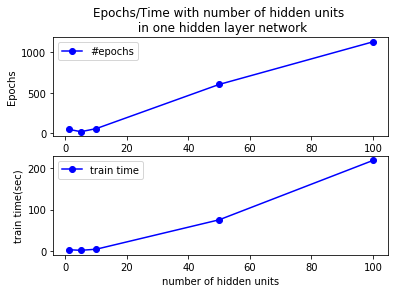

In [17]:
print("------------------Plotting Graphs for Part B - Fixed LR - One Hidden Layer ------------------")
plot_accuracy(arch_test, train_accuracy, test_accuracy, valid_accuracy)
plot_epoch(arch_test, epochs, train_time)

## Part C - Adaptive Learning rate

In [53]:
epochs = []
train_accuracy = []
test_accuracy = []
valid_accuracy = []
train_time = []

lr0=1.5

for i in range(len(arch_test)):
    theta = theta_init([arch_test[i]], 'normal')
    #print(theta[0].shape, theta[1].shape, theta[2].shape)
    print("Training the network with {} hidden layer with {} units".format(len([arch_test[i]]), arch_test[i]))
    print("The parameters of the layers are of the shape:")

    for j in range(len(theta)):
        print("theta between layer {} and layer {} is {}".format(j, j+1,theta[j].shape))

    start = time.time()
    epoch, theta = training(mini_batch, X_valid, valid_class_enc, theta, lr0, 'sigmoid', 'adaptive')
    epochs.append(epoch)
    train_time.append(time.time()-start)
    train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc))
    valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc))
    test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc))
    print("\n------------------------------------------------------------------------------")
    print("The stats for number of units in the hidden layer = {} are as below:".format(arch_test[i]))
    print("------------------------------------------------------------------------------")
    print("The number of epochs = {}".format(epochs[-1]))
    print("The training time = {:2.3f}sec".format(train_time[-1]))
    print("The training accuracy is = {:2.3f}%".format(train_accuracy[-1]))
    print("The validation accuracy is = {:2.3f}%".format(valid_accuracy[-1]))
    print("The test accuracy is = {:2.3f}%".format(test_accuracy[-1]))
    print("------------------------------------------------------------------------------\n")

Training the network with 1 hidden layer with 1 units
The parameters of the layers are of the shape:
theta between layer 0 and layer 1 is (785, 1)
theta between layer 1 and layer 2 is (1, 26)
Initial Cost on Val dataset for this epoch 1 = 3.2523889110145983
learning rate for this epoch =  0.5
Error on this batch = 3.252387210445647
Error on this batch = 0.7539355816987324
Cost on val dataset after 2 epochs is = 0.596018260069574
Initial Cost on Val dataset for this epoch 2 = 0.596018260069574
learning rate for this epoch =  0.35355339059327373
Error on this batch = 0.5956696280244634
Error on this batch = 0.5515385242785587
Cost on val dataset after 3 epochs is = 0.5320880267143362
Initial Cost on Val dataset for this epoch 3 = 0.5320880267143362
learning rate for this epoch =  0.2886751345948129
Error on this batch = 0.5318960198133289
Error on this batch = 0.5199562934325028
Cost on val dataset after 4 epochs is = 0.5130041694125225
Initial Cost on Val dataset for this epoch 4 = 0.51

Cost on val dataset after 33 epochs is = 0.4826264889076551
Initial Cost on Val dataset for this epoch 33 = 0.4826264889076551
learning rate for this epoch =  0.08703882797784893
Error on this batch = 0.48255886311648793
Error on this batch = 0.48250356140574513
Cost on val dataset after 34 epochs is = 0.4825507833313709
Initial Cost on Val dataset for this epoch 34 = 0.4825507833313709
learning rate for this epoch =  0.08574929257125441
Error on this batch = 0.482483252032803
Error on this batch = 0.48243039845272406
Cost on val dataset after 35 epochs is = 0.4824800162725913
Initial Cost on Val dataset for this epoch 35 = 0.4824800162725913
learning rate for this epoch =  0.08451542547285165
Error on this batch = 0.48241256640186536
Error on this batch = 0.48236192731044314
Cost on val dataset after 36 epochs is = 0.4824137457131219
Initial Cost on Val dataset for this epoch 36 = 0.4824137457131219
learning rate for this epoch =  0.08333333333333333
Error on this batch = 0.4823463654

Cost on val dataset after 65 epochs is = 0.48147036354249606
Initial Cost on Val dataset for this epoch 65 = 0.48147036354249606
learning rate for this epoch =  0.062017367294604234
Error on this batch = 0.4814025850150175
Error on this batch = 0.48137476105670834
Cost on val dataset after 66 epochs is = 0.4814547913200563
Initial Cost on Val dataset for this epoch 66 = 0.4814547913200563
learning rate for this epoch =  0.06154574548966636
Error on this batch = 0.4813869620598697
Error on this batch = 0.4813593358516481
Cost on val dataset after 67 epochs is = 0.4814397870757292
Initial Cost on Val dataset for this epoch 67 = 0.4814397870757292
learning rate for this epoch =  0.06108472217815261
Error on this batch = 0.4813719061338426
Error on this batch = 0.4813444646540587
Cost on val dataset after 68 epochs is = 0.4814253232297525
Initial Cost on Val dataset for this epoch 68 = 0.4814253232297525
learning rate for this epoch =  0.06063390625908324
Error on this batch = 0.4813573897

Cost on val dataset after 97 epochs is = 0.4811597419092718
Initial Cost on Val dataset for this epoch 97 = 0.4811597419092718
learning rate for this epoch =  0.05076730825668096
Error on this batch = 0.48109010364876786
Error on this batch = 0.48106483771082015
Cost on val dataset after 98 epochs is = 0.4811540510651761
Initial Cost on Val dataset for this epoch 98 = 0.4811540510651761
learning rate for this epoch =  0.050507627227610534
Error on this batch = 0.4810843521049792
Error on this batch = 0.48105909839235467
Cost on val dataset after 99 epochs is = 0.48114851071877485
Initial Cost on Val dataset for this epoch 99 = 0.48114851071877485
learning rate for this epoch =  0.050251890762960605
Error on this batch = 0.481078751105769
Error on this batch = 0.4810535076461349
Cost on val dataset after 100 epochs is = 0.4811431157304366
Initial Cost on Val dataset for this epoch 100 = 0.4811431157304366
learning rate for this epoch =  0.05
Error on this batch = 0.48107329552139777
Err

Cost on val dataset after 129 epochs is = 0.48103289234244573
Initial Cost on Val dataset for this epoch 129 = 0.48103289234244573
learning rate for this epoch =  0.04402254531628119
Error on this batch = 0.4809613688283961
Error on this batch = 0.48093587027169477
Cost on val dataset after 130 epochs is = 0.4810302541671982
Initial Cost on Val dataset for this epoch 130 = 0.4810302541671982
learning rate for this epoch =  0.043852900965351466
Error on this batch = 0.4809586744174088
Error on this batch = 0.4809331564208126
Cost on val dataset after 131 epochs is = 0.4810276723169858
Initial Cost on Val dataset for this epoch 131 = 0.4810276723169858
learning rate for this epoch =  0.0436852028330519
Error on this batch = 0.48095603652302077
Error on this batch = 0.4809304987107679
Cost on val dataset after 132 epochs is = 0.48102514528272333
Initial Cost on Val dataset for this epoch 132 = 0.48102514528272333
learning rate for this epoch =  0.04351941398892446
Error on this batch = 0.

Cost on val dataset after 161 epochs is = 0.4809703875112432
Initial Cost on Val dataset for this epoch 161 = 0.4809703875112432
learning rate for this epoch =  0.03940552031195503
Error on this batch = 0.4808971626811981
Error on this batch = 0.48087092906436824
Cost on val dataset after 162 epochs is = 0.4809689943665821
Initial Cost on Val dataset for this epoch 162 = 0.4809689943665821
learning rate for this epoch =  0.039283710065919304
Error on this batch = 0.48089571966932537
Error on this batch = 0.4808694611989708
Cost on val dataset after 163 epochs is = 0.48096762671390064
Initial Cost on Val dataset for this epoch 163 = 0.48096762671390064
learning rate for this epoch =  0.03916302249939787
Error on this batch = 0.4808943023472294
Error on this batch = 0.4808680189928044
Cost on val dataset after 164 epochs is = 0.4809662839838974
Initial Cost on Val dataset for this epoch 164 = 0.4809662839838974
learning rate for this epoch =  0.03904344047215152
Error on this batch = 0.4

Error on this batch = 0.4816617122274792
Cost on val dataset after 5 epochs is = 0.4816167847026859
Initial Cost on Val dataset for this epoch 5 = 0.4816167847026859
learning rate for this epoch =  0.22360679774997896
Error on this batch = 0.4814917531900175
Error on this batch = 0.4813051631537713
Cost on val dataset after 6 epochs is = 0.48135118228307805
Initial Cost on Val dataset for this epoch 6 = 0.48135118228307805
learning rate for this epoch =  0.20412414523193154
Error on this batch = 0.481248030037795
Error on this batch = 0.4811153537734418
Cost on val dataset after 7 epochs is = 0.48120238787093533
Initial Cost on Val dataset for this epoch 7 = 0.48120238787093533
learning rate for this epoch =  0.1889822365046136
Error on this batch = 0.4811137615642499
Error on this batch = 0.4810035309401299
Cost on val dataset after 8 epochs is = 0.48111198982014913
Initial Cost on Val dataset for this epoch 8 = 0.48111198982014913
learning rate for this epoch =  0.17677669529663687
E

Cost on val dataset after 4 epochs is = 0.48118256018196615
Initial Cost on Val dataset for this epoch 4 = 0.48118256018196615
learning rate for this epoch =  0.25
Error on this batch = 0.4810996456752301
Error on this batch = 0.4808980397654839
Cost on val dataset after 5 epochs is = 0.48109989274593856
Initial Cost on Val dataset for this epoch 5 = 0.48109989274593856
learning rate for this epoch =  0.22360679774997896
Error on this batch = 0.4810599833162988
Error on this batch = 0.480850534303475
Cost on val dataset after 6 epochs is = 0.48106780913129765
Initial Cost on Val dataset for this epoch 6 = 0.48106780913129765
learning rate for this epoch =  0.20412414523193154
Error on this batch = 0.4810534183244144
Error on this batch = 0.4808290934397344
Cost on val dataset after 7 epochs is = 0.4810534729037285
Initial Cost on Val dataset for this epoch 7 = 0.4810534729037285
learning rate for this epoch =  0.1889822365046136
Error on this batch = 0.4810557279371363
Error on this ba

Cost on val dataset after 13 epochs is = 0.48163543151164073
Initial Cost on Val dataset for this epoch 13 = 0.48163543151164073
learning rate for this epoch =  0.1386750490563073
Error on this batch = 0.48221272600268245
Error on this batch = 0.4811277909142423
Cost on val dataset after 14 epochs is = 0.4816212710565488
Initial Cost on Val dataset for this epoch 14 = 0.4816212710565488
learning rate for this epoch =  0.1336306209562122
Error on this batch = 0.48220094102437117
Error on this batch = 0.48111277415217474
Cost on val dataset after 15 epochs is = 0.48160712752848384
Initial Cost on Val dataset for this epoch 15 = 0.48160712752848384
learning rate for this epoch =  0.12909944487358055
Error on this batch = 0.48218885282467766
Error on this batch = 0.48109773115976084
Cost on val dataset after 16 epochs is = 0.48159296136991414
Initial Cost on Val dataset for this epoch 16 = 0.48159296136991414
learning rate for this epoch =  0.125
Error on this batch = 0.4821764953539335
Er

Error on this batch = 0.48049769482528126
Cost on val dataset after 45 epochs is = 0.48106040509165104
Initial Cost on Val dataset for this epoch 45 = 0.48106040509165104
learning rate for this epoch =  0.07453559924999299
Error on this batch = 0.48168118265305404
Error on this batch = 0.4804671537090501
Cost on val dataset after 46 epochs is = 0.4810345028182547
Initial Cost on Val dataset for this epoch 46 = 0.4810345028182547
learning rate for this epoch =  0.07372097807744857
Error on this batch = 0.48165718797663387
Error on this batch = 0.48043565049045006
Cost on val dataset after 47 epochs is = 0.48100785829277204
Initial Cost on Val dataset for this epoch 47 = 0.48100785829277204
learning rate for this epoch =  0.07293249574894728
Error on this batch = 0.4816325368773181
Error on this batch = 0.48040314915879245
Cost on val dataset after 48 epochs is = 0.4809804440183818
Initial Cost on Val dataset for this epoch 48 = 0.4809804440183818
learning rate for this epoch =  0.072168

Error on this batch = 0.47881316706781996
Cost on val dataset after 77 epochs is = 0.4796939905816139
Initial Cost on Val dataset for this epoch 77 = 0.4796939905816139
learning rate for this epoch =  0.05698028822981897
Error on this batch = 0.4804408624880125
Error on this batch = 0.47872638937633705
Cost on val dataset after 78 epochs is = 0.4796259042016859
Initial Cost on Val dataset for this epoch 78 = 0.4796259042016859
learning rate for this epoch =  0.05661385170722978
Error on this batch = 0.48037984274716705
Error on this batch = 0.47863664571328557
Cost on val dataset after 79 epochs is = 0.479555673350129
Initial Cost on Val dataset for this epoch 79 = 0.479555673350129
learning rate for this epoch =  0.0562543950463012
Error on this batch = 0.4803169440441945
Error on this batch = 0.47854383088300817
Cost on val dataset after 80 epochs is = 0.4794832306145203
Initial Cost on Val dataset for this epoch 80 = 0.4794832306145203
learning rate for this epoch =  0.0559016994374

Error on this batch = 0.47387117038285664
Cost on val dataset after 109 epochs is = 0.47604025584764886
Initial Cost on Val dataset for this epoch 109 = 0.47604025584764886
learning rate for this epoch =  0.04789131426105757
Error on this batch = 0.47719864225158276
Error on this batch = 0.47361317222036675
Cost on val dataset after 110 epochs is = 0.4758597077795539
Initial Cost on Val dataset for this epoch 110 = 0.4758597077795539
learning rate for this epoch =  0.04767312946227962
Error on this batch = 0.47703992318170335
Error on this batch = 0.47334653818350775
Cost on val dataset after 111 epochs is = 0.4756739218119749
Initial Cost on Val dataset for this epoch 111 = 0.4756739218119749
learning rate for this epoch =  0.04745789978762495
Error on this batch = 0.47687682289210914
Error on this batch = 0.47307108142299387
Cost on val dataset after 112 epochs is = 0.47548280154941225
Initial Cost on Val dataset for this epoch 112 = 0.47548280154941225
learning rate for this epoch =

Error on this batch = 0.4617618799057442
Cost on val dataset after 141 epochs is = 0.4676059763524638
Initial Cost on Val dataset for this epoch 141 = 0.4676059763524638
learning rate for this epoch =  0.04210759605332595
Error on this batch = 0.47042784501079854
Error on this batch = 0.4613266318935901
Cost on val dataset after 142 epochs is = 0.467270770199596
Initial Cost on Val dataset for this epoch 142 = 0.467270770199596
learning rate for this epoch =  0.041959067914834454
Error on this batch = 0.47020054900887814
Error on this batch = 0.4608938817917101
Cost on val dataset after 143 epochs is = 0.4669331086041733
Initial Cost on Val dataset for this epoch 143 = 0.4669331086041733
learning rate for this epoch =  0.04181210050035454
Error on this batch = 0.46997516024250935
Error on this batch = 0.4604638520308288
Cost on val dataset after 144 epochs is = 0.46659311907103623
Initial Cost on Val dataset for this epoch 144 = 0.46659311907103623
learning rate for this epoch =  0.041

Error on this batch = 0.4484933901288611
Cost on val dataset after 173 epochs is = 0.4556641191771843
Initial Cost on Val dataset for this epoch 173 = 0.4556641191771843
learning rate for this epoch =  0.038014296063485276
Error on this batch = 0.4636748339402581
Error on this batch = 0.44804510374323686
Cost on val dataset after 174 epochs is = 0.4552330321280419
Initial Cost on Val dataset for this epoch 174 = 0.4552330321280419
learning rate for this epoch =  0.03790490217894517
Error on this batch = 0.46344944767111995
Error on this batch = 0.44759016931342593
Cost on val dataset after 175 epochs is = 0.4547965470455578
Initial Cost on Val dataset for this epoch 175 = 0.4547965470455578
learning rate for this epoch =  0.03779644730092272
Error on this batch = 0.4632207604191505
Error on this batch = 0.4471281438405949
Cost on val dataset after 176 epochs is = 0.4543544462188503
Initial Cost on Val dataset for this epoch 176 = 0.4543544462188503
learning rate for this epoch =  0.037

Error on this batch = 0.42852303185856644
Cost on val dataset after 205 epochs is = 0.4377416207052872
Initial Cost on Val dataset for this epoch 205 = 0.4377416207052872
learning rate for this epoch =  0.03492151478847891
Error on this batch = 0.4536151754958933
Error on this batch = 0.4276442440845796
Cost on val dataset after 206 epochs is = 0.4369903034919947
Initial Cost on Val dataset for this epoch 206 = 0.4369903034919947
learning rate for this epoch =  0.034836650714580884
Error on this batch = 0.4531597189734674
Error on this batch = 0.4267501092180569
Cost on val dataset after 207 epochs is = 0.43622630791832556
Initial Cost on Val dataset for this epoch 207 = 0.43622630791832556
learning rate for this epoch =  0.034752402342845795
Error on this batch = 0.45269373383880224
Error on this batch = 0.4258414652362625
Cost on val dataset after 208 epochs is = 0.4354501249393841
Initial Cost on Val dataset for this epoch 208 = 0.4354501249393841
learning rate for this epoch =  0.0

Error on this batch = 0.3985598245951293
Cost on val dataset after 237 epochs is = 0.41144093478678917
Initial Cost on Val dataset for this epoch 237 = 0.41144093478678917
learning rate for this epoch =  0.032478490123081544
Error on this batch = 0.4355922394320477
Error on this batch = 0.39774388759623286
Cost on val dataset after 238 epochs is = 0.4106813983325361
Initial Cost on Val dataset for this epoch 238 = 0.4106813983325361
learning rate for this epoch =  0.03241018617760822
Error on this batch = 0.43498622420338495
Error on this batch = 0.3969407802459219
Cost on val dataset after 239 epochs is = 0.40993034592294986
Initial Cost on Val dataset for this epoch 239 = 0.40993034592294986
learning rate for this epoch =  0.03234231136765754
Error on this batch = 0.4343810622108613
Error on this batch = 0.39615028376179423
Cost on val dataset after 240 epochs is = 0.40918766219302743
Initial Cost on Val dataset for this epoch 240 = 0.40918766219302743
learning rate for this epoch = 

Error on this batch = 0.37702971198805046
Cost on val dataset after 269 epochs is = 0.3901073683865182
Initial Cost on Val dataset for this epoch 269 = 0.3901073683865182
learning rate for this epoch =  0.030485538042484616
Error on this batch = 0.4163254394498573
Error on this batch = 0.3764438015517584
Cost on val dataset after 270 epochs is = 0.3894908518008106
Initial Cost on Val dataset for this epoch 270 = 0.3894908518008106
learning rate for this epoch =  0.03042903097250923
Error on this batch = 0.41570803435762516
Error on this batch = 0.37585958698662225
Cost on val dataset after 271 epochs is = 0.38887465045209096
Initial Cost on Val dataset for this epoch 271 = 0.38887465045209096
learning rate for this epoch =  0.03037283696153935
Error on this batch = 0.4150884691370855
Error on this batch = 0.3752768327023564
Cost on val dataset after 272 epochs is = 0.3882585884595428
Initial Cost on Val dataset for this epoch 272 = 0.3882585884595428
learning rate for this epoch =  0.0

Error on this batch = 0.35822052606363697
Cost on val dataset after 301 epochs is = 0.3699317467667629
Initial Cost on Val dataset for this epoch 301 = 0.3699317467667629
learning rate for this epoch =  0.02881952088521175
Error on this batch = 0.39537330372938256
Error on this batch = 0.3576083204402319
Cost on val dataset after 302 epochs is = 0.3692749732235238
Initial Cost on Val dataset for this epoch 302 = 0.3692749732235238
learning rate for this epoch =  0.0287717668824218
Error on this batch = 0.3946835924411744
Error on this batch = 0.3569938308848667
Cost on val dataset after 303 epochs is = 0.3686165408489497
Initial Cost on Val dataset for this epoch 303 = 0.3686165408489497
learning rate for this epoch =  0.0287242494810713
Error on this batch = 0.39399267531356386
Error on this batch = 0.3563770455328753
Cost on val dataset after 304 epochs is = 0.36795650312892036
Initial Cost on Val dataset for this epoch 304 = 0.36795650312892036
learning rate for this epoch =  0.0286

Error on this batch = 0.3376297215448111
Cost on val dataset after 333 epochs is = 0.34851737003314875
Initial Cost on Val dataset for this epoch 333 = 0.34851737003314875
learning rate for this epoch =  0.02739983121755955
Error on this batch = 0.3733926809821713
Error on this batch = 0.3369628136606552
Cost on val dataset after 334 epochs is = 0.3478534529062699
Initial Cost on Val dataset for this epoch 334 = 0.3478534529062699
learning rate for this epoch =  0.027358782758229137
Error on this batch = 0.37273197127612195
Error on this batch = 0.3362952908634334
Cost on val dataset after 335 epochs is = 0.3471910745711828
Initial Cost on Val dataset for this epoch 335 = 0.3471910745711828
learning rate for this epoch =  0.027317918235407655
Error on this batch = 0.37207405939162314
Error on this batch = 0.3356272230216675
Cost on val dataset after 336 epochs is = 0.3465303254534296
Initial Cost on Val dataset for this epoch 336 = 0.3465303254534296
learning rate for this epoch =  0.0

Error on this batch = 0.31624896827675014
Cost on val dataset after 365 epochs is = 0.32833633853789745
Initial Cost on Val dataset for this epoch 365 = 0.32833633853789745
learning rate for this epoch =  0.026171196129510688
Error on this batch = 0.353797767254718
Error on this batch = 0.315585820179412
Cost on val dataset after 366 epochs is = 0.3277464293015948
Initial Cost on Val dataset for this epoch 366 = 0.3277464293015948
learning rate for this epoch =  0.026135418674465834
Error on this batch = 0.3532372713012481
Error on this batch = 0.3149231997181747
Cost on val dataset after 367 epochs is = 0.3271590214935992
Initial Cost on Val dataset for this epoch 367 = 0.3271590214935992
learning rate for this epoch =  0.026099787548594027
Error on this batch = 0.3526796700872464
Error on this batch = 0.3142611144211248
Cost on val dataset after 368 epochs is = 0.3265740961635448
Initial Cost on Val dataset for this epoch 368 = 0.3265740961635448
learning rate for this epoch =  0.026

Cost on val dataset after 396 epochs is = 0.31109739415176996
Initial Cost on Val dataset for this epoch 396 = 0.31109739415176996
learning rate for this epoch =  0.025125945381480302
Error on this batch = 0.3375856220594781
Error on this batch = 0.2953142149382097
Cost on val dataset after 397 epochs is = 0.3105725804020127
Initial Cost on Val dataset for this epoch 397 = 0.3105725804020127
learning rate for this epoch =  0.02509428066142478
Error on this batch = 0.33709589838473925
Error on this batch = 0.2946703022686876
Cost on val dataset after 398 epochs is = 0.31004939884886806
Initial Cost on Val dataset for this epoch 398 = 0.31004939884886806
learning rate for this epoch =  0.025062735355854276
Error on this batch = 0.33660782077706003
Error on this batch = 0.2940270789462869
Cost on val dataset after 399 epochs is = 0.3095278222726989
Initial Cost on Val dataset for this epoch 399 = 0.3095278222726989
learning rate for this epoch =  0.025031308716087945
Error on this batch =

Cost on val dataset after 428 epochs is = 0.2949952527909631
Initial Cost on Val dataset for this epoch 428 = 0.2949952527909631
learning rate for this epoch =  0.02416841222614159
Error on this batch = 0.3225657084513173
Error on this batch = 0.2750977326316093
Cost on val dataset after 429 epochs is = 0.2945115666671817
Initial Cost on Val dataset for this epoch 429 = 0.2945115666671817
learning rate for this epoch =  0.02414022747926338
Error on this batch = 0.3221126231864568
Error on this batch = 0.2744806743649368
Cost on val dataset after 430 epochs is = 0.29402888028516977
Initial Cost on Val dataset for this epoch 430 = 0.29402888028516977
learning rate for this epoch =  0.024112141108520606
Error on this batch = 0.3216602089190596
Error on this batch = 0.2738646194842878
Cost on val dataset after 431 epochs is = 0.2935471813010492
Initial Cost on Val dataset for this epoch 431 = 0.2935471813010492
learning rate for this epoch =  0.0240841525429544
Error on this batch = 0.3212

Error on this batch = 0.25646812102264066
Cost on val dataset after 460 epochs is = 0.27996463159540336
Initial Cost on Val dataset for this epoch 460 = 0.27996463159540336
learning rate for this epoch =  0.023312620206007845
Error on this batch = 0.3082872712042555
Error on this batch = 0.25588527739322864
Cost on val dataset after 461 epochs is = 0.2795085321963915
Initial Cost on Val dataset for this epoch 461 = 0.2795085321963915
learning rate for this epoch =  0.023287321641631116
Error on this batch = 0.30784495011734725
Error on this batch = 0.25530361153636577
Cost on val dataset after 462 epochs is = 0.2790532045396187
Initial Cost on Val dataset for this epoch 462 = 0.2790532045396187
learning rate for this epoch =  0.023262105259961773
Error on this batch = 0.30740268496385303
Error on this batch = 0.25472312644475215
Cost on val dataset after 463 epochs is = 0.2785986465606454
Initial Cost on Val dataset for this epoch 463 = 0.2785986465606454
learning rate for this epoch =

Error on this batch = 0.23841592320328328
Cost on val dataset after 492 epochs is = 0.2657521303248071
Initial Cost on Val dataset for this epoch 492 = 0.2657521303248071
learning rate for this epoch =  0.022541740866685808
Error on this batch = 0.29412731843214174
Error on this batch = 0.23787230658676475
Cost on val dataset after 493 epochs is = 0.2653210833031487
Initial Cost on Val dataset for this epoch 493 = 0.2653210833031487
learning rate for this epoch =  0.022518867455552247
Error on this batch = 0.293684327620231
Error on this batch = 0.2373299819197316
Cost on val dataset after 494 epochs is = 0.26489087651331583
Initial Cost on Val dataset for this epoch 494 = 0.26489087651331583
learning rate for this epoch =  0.022496063533292376
Error on this batch = 0.2932413488525283
Error on this batch = 0.23678895481764084
Cost on val dataset after 495 epochs is = 0.2644615159878457
Initial Cost on Val dataset for this epoch 495 = 0.2644615159878457
learning rate for this epoch =  0

Cost on val dataset after 523 epochs is = 0.25281163335967566
Initial Cost on Val dataset for this epoch 523 = 0.25281163335967566
learning rate for this epoch =  0.021863473472331304
Error on this batch = 0.2804588322770531
Error on this batch = 0.22169413805803342
Cost on val dataset after 524 epochs is = 0.25240996653790904
Initial Cost on Val dataset for this epoch 524 = 0.25240996653790904
learning rate for this epoch =  0.02184260141652595
Error on this batch = 0.2800228160540284
Error on this batch = 0.22119532511610238
Cost on val dataset after 525 epochs is = 0.2520093705829848
Initial Cost on Val dataset for this epoch 525 = 0.2520093705829848
learning rate for this epoch =  0.02182178902359924
Error on this batch = 0.2795873128964121
Error on this batch = 0.22069804140830968
Cost on val dataset after 526 epochs is = 0.2516098529737591
Initial Cost on Val dataset for this epoch 526 = 0.2516098529737591
learning rate for this epoch =  0.02180103600984737
Error on this batch = 

Cost on val dataset after 555 epochs is = 0.24052221411231853
Initial Cost on Val dataset for this epoch 555 = 0.24052221411231853
learning rate for this epoch =  0.021223817998900444
Error on this batch = 0.26685799395822296
Error on this batch = 0.20652509736991548
Cost on val dataset after 556 epochs is = 0.24015789396594248
Initial Cost on Val dataset for this epoch 556 = 0.24015789396594248
learning rate for this epoch =  0.021204723241999273
Error on this batch = 0.2664478572713491
Error on this batch = 0.20607844453933852
Cost on val dataset after 557 epochs is = 0.23979481619279797
Initial Cost on Val dataset for this epoch 557 = 0.23979481619279797
learning rate for this epoch =  0.021185679930351788
Error on this batch = 0.2660388028147242
Error on this batch = 0.20563349769748254
Cost on val dataset after 558 epochs is = 0.2394329834476655
Initial Cost on Val dataset for this epoch 558 = 0.2394329834476655
learning rate for this epoch =  0.021166687833365085
Error on this ba

Cost on val dataset after 587 epochs is = 0.22948765482148437
Initial Cost on Val dataset for this epoch 587 = 0.22948765482148437
learning rate for this epoch =  0.0206372085853249
Error on this batch = 0.25432107435185386
Error on this batch = 0.19308269857283963
Cost on val dataset after 588 epochs is = 0.22916363950798763
Initial Cost on Val dataset for this epoch 588 = 0.22916363950798763
learning rate for this epoch =  0.020619652471058063
Error on this batch = 0.2539501494174291
Error on this batch = 0.1926908201845881
Cost on val dataset after 589 epochs is = 0.22884087792024269
Initial Cost on Val dataset for this epoch 589 = 0.22884087792024269
learning rate for this epoch =  0.02060214108575823
Error on this batch = 0.2535805419308972
Error on this batch = 0.19230062918297713
Cost on val dataset after 590 epochs is = 0.22851936839545567
Initial Cost on Val dataset for this epoch 590 = 0.22851936839545567
learning rate for this epoch =  0.020584674239815456
Error on this batc

Cost on val dataset after 619 epochs is = 0.2197298730725739
Initial Cost on Val dataset for this epoch 619 = 0.2197298730725739
learning rate for this epoch =  0.02009669677645352
Error on this batch = 0.24310783062418204
Error on this batch = 0.1813602622709918
Cost on val dataset after 620 epochs is = 0.21944477036448634
Initial Cost on Val dataset for this epoch 620 = 0.21944477036448634
learning rate for this epoch =  0.02008048322256247
Error on this batch = 0.24277910651764456
Error on this batch = 0.18102033475463214
Cost on val dataset after 621 epochs is = 0.2191608327036062
Initial Cost on Val dataset for this epoch 621 = 0.2191608327036062
learning rate for this epoch =  0.020064308847628203
Error on this batch = 0.24245167389090327
Error on this batch = 0.18068194883108482
Cost on val dataset after 622 epochs is = 0.21887805646567068
Initial Cost on Val dataset for this epoch 622 = 0.21887805646567068
learning rate for this epoch =  0.020048173494115636
Error on this batch

Error on this batch = 0.17151287854216685
Cost on val dataset after 651 epochs is = 0.21116546166863692
Initial Cost on Val dataset for this epoch 651 = 0.21116546166863692
learning rate for this epoch =  0.019596545041740514
Error on this batch = 0.23321183731170103
Error on this batch = 0.17121796789726637
Cost on val dataset after 652 epochs is = 0.210915711249648
Initial Cost on Val dataset for this epoch 652 = 0.210915711249648
learning rate for this epoch =  0.019581511249698935
Error on this batch = 0.23292263327072704
Error on this batch = 0.17092441011932524
Cost on val dataset after 653 epochs is = 0.21066699800182204
Initial Cost on Val dataset for this epoch 653 = 0.21066699800182204
learning rate for this epoch =  0.019566512004870806
Error on this batch = 0.2326345967153558
Error on this batch = 0.17063219884184147
Cost on val dataset after 654 epochs is = 0.2104193176830489
Initial Cost on Val dataset for this epoch 654 = 0.2104193176830489
learning rate for this epoch =

Error on this batch = 0.16271510810844989
Cost on val dataset after 683 epochs is = 0.20366669453325317
Initial Cost on Val dataset for this epoch 683 = 0.20366669453325317
learning rate for this epoch =  0.019131968294834524
Error on this batch = 0.2245143503901251
Error on this batch = 0.1624603270026011
Cost on val dataset after 684 epochs is = 0.203448012655653
Initial Cost on Val dataset for this epoch 684 = 0.203448012655653
learning rate for this epoch =  0.019117977822546813
Error on this batch = 0.2242602976689375
Error on this batch = 0.16220669551859274
Cost on val dataset after 685 epochs is = 0.20323023112450428
Initial Cost on Val dataset for this epoch 685 = 0.20323023112450428
learning rate for this epoch =  0.019104017997521754
Error on this batch = 0.2240072696222269
Error on this batch = 0.16195420743316688
Cost on val dataset after 686 epochs is = 0.20301334570173926
Initial Cost on Val dataset for this epoch 686 = 0.20301334570173926
learning rate for this epoch = 

Error on this batch = 0.15510204031793468
Cost on val dataset after 715 epochs is = 0.19709470798911316
Initial Cost on Val dataset for this epoch 715 = 0.19709470798911316
learning rate for this epoch =  0.018698939800169144
Error on this batch = 0.2168710205705437
Error on this batch = 0.1548810437146815
Cost on val dataset after 716 epochs is = 0.19690277612852097
Initial Cost on Val dataset for this epoch 716 = 0.19690277612852097
learning rate for this epoch =  0.018685877318798397
Error on this batch = 0.21664757841967713
Error on this batch = 0.15466100639502503
Cost on val dataset after 717 epochs is = 0.19671161342287938
Initial Cost on Val dataset for this epoch 717 = 0.19671161342287938
learning rate for this epoch =  0.018672842174331777
Error on this batch = 0.21642502162909039
Error on this batch = 0.154441922759727
Cost on val dataset after 718 epochs is = 0.19652121595881103
Initial Cost on Val dataset for this epoch 718 = 0.19652121595881103
learning rate for this epoc

Error on this batch = 0.1484790750236313
Cost on val dataset after 747 epochs is = 0.19131548541081508
Initial Cost on Val dataset for this epoch 747 = 0.19131548541081508
learning rate for this epoch =  0.018294043331615058
Error on this batch = 0.21013944573718032
Error on this batch = 0.14828612254162912
Cost on val dataset after 748 epochs is = 0.19114629621513998
Initial Cost on Val dataset for this epoch 748 = 0.19114629621513998
learning rate for this epoch =  0.018281810603178267
Error on this batch = 0.20994229384068194
Error on this batch = 0.14809396274577719
Cost on val dataset after 749 epochs is = 0.19097775815673906
Initial Cost on Val dataset for this epoch 749 = 0.19097775815673906
learning rate for this epoch =  0.01826960238104674
Error on this batch = 0.2097458976472709
Error on this batch = 0.14790259086445978
Cost on val dataset after 750 epochs is = 0.19080986780286494
Initial Cost on Val dataset for this epoch 750 = 0.19080986780286494
learning rate for this epo

Error on this batch = 0.14267506472595842
Cost on val dataset after 779 epochs is = 0.18620795360359552
Initial Cost on Val dataset for this epoch 779 = 0.18620795360359552
learning rate for this epoch =  0.017914359097500464
Error on this batch = 0.20418683408182559
Error on this batch = 0.14250524421282754
Cost on val dataset after 780 epochs is = 0.18605797889008438
Initial Cost on Val dataset for this epoch 780 = 0.18605797889008438
learning rate for this epoch =  0.017902871850985824
Error on this batch = 0.2040120268220229
Error on this batch = 0.14233607691881697
Cost on val dataset after 781 epochs is = 0.18590855354401903
Initial Cost on Val dataset for this epoch 781 = 0.18590855354401903
learning rate for this epoch =  0.01789140667411283
Error on this batch = 0.20383785933369422
Error on this batch = 0.1421675589174577
Cost on val dataset after 782 epochs is = 0.185759674653171
Initial Cost on Val dataset for this epoch 782 = 0.185759674653171
learning rate for this epoch =

Error on this batch = 0.13754622407949077
Cost on val dataset after 811 epochs is = 0.18166737228104635
Initial Cost on Val dataset for this epoch 811 = 0.18166737228104635
learning rate for this epoch =  0.01755737468051559
Error on this batch = 0.19889419791399549
Error on this batch = 0.13739548158380294
Cost on val dataset after 812 epochs is = 0.1815336108159096
Initial Cost on Val dataset for this epoch 812 = 0.1815336108159096
learning rate for this epoch =  0.01754656015858991
Error on this batch = 0.19873827237348884
Error on this batch = 0.13724527877215473
Cost on val dataset after 813 epochs is = 0.18140031325654993
Initial Cost on Val dataset for this epoch 813 = 0.18140031325654993
learning rate for this epoch =  0.01753576559579736
Error on this batch = 0.1985828868103801
Error on this batch = 0.1370956124806279
Cost on val dataset after 814 epochs is = 0.18126747718037328
Initial Cost on Val dataset for this epoch 814 = 0.18126747718037328
learning rate for this epoch =

Error on this batch = 0.13297522064645034
Cost on val dataset after 843 epochs is = 0.1776055904172206
Initial Cost on Val dataset for this epoch 843 = 0.1776055904172206
learning rate for this epoch =  0.017220914757957267
Error on this batch = 0.19415882766184905
Error on this batch = 0.132840283426273
Cost on val dataset after 844 epochs is = 0.1774855412768132
Initial Cost on Val dataset for this epoch 844 = 0.1774855412768132
learning rate for this epoch =  0.017210709770537857
Error on this batch = 0.19401884428485766
Error on this batch = 0.13270579494860563
Cost on val dataset after 845 epochs is = 0.17736588532212513
Initial Cost on Val dataset for this epoch 845 = 0.17736588532212513
learning rate for this epoch =  0.017200522903844537
Error on this batch = 0.19387931730656552
Error on this batch = 0.1325717526930075
Cost on val dataset after 846 epochs is = 0.17724662055752294
Initial Cost on Val dataset for this epoch 846 = 0.17724662055752294
learning rate for this epoch =

Cost on val dataset after 874 epochs is = 0.17405830059501606
Initial Cost on Val dataset for this epoch 874 = 0.17405830059501606
learning rate for this epoch =  0.01691275228729346
Error on this batch = 0.19002137499056035
Error on this batch = 0.12886793267741342
Cost on val dataset after 875 epochs is = 0.1739495649721404
Initial Cost on Val dataset for this epoch 875 = 0.1739495649721404
learning rate for this epoch =  0.016903085094570332
Error on this batch = 0.1898945022393474
Error on this batch = 0.12874619078480992
Cost on val dataset after 876 epochs is = 0.1738411660409634
Initial Cost on Val dataset for this epoch 876 = 0.1738411660409634
learning rate for this epoch =  0.016893434459987148
Error on this batch = 0.1897680188998792
Error on this batch = 0.12862482539594874
Cost on val dataset after 877 epochs is = 0.17373310215275856
Initial Cost on Val dataset for this epoch 877 = 0.17373310215275856
learning rate for this epoch =  0.016883800336329358
Error on this batch

Error on this batch = 0.1252604705538946
Cost on val dataset after 906 epochs is = 0.17073793369296728
Initial Cost on Val dataset for this epoch 906 = 0.17073793369296728
learning rate for this epoch =  0.016611387354627385
Error on this batch = 0.1861453204951522
Error on this batch = 0.12514953369564122
Cost on val dataset after 907 epochs is = 0.17063920243458383
Initial Cost on Val dataset for this epoch 907 = 0.17063920243458383
learning rate for this epoch =  0.016602227504272985
Error on this batch = 0.18602999682229002
Error on this batch = 0.12503891773318748
Cost on val dataset after 908 epochs is = 0.1705407598256672
Initial Cost on Val dataset for this epoch 908 = 0.1705407598256672
learning rate for this epoch =  0.0165930827899993
Error on this batch = 0.18591500565752378
Error on this batch = 0.12492862107379077
Cost on val dataset after 909 epochs is = 0.17044260451130128
Initial Cost on Val dataset for this epoch 909 = 0.17044260451130128
learning rate for this epoch 

Error on this batch = 0.12186215344593045
Cost on val dataset after 938 epochs is = 0.16771526818874938
Initial Cost on Val dataset for this epoch 938 = 0.16771526818874938
learning rate for this epoch =  0.016325578711208478
Error on this batch = 0.18261227923527243
Error on this batch = 0.12176074947382681
Cost on val dataset after 939 epochs is = 0.16762514056375685
Initial Cost on Val dataset for this epoch 939 = 0.16762514056375685
learning rate for this epoch =  0.01631688332912094
Error on this batch = 0.18250684749676488
Error on this batch = 0.12165962073979782
Cost on val dataset after 940 epochs is = 0.16753526205021996
Initial Cost on Val dataset for this epoch 940 = 0.16753526205021996
learning rate for this epoch =  0.016308201826336056
Error on this batch = 0.18240170155719473
Error on this batch = 0.12155876597952212
Cost on val dataset after 941 epochs is = 0.16744563153083533
Initial Cost on Val dataset for this epoch 941 = 0.16744563153083533
learning rate for this e

Error on this batch = 0.11874778222234329
Cost on val dataset after 970 epochs is = 0.16494943128238956
Initial Cost on Val dataset for this epoch 970 = 0.16494943128238956
learning rate for this epoch =  0.01605403247669839
Error on this batch = 0.1793739563093659
Error on this batch = 0.11865460080628079
Cost on val dataset after 971 epochs is = 0.1648667523706218
Initial Cost on Val dataset for this epoch 971 = 0.1648667523706218
learning rate for this epoch =  0.016045763595142
Error on this batch = 0.1792770537558272
Error on this batch = 0.11856165828272602
Cost on val dataset after 972 epochs is = 0.1647842898929063
Initial Cost on Val dataset for this epoch 972 = 0.1647842898929063
learning rate for this epoch =  0.016037507477489603
Error on this batch = 0.17918039849205147
Error on this batch = 0.11846895364116505
Cost on val dataset after 973 epochs is = 0.1647020429232724
Initial Cost on Val dataset for this epoch 973 = 0.1647020429232724
learning rate for this epoch =  0.0

Error on this batch = 0.11587969188487891
Cost on val dataset after 1002 epochs is = 0.16240664940652016
Initial Cost on Val dataset for this epoch 1002 = 0.16240664940652016
learning rate for this epoch =  0.015795600590164088
Error on this batch = 0.17639054283216793
Error on this batch = 0.1157936859807379
Cost on val dataset after 1003 epochs is = 0.16233046231994783
Initial Cost on Val dataset for this epoch 1003 = 0.16233046231994783
learning rate for this epoch =  0.015787724448766815
Error on this batch = 0.17630104278654174
Error on this batch = 0.11570788977617856
Cost on val dataset after 1004 epochs is = 0.16225446451275927
Initial Cost on Val dataset for this epoch 1004 = 0.16225446451275927
learning rate for this epoch =  0.015779860077445078
Error on this batch = 0.17621175808475997
Error on this batch = 0.11562230245428891
Cost on val dataset after 1005 epochs is = 0.16217865521304348
Initial Cost on Val dataset for this epoch 1005 = 0.16217865521304348
learning rate fo

Error on this batch = 0.11322764094454484
Cost on val dataset after 1034 epochs is = 0.16005886558231464
Initial Cost on Val dataset for this epoch 1034 = 0.16005886558231464
learning rate for this epoch =  0.015549260339278073
Error on this batch = 0.1736290267314874
Error on this batch = 0.11314796456329738
Cost on val dataset after 1035 epochs is = 0.1599883729073071
Initial Cost on Val dataset for this epoch 1035 = 0.1599883729073071
learning rate for this epoch =  0.01554174680400523
Error on this batch = 0.1735459915893431
Error on this batch = 0.11306847411581597
Cost on val dataset after 1036 epochs is = 0.15991804680844438
Initial Cost on Val dataset for this epoch 1036 = 0.15991804680844438
learning rate for this epoch =  0.015534244150030001
Error on this batch = 0.1734631451106269
Error on this batch = 0.11298916893127324
Cost on val dataset after 1037 epochs is = 0.15984788663817934
Initial Cost on Val dataset for this epoch 1037 = 0.15984788663817934
learning rate for thi

Error on this batch = 0.110767026914152
Cost on val dataset after 1066 epochs is = 0.15788263056190954
Initial Cost on Val dataset for this epoch 1066 = 0.15788263056190954
learning rate for this epoch =  0.01531409729579222
Error on this batch = 0.17106184892059464
Error on this batch = 0.11069298594601346
Cost on val dataset after 1067 epochs is = 0.1578171636068435
Initial Cost on Val dataset for this epoch 1067 = 0.1578171636068435
learning rate for this epoch =  0.015306919373065674
Error on this batch = 0.170984493174056
Error on this batch = 0.11061911122825356
Cost on val dataset after 1068 epochs is = 0.15775184412452875
Initial Cost on Val dataset for this epoch 1068 = 0.15775184412452875
learning rate for this epoch =  0.015299751534052615
Error on this batch = 0.17090730366122497
Error on this batch = 0.11054540219967933
Cost on val dataset after 1069 epochs is = 0.15768667156821678
Initial Cost on Val dataset for this epoch 1069 = 0.15768667156821678
learning rate for this

Error on this batch = 0.10847749352172403
Cost on val dataset after 1098 epochs is = 0.1558582207234601
Initial Cost on Val dataset for this epoch 1098 = 0.1558582207234601
learning rate for this epoch =  0.015089291007086421
Error on this batch = 0.16866585075659152
Error on this batch = 0.10840850793952361
Cost on val dataset after 1099 epochs is = 0.15579721510357952
Initial Cost on Val dataset for this epoch 1099 = 0.15579721510357952
learning rate for this epoch =  0.01508242443516904
Error on this batch = 0.16859351211090534
Error on this batch = 0.10833967199046267
Cost on val dataset after 1100 epochs is = 0.15573634077726323
Initial Cost on Val dataset for this epoch 1100 = 0.15573634077726323
learning rate for this epoch =  0.015075567228888179
Error on this batch = 0.1685213207266522
Error on this batch = 0.10827098519591949
Cost on val dataset after 1101 epochs is = 0.1556755972798588
Initial Cost on Val dataset for this epoch 1101 = 0.1556755972798588
learning rate for thi

Error on this batch = 0.10634187565174724
Cost on val dataset after 1130 epochs is = 0.15396893802106806
Initial Cost on Val dataset for this epoch 1130 = 0.15396893802106806
learning rate for this epoch =  0.014874102932718241
Error on this batch = 0.1664214509706844
Error on this batch = 0.10627745137319781
Cost on val dataset after 1131 epochs is = 0.15391191427987386
Initial Cost on Val dataset for this epoch 1131 = 0.15391191427987386
learning rate for this epoch =  0.014867525836251314
Error on this batch = 0.16635356769614673
Error on this batch = 0.10621316243341904
Cost on val dataset after 1132 epochs is = 0.15385500804052515
Initial Cost on Val dataset for this epoch 1132 = 0.15385500804052515
learning rate for this epoch =  0.0148609574569441
Error on this batch = 0.16628581554335778
Error on this batch = 0.10614900841690621
Cost on val dataset after 1133 epochs is = 0.15379821890558706
Initial Cost on Val dataset for this epoch 1133 = 0.15379821890558706
learning rate for 

Error on this batch = 0.10434542548229214
Cost on val dataset after 1162 epochs is = 0.1522005538614185
Initial Cost on Val dataset for this epoch 1162 = 0.1522005538614185
learning rate for this epoch =  0.01466786622122144
Error on this batch = 0.16431199760293347
Error on this batch = 0.10428513408137705
Cost on val dataset after 1163 epochs is = 0.15214710205598853
Initial Cost on Val dataset for this epoch 1163 = 0.15214710205598853
learning rate for this epoch =  0.014661558817695555
Error on this batch = 0.1642480906068075
Error on this batch = 0.10422496552026093
Cost on val dataset after 1164 epochs is = 0.15209375592048271
Initial Cost on Val dataset for this epoch 1164 = 0.15209375592048271
learning rate for this epoch =  0.01465525954401373
Error on this batch = 0.16418430092783326
Error on this batch = 0.10416491943294012
Cost on val dataset after 1165 epochs is = 0.15204051511280592
Initial Cost on Val dataset for this epoch 1165 = 0.15204051511280592
learning rate for th

Error on this batch = 0.10247526163822089
Cost on val dataset after 1194 epochs is = 0.15054086606570208
Initial Cost on Val dataset for this epoch 1194 = 0.15054086606570208
learning rate for this epoch =  0.014469977004330817
Error on this batch = 0.16232325243889406
Error on this batch = 0.10241872610356055
Cost on val dataset after 1195 epochs is = 0.15049063346353286
Initial Cost on Val dataset for this epoch 1195 = 0.15049063346353286
learning rate for this epoch =  0.014463921353509292
Error on this batch = 0.1622629109230681
Error on this batch = 0.10236230233894694
Cost on val dataset after 1196 epochs is = 0.15044049631713488
Initial Cost on Val dataset for this epoch 1196 = 0.15044049631713488
learning rate for this epoch =  0.014457873299156005
Error on this batch = 0.162202674854855
Error on this batch = 0.10230599001849296
Cost on val dataset after 1197 epochs is = 0.15039045433023385
Initial Cost on Val dataset for this epoch 1197 = 0.15039045433023385
learning rate for 

Error on this batch = 0.10071998577880331
Cost on val dataset after 1226 epochs is = 0.14897934463876109
Initial Cost on Val dataset for this epoch 1226 = 0.14897934463876109
learning rate for this epoch =  0.014279886949438495
Error on this batch = 0.1604429767959085
Error on this batch = 0.10066687067678726
Cost on val dataset after 1227 epochs is = 0.1489320258606488
Initial Cost on Val dataset for this epoch 1227 = 0.1489320258606488
learning rate for this epoch =  0.01427406673849796
Error on this batch = 0.16038584668284855
Error on this batch = 0.10061385745212464
Cost on val dataset after 1228 epochs is = 0.1488847936673293
Initial Cost on Val dataset for this epoch 1228 = 0.1488847936673293
learning rate for this epoch =  0.01426825363838374
Error on this batch = 0.16032881175893057
Error on this batch = 0.1005609458125657
Cost on val dataset after 1229 epochs is = 0.14883764780069123
Initial Cost on Val dataset for this epoch 1229 = 0.14883764780069123
learning rate for this 

Error on this batch = 0.09906941814919865
Cost on val dataset after 1258 epochs is = 0.14750684745387166
Initial Cost on Val dataset for this epoch 1258 = 0.14750684745387166
learning rate for this epoch =  0.014097096860865023
Error on this batch = 0.15866059625030268
Error on this batch = 0.09901942282724402
Cost on val dataset after 1259 epochs is = 0.14746217654604676
Initial Cost on Val dataset for this epoch 1259 = 0.14746217654604676
learning rate for this epoch =  0.014091497219388538
Error on this batch = 0.1586063707867957
Error on this batch = 0.09896952049138373
Cost on val dataset after 1260 epochs is = 0.1474175844739073
Initial Cost on Val dataset for this epoch 1260 = 0.1474175844739073
learning rate for this epoch =  0.014085904245475275
Error on this batch = 0.15855223160138632
Error on this batch = 0.09891971087842631
Cost on val dataset after 1261 epochs is = 0.1473730710113205
Initial Cost on Val dataset for this epoch 1261 = 0.1473730710113205
learning rate for th

Error on this batch = 0.09751441341161683
Cost on val dataset after 1290 epochs is = 0.14611539117277714
Initial Cost on Val dataset for this epoch 1290 = 0.14611539117277714
learning rate for this epoch =  0.013921151159742613
Error on this batch = 0.15696692791871342
Error on this batch = 0.09746726720009967
Cost on val dataset after 1291 epochs is = 0.14607313520598733
Initial Cost on Val dataset for this epoch 1291 = 0.14607313520598733
learning rate for this epoch =  0.013915758499784417
Error on this batch = 0.1569153400178369
Error on this batch = 0.09742020595835384
Cost on val dataset after 1292 epochs is = 0.1460309512685904
Initial Cost on Val dataset for this epoch 1292 = 0.1460309512685904
learning rate for this epoch =  0.013910372101866431
Error on this batch = 0.15686383061622158
Error on this batch = 0.09737322944886113
Cost on val dataset after 1293 epochs is = 0.14598883916141708
Initial Cost on Val dataset for this epoch 1293 = 0.14598883916141708
learning rate for 

Error on this batch = 0.09604672826807363
Cost on val dataset after 1322 epochs is = 0.1447979659425259
Initial Cost on Val dataset for this epoch 1322 = 0.1447979659425259
learning rate for this epoch =  0.013751633103402302
Error on this batch = 0.15535395787860196
Error on this batch = 0.09600218694442995
Cost on val dataset after 1323 epochs is = 0.14475791982301725
Initial Cost on Val dataset for this epoch 1323 = 0.14475791982301725
learning rate for this epoch =  0.013746434980705375
Error on this batch = 0.15530477386012512
Error on this batch = 0.09595772335314984
Cost on val dataset after 1324 epochs is = 0.14471793972393626
Initial Cost on Val dataset for this epoch 1324 = 0.14471793972393626
learning rate for this epoch =  0.013741242748232817
Error on this batch = 0.15525566151810177
Error on this batch = 0.09591333727973461
Cost on val dataset after 1325 epochs is = 0.1446780254689932
Initial Cost on Val dataset for this epoch 1325 = 0.1446780254689932
learning rate for t

Error on this batch = 0.0946589213548765
Cost on val dataset after 1354 epochs is = 0.14354838487051316
Initial Cost on Val dataset for this epoch 1354 = 0.14354838487051316
learning rate for this epoch =  0.0135881606299661
Error on this batch = 0.15381465899202784
Error on this batch = 0.09461676438353785
Cost on val dataset after 1355 epochs is = 0.14351036711475104
Initial Cost on Val dataset for this epoch 1355 = 0.14351036711475104
learning rate for this epoch =  0.01358314562310403
Error on this batch = 0.15376767345101372
Error on this batch = 0.09457467860864313
Cost on val dataset after 1356 epochs is = 0.14347241004900965
Initial Cost on Val dataset for this epoch 1356 = 0.14347241004900965
learning rate for this epoch =  0.013578136164839211
Error on this batch = 0.1537207535750011
Error on this batch = 0.09453266383650588
Cost on val dataset after 1357 epochs is = 0.1434345135165354
Initial Cost on Val dataset for this epoch 1357 = 0.1434345135165354
learning rate for this

Error on this batch = 0.0933843101076879
Cost on val dataset after 1385 epochs is = 0.14239736798045272
Initial Cost on Val dataset for this epoch 1385 = 0.14239736798045272
learning rate for this epoch =  0.013435230372511476
Error on this batch = 0.1523878702491114
Error on this batch = 0.09334427288295422
Cost on val dataset after 1386 epochs is = 0.1423611611762506
Initial Cost on Val dataset for this epoch 1386 = 0.1423611611762506
learning rate for this epoch =  0.013430382733756338
Error on this batch = 0.15234284133250225
Error on this batch = 0.09330430112964201
Cost on val dataset after 1387 epochs is = 0.14232501045320575
Initial Cost on Val dataset for this epoch 1387 = 0.14232501045320575
learning rate for this epoch =  0.013425540338526368
Error on this batch = 0.15229787291832705
Error on this batch = 0.09326439467238788
Cost on val dataset after 1388 epochs is = 0.14228891567086036
Initial Cost on Val dataset for this epoch 1388 = 0.14228891567086036
learning rate for t

Error on this batch = 0.09213474285110831
Cost on val dataset after 1417 epochs is = 0.14126588693438924
Initial Cost on Val dataset for this epoch 1417 = 0.14126588693438924
learning rate for this epoch =  0.013282660709046375
Error on this batch = 0.15097619674866772
Error on this batch = 0.09209671646466473
Cost on val dataset after 1418 epochs is = 0.1412314074022668
Initial Cost on Val dataset for this epoch 1418 = 0.1412314074022668
learning rate for this epoch =  0.013277976293203616
Error on this batch = 0.1509330289194306
Error on this batch = 0.0920587502090862
Cost on val dataset after 1419 epochs is = 0.1411969796880316
Initial Cost on Val dataset for this epoch 1419 = 0.1411969796880316
learning rate for this epoch =  0.013273296830047474
Error on this batch = 0.15088991684942793
Error on this batch = 0.09202084392621233
Cost on val dataset after 1420 epochs is = 0.14116260366579497
Initial Cost on Val dataset for this epoch 1420 = 0.14116260366579497
learning rate for thi

Error on this batch = 0.09094695699356514
Cost on val dataset after 1449 epochs is = 0.14018763400860676
Initial Cost on Val dataset for this epoch 1449 = 0.14018763400860676
learning rate for this epoch =  0.013135173437318345
Error on this batch = 0.14962180805017566
Error on this batch = 0.09091077882796268
Cost on val dataset after 1450 epochs is = 0.14015475224031348
Initial Cost on Val dataset for this epoch 1450 = 0.14015475224031348
learning rate for this epoch =  0.013130643285972255
Error on this batch = 0.14958035768698033
Error on this batch = 0.09087465597810819
Cost on val dataset after 1451 epochs is = 0.14012191846232372
Initial Cost on Val dataset for this epoch 1451 = 0.14012191846232372
learning rate for this epoch =  0.013126117818567132
Error on this batch = 0.14953895885339225
Error on this batch = 0.09083858830145024
Cost on val dataset after 1452 epochs is = 0.14008913256140731
Initial Cost on Val dataset for this epoch 1452 = 0.14008913256140731
learning rate f

Error on this batch = 0.08981600163086474
Cost on val dataset after 1481 epochs is = 0.13915867193061385
Initial Cost on Val dataset for this epoch 1481 = 0.13915867193061385
learning rate for this epoch =  0.012992492508368574
Error on this batch = 0.1483203518061964
Error on this batch = 0.08978152511163287
Cost on val dataset after 1482 epochs is = 0.13912727146241535
Initial Cost on Val dataset for this epoch 1482 = 0.13912727146241535
learning rate for this epoch =  0.012988108336653278
Error on this batch = 0.1482804906189206
Error on this batch = 0.08974709956939794
Cost on val dataset after 1483 epochs is = 0.13909591553641978
Initial Cost on Val dataset for this epoch 1483 = 0.13909591553641978
learning rate for this epoch =  0.012983728600114436
Error on this batch = 0.14824067717612135
Error on this batch = 0.08971272487574579
Cost on val dataset after 1484 epochs is = 0.13906460405045196
Initial Cost on Val dataset for this epoch 1484 = 0.13906460405045196
learning rate for

Error on this batch = 0.08873741548554852
Cost on val dataset after 1513 epochs is = 0.13817545443096615
Initial Cost on Val dataset for this epoch 1513 = 0.13817545443096615
learning rate for this epoch =  0.01285436241822652
Error on this batch = 0.14706793380462166
Error on this batch = 0.08870450856950424
Cost on val dataset after 1514 epochs is = 0.13814543018811898
Initial Cost on Val dataset for this epoch 1514 = 0.13814543018811898
learning rate for this epoch =  0.01285011655108568
Error on this batch = 0.14702954680070018
Error on this batch = 0.08867164872271985
Cost on val dataset after 1515 epochs is = 0.138115447371556
Initial Cost on Val dataset for this epoch 1515 = 0.138115447371556
learning rate for this epoch =  0.012845874888467699
Error on this batch = 0.14699120414256528
Error on this batch = 0.08863883582955763
Cost on val dataset after 1516 epochs is = 0.13808550588880333
Initial Cost on Val dataset for this epoch 1516 = 0.13808550588880333
learning rate for thi

Error on this batch = 0.08770718032902977
Cost on val dataset after 1545 epochs is = 0.1372347774072172
Initial Cost on Val dataset for this epoch 1545 = 0.1372347774072172
learning rate for this epoch =  0.012720546282869609
Error on this batch = 0.14586105802845667
Error on this batch = 0.08767572410695705
Cost on val dataset after 1546 epochs is = 0.13720603430637268
Initial Cost on Val dataset for this epoch 1546 = 0.13720603430637268
learning rate for this epoch =  0.012716431598536545
Error on this batch = 0.14582404179955308
Error on this batch = 0.08764431143551427
Cost on val dataset after 1547 epochs is = 0.13717732980800645
Initial Cost on Val dataset for this epoch 1547 = 0.13717732980800645
learning rate for this epoch =  0.012712320904523034
Error on this batch = 0.14578706685514306
Error on this batch = 0.08761294221058412
Cost on val dataset after 1548 epochs is = 0.137148663828195
Initial Cost on Val dataset for this epoch 1548 = 0.137148663828195
learning rate for thi

Error on this batch = 0.08672167794707783
Cost on val dataset after 1577 epochs is = 0.13633373757068468
Initial Cost on Val dataset for this epoch 1577 = 0.13633373757068468
learning rate for this epoch =  0.012590824129146977
Error on this batch = 0.14469657603613326
Error on this batch = 0.08669156535382187
Cost on val dataset after 1578 epochs is = 0.13630618933242325
Initial Cost on Val dataset for this epoch 1578 = 0.13630618933242325
learning rate for this epoch =  0.012586834008898103
Error on this batch = 0.1446608373073607
Error on this batch = 0.08666149314303734
Cost on val dataset after 1579 epochs is = 0.13627867713078945
Initial Cost on Val dataset for this epoch 1579 = 0.13627867713078945
learning rate for this epoch =  0.012582847679737509
Error on this batch = 0.1446251370975482
Error on this batch = 0.08663146122097104
Cost on val dataset after 1580 epochs is = 0.13625120088942602
Initial Cost on Val dataset for this epoch 1580 = 0.13625120088942602
learning rate for

Error on this batch = 0.08577765046195315
Cost on val dataset after 1609 epochs is = 0.1354696972079475
Initial Cost on Val dataset for this epoch 1609 = 0.1354696972079475
learning rate for this epoch =  0.012464991373605704
Error on this batch = 0.14357164399853464
Error on this batch = 0.08574878508886136
Cost on val dataset after 1610 epochs is = 0.13544326534163512
Initial Cost on Val dataset for this epoch 1610 = 0.13544326534163512
learning rate for this epoch =  0.012461119656980671
Error on this batch = 0.14353709839390993
Error on this batch = 0.08571995724503964
Cost on val dataset after 1611 epochs is = 0.13541686717476334
Initial Cost on Val dataset for this epoch 1611 = 0.13541686717476334
learning rate for this epoch =  0.012457251545865598
Error on this batch = 0.14350258880294833
Error on this batch = 0.08569116684603785
Cost on val dataset after 1612 epochs is = 0.13539050263769448
Initial Cost on Val dataset for this epoch 1612 = 0.13539050263769448
learning rate for

Error on this batch = 0.08487216385499773
Cost on val dataset after 1641 epochs is = 0.1346402539730019
Initial Cost on Val dataset for this epoch 1641 = 0.1346402539730019
learning rate for this epoch =  0.012342857465282811
Error on this batch = 0.14248368605598355
Error on this batch = 0.08484445885985785
Cost on val dataset after 1642 epochs is = 0.13461486690394006
Initial Cost on Val dataset for this epoch 1642 = 0.13461486690394006
learning rate for this epoch =  0.0123390984100821
Error on this batch = 0.14245025704280814
Error on this batch = 0.08481678882319506
Cost on val dataset after 1643 epochs is = 0.1345895114005363
Initial Cost on Val dataset for this epoch 1643 = 0.1345895114005363
learning rate for this epoch =  0.01233534278728621
Error on this batch = 0.14241686176778484
Error on this batch = 0.08478915366889084
Cost on val dataset after 1644 epochs is = 0.1345641873991405
Initial Cost on Val dataset for this epoch 1644 = 0.1345641873991405
learning rate for this e

Error on this batch = 0.08400257452983509
Cost on val dataset after 1673 epochs is = 0.1338432148469696
Initial Cost on Val dataset for this epoch 1673 = 0.1338432148469696
learning rate for this epoch =  0.012224244671977023
Error on this batch = 0.14143036291617897
Error on this batch = 0.08397595163912551
Cost on val dataset after 1674 epochs is = 0.13381880716185984
Initial Cost on Val dataset for this epoch 1674 = 0.13381880716185984
learning rate for this epoch =  0.012220592918446108
Error on this batch = 0.14139798089816125
Error on this batch = 0.08394936138875625
Cost on val dataset after 1675 epochs is = 0.1337944290901365
Initial Cost on Val dataset for this epoch 1675 = 0.1337944290901365
learning rate for this epoch =  0.012216944435630523
Error on this batch = 0.14136563054634688
Error on this batch = 0.08392280371005402
Cost on val dataset after 1676 epochs is = 0.133770080573501
Initial Cost on Val dataset for this epoch 1676 = 0.133770080573501
learning rate for this 

Error on this batch = 0.0831664987445354
Cost on val dataset after 1705 epochs is = 0.1330765735741906
Initial Cost on Val dataset for this epoch 1705 = 0.1330765735741906
learning rate for this epoch =  0.01210898699241207
Error on this batch = 0.14040954481830603
Error on this batch = 0.08314088734245681
Cost on val dataset after 1706 epochs is = 0.13305308536564692
Initial Cost on Val dataset for this epoch 1706 = 0.13305308536564692
learning rate for this epoch =  0.012105437531103977
Error on this batch = 0.14037814635290233
Error on this batch = 0.08311530648810678
Cost on val dataset after 1707 epochs is = 0.13302962498066245
Initial Cost on Val dataset for this epoch 1707 = 0.13302962498066245
learning rate for this epoch =  0.012101891189287403
Error on this batch = 0.1403467776626304
Error on this batch = 0.08308975611944959
Cost on val dataset after 1708 epochs is = 0.1330061923657349
Initial Cost on Val dataset for this epoch 1708 = 0.1330061923657349
learning rate for this

Error on this batch = 0.08236178473290964
Cost on val dataset after 1737 epochs is = 0.1323384910176269
Initial Cost on Val dataset for this epoch 1737 = 0.1323384910176269
learning rate for this epoch =  0.011996929179144909
Error on this batch = 0.13941928815151333
Error on this batch = 0.08233712103152539
Cost on val dataset after 1738 epochs is = 0.13231586731215106
Initial Cost on Val dataset for this epoch 1738 = 0.13231586731215106
learning rate for this epoch =  0.011993477322022918
Error on this batch = 0.13938881527149882
Error on this batch = 0.0823124859860953
Cost on val dataset after 1739 epochs is = 0.1322932697861757
Initial Cost on Val dataset for this epoch 1739 = 0.1322932697861757
learning rate for this epoch =  0.011990028442779207
Error on this batch = 0.13935837043671342
Error on this batch = 0.08228787954048727
Cost on val dataset after 1740 epochs is = 0.13227069839050815
Initial Cost on Val dataset for this epoch 1740 = 0.13227069839050815
learning rate for th

Error on this batch = 0.08158648733430372
Cost on val dataset after 1769 epochs is = 0.13162727798149668
Initial Cost on Val dataset for this epoch 1769 = 0.13162727798149668
learning rate for this epoch =  0.01188792585913685
Error on this batch = 0.13845781514682298
Error on this batch = 0.08156271361921316
Cost on val dataset after 1770 epochs is = 0.13160546823822142
Initial Cost on Val dataset for this epoch 1770 = 0.13160546823822142
learning rate for this epoch =  0.011884567213538208
Error on this batch = 0.13842821476975653
Error on this batch = 0.08153896684672546
Cost on val dataset after 1771 epochs is = 0.13158368316151361
Initial Cost on Val dataset for this epoch 1771 = 0.13158368316151361
learning rate for this epoch =  0.011881211413043937
Error on this batch = 0.1383986408519948
Error on this batch = 0.08151524696594653
Cost on val dataset after 1772 epochs is = 0.1315619227060621
Initial Cost on Val dataset for this epoch 1772 = 0.1315619227060621
learning rate for t

Error on this batch = 0.0808388449575743
Cost on val dataset after 1801 epochs is = 0.1309413801316956
Initial Cost on Val dataset for this epoch 1801 = 0.1309413801316956
learning rate for this epoch =  0.011781840740656826
Error on this batch = 0.13752349616712914
Error on this batch = 0.0808159089038349
Cost on val dataset after 1802 epochs is = 0.13092033780148357
Initial Cost on Val dataset for this epoch 1802 = 0.13092033780148357
learning rate for this epoch =  0.011778571185788638
Error on this batch = 0.13749471957932727
Error on this batch = 0.08079299823747019
Cost on val dataset after 1803 epochs is = 0.13089931874312816
Initial Cost on Val dataset for this epoch 1803 = 0.13089931874312816
learning rate for this epoch =  0.011775304351393314
Error on this batch = 0.13746596799383318
Error on this batch = 0.08077011291222226
Cost on val dataset after 1804 epochs is = 0.1308783229148215
Initial Cost on Val dataset for this epoch 1804 = 0.1308783229148215
learning rate for thi

Error on this batch = 0.0801172587162282
Cost on val dataset after 1833 epochs is = 0.13027936471000262
Initial Cost on Val dataset for this epoch 1833 = 0.13027936471000262
learning rate for this epoch =  0.011678545896676292
Error on this batch = 0.13661483420532758
Error on this batch = 0.08009511276964655
Cost on val dataset after 1834 epochs is = 0.1302590468463015
Initial Cost on Val dataset for this epoch 1834 = 0.1302590468463015
learning rate for this epoch =  0.01167536156235761
Error on this batch = 0.1365868366093505
Error on this batch = 0.08007299079500378
Cost on val dataset after 1835 epochs is = 0.13023875096656004
Initial Cost on Val dataset for this epoch 1835 = 0.13023875096656004
learning rate for this epoch =  0.011672179831391767
Error on this batch = 0.13655886267439074
Error on this batch = 0.08005089275013541
Cost on val dataset after 1836 epochs is = 0.13021847703213907
Initial Cost on Val dataset for this epoch 1836 = 0.13021847703213907
learning rate for th

Error on this batch = 0.07942027358539458
Cost on val dataset after 1865 epochs is = 0.1296399087902295
Initial Cost on Val dataset for this epoch 1865 = 0.1296399087902295
learning rate for this epoch =  0.01157792111618723
Error on this batch = 0.13573045126967692
Error on this batch = 0.07939887440474648
Cost on val dataset after 1866 epochs is = 0.12962027570453472
Initial Cost on Val dataset for this epoch 1866 = 0.12962027570453472
learning rate for this epoch =  0.011574818363587982
Error on this batch = 0.13570319138625922
Error on this batch = 0.07937749790389985
Cost on val dataset after 1867 epochs is = 0.12960066341160065
Initial Cost on Val dataset for this epoch 1867 = 0.12960066341160065
learning rate for this epoch =  0.011571718104160847
Error on this batch = 0.13567595392662676
Error on this batch = 0.07935614404429654
Cost on val dataset after 1868 epochs is = 0.1295810718756596
Initial Cost on Val dataset for this epoch 1868 = 0.1295810718756596
learning rate for th

Error on this batch = 0.07874656144499499
Cost on val dataset after 1897 epochs is = 0.12902178886632917
Initial Cost on Val dataset for this epoch 1897 = 0.12902178886632917
learning rate for this epoch =  0.0114798533159634
Error on this batch = 0.13486907639125537
Error on this batch = 0.0787258694011402
Cost on val dataset after 1898 epochs is = 0.12900280382227416
Initial Cost on Val dataset for this epoch 1898 = 0.12900280382227416
learning rate for this epoch =  0.011476828720122215
Error on this batch = 0.13484251610816989
Error on this batch = 0.07870519885347084
Cost on val dataset after 1899 epochs is = 0.12898383846748446
Initial Cost on Val dataset for this epoch 1899 = 0.12898383846748446
learning rate for this epoch =  0.011473806513691905
Error on this batch = 0.1348159771054082
Error on this batch = 0.07868454976659976
Cost on val dataset after 1900 epochs is = 0.12896489276879913
Initial Cost on Val dataset for this epoch 1900 = 0.12896489276879913
learning rate for t

Cost on val dataset after 1928 epochs is = 0.12844226135156642
Initial Cost on Val dataset for this epoch 1928 = 0.12844226135156642
learning rate for this epoch =  0.011387187966856923
Error on this batch = 0.13405545122511364
Error on this batch = 0.07809490588539346
Cost on val dataset after 1929 epochs is = 0.12842387159628874
Initial Cost on Val dataset for this epoch 1929 = 0.12842387159628874
learning rate for this epoch =  0.011384236006219673
Error on this batch = 0.13402953503329507
Error on this batch = 0.07807488461358217
Cost on val dataset after 1930 epochs is = 0.1284055005373287
Initial Cost on Val dataset for this epoch 1930 = 0.1284055005373287
learning rate for this epoch =  0.011381286340149635
Error on this batch = 0.1340036390948918
Error on this batch = 0.07805488374969001
Cost on val dataset after 1931 epochs is = 0.12838714814382526
Initial Cost on Val dataset for this epoch 1931 = 0.12838714814382526
learning rate for this epoch =  0.011378338965675729
Error o

Cost on val dataset after 1960 epochs is = 0.12786291198956126
Initial Cost on Val dataset for this epoch 1960 = 0.12786291198956126
learning rate for this epoch =  0.011293848786315641
Error on this batch = 0.13323602325504216
Error on this batch = 0.07746418866090175
Cost on val dataset after 1961 epochs is = 0.1278451055531217
Initial Cost on Val dataset for this epoch 1961 = 0.1278451055531217
learning rate for this epoch =  0.011290968804428621
Error on this batch = 0.13321073971828026
Error on this batch = 0.07744480466280211
Cost on val dataset after 1962 epochs is = 0.12782731685955048
Initial Cost on Val dataset for this epoch 1962 = 0.12782731685955048
learning rate for this epoch =  0.011288091024643272
Error on this batch = 0.13318547545044587
Error on this batch = 0.07742544006803304
Cost on val dataset after 1963 epochs is = 0.12780954588015228
Initial Cost on Val dataset for this epoch 1963 = 0.12780954588015228
learning rate for this epoch =  0.011285215444154723
Error 

Cost on val dataset after 1992 epochs is = 0.127301766440815
Initial Cost on Val dataset for this epoch 1992 = 0.127301766440815
learning rate for this epoch =  0.011202767873705522
Error on this batch = 0.13243636300566172
Error on this batch = 0.07685337768241753
Cost on val dataset after 1993 epochs is = 0.12728451385676456
Initial Cost on Val dataset for this epoch 1993 = 0.12728451385676456
learning rate for this epoch =  0.011199956992247725
Error on this batch = 0.1324116817176845
Error on this batch = 0.07683459997452864
Cost on val dataset after 1994 epochs is = 0.1272672781284374
Initial Cost on Val dataset for this epoch 1994 = 0.1272672781284374
learning rate for this epoch =  0.011197148225559731
Error on this batch = 0.13238701878377757
Error on this batch = 0.07681584073878385
Cost on val dataset after 1995 epochs is = 0.12725005922911412
Initial Cost on Val dataset for this epoch 1995 = 0.12725005922911412
learning rate for this epoch =  0.011194341570991126
Error on th

Cost on val dataset after 2024 epochs is = 0.12675791374664933
Initial Cost on Val dataset for this epoch 2024 = 0.12675791374664933
learning rate for this epoch =  0.011113855611859676
Error on this batch = 0.13165553099101787
Error on this batch = 0.07626151644343564
Cost on val dataset after 2025 epochs is = 0.1267411875791948
Initial Cost on Val dataset for this epoch 2025 = 0.1267411875791948
learning rate for this epoch =  0.011111111111111112
Error on this batch = 0.13163142367254022
Error on this batch = 0.07624331624860102
Cost on val dataset after 2026 epochs is = 0.12672447744085374
Initial Cost on Val dataset for this epoch 2026 = 0.12672447744085374
learning rate for this epoch =  0.011108368642573443
Error on this batch = 0.13160733385650636
Error on this batch = 0.07622513365914463
Cost on val dataset after 2027 epochs is = 0.1267077833067121
Initial Cost on Val dataset for this epoch 2027 = 0.1267077833067121
learning rate for this epoch =  0.01110562820373994
Error on 

Cost on val dataset after 2056 epochs is = 0.12623050516173748
Initial Cost on Val dataset for this epoch 2056 = 0.12623050516173748
learning rate for this epoch =  0.011027027284780772
Error on this batch = 0.1308926527268133
Error on this batch = 0.0756877147743303
Cost on val dataset after 2057 epochs is = 0.12621427983041453
Initial Cost on Val dataset for this epoch 2057 = 0.12621427983041453
learning rate for this epoch =  0.011024346592560588
Error on this batch = 0.13086909303186287
Error on this batch = 0.07567006525306048
Cost on val dataset after 2058 epochs is = 0.1261980697569478
Initial Cost on Val dataset for this epoch 2058 = 0.1261980697569478
learning rate for this epoch =  0.011021667854435138
Error on this batch = 0.13084555004526266
Error on this batch = 0.07565243252703276
Cost on val dataset after 2059 epochs is = 0.12618187491807528
Initial Cost on Val dataset for this epoch 2059 = 0.12618187491807528
learning rate for this epoch =  0.0110189910680315
Error on t

Cost on val dataset after 2088 epochs is = 0.12571874882366707
Initial Cost on Val dataset for this epoch 2088 = 0.12571874882366707
learning rate for this epoch =  0.010942202738310213
Error on this batch = 0.13014691286788796
Error on this batch = 0.07513114081906613
Cost on val dataset after 2089 epochs is = 0.12570300044570926
Initial Cost on Val dataset for this epoch 2089 = 0.12570300044570926
learning rate for this epoch =  0.010939583419843408
Error on this batch = 0.13012387621129098
Error on this batch = 0.07511401683734314
Cost on val dataset after 2090 epochs is = 0.12568726660503957
Initial Cost on Val dataset for this epoch 2090 = 0.12568726660503957
learning rate for this epoch =  0.010936965981495178
Error on this batch = 0.13010085552140563
Error on this batch = 0.07509690889065089
Cost on val dataset after 2091 epochs is = 0.12567154727991003
Initial Cost on Val dataset for this epoch 2091 = 0.12567154727991003
learning rate for this epoch =  0.010934350421017385
Erro

Error on this batch = 0.07460765153784976
Cost on val dataset after 2120 epochs is = 0.12522190495688343
Initial Cost on Val dataset for this epoch 2120 = 0.12522190495688343
learning rate for this epoch =  0.010859306069076735
Error on this batch = 0.12941754998340962
Error on this batch = 0.074591014127274
Cost on val dataset after 2121 epochs is = 0.12520661120527815
Initial Cost on Val dataset for this epoch 2121 = 0.12520661120527815
learning rate for this epoch =  0.010856745817698684
Error on this batch = 0.12939501338695053
Error on this batch = 0.07457439205747465
Cost on val dataset after 2122 epochs is = 0.12519133131687935
Initial Cost on Val dataset for this epoch 2122 = 0.12519133131687935
learning rate for this epoch =  0.010854187376325186
Error on this batch = 0.12937249206348841
Error on this batch = 0.07455778530669517
Cost on val dataset after 2123 epochs is = 0.12517606527132857
Initial Cost on Val dataset for this epoch 2123 = 0.12517606527132857
learning rate for

Error on this batch = 0.07408275686519644
Cost on val dataset after 2152 epochs is = 0.12473928155085001
Initial Cost on Val dataset for this epoch 2152 = 0.12473928155085001
learning rate for this epoch =  0.010778265338980672
Error on this batch = 0.12870385189504144
Error on this batch = 0.07406659975380729
Cost on val dataset after 2153 epochs is = 0.12472442152633119
Initial Cost on Val dataset for this epoch 2153 = 0.12472442152633119
learning rate for this epoch =  0.010775761967598866
Error on this batch = 0.1286817938501137
Error on this batch = 0.07405045730537087
Cost on val dataset after 2154 epochs is = 0.12470957473363067
Initial Cost on Val dataset for this epoch 2154 = 0.12470957473363067
learning rate for this epoch =  0.010773260339714291
Error on this batch = 0.128659750428344
Error on this batch = 0.07403432949929484
Cost on val dataset after 2155 epochs is = 0.12469474115366727
Initial Cost on Val dataset for this epoch 2155 = 0.12469474115366727
learning rate for 

Error on this batch = 0.07357290120215332
Cost on val dataset after 2184 epochs is = 0.12427023045992064
Initial Cost on Val dataset for this epoch 2184 = 0.12427023045992064
learning rate for this epoch =  0.010699012312772822
Error on this batch = 0.12800515151238254
Error on this batch = 0.07355720325812863
Cost on val dataset after 2185 epochs is = 0.12425578457536739
Initial Cost on Val dataset for this epoch 2185 = 0.12425578457536739
learning rate for this epoch =  0.010696563746013953
Error on this batch = 0.12798355185720786
Error on this batch = 0.073541519334624
Cost on val dataset after 2186 epochs is = 0.12424135133051008
Initial Cost on Val dataset for this epoch 2186 = 0.12424135133051008
learning rate for this epoch =  0.010694116859616614
Error on this batch = 0.12796196621560685
Error on this batch = 0.07352584941209463
Cost on val dataset after 2187 epochs is = 0.12422693070744305
Initial Cost on Val dataset for this epoch 2187 = 0.12422693070744305
learning rate for

Error on this batch = 0.07307742532833482
Cost on val dataset after 2216 epochs is = 0.12381414387892983
Initial Cost on Val dataset for this epoch 2216 = 0.12381414387892983
learning rate for this epoch =  0.010621482216552184
Error on this batch = 0.1273208231077502
Error on this batch = 0.07306216649761031
Cost on val dataset after 2217 epochs is = 0.12380009375482835
Initial Cost on Val dataset for this epoch 2217 = 0.12380009375482835
learning rate for this epoch =  0.010619086483530493
Error on this batch = 0.12729966291747016
Error on this batch = 0.07304692107693922
Cost on val dataset after 2218 epochs is = 0.12378605571446451
Initial Cost on Val dataset for this epoch 2218 = 0.12378605571446451
learning rate for this epoch =  0.010616692370889646
Error on this batch = 0.12727851616819
Error on this batch = 0.07303168904772714
Cost on val dataset after 2219 epochs is = 0.12377202974101591
Initial Cost on Val dataset for this epoch 2219 = 0.12377202974101591
learning rate for t

Cost on val dataset after 2248 epochs is = 0.12337045115408281
Initial Cost on Val dataset for this epoch 2248 = 0.12337045115408281
learning rate for this epoch =  0.010545613515239945
Error on this batch = 0.1266502789791699
Error on this batch = 0.07258086411226021
Cost on val dataset after 2249 epochs is = 0.12335677952386927
Initial Cost on Val dataset for this epoch 2249 = 0.12335677952386927
learning rate for this epoch =  0.01054326874288962
Error on this batch = 0.1266295404673127
Error on this batch = 0.07256603814686766
Cost on val dataset after 2250 epochs is = 0.12334311945478836
Initial Cost on Val dataset for this epoch 2250 = 0.12334311945478836
learning rate for this epoch =  0.010540925533894598
Error on this batch = 0.12660881485798126
Error on this batch = 0.07255122499245795
Cost on val dataset after 2251 epochs is = 0.12332947093101769
Initial Cost on Val dataset for this epoch 2251 = 0.12332947093101769
learning rate for this epoch =  0.0105385838865184
Error on 

Cost on val dataset after 2280 epochs is = 0.122938615893514
Initial Cost on Val dataset for this epoch 2280 = 0.122938615893514
learning rate for this epoch =  0.010471347707292387
Error on this batch = 0.12599296645643512
Error on this batch = 0.07211270060347826
Cost on val dataset after 2281 epochs is = 0.12292530651775445
Initial Cost on Val dataset for this epoch 2281 = 0.12292530651775445
learning rate for this epoch =  0.010469052114212674
Error on this batch = 0.1259726328864353
Error on this batch = 0.07209827593762488
Cost on val dataset after 2282 epochs is = 0.12291200821132611
Initial Cost on Val dataset for this epoch 2282 = 0.12291200821132611
learning rate for this epoch =  0.010466758030233293
Error on this batch = 0.12595231171197085
Error on this batch = 0.07208386352897767
Cost on val dataset after 2283 epochs is = 0.12289872095933077
Initial Cost on Val dataset for this epoch 2283 = 0.12289872095933077
learning rate for this epoch =  0.010464465453701525
Error on 

Error on this batch = 0.0716711603589929
Cost on val dataset after 2312 epochs is = 0.12251813334602377
Initial Cost on Val dataset for this epoch 2312 = 0.12251813334602377
learning rate for this epoch =  0.010398629135096288
Error on this batch = 0.12534836521042406
Error on this batch = 0.07165710791600113
Cost on val dataset after 2313 epochs is = 0.12250517093450784
Initial Cost on Val dataset for this epoch 2313 = 0.12250517093450784
learning rate for this epoch =  0.010396381025863422
Error on this batch = 0.12532842081603085
Error on this batch = 0.07164306721737818
Cost on val dataset after 2314 epochs is = 0.1224922191290091
Initial Cost on Val dataset for this epoch 2314 = 0.1224922191290091
learning rate for this epoch =  0.010394134374075794
Error on this batch = 0.12530848833931085
Error on this batch = 0.07162903824695073
Cost on val dataset after 2315 epochs is = 0.12247927791548452
Initial Cost on Val dataset for this epoch 2315 = 0.12247927791548452
learning rate for 

Error on this batch = 0.07122722797450039
Cost on val dataset after 2344 epochs is = 0.12210852802009517
Initial Cost on Val dataset for this epoch 2344 = 0.12210852802009517
learning rate for this epoch =  0.010327404809650345
Error on this batch = 0.12471598483060209
Error on this batch = 0.0712135434399005
Cost on val dataset after 2345 epochs is = 0.1220958981610243
Initial Cost on Val dataset for this epoch 2345 = 0.1220958981610243
learning rate for this epoch =  0.010325202569555011
Error on this batch = 0.12469641474415084
Error on this batch = 0.07119987014312301
Cost on val dataset after 2346 epochs is = 0.1220832784710372
Initial Cost on Val dataset for this epoch 2346 = 0.1220832784710372
learning rate for this epoch =  0.010323001737691675
Error on this batch = 0.1246768561245138
Error on this batch = 0.07118620806869717
Cost on val dataset after 2347 epochs is = 0.12207066893688334
Initial Cost on Val dataset for this epoch 2347 = 0.12207066893688334
learning rate for thi

Cost on val dataset after 2375 epochs is = 0.1217216721920359
Initial Cost on Val dataset for this epoch 2375 = 0.1217216721920359
learning rate for this epoch =  0.01025978352085154
Error on this batch = 0.12411458350619725
Error on this batch = 0.07079482085133527
Cost on val dataset after 2376 epochs is = 0.12170935151842877
Initial Cost on Val dataset for this epoch 2376 = 0.12170935151842877
learning rate for this epoch =  0.010257624248277726
Error on this batch = 0.12409536263986143
Error on this batch = 0.07078148835796932
Cost on val dataset after 2377 epochs is = 0.12169704061397121
Initial Cost on Val dataset for this epoch 2377 = 0.12169704061397121
learning rate for this epoch =  0.01025546633845091
Error on this batch = 0.12407615282750684
Error on this batch = 0.0707681666177556
Cost on val dataset after 2378 epochs is = 0.12168473946612599
Initial Cost on Val dataset for this epoch 2378 = 0.12168473946612599
learning rate for this epoch =  0.010253309789938275
Error on 

Cost on val dataset after 2407 epochs is = 0.12133219473711876
Initial Cost on Val dataset for this epoch 2407 = 0.12133219473711876
learning rate for this epoch =  0.010191355689269696
Error on this batch = 0.12350493516732276
Error on this batch = 0.07037344190979669
Cost on val dataset after 2408 epochs is = 0.12132018056597794
Initial Cost on Val dataset for this epoch 2408 = 0.12132018056597794
learning rate for this epoch =  0.01018923932424028
Error on this batch = 0.12348606171959958
Error on this batch = 0.0703604462726826
Cost on val dataset after 2409 epochs is = 0.12130817577354304
Initial Cost on Val dataset for this epoch 2409 = 0.12130817577354304
learning rate for this epoch =  0.010187124277134103
Error on this batch = 0.12346719892271922
Error on this batch = 0.07034746092480719
Cost on val dataset after 2410 epochs is = 0.12129618034796155
Initial Cost on Val dataset for this epoch 2410 = 0.12129618034796155
learning rate for this epoch =  0.010185010546583882
Error 

Cost on val dataset after 2439 epochs is = 0.12095233504265375
Initial Cost on Val dataset for this epoch 2439 = 0.12095233504265375
learning rate for this epoch =  0.010124278987179785
Error on this batch = 0.12290620770869402
Error on this batch = 0.06996261537253876
Cost on val dataset after 2440 epochs is = 0.12094061521188341
Initial Cost on Val dataset for this epoch 2440 = 0.12094061521188341
learning rate for this epoch =  0.01012220412723645
Error on this batch = 0.12288766912125278
Error on this batch = 0.06994994205578811
Cost on val dataset after 2441 epochs is = 0.12092890439053815
Initial Cost on Val dataset for this epoch 2441 = 0.12092890439053815
learning rate for this epoch =  0.010120130542429846
Error on this batch = 0.12286914080332753
Error on this batch = 0.06993727858416934
Cost on val dataset after 2442 epochs is = 0.12091720256740265
Initial Cost on Val dataset for this epoch 2442 = 0.12091720256740265
learning rate for this epoch =  0.010118058231454412
Error

Cost on val dataset after 2471 epochs is = 0.12058171418616401
Initial Cost on Val dataset for this epoch 2471 = 0.12058171418616401
learning rate for this epoch =  0.010058509527832108
Error on this batch = 0.12231800985362344
Error on this batch = 0.06956188578363168
Cost on val dataset after 2472 epochs is = 0.12057027718783528
Initial Cost on Val dataset for this epoch 2472 = 0.12057027718783528
learning rate for this epoch =  0.010056474833864121
Error on this batch = 0.12229979424342392
Error on this batch = 0.06954952087216297
Cost on val dataset after 2473 epochs is = 0.1205588488493493
Initial Cost on Val dataset for this epoch 2473 = 0.1205588488493493
learning rate for this epoch =  0.010054441374166079
Error on this batch = 0.12228158854178522
Error on this batch = 0.06953716538070627
Cost on val dataset after 2474 epochs is = 0.12054742916008404
Initial Cost on Val dataset for this epoch 2474 = 0.12054742916008404
learning rate for this epoch =  0.010052409147490613
Error 

Cost on val dataset after 2503 epochs is = 0.12021997347183748
Initial Cost on Val dataset for this epoch 2503 = 0.12021997347183748
learning rate for this epoch =  0.009994005394605663
Error on this batch = 0.12173997124105088
Error on this batch = 0.06917081716271495
Cost on val dataset after 2504 epochs is = 0.12020880840727832
Initial Cost on Val dataset for this epoch 2504 = 0.12020880840727832
learning rate for this epoch =  0.009992009587217894
Error on this batch = 0.1217220673562955
Error on this batch = 0.06915874733761741
Cost on val dataset after 2505 epochs is = 0.12019765167133738
Initial Cost on Val dataset for this epoch 2505 = 0.12019765167133738
learning rate for this epoch =  0.009990014975043671
Error on this batch = 0.12170417303820585
Error on this batch = 0.06914668652567718
Cost on val dataset after 2506 epochs is = 0.12018650325394595
Initial Cost on Val dataset for this epoch 2506 = 0.12018650325394595
learning rate for this epoch =  0.009988021556890525
Error

Error on this batch = 0.06880078838025779
Cost on val dataset after 2535 epochs is = 0.11986677305289023
Initial Cost on Val dataset for this epoch 2535 = 0.11986677305289023
learning rate for this epoch =  0.009930726528736966
Error on this batch = 0.12117174107728759
Error on this batch = 0.0687889922610573
Cost on val dataset after 2536 epochs is = 0.11985586959154652
Initial Cost on Val dataset for this epoch 2536 = 0.11985586959154652
learning rate for this epoch =  0.00992876838486922
Error on this batch = 0.12115413825725081
Error on this batch = 0.06877720477767835
Cost on val dataset after 2537 epochs is = 0.1198449741447253
Initial Cost on Val dataset for this epoch 2537 = 0.1198449741447253
learning rate for this epoch =  0.009926811398867188
Error on this batch = 0.12113654467984715
Error on this batch = 0.06876542591821791
Cost on val dataset after 2538 epochs is = 0.11983408670287447
Initial Cost on Val dataset for this epoch 2538 = 0.11983408670287447
learning rate for t

Error on this batch = 0.06842753748796247
Cost on val dataset after 2567 epochs is = 0.11952179066880031
Initial Cost on Val dataset for this epoch 2567 = 0.11952179066880031
learning rate for this epoch =  0.009868634624770863
Error on this batch = 0.1206129869052364
Error on this batch = 0.06841601189290575
Cost on val dataset after 2568 epochs is = 0.11951113901050042
Initial Cost on Val dataset for this epoch 2568 = 0.11951113901050042
learning rate for this epoch =  0.00986671297454823
Error on this batch = 0.12059567504355488
Error on this batch = 0.06840449456092719
Cost on val dataset after 2569 epochs is = 0.11950049506862806
Initial Cost on Val dataset for this epoch 2569 = 0.11950049506862806
learning rate for this epoch =  0.009864792446457132
Error on this batch = 0.12057837211724089
Error on this batch = 0.06839298548064694
Cost on val dataset after 2570 epochs is = 0.11948985883411403
Initial Cost on Val dataset for this epoch 2570 = 0.11948985883411403
learning rate for

Cost on val dataset after 2598 epochs is = 0.11919513708790096
Initial Cost on Val dataset for this epoch 2598 = 0.11919513708790096
learning rate for this epoch =  0.009809580398286881
Error on this batch = 0.12008043262025256
Error on this batch = 0.06806276106311096
Cost on val dataset after 2599 epochs is = 0.11918472048626805
Initial Cost on Val dataset for this epoch 2599 = 0.11918472048626805
learning rate for this epoch =  0.009807693033113416
Error on this batch = 0.12006339347856514
Error on this batch = 0.06805149432123378
Cost on val dataset after 2600 epochs is = 0.11917431132656266
Initial Cost on Val dataset for this epoch 2600 = 0.11917431132656266
learning rate for this epoch =  0.009805806756909202
Error on this batch = 0.12004636298962262
Error on this batch = 0.06804023548616671
Cost on val dataset after 2601 epochs is = 0.11916390960015374
Initial Cost on Val dataset for this epoch 2601 = 0.11916390960015374
learning rate for this epoch =  0.00980392156862745
Error

Cost on val dataset after 2630 epochs is = 0.1188654547080384
Initial Cost on Val dataset for this epoch 2630 = 0.1188654547080384
learning rate for this epoch =  0.009749719699587897
Error on this batch = 0.11953942831730924
Error on this batch = 0.06770609372269186
Cost on val dataset after 2631 epochs is = 0.11885527203393972
Initial Cost on Val dataset for this epoch 2631 = 0.11885527203393972
learning rate for this epoch =  0.00974786666912365
Error on this batch = 0.11952266172975907
Error on this batch = 0.06769507468187821
Cost on val dataset after 2632 epochs is = 0.11884509653222297
Initial Cost on Val dataset for this epoch 2632 = 0.11884509653222297
learning rate for this epoch =  0.009746014694818131
Error on this batch = 0.11950590351784042
Error on this batch = 0.06768406320754604
Cost on val dataset after 2633 epochs is = 0.11883492819468121
Initial Cost on Val dataset for this epoch 2633 = 0.11883492819468121
learning rate for this epoch =  0.009744163775668438
Error o

Cost on val dataset after 2662 epochs is = 0.11854312638782771
Initial Cost on Val dataset for this epoch 2662 = 0.11854312638782771
learning rate for this epoch =  0.009690941652527747
Error on this batch = 0.11900701050383848
Error on this batch = 0.06735718642401124
Cost on val dataset after 2663 epochs is = 0.11853316922198412
Initial Cost on Val dataset for this epoch 2663 = 0.11853316922198412
learning rate for this epoch =  0.00968912192823182
Error on this batch = 0.11899050782223007
Error on this batch = 0.06734640443413195
Cost on val dataset after 2664 epochs is = 0.11852321897213329
Initial Cost on Val dataset for this epoch 2664 = 0.11852321897213329
learning rate for this epoch =  0.009687303228651608
Error on this batch = 0.11897401325315624
Error on this batch = 0.0673356296858263
Cost on val dataset after 2665 epochs is = 0.118513275630466
Initial Cost on Val dataset for this epoch 2665 = 0.118513275630466
learning rate for this epoch =  0.009685485552825746
Error on t

Cost on val dataset after 2694 epochs is = 0.11822788910719688
Initial Cost on Val dataset for this epoch 2694 = 0.11822788910719688
learning rate for this epoch =  0.009633214010661455
Error on this batch = 0.11848290926542195
Error on this batch = 0.06701570593268606
Cost on val dataset after 2695 epochs is = 0.11821814943854937
Initial Cost on Val dataset for this epoch 2695 = 0.11821814943854937
learning rate for this epoch =  0.009631426606617744
Error on this batch = 0.11846666227773966
Error on this batch = 0.06700515082919327
Cost on val dataset after 2696 epochs is = 0.11820841644184808
Initial Cost on Val dataset for this epoch 2696 = 0.11820841644184808
learning rate for this epoch =  0.009629640197141817
Error on this batch = 0.11845042315272572
Error on this batch = 0.06699460265728005
Cost on val dataset after 2697 epochs is = 0.11819869010965715
Initial Cost on Val dataset for this epoch 2697 = 0.11819869010965715
learning rate for this epoch =  0.009627854781311668
Erro

Cost on val dataset after 2726 epochs is = 0.11791949251531791
Initial Cost on Val dataset for this epoch 2726 = 0.11791949251531791
learning rate for this epoch =  0.009576505856351147
Error on this batch = 0.11796686826512812
Error on this batch = 0.06668133430271823
Cost on val dataset after 2727 epochs is = 0.1179099627159615
Initial Cost on Val dataset for this epoch 2727 = 0.1179099627159615
learning rate for this epoch =  0.009574749827023768
Error on this batch = 0.11795086917132803
Error on this batch = 0.06667099639054516
Cost on val dataset after 2728 epochs is = 0.11790043935609566
Initial Cost on Val dataset for this epoch 2728 = 0.11790043935609566
learning rate for this epoch =  0.009572994763343544
Error on this batch = 0.11793487770283405
Error on this batch = 0.06666066511437191
Cost on val dataset after 2729 epochs is = 0.11789092242863515
Initial Cost on Val dataset for this epoch 2729 = 0.11789092242863515
learning rate for this epoch =  0.009571240664425778
Error 

Cost on val dataset after 2758 epochs is = 0.11761769815826464
Initial Cost on Val dataset for this epoch 2758 = 0.11761769815826464
learning rate for this epoch =  0.009520787531182656
Error on this batch = 0.11745864399715777
Error on this batch = 0.06635376836475562
Cost on val dataset after 2759 epochs is = 0.11760837096027235
Initial Cost on Val dataset for this epoch 2759 = 0.11760837096027235
learning rate for this epoch =  0.00951906196931417
Error on this batch = 0.11744288538675178
Error on this batch = 0.06634363840242832
Cost on val dataset after 2760 epochs is = 0.11759904998020995
Initial Cost on Val dataset for this epoch 2760 = 0.11759904998020995
learning rate for this epoch =  0.009517337345336012
Error on this batch = 0.11742713417612016
Error on this batch = 0.06633351479444168
Cost on val dataset after 2761 epochs is = 0.11758973521132203
Initial Cost on Val dataset for this epoch 2761 = 0.11758973521132203
learning rate for this epoch =  0.009515613658398878
Error

Error on this batch = 0.06604265613064704
Cost on val dataset after 2790 epochs is = 0.11732227876445822
Initial Cost on Val dataset for this epoch 2790 = 0.11732227876445822
learning rate for this epoch =  0.009466030570784415
Error on this batch = 0.11695800509490109
Error on this batch = 0.06603271922026119
Cost on val dataset after 2791 epochs is = 0.11731314723842452
Initial Cost on Val dataset for this epoch 2791 = 0.11731314723842452
learning rate for this epoch =  0.009464334605426221
Error on this batch = 0.11694247992614706
Error on this batch = 0.06602278840417196
Cost on val dataset after 2792 epochs is = 0.11730402171901055
Initial Cost on Val dataset for this epoch 2792 = 0.11730402171901055
learning rate for this epoch =  0.009462639551305807
Error on this batch = 0.11692696194283979
Error on this batch = 0.06601286367419575
Cost on val dataset after 2793 epochs is = 0.11729490219977141
Initial Cost on Val dataset for this epoch 2793 = 0.11729490219977141
learning rate f

Error on this batch = 0.06572765763030222
Cost on val dataset after 2822 epochs is = 0.11703301758274265
Initial Cost on Val dataset for this epoch 2822 = 0.11703301758274265
learning rate for this epoch =  0.009412207643723193
Error on this batch = 0.11646473168772566
Error on this batch = 0.06571791174050846
Cost on val dataset after 2823 epochs is = 0.11702407511789459
Initial Cost on Val dataset for this epoch 2823 = 0.11702407511789459
learning rate for this epoch =  0.009410540438388402
Error on this batch = 0.11644943326825491
Error on this batch = 0.06570817168933324
Cost on val dataset after 2824 epochs is = 0.11701513845800883
Initial Cost on Val dataset for this epoch 2824 = 0.11701513845800883
learning rate for this epoch =  0.009408874118687268
Error on this batch = 0.1164341418305235
Error on this batch = 0.06569843746899022
Cost on val dataset after 2825 epochs is = 0.11700620759693299
Initial Cost on Val dataset for this epoch 2825 = 0.11700620759693299
learning rate fo

Cost on val dataset after 2853 epochs is = 0.11675847310100872
Initial Cost on Val dataset for this epoch 2853 = 0.11675847310100872
learning rate for this epoch =  0.00936093260502884
Error on this batch = 0.1159936996266502
Error on this batch = 0.06541864692634387
Cost on val dataset after 2854 epochs is = 0.11674970776846
Initial Cost on Val dataset for this epoch 2854 = 0.11674970776846
learning rate for this epoch =  0.009359292494178753
Error on this batch = 0.11597861480137123
Error on this batch = 0.0654090840701844
Cost on val dataset after 2855 epochs is = 0.11674094805419885
Initial Cost on Val dataset for this epoch 2855 = 0.11674094805419885
learning rate for this epoch =  0.009357653245108614
Error on this batch = 0.11596353677010197
Error on this batch = 0.06539952680944724
Cost on val dataset after 2856 epochs is = 0.11673219395234029
Initial Cost on Val dataset for this epoch 2856 = 0.11673219395234029
learning rate for this epoch =  0.009356014857063997
Error on this

Cost on val dataset after 2885 epochs is = 0.11648074023866296
Initial Cost on Val dataset for this epoch 2885 = 0.11648074023866296
learning rate for this epoch =  0.009308872791678188
Error on this batch = 0.11551432609677256
Error on this batch = 0.06511537455339683
Cost on val dataset after 2886 epochs is = 0.1164721518133653
Initial Cost on Val dataset for this epoch 2886 = 0.1164721518133653
learning rate for this epoch =  0.00930725988812425
Error on this batch = 0.11549945579732462
Error on this batch = 0.06510598713596691
Cost on val dataset after 2887 epochs is = 0.11646356882211618
Initial Cost on Val dataset for this epoch 2887 = 0.11646356882211618
learning rate for this epoch =  0.009305647822659985
Error on this batch = 0.11548459210752364
Error on this batch = 0.06509660508277078
Cost on val dataset after 2888 epochs is = 0.11645499125929124
Initial Cost on Val dataset for this epoch 2888 = 0.11645499125929124
learning rate for this epoch =  0.009304036594559835
Error o

Cost on val dataset after 2917 epochs is = 0.11620857830230662
Initial Cost on Val dataset for this epoch 2917 = 0.11620857830230662
learning rate for this epoch =  0.009257672003010474
Error on this batch = 0.11504172737800307
Error on this batch = 0.06481760335745627
Cost on val dataset after 2918 epochs is = 0.11620016101563954
Initial Cost on Val dataset for this epoch 2918 = 0.11620016101563954
learning rate for this epoch =  0.009256085562761827
Error on this batch = 0.11502706584699343
Error on this batch = 0.064808384160822
Cost on val dataset after 2919 epochs is = 0.11619174898689752
Initial Cost on Val dataset for this epoch 2919 = 0.11619174898689752
learning rate for this epoch =  0.009254499937814388
Error on this batch = 0.11501241075036261
Error on this batch = 0.06479917010877254
Cost on val dataset after 2920 epochs is = 0.11618334221070245
Initial Cost on Val dataset for this epoch 2920 = 0.11618334221070245
learning rate for this epoch =  0.009252915127470066
Error 

Cost on val dataset after 2949 epochs is = 0.11594180665062659
Initial Cost on Val dataset for this epoch 2949 = 0.11594180665062659
learning rate for this epoch =  0.009207306871743278
Error on this batch = 0.11457572367297987
Error on this batch = 0.06452510801663512
Cost on val dataset after 2950 epochs is = 0.11593355498663173
Initial Cost on Val dataset for this epoch 2950 = 0.11593355498663173
learning rate for this epoch =  0.009205746178983234
Error on this batch = 0.11456126543690634
Error on this batch = 0.06451605018497493
Cost on val dataset after 2951 epochs is = 0.1159253084121055
Initial Cost on Val dataset for this epoch 2951 = 0.1159253084121055
learning rate for this epoch =  0.009204186279594084
Error on this batch = 0.114546813468582
Error on this batch = 0.0645069972893299
Cost on val dataset after 2952 epochs is = 0.11591706692190247
Initial Cost on Val dataset for this epoch 2952 = 0.11591706692190247
learning rate for this epoch =  0.009202627172903878
Error on 

Cost on val dataset after 2981 epochs is = 0.11568025250979111
Initial Cost on Val dataset for this epoch 2981 = 0.11568025250979111
learning rate for this epoch =  0.009157754910914926
Error on this batch = 0.11411614404649925
Error on this batch = 0.06423767456959695
Cost on val dataset after 2982 epochs is = 0.11567216119129299
Initial Cost on Val dataset for this epoch 2982 = 0.11567216119129299
learning rate for this epoch =  0.009156219276643895
Error on this batch = 0.11410188390153778
Error on this batch = 0.06422877159460061
Cost on val dataset after 2983 epochs is = 0.1156640748010557
Initial Cost on Val dataset for this epoch 2983 = 0.1156640748010557
learning rate for this epoch =  0.00915468441463049
Error on this batch = 0.11408762986590251
Error on this batch = 0.06421987335767732
Cost on val dataset after 2984 epochs is = 0.11565599333415393
Initial Cost on Val dataset for this epoch 2984 = 0.11565599333415393
learning rate for this epoch =  0.009153150324227656
Error o

Cost on val dataset after 3013 epochs is = 0.11542375054390737
Initial Cost on Val dataset for this epoch 3013 = 0.11542375054390737
learning rate for this epoch =  0.009108994471698278
Error on this batch = 0.11366282598218455
Error on this batch = 0.06395509995271943
Cost on val dataset after 3014 epochs is = 0.11541581451956234
Initial Cost on Val dataset for this epoch 3014 = 0.11541581451956234
learning rate for this epoch =  0.009107483232455743
Error on this batch = 0.1136487589807018
Error on this batch = 0.06394634565927594
Cost on val dataset after 3015 epochs is = 0.11540788326912843
Initial Cost on Val dataset for this epoch 3015 = 0.11540788326912843
learning rate for this epoch =  0.009105972745135884
Error on this batch = 0.11363469793791806
Error on this batch = 0.06393759591614863
Cost on val dataset after 3016 epochs is = 0.11539995678788861
Initial Cost on Val dataset for this epoch 3016 = 0.11539995678788861
learning rate for this epoch =  0.009104463009115372
Error

Error on this batch = 0.06368580739249775
Cost on val dataset after 3045 epochs is = 0.11517214245402659
Initial Cost on Val dataset for this epoch 3045 = 0.11517214245402659
learning rate for this epoch =  0.009061004703659373
Error on this batch = 0.11321561496106824
Error on this batch = 0.06367719154696969
Cost on val dataset after 3046 epochs is = 0.11516435688622673
Initial Cost on Val dataset for this epoch 3046 = 0.11516435688622673
learning rate for this epoch =  0.00905951722031952
Error on this batch = 0.11320173639877791
Error on this batch = 0.06366858007917355
Cost on val dataset after 3047 epochs is = 0.11515657594448132
Initial Cost on Val dataset for this epoch 3047 = 0.11515657594448132
learning rate for this epoch =  0.00905803046930921
Error on this batch = 0.11318786365196344
Error on this batch = 0.06365997298369014
Cost on val dataset after 3048 epochs is = 0.11514879962427074
Initial Cost on Val dataset for this epoch 3048 = 0.11514879962427074
learning rate for

Error on this batch = 0.06341224513664544
Cost on val dataset after 3077 epochs is = 0.11492527660344926
Initial Cost on Val dataset for this epoch 3077 = 0.11492527660344926
learning rate for this epoch =  0.009013765517295198
Error on this batch = 0.1127743640596418
Error on this batch = 0.06340376673537104
Cost on val dataset after 3078 epochs is = 0.1149176368570141
Initial Cost on Val dataset for this epoch 3078 = 0.1149176368570141
learning rate for this epoch =  0.009012301173931252
Error on this batch = 0.11276066946333288
Error on this batch = 0.06339529254287231
Cost on val dataset after 3079 epochs is = 0.11491000159492848
Initial Cost on Val dataset for this epoch 3079 = 0.11491000159492848
learning rate for this epoch =  0.009010837544011096
Error on this batch = 0.1127469805463058
Error on this batch = 0.06338682255401545
Cost on val dataset after 3080 epochs is = 0.11490237081285981
Initial Cost on Val dataset for this epoch 3080 = 0.11490237081285981
learning rate for t

Error on this batch = 0.06314299869584582
Cost on val dataset after 3109 epochs is = 0.11468300766729178
Initial Cost on Val dataset for this epoch 3109 = 0.11468300766729178
learning rate for this epoch =  0.008967257548697748
Error on this batch = 0.11233893356520763
Error on this batch = 0.06313465247180952
Cost on val dataset after 3110 epochs is = 0.11467550929888758
Initial Cost on Val dataset for this epoch 3110 = 0.11467550929888758
learning rate for this epoch =  0.008965815751510408
Error on this batch = 0.11232541868098181
Error on this batch = 0.06312631029652879
Cost on val dataset after 3111 epochs is = 0.11466801527896026
Initial Cost on Val dataset for this epoch 3111 = 0.11466801527896026
learning rate for this epoch =  0.008964374649555988
Error on this batch = 0.11231190934651285
Error on this batch = 0.06311797216514252
Cost on val dataset after 3112 epochs is = 0.1146605256033545
Initial Cost on Val dataset for this epoch 3112 = 0.1146605256033545
learning rate for

Error on this batch = 0.06287790389583435
Cost on val dataset after 3141 epochs is = 0.11444519630446545
Initial Cost on Val dataset for this epoch 3141 = 0.11444519630446545
learning rate for this epoch =  0.008921462126203154
Error on this batch = 0.11190919060663816
Error on this batch = 0.06286968486178474
Cost on val dataset after 3142 epochs is = 0.114437835052697
Initial Cost on Val dataset for this epoch 3142 = 0.114437835052697
learning rate for this epoch =  0.008920042302508924
Error on this batch = 0.1118958513886005
Error on this batch = 0.06286146972500928
Cost on val dataset after 3143 epochs is = 0.11443047801906561
Initial Cost on Val dataset for this epoch 3143 = 0.11443047801906561
learning rate for this epoch =  0.00891862315648093
Error on this batch = 0.11188251759711718
Error on this batch = 0.06285325848090756
Cost on val dataset after 3144 epochs is = 0.11442312519958413
Initial Cost on Val dataset for this epoch 3144 = 0.11442312519958413
learning rate for thi

Error on this batch = 0.06261680531963686
Cost on val dataset after 3173 epochs is = 0.1142117088503867
Initial Cost on Val dataset for this epoch 3173 = 0.1142117088503867
learning rate for this epoch =  0.008876361238895469
Error on this batch = 0.11148500879889373
Error on this batch = 0.06260870875556389
Cost on val dataset after 3174 epochs is = 0.11420448062651135
Initial Cost on Val dataset for this epoch 3174 = 0.11420448062651135
learning rate for this epoch =  0.008874962836170935
Error on this batch = 0.11147184139824973
Error on this batch = 0.06260061594543755
Cost on val dataset after 3175 epochs is = 0.11419725649568538
Initial Cost on Val dataset for this epoch 3175 = 0.11419725649568538
learning rate for this epoch =  0.008873565094161137
Error on this batch = 0.1114586793069453
Error on this batch = 0.06259252688490621
Cost on val dataset after 3176 epochs is = 0.11419003645408148
Initial Cost on Val dataset for this epoch 3176 = 0.11419003645408148
learning rate for 

Error on this batch = 0.06235955591303867
Cost on val dataset after 3205 epochs is = 0.11398241702888585
Initial Cost on Val dataset for this epoch 3205 = 0.11398241702888585
learning rate for this epoch =  0.008831937506844406
Error on this batch = 0.11106626789989302
Error on this batch = 0.062351577354051654
Cost on val dataset after 3206 epochs is = 0.11397531790810456
Initial Cost on Val dataset for this epoch 3206 = 0.11397531790810456
learning rate for this epoch =  0.008830559991822872
Error on this batch = 0.11105326865441136
Error on this batch = 0.06234360241346538
Cost on val dataset after 3207 epochs is = 0.1139682227602738
Initial Cost on Val dataset for this epoch 3207 = 0.1139682227602738
learning rate for this epoch =  0.008829183121152334
Error on this batch = 0.11104027460671848
Error on this batch = 0.06233563108716545
Cost on val dataset after 3208 epochs is = 0.11396113158171813
Initial Cost on Val dataset for this epoch 3208 = 0.11396113158171813
learning rate fo

Error on this batch = 0.06210601660294216
Cost on val dataset after 3237 epochs is = 0.11375719768191932
Initial Cost on Val dataset for this epoch 3237 = 0.11375719768191932
learning rate for this epoch =  0.008788174152965353
Error on this batch = 0.1106528534785539
Error on this batch = 0.06209815182755214
Cost on val dataset after 3238 epochs is = 0.11375022389520273
Initial Cost on Val dataset for this epoch 3238 = 0.11375022389520273
learning rate for this epoch =  0.008786817010782454
Error on this batch = 0.1106400189023615
Error on this batch = 0.062090290542438836
Cost on val dataset after 3239 epochs is = 0.11374325396607944
Initial Cost on Val dataset for this epoch 3239 = 0.11374325396607944
learning rate for this epoch =  0.008785460497148624
Error on this batch = 0.11062718941775725
Error on this batch = 0.062082432743714104
Cost on val dataset after 3240 epochs is = 0.11373628789101842
Initial Cost on Val dataset for this epoch 3240 = 0.11373628789101842
learning rate f

Cost on val dataset after 3268 epochs is = 0.11354278833953907
Initial Cost on Val dataset for this epoch 3268 = 0.11354278833953907
learning rate for this epoch =  0.008746392856766495
Error on this batch = 0.11025733481287273
Error on this batch = 0.061856055928665374
Cost on val dataset after 3269 epochs is = 0.11353593251580733
Initial Cost on Val dataset for this epoch 3269 = 0.11353593251580733
learning rate for this epoch =  0.00874505497639817
Error on this batch = 0.11024465659303449
Error on this batch = 0.061848300947471166
Cost on val dataset after 3270 epochs is = 0.113529080442219
Initial Cost on Val dataset for this epoch 3270 = 0.113529080442219
learning rate for this epoch =  0.008743717709783362
Error on this batch = 0.110231983366717
Error on this batch = 0.061840549335504424
Cost on val dataset after 3271 epochs is = 0.11352223211537613
Initial Cost on Val dataset for this epoch 3271 = 0.11352223211537613
learning rate for this epoch =  0.008742381056452952
Error on

Cost on val dataset after 3300 epochs is = 0.11332524534680294
Initial Cost on Val dataset for this epoch 3300 = 0.11332524534680294
learning rate for this epoch =  0.008703882797784892
Error on this batch = 0.10985409341438994
Error on this batch = 0.061609549686118835
Cost on val dataset after 3301 epochs is = 0.11331850786282913
Initial Cost on Val dataset for this epoch 3301 = 0.11331850786282913
learning rate for this epoch =  0.00870256432730883
Error on this batch = 0.10984157347840577
Error on this batch = 0.061601900730893555
Cost on val dataset after 3302 epochs is = 0.11331177402231091
Initial Cost on Val dataset for this epoch 3302 = 0.11331177402231091
learning rate for this epoch =  0.008701246455819892
Error on this batch = 0.10982905843939268
Error on this batch = 0.06159425503058673
Cost on val dataset after 3303 epochs is = 0.11330504382198114
Initial Cost on Val dataset for this epoch 3303 = 0.11330504382198114
learning rate for this epoch =  0.008699929182864677
Err

Cost on val dataset after 3331 epochs is = 0.11311806298965194
Initial Cost on Val dataset for this epoch 3331 = 0.11311806298965194
learning rate for this epoch =  0.00866328671900815
Error on this batch = 0.10946823939422562
Error on this batch = 0.061373930221831435
Cost on val dataset after 3332 epochs is = 0.11311143695137414
Initial Cost on Val dataset for this epoch 3332 = 0.11311143695137414
learning rate for this epoch =  0.008661986608440463
Error on this batch = 0.10945586991484806
Error on this batch = 0.06136638058469824
Cost on val dataset after 3333 epochs is = 0.11310481445710192
Initial Cost on Val dataset for this epoch 3333 = 0.11310481445710192
learning rate for this epoch =  0.008660687083024938
Error on this batch = 0.10944350524317482
Error on this batch = 0.06135883409786972
Cost on val dataset after 3334 epochs is = 0.11309819550368926
Initial Cost on Val dataset for this epoch 3334 = 0.11309819550368926
learning rate for this epoch =  0.008659388142322765
Erro

Cost on val dataset after 3363 epochs is = 0.11290777212239518
Initial Cost on Val dataset for this epoch 3363 = 0.11290777212239518
learning rate for this epoch =  0.00862197125625809
Error on this batch = 0.10907478687036572
Error on this batch = 0.061133888340461254
Cost on val dataset after 3364 epochs is = 0.11290125795048311
Initial Cost on Val dataset for this epoch 3364 = 0.11290125795048311
learning rate for this epoch =  0.008620689655172414
Error on this batch = 0.10906256986246246
Error on this batch = 0.06112643791664277
Cost on val dataset after 3365 epochs is = 0.11289474722375968
Initial Cost on Val dataset for this epoch 3365 = 0.11289474722375968
learning rate for this epoch =  0.008619408625422393
Error on this batch = 0.1090503575742478
Error on this batch = 0.0611189905411583
Cost on val dataset after 3366 epochs is = 0.1128882399391978
Initial Cost on Val dataset for this epoch 3366 = 0.1128882399391978
learning rate for this epoch =  0.008618128166583652
Error on

Cost on val dataset after 3395 epochs is = 0.11270101254950701
Initial Cost on Val dataset for this epoch 3395 = 0.11270101254950701
learning rate for this epoch =  0.008581241314849612
Error on this batch = 0.1086861703972023
Error on this batch = 0.06089697162115106
Cost on val dataset after 3396 epochs is = 0.11269460713996818
Initial Cost on Val dataset for this epoch 3396 = 0.11269460713996818
learning rate for this epoch =  0.008579977788182253
Error on this batch = 0.10867410310584413
Error on this batch = 0.060889617238535615
Cost on val dataset after 3397 epochs is = 0.1126882050805222
Initial Cost on Val dataset for this epoch 3397 = 0.1126882050805222
learning rate for this epoch =  0.00857871481948649
Error on this batch = 0.10866204045008519
Error on this batch = 0.0608822658081007
Cost on val dataset after 3398 epochs is = 0.11268180636825541
Initial Cost on Val dataset for this epoch 3398 = 0.11268180636825541
learning rate for this epoch =  0.008577452408351779
Error on

Cost on val dataset after 3427 epochs is = 0.112497686761826
Initial Cost on Val dataset for this epoch 3427 = 0.112497686761826
learning rate for this epoch =  0.008541083194193989
Error on this batch = 0.10830230372320379
Error on this batch = 0.06066308139644516
Cost on val dataset after 3428 epochs is = 0.11249138712704876
Initial Cost on Val dataset for this epoch 3428 = 0.11249138712704876
learning rate for this epoch =  0.008539837321064439
Error on this batch = 0.10829038351498657
Error on this batch = 0.060655820064567156
Cost on val dataset after 3429 epochs is = 0.11248509075081753
Initial Cost on Val dataset for this epoch 3429 = 0.11248509075081753
learning rate for this epoch =  0.008538591992976
Error on this batch = 0.1082784678619412
Error on this batch = 0.060648561594244726
Cost on val dataset after 3430 epochs is = 0.11247879763032684
Initial Cost on Val dataset for this epoch 3430 = 0.11247879763032684
learning rate for this epoch =  0.008537347209531383
Error on t

Error on this batch = 0.06043929854795551
Cost on val dataset after 3459 epochs is = 0.1122977008905035
Initial Cost on Val dataset for this epoch 3459 = 0.1122977008905035
learning rate for this epoch =  0.008501483638353634
Error on this batch = 0.1079231043556563
Error on this batch = 0.06043212467015847
Cost on val dataset after 3460 epochs is = 0.11229150415389999
Initial Cost on Val dataset for this epoch 3460 = 0.11229150415389999
learning rate for this epoch =  0.008500255011475574
Error on this batch = 0.10791132871035891
Error on this batch = 0.06042495357113406
Cost on val dataset after 3461 epochs is = 0.1122853105876822
Initial Cost on Val dataset for this epoch 3461 = 0.1122853105876822
learning rate for this epoch =  0.008499026917123795
Error on this batch = 0.10789955754321136
Error on this batch = 0.06041778524829118
Cost on val dataset after 3462 epochs is = 0.11227912018914794
Initial Cost on Val dataset for this epoch 3462 = 0.11227912018914794
learning rate for th

Error on this batch = 0.060211100050956035
Cost on val dataset after 3491 epochs is = 0.11210096454035619
Initial Cost on Val dataset for this epoch 3491 = 0.11210096454035619
learning rate for this epoch =  0.008462429817658235
Error on this batch = 0.10754849329772755
Error on this batch = 0.06020401383252205
Cost on val dataset after 3492 epochs is = 0.11209486793130995
Initial Cost on Val dataset for this epoch 3492 = 0.11209486793130995
learning rate for this epoch =  0.00846121804278016
Error on this batch = 0.1075368598002299
Error on this batch = 0.06019693031231796
Cost on val dataset after 3493 epochs is = 0.11208877440772246
Initial Cost on Val dataset for this epoch 3493 = 0.11208877440772246
learning rate for this epoch =  0.008460006788312172
Error on this batch = 0.10752523070701711
Error on this batch = 0.0601898494879044
Cost on val dataset after 3494 epochs is = 0.11208268396699028
Initial Cost on Val dataset for this epoch 3494 = 0.11208268396699028
learning rate for

Error on this batch = 0.059985667448146616
Cost on val dataset after 3523 epochs is = 0.11190739063265236
Initial Cost on Val dataset for this epoch 3523 = 0.11190739063265236
learning rate for this epoch =  0.008423909311241384
Error on this batch = 0.10717839479397945
Error on this batch = 0.05997866638574623
Cost on val dataset after 3524 epochs is = 0.1119013914817506
Initial Cost on Val dataset for this epoch 3524 = 0.1119013914817506
learning rate for this epoch =  0.008422714006615114
Error on this batch = 0.10716690112644883
Error on this batch = 0.059971667945766055
Cost on val dataset after 3525 epochs is = 0.11189539533446934
Initial Cost on Val dataset for this epoch 3525 = 0.11189539533446934
learning rate for this epoch =  0.008421519210665189
Error on this batch = 0.1071554117922555
Error on this batch = 0.059964672125910584
Cost on val dataset after 3526 epochs is = 0.11188940218829943
Initial Cost on Val dataset for this epoch 3526 = 0.11188940218829943
learning rate f

Error on this batch = 0.05976292294163685
Cost on val dataset after 3555 epochs is = 0.11171689525671157
Initial Cost on Val dataset for this epoch 3555 = 0.11171689525671157
learning rate for this epoch =  0.008385910090443795
Error on this batch = 0.10681273608462184
Error on this batch = 0.05975600467951545
Cost on val dataset after 3556 epochs is = 0.11171099099124304
Initial Cost on Val dataset for this epoch 3556 = 0.11171099099124304
learning rate for this epoch =  0.008384730886319221
Error on this batch = 0.10680138001897803
Error on this batch = 0.05974908896848871
Cost on val dataset after 3557 epochs is = 0.11170508965050902
Initial Cost on Val dataset for this epoch 3557 = 0.11170508965050902
learning rate for this epoch =  0.008383552179504327
Error on this batch = 0.10679002821841031
Error on this batch = 0.05974217580639724
Cost on val dataset after 3558 epochs is = 0.11169919123209036
Initial Cost on Val dataset for this epoch 3558 = 0.11169919123209036
learning rate f

Error on this batch = 0.05954279333378741
Cost on val dataset after 3587 epochs is = 0.11152939752973691
Initial Cost on Val dataset for this epoch 3587 = 0.11152939752973691
learning rate for this epoch =  0.008348420503032644
Error on this batch = 0.10645144716886006
Error on this batch = 0.0595359556559332
Cost on val dataset after 3588 epochs is = 0.11152358566943864
Initial Cost on Val dataset for this epoch 3588 = 0.11152358566943864
learning rate for this epoch =  0.008347257041177223
Error on this batch = 0.10644022655953053
Error on this batch = 0.05952912046209183
Cost on val dataset after 3589 epochs is = 0.11151777665781173
Initial Cost on Val dataset for this epoch 3589 = 0.11151777665781173
learning rate for this epoch =  0.008346094065617251
Error on this batch = 0.10642901014948096
Error on this batch = 0.05952228775023276
Cost on val dataset after 3590 epochs is = 0.11151197049252343
Initial Cost on Val dataset for this epoch 3590 = 0.11151197049252343
learning rate fo

Error on this batch = 0.059325209780857535
Cost on val dataset after 3619 epochs is = 0.11134481946434094
Initial Cost on Val dataset for this epoch 3619 = 0.11134481946434094
learning rate for this epoch =  0.008311429258190126
Error on this batch = 0.10609446057772726
Error on this batch = 0.05931845060344281
Cost on val dataset after 3620 epochs is = 0.11133909761737648
Initial Cost on Val dataset for this epoch 3620 = 0.11133909761737648
learning rate for this epoch =  0.00831028119143167
Error on this batch = 0.10608337335470562
Error on this batch = 0.05931169384697089
Cost on val dataset after 3621 epochs is = 0.11133337854572131
Initial Cost on Val dataset for this epoch 3621 = 0.11133337854572131
learning rate for this epoch =  0.008309133600292949
Error on this batch = 0.10607229026742065
Error on this batch = 0.05930493950953302
Cost on val dataset after 3622 epochs is = 0.11132766224712512
Initial Cost on Val dataset for this epoch 3622 = 0.11132766224712512
learning rate f

Error on this batch = 0.059110107555191464
Cost on val dataset after 3651 epochs is = 0.11116308584326128
Initial Cost on Val dataset for this epoch 3651 = 0.11116308584326128
learning rate for this epoch =  0.008274925412227222
Error on this batch = 0.10574171115680876
Error on this batch = 0.059103424919273756
Cost on val dataset after 3652 epochs is = 0.11115745170241642
Initial Cost on Val dataset for this epoch 3652 = 0.11115745170241642
learning rate for this epoch =  0.00827379240401869
Error on this batch = 0.10573075531902865
Error on this batch = 0.059096744645016644
Cost on val dataset after 3653 epochs is = 0.11115182026610412
Initial Cost on Val dataset for this epoch 3653 = 0.11115182026610412
learning rate for this epoch =  0.008272659861079428
Error on this batch = 0.10571980355549311
Error on this batch = 0.059090066730626244
Cost on val dataset after 3654 epochs is = 0.1111461915321531
Initial Cost on Val dataset for this epoch 3654 = 0.1111461915321531
learning rate 

Cost on val dataset after 3682 epochs is = 0.11098967540004392
Initial Cost on Val dataset for this epoch 3682 = 0.11098967540004392
learning rate for this epoch =  0.008240017086517146
Error on this batch = 0.10540396626668236
Error on this batch = 0.05889742581551556
Cost on val dataset after 3683 epochs is = 0.11098412410079496
Initial Cost on Val dataset for this epoch 3683 = 0.11098412410079496
learning rate for this epoch =  0.008238898354981677
Error on this batch = 0.10539313585927051
Error on this batch = 0.05889081787998575
Cost on val dataset after 3684 epochs is = 0.1109785754398758
Initial Cost on Val dataset for this epoch 3684 = 0.1109785754398758
learning rate for this epoch =  0.00823778007898671
Error on this batch = 0.10538230946830818
Error on this batch = 0.05888421225040562
Cost on val dataset after 3685 epochs is = 0.11097302941518848
Initial Cost on Val dataset for this epoch 3685 = 0.11097302941518848
learning rate for this epoch =  0.008236662258223169
Error o

Error on this batch = 0.0586936446053748
Cost on val dataset after 3714 epochs is = 0.11081333211241928
Initial Cost on Val dataset for this epoch 3714 = 0.11081333211241928
learning rate for this epoch =  0.008204442102957775
Error on this batch = 0.10505937633391593
Error on this batch = 0.05868710738495281
Cost on val dataset after 3715 epochs is = 0.11080786421051136
Initial Cost on Val dataset for this epoch 3715 = 0.11080786421051136
learning rate for this epoch =  0.008203337796861792
Error on this batch = 0.1050486735495866
Error on this batch = 0.058680572419718476
Cost on val dataset after 3716 epochs is = 0.11080239888093207
Initial Cost on Val dataset for this epoch 3716 = 0.11080239888093207
learning rate for this epoch =  0.008202233936559833
Error on this batch = 0.10503797472370384
Error on this batch = 0.058674039708084776
Cost on val dataset after 3717 epochs is = 0.11079693612165606
Initial Cost on Val dataset for this epoch 3717 = 0.11079693612165606
learning rate f

Error on this batch = 0.05849203239681239
Cost on val dataset after 3745 epochs is = 0.11064501425150869
Initial Cost on Val dataset for this epoch 3745 = 0.11064501425150869
learning rate for this epoch =  0.008170414569182506
Error on this batch = 0.10472942270887116
Error on this batch = 0.05848556436290693
Cost on val dataset after 3746 epochs is = 0.1106396251598895
Initial Cost on Val dataset for this epoch 3746 = 0.1106396251598895
learning rate for this epoch =  0.008169323944527152
Error on this batch = 0.10471884181174819
Error on this batch = 0.05847909853639802
Cost on val dataset after 3747 epochs is = 0.11063423857883253
Initial Cost on Val dataset for this epoch 3747 = 0.11063423857883253
learning rate for this epoch =  0.008168233756500075
Error on this batch = 0.10470826481832775
Error on this batch = 0.05847263491579142
Cost on val dataset after 3748 epochs is = 0.11062885450637992
Initial Cost on Val dataset for this epoch 3748 = 0.11062885450637992
learning rate for

Cost on val dataset after 3776 epochs is = 0.110479111088751
Initial Cost on Val dataset for this epoch 3776 = 0.110479111088751
learning rate for this epoch =  0.008136806936301493
Error on this batch = 0.10440322232170524
Error on this batch = 0.05828614287229858
Cost on val dataset after 3777 epochs is = 0.1104737989236495
Initial Cost on Val dataset for this epoch 3777 = 0.1104737989236495
learning rate for this epoch =  0.008135729712898837
Error on this batch = 0.10439276163424509
Error on this batch = 0.058279744748122794
Cost on val dataset after 3778 epochs is = 0.11046848920939538
Initial Cost on Val dataset for this epoch 3778 = 0.11046848920939538
learning rate for this epoch =  0.008134652917220387
Error on this batch = 0.104382304797021
Error on this batch = 0.05827334878493789
Cost on val dataset after 3779 epochs is = 0.11046318194409556
Initial Cost on Val dataset for this epoch 3779 = 0.11046318194409556
learning rate for this epoch =  0.008133576548983161
Error on th

Cost on val dataset after 3808 epochs is = 0.1103103281093776
Initial Cost on Val dataset for this epoch 3808 = 0.1103103281093776
learning rate for this epoch =  0.008102546544402055
Error on this batch = 0.10407038162501593
Error on this batch = 0.05808246788117733
Cost on val dataset after 3809 epochs is = 0.11030509344250125
Initial Cost on Val dataset for this epoch 3809 = 0.11030509344250125
learning rate for this epoch =  0.008101482869104476
Error on this batch = 0.10406004330515392
Error on this batch = 0.058076138225425795
Cost on val dataset after 3810 epochs is = 0.11029986116689737
Initial Cost on Val dataset for this epoch 3810 = 0.11029986116689737
learning rate for this epoch =  0.00810041961260418
Error on this batch = 0.1040497087815347
Error on this batch = 0.058069810687045094
Cost on val dataset after 3811 epochs is = 0.11029463128073709
Initial Cost on Val dataset for this epoch 3811 = 0.11029463128073709
learning rate for this epoch =  0.008099356774626424
Error 

Cost on val dataset after 3840 epochs is = 0.1101439958396799
Initial Cost on Val dataset for this epoch 3840 = 0.1101439958396799
learning rate for this epoch =  0.008068715304598784
Error on this batch = 0.10374143008381675
Error on this batch = 0.05788096265467409
Cost on val dataset after 3841 epochs is = 0.11013883679608424
Initial Cost on Val dataset for this epoch 3841 = 0.11013883679608424
learning rate for this epoch =  0.008067664895780353
Error on this batch = 0.10373121242089464
Error on this batch = 0.05787470011232093
Cost on val dataset after 3842 epochs is = 0.11013368008620114
Initial Cost on Val dataset for this epoch 3842 = 0.11013368008620114
learning rate for this epoch =  0.00806661489709096
Error on this batch = 0.10372099850130458
Error on this batch = 0.05786843964632075
Cost on val dataset after 3843 epochs is = 0.11012852570826343
Initial Cost on Val dataset for this epoch 3843 = 0.11012852570826343
learning rate for this epoch =  0.008065565308263788
Error o

Error on this batch = 0.05768778383722687
Cost on val dataset after 3872 epochs is = 0.10998005526825186
Initial Cost on Val dataset for this epoch 3872 = 0.10998005526825186
learning rate for this epoch =  0.008035304331665313
Error on this batch = 0.10341631347428276
Error on this batch = 0.05768158509481264
Cost on val dataset after 3873 epochs is = 0.10997497003621404
Initial Cost on Val dataset for this epoch 3873 = 0.10997497003621404
learning rate for this epoch =  0.008034266915828356
Error on this batch = 0.10340621479032829
Error on this batch = 0.05767538839132904
Cost on val dataset after 3874 epochs is = 0.1099698870822633
Initial Cost on Val dataset for this epoch 3874 = 0.1099698870822633
learning rate for this epoch =  0.00803322990170131
Error on this batch = 0.10339611979775352
Error on this batch = 0.057669193725604945
Cost on val dataset after 3875 epochs is = 0.1099648064046917
Initial Cost on Val dataset for this epoch 3875 = 0.1099648064046917
learning rate for t

Error on this batch = 0.057490429659130246
Cost on val dataset after 3904 epochs is = 0.10981844936737013
Initial Cost on Val dataset for this epoch 3904 = 0.10981844936737013
learning rate for this epoch =  0.008002304995805998
Error on this batch = 0.10309497855873186
Error on this batch = 0.05748429559237275
Cost on val dataset after 3905 epochs is = 0.10981343619586739
Initial Cost on Val dataset for this epoch 3905 = 0.10981343619586739
learning rate for this epoch =  0.008001280307281942
Error on this batch = 0.10308499720466412
Error on this batch = 0.05747816352813745
Cost on val dataset after 3906 epochs is = 0.10980842524868384
Initial Cost on Val dataset for this epoch 3906 = 0.10980842524868384
learning rate for this epoch =  0.008000256012288655
Error on this batch = 0.1030750194908695
Error on this batch = 0.057472033465321114
Cost on val dataset after 3907 epochs is = 0.10980341652416839
Initial Cost on Val dataset for this epoch 3907 = 0.10980341652416839
learning rate 

Error on this batch = 0.057295127374299835
Cost on val dataset after 3936 epochs is = 0.10965912301416192
Initial Cost on Val dataset for this epoch 3936 = 0.10965912301416192
learning rate for this epoch =  0.007969708913291728
Error on this batch = 0.10277737296995103
Error on this batch = 0.05728905685099463
Cost on val dataset after 3937 epochs is = 0.10965418021046859
Initial Cost on Val dataset for this epoch 3937 = 0.10965418021046859
learning rate for this epoch =  0.007968696693955292
Error on this batch = 0.10276750732215645
Error on this batch = 0.05728298829589552
Cost on val dataset after 3938 epochs is = 0.10964923957911085
Initial Cost on Val dataset for this epoch 3938 = 0.10964923957911085
learning rate for this epoch =  0.007967684860201742
Error on this batch = 0.1027576452642731
Error on this batch = 0.057276921707962086
Cost on val dataset after 3939 epochs is = 0.1096443011184922
Initial Cost on Val dataset for this epoch 3939 = 0.1096443011184922
learning rate fo

Error on this batch = 0.057101841764972926
Cost on val dataset after 3968 epochs is = 0.10950202291544542
Initial Cost on Val dataset for this epoch 3968 = 0.10950202291544542
learning rate for this epoch =  0.007937507937511907
Error on this batch = 0.10246344510730068
Error on this batch = 0.057095833717376254
Cost on val dataset after 3969 epochs is = 0.10949714884284066
Initial Cost on Val dataset for this epoch 3969 = 0.10949714884284066
learning rate for this epoch =  0.007936507936507936
Error on this batch = 0.1024536935645737
Error on this batch = 0.05708982760560203
Cost on val dataset after 3970 epochs is = 0.10949227689230223
Initial Cost on Val dataset for this epoch 3970 = 0.10949227689230223
learning rate for this epoch =  0.007935508313361896
Error on this batch = 0.10244394556205101
Error on this batch = 0.057083823428667746
Cost on val dataset after 3971 epochs is = 0.10948740706228614
Initial Cost on Val dataset for this epoch 3971 = 0.10948740706228614
learning rate

Error on this batch = 0.056910539597743705
Cost on val dataset after 4000 epochs is = 0.10934709753600431
Initial Cost on Val dataset for this epoch 4000 = 0.10934709753600431
learning rate for this epoch =  0.007905694150420948
Error on this batch = 0.1021531440443707
Error on this batch = 0.05690459301754815
Cost on val dataset after 4001 epochs is = 0.10934229061158356
Initial Cost on Val dataset for this epoch 4001 = 0.10934229061158356
learning rate for this epoch =  0.007904706123903258
Error on this batch = 0.10214350502521115
Error on this batch = 0.05689864834256989
Cost on val dataset after 4002 epochs is = 0.1093374857606075
Initial Cost on Val dataset for this epoch 4002 = 0.1093374857606075
learning rate for this epoch =  0.00790371846773349
Error on this batch = 0.10213386949712484
Error on this batch = 0.05689270557187959
Cost on val dataset after 4003 epochs is = 0.1093326829815825
Initial Cost on Val dataset for this epoch 4003 = 0.1093326829815825
learning rate for th

Error on this batch = 0.0567211894657408
Cost on val dataset after 4032 epochs is = 0.10919429703007598
Initial Cost on Val dataset for this epoch 4032 = 0.10919429703007598
learning rate for this epoch =  0.0078742598543589
Error on this batch = 0.10184641944788028
Error on this batch = 0.05671530339924187
Cost on val dataset after 4033 epochs is = 0.10918955572265955
Initial Cost on Val dataset for this epoch 4033 = 0.10918955572265955
learning rate for this epoch =  0.00787328356524048
Error on this batch = 0.10183689138813605
Error on this batch = 0.05670941920898568
Cost on val dataset after 4034 epochs is = 0.10918481644164982
Initial Cost on Val dataset for this epoch 4034 = 0.10918481644164982
learning rate for this epoch =  0.007872307639167287
Error on this batch = 0.10182736677084192
Error on this batch = 0.0567035368940915
Cost on val dataset after 4035 epochs is = 0.10918007918560167
Initial Cost on Val dataset for this epoch 4035 = 0.10918007918560167
learning rate for th

Error on this batch = 0.05653376163694213
Cost on val dataset after 4064 epochs is = 0.10904357317584883
Initial Cost on Val dataset for this epoch 4064 = 0.10904357317584883
learning rate for this epoch =  0.007843197564226983
Error on this batch = 0.10154322150743561
Error on this batch = 0.056527935180397705
Cost on val dataset after 4065 epochs is = 0.10903889600398121
Initial Cost on Val dataset for this epoch 4065 = 0.10903889600398121
learning rate for this epoch =  0.007842232781940999
Error on this batch = 0.10153380285827773
Error on this batch = 0.05652211057261013
Cost on val dataset after 4066 epochs is = 0.10903422081300497
Initial Cost on Val dataset for this epoch 4066 = 0.10903422081300497
learning rate for this epoch =  0.00784126835559757
Error on this batch = 0.10152438760339653
Error on this batch = 0.056516287812742975
Cost on val dataset after 4067 epochs is = 0.10902954760152156
Initial Cost on Val dataset for this epoch 4067 = 0.10902954760152156
learning rate 

Error on this batch = 0.05634822790869207
Cost on val dataset after 4096 epochs is = 0.1088948793127801
Initial Cost on Val dataset for this epoch 4096 = 0.1088948793127801
learning rate for this epoch =  0.0078125
Error on this batch = 0.1012435008756825
Error on this batch = 0.05634246020387689
Cost on val dataset after 4097 epochs is = 0.10889026484281485
Initial Cost on Val dataset for this epoch 4097 = 0.10889026484281485
learning rate for this epoch =  0.007811546500271057
Error on this batch = 0.10123419010189683
Error on this batch = 0.0563366943216856
Cost on val dataset after 4098 epochs is = 0.10888565230968959
Initial Cost on Val dataset for this epoch 4098 = 0.10888565230968959
learning rate for this epoch =  0.007810593349575023
Error on this batch = 0.10122488267461563
Error on this batch = 0.056330930261321875
Cost on val dataset after 4099 epochs is = 0.1088810417120507
Initial Cost on Val dataset for this epoch 4099 = 0.1088810417120507
learning rate for this epoch = 

Error on this batch = 0.05616456146850575
Cost on val dataset after 4128 epochs is = 0.10874817028156065
Initial Cost on Val dataset for this epoch 4128 = 0.10874817028156065
learning rate for this epoch =  0.007782160079558629
Error on this batch = 0.10094720861833344
Error on this batch = 0.05615885169846388
Cost on val dataset after 4129 epochs is = 0.10874361712582493
Initial Cost on Val dataset for this epoch 4129 = 0.10874361712582493
learning rate for this epoch =  0.007781217644183747
Error on this batch = 0.10093800419691196
Error on this batch = 0.05615314372613629
Cost on val dataset after 4130 epochs is = 0.10873906586428583
Initial Cost on Val dataset for this epoch 4130 = 0.10873906586428583
learning rate for this epoch =  0.007780275551118464
Error on this batch = 0.10092880307458466
Error on this batch = 0.05614743755076291
Cost on val dataset after 4131 epochs is = 0.10873451649563283
Initial Cost on Val dataset for this epoch 4131 = 0.10873451649563283
learning rate f

Error on this batch = 0.05598273676125286
Cost on val dataset after 4160 epochs is = 0.10860340236656724
Initial Cost on Val dataset for this epoch 4160 = 0.10860340236656724
learning rate for this epoch =  0.007752170911825529
Error on this batch = 0.10065429617348982
Error on this batch = 0.05597708414625091
Cost on val dataset after 4161 epochs is = 0.10859890918160206
Initial Cost on Val dataset for this epoch 4161 = 0.10859890918160206
learning rate for this epoch =  0.007751239328464378
Error on this batch = 0.10064519659250266
Error on this batch = 0.05597143330515388
Cost on val dataset after 4162 epochs is = 0.10859441784954424
Initial Cost on Val dataset for this epoch 4162 = 0.10859441784954424
learning rate for this epoch =  0.007750308080869444
Error on this batch = 0.10063610026353008
Error on this batch = 0.05596578423723424
Cost on val dataset after 4163 epochs is = 0.10858992836912473
Initial Cost on Val dataset for this epoch 4163 = 0.10858992836912473
learning rate f

Error on this batch = 0.05580272936281929
Cost on val dataset after 4192 epochs is = 0.10846053324065635
Initial Cost on Val dataset for this epoch 4192 = 0.10846053324065635
learning rate for this epoch =  0.007722525790190193
Error on this batch = 0.10036471531963571
Error on this batch = 0.05579713315650393
Cost on val dataset after 4193 epochs is = 0.10845609872552762
Initial Cost on Val dataset for this epoch 4193 = 0.10845609872552762
learning rate for this epoch =  0.007721604852164118
Error on this batch = 0.10035571907736315
Error on this batch = 0.0557915387012676
Cost on val dataset after 4194 epochs is = 0.1084516660233194
Initial Cost on Val dataset for this epoch 4194 = 0.1084516660233194
learning rate for this epoch =  0.007720684243534658
Error on this batch = 0.10034672604033365
Error on this batch = 0.055785945996411644
Cost on val dataset after 4195 epochs is = 0.10844723513280256
Initial Cost on Val dataset for this epoch 4195 = 0.10844723513280256
learning rate for

Error on this batch = 0.05562451586034278
Cost on val dataset after 4224 epochs is = 0.10831952191216648
Initial Cost on Val dataset for this epoch 4224 = 0.10831952191216648
learning rate for this epoch =  0.007693218186208295
Error on this batch = 0.10007841815164417
Error on this batch = 0.055618975346105
Cost on val dataset after 4225 epochs is = 0.10831514480684303
Initial Cost on Val dataset for this epoch 4225 = 0.10831514480684303
learning rate for this epoch =  0.007692307692307693
Error on this batch = 0.10006952375594913
Error on this batch = 0.05561343656099356
Cost on val dataset after 4226 epochs is = 0.10831076947570599
Initial Cost on Val dataset for this epoch 4226 = 0.10831076947570599
learning rate for this epoch =  0.007691397521601992
Error on this batch = 0.10006063251901724
Error on this batch = 0.05560789950433535
Cost on val dataset after 4227 epochs is = 0.10830639591756461
Initial Cost on Val dataset for this epoch 4227 = 0.10830639591756461
learning rate for

Cost on val dataset after 4255 epochs is = 0.10818465132802478
Initial Cost on Val dataset for this epoch 4255 = 0.10818465132802478
learning rate for this epoch =  0.007665142306604199
Error on this batch = 0.099804154210203
Error on this batch = 0.05544807373911159
Cost on val dataset after 4256 epochs is = 0.10818032867400726
Initial Cost on Val dataset for this epoch 4256 = 0.10818032867400726
learning rate for this epoch =  0.007664241743562073
Error on this batch = 0.0997953570641155
Error on this batch = 0.05544258822666043
Cost on val dataset after 4257 epochs is = 0.10817600775780219
Initial Cost on Val dataset for this epoch 4257 = 0.10817600775780219
learning rate for this epoch =  0.007663341497861714
Error on this batch = 0.09978656303203294
Error on this batch = 0.055437104422152494
Cost on val dataset after 4258 epochs is = 0.10817168857825459
Initial Cost on Val dataset for this epoch 4258 = 0.10817168857825459
learning rate for this epoch =  0.0076624415693167915
Error

Cost on val dataset after 4287 epochs is = 0.10804718266606038
Initial Cost on Val dataset for this epoch 4287 = 0.10804718266606038
learning rate for this epoch =  0.007636480772041451
Error on this batch = 0.09952418295190103
Error on this batch = 0.05527338127620046
Cost on val dataset after 4288 epochs is = 0.10804291505472573
Initial Cost on Val dataset for this epoch 4288 = 0.10804291505472573
learning rate for this epoch =  0.0076355902722690765
Error on this batch = 0.09951548474134703
Error on this batch = 0.05526795009834849
Cost on val dataset after 4289 epochs is = 0.10803864914479813
Initial Cost on Val dataset for this epoch 4289 = 0.10803864914479813
learning rate for this epoch =  0.00763470008395101
Error on this batch = 0.09950678959887001
Error on this batch = 0.05526252060792904
Cost on val dataset after 4290 epochs is = 0.10803438493515818
Initial Cost on Val dataset for this epoch 4290 = 0.10803438493515818
learning rate for this epoch =  0.00763381020690574
Error

Cost on val dataset after 4319 epochs is = 0.10791145748765402
Initial Cost on Val dataset for this epoch 4319 = 0.10791145748765402
learning rate for this epoch =  0.007608138365662308
Error on this batch = 0.09924735489362549
Error on this batch = 0.05510041744090183
Cost on val dataset after 4320 epochs is = 0.10790724377144949
Initial Cost on Val dataset for this epoch 4320 = 0.10790724377144949
learning rate for this epoch =  0.007607257743127307
Error on this batch = 0.09923875415323624
Error on this batch = 0.05509503995056344
Cost on val dataset after 4321 epochs is = 0.10790303172136308
Initial Cost on Val dataset for this epoch 4321 = 0.10790303172136308
learning rate for this epoch =  0.007606377426310945
Error on this batch = 0.09923015643527566
Error on this batch = 0.05508966412772912
Cost on val dataset after 4322 epochs is = 0.10789882133630944
Initial Cost on Val dataset for this epoch 4322 = 0.10789882133630944
learning rate for this epoch =  0.007605497415036372
Erro

Cost on val dataset after 4351 epochs is = 0.10777743961818353
Initial Cost on Val dataset for this epoch 4351 = 0.10777743961818353
learning rate for this epoch =  0.007580109208936098
Error on this batch = 0.09897362328298598
Error on this batch = 0.05492916180198696
Cost on val dataset after 4352 epochs is = 0.10777327868461689
Initial Cost on Val dataset for this epoch 4352 = 0.10777327868461689
learning rate for this epoch =  0.007579238282385405
Error on this batch = 0.09896511855641733
Error on this batch = 0.054923837369390584
Cost on val dataset after 4353 epochs is = 0.1077691193829531
Initial Cost on Val dataset for this epoch 4353 = 0.1077691193829531
learning rate for this epoch =  0.007578367655964478
Error on this batch = 0.09895661680691442
Error on this batch = 0.05491851458486827
Cost on val dataset after 4354 epochs is = 0.1077649617121399
Initial Cost on Val dataset for this epoch 4354 = 0.1077649617121399
learning rate for this epoch =  0.007577497329500973
Error o

Cost on val dataset after 4383 epochs is = 0.10764509398410974
Initial Cost on Val dataset for this epoch 4383 = 0.10764509398410974
learning rate for this epoch =  0.007552387573824063
Error on this batch = 0.0987029416597766
Error on this batch = 0.05475959444180301
Cost on val dataset after 4384 epochs is = 0.1076409847544126
Initial Cost on Val dataset for this epoch 4384 = 0.1076409847544126
learning rate for this epoch =  0.007551526166627212
Error on this batch = 0.0986945314999492
Error on this batch = 0.05475432245191668
Cost on val dataset after 4385 epochs is = 0.10763687712343614
Initial Cost on Val dataset for this epoch 4385 = 0.10763687712343614
learning rate for this epoch =  0.007550665054113251
Error on this batch = 0.0986861242721191
Error on this batch = 0.05474905209109575
Cost on val dataset after 4386 epochs is = 0.10763277109015956
Initial Cost on Val dataset for this epoch 4386 = 0.10763277109015956
learning rate for this epoch =  0.007549804236114203
Error on 

Error on this batch = 0.05459691763800434
Cost on val dataset after 4415 epochs is = 0.10751438657099384
Initial Cost on Val dataset for this epoch 4415 = 0.10751438657099384
learning rate for this epoch =  0.007524967877861932
Error on this batch = 0.09843526386543883
Error on this batch = 0.05459169587718711
Cost on val dataset after 4416 epochs is = 0.10751032799883566
Initial Cost on Val dataset for this epoch 4416 = 0.10751032799883566
learning rate for this epoch =  0.007524115817860575
Error on this batch = 0.09842694683488956
Error on this batch = 0.054586475727356164
Cost on val dataset after 4417 epochs is = 0.10750627099320936
Initial Cost on Val dataset for this epoch 4417 = 0.10750627099320936
learning rate for this epoch =  0.007523264047232628
Error on this batch = 0.0984186326915764
Error on this batch = 0.054581257187933094
Cost on val dataset after 4418 epochs is = 0.1075022155531246
Initial Cost on Val dataset for this epoch 4418 = 0.1075022155531246
learning rate fo

Error on this batch = 0.05443061748195349
Cost on val dataset after 4447 epochs is = 0.10738528438308319
Initial Cost on Val dataset for this epoch 4447 = 0.10738528438308319
learning rate for this epoch =  0.007497844679437468
Error on this batch = 0.09817054405579555
Error on this batch = 0.05442544698714089
Cost on val dataset after 4448 epochs is = 0.10738127545333272
Initial Cost on Val dataset for this epoch 4448 = 0.10738127545333272
learning rate for this epoch =  0.00749700179880084
Error on this batch = 0.09816231872712143
Error on this batch = 0.054420278084936095
Cost on val dataset after 4449 epochs is = 0.10737726805888084
Initial Cost on Val dataset for this epoch 4449 = 0.10737726805888084
learning rate for this epoch =  0.007496159202361112
Error on this batch = 0.09815409624124469
Error on this batch = 0.05441511077476882
Cost on val dataset after 4450 epochs is = 0.10737326219876654
Initial Cost on Val dataset for this epoch 4450 = 0.10737326219876654
learning rate f

Error on this batch = 0.054265948760369706
Cost on val dataset after 4479 epochs is = 0.10725775540440492
Initial Cost on Val dataset for this epoch 4479 = 0.10725775540440492
learning rate for this epoch =  0.007471012673253909
Error on this batch = 0.09790873671644977
Error on this batch = 0.05426082894718134
Cost on val dataset after 4480 epochs is = 0.10725379513193813
Initial Cost on Val dataset for this epoch 4480 = 0.10725379513193813
learning rate for this epoch =  0.00747017880833996
Error on this batch = 0.09790060167282595
Error on this batch = 0.054255710708453614
Cost on val dataset after 4481 epochs is = 0.10724983636445565
Initial Cost on Val dataset for this epoch 4481 = 0.10724983636445565
learning rate for this epoch =  0.007469345222575123
Error on this batch = 0.09789246942790036
Error on this batch = 0.054250594043622605
Cost on val dataset after 4482 epochs is = 0.10724587910102464
Initial Cost on Val dataset for this epoch 4482 = 0.10724587910102464
learning rate

Error on this batch = 0.054102892879601135
Cost on val dataset after 4511 epochs is = 0.10713176856131328
Initial Cost on Val dataset for this epoch 4511 = 0.10713176856131328
learning rate for this epoch =  0.007444466685970732
Error on this batch = 0.09764979668028145
Error on this batch = 0.054097823170245474
Cost on val dataset after 4512 epochs is = 0.10712785598986574
Initial Cost on Val dataset for this epoch 4512 = 0.10712785598986574
learning rate for this epoch =  0.007443641677192671
Error on this batch = 0.09764175051603587
Error on this batch = 0.05409275501738321
Cost on val dataset after 4513 epochs is = 0.10712394489397212
Initial Cost on Val dataset for this epoch 4513 = 0.10712394489397212
learning rate for this epoch =  0.007442816942640563
Error on this batch = 0.09763370710674762
Error on this batch = 0.05408768842045528
Cost on val dataset after 4514 epochs is = 0.10712003527272665
Initial Cost on Val dataset for this epoch 4514 = 0.10712003527272665
learning rate

Error on this batch = 0.05394143143227325
Cost on val dataset after 4543 epochs is = 0.107007293686441
Initial Cost on Val dataset for this epoch 4543 = 0.107007293686441
learning rate for this epoch =  0.007418201672013588
Error on this batch = 0.09739367914651373
Error on this batch = 0.0539364112539961
Cost on val dataset after 4544 epochs is = 0.10700342788750364
Initial Cost on Val dataset for this epoch 4544 = 0.10700342788750364
learning rate for this epoch =  0.007417385363711583
Error on this batch = 0.09738572046774283
Error on this batch = 0.0539313926143796
Cost on val dataset after 4545 epochs is = 0.10699956353553985
Initial Cost on Val dataset for this epoch 4545 = 0.10699956353553985
learning rate for this epoch =  0.007416569324833079
Error on this batch = 0.09737776450056636
Error on this batch = 0.0539263755128682
Cost on val dataset after 4546 epochs is = 0.10699570062966983
Initial Cost on Val dataset for this epoch 4546 = 0.10699570062966983
learning rate for this

Error on this batch = 0.05378154615061712
Cost on val dataset after 4575 epochs is = 0.10688430148401085
Initial Cost on Val dataset for this epoch 4575 = 0.10688430148401085
learning rate for this epoch =  0.007392212709545728
Error on this batch = 0.09714033970086432
Error on this batch = 0.05377657493434101
Cost on val dataset after 4576 epochs is = 0.1068804815557673
Initial Cost on Val dataset for this epoch 4576 = 0.1068804815557673
learning rate for this epoch =  0.007391404949863532
Error on this batch = 0.09713246712607532
Error on this batch = 0.05377160523898783
Cost on val dataset after 4577 epochs is = 0.10687666304673439
Initial Cost on Val dataset for this epoch 4577 = 0.10687666304673439
learning rate for this epoch =  0.007390597454919312
Error on this batch = 0.09712459721991615
Error on this batch = 0.05376663706400439
Cost on val dataset after 4578 epochs is = 0.10687284595605744
Initial Cost on Val dataset for this epoch 4578 = 0.10687284595605744
learning rate for

Error on this batch = 0.05362814319045109
Cost on val dataset after 4606 epochs is = 0.10676653982322545
Initial Cost on Val dataset for this epoch 4606 = 0.10676653982322545
learning rate for this epoch =  0.007367294616134238
Error on this batch = 0.09689752480298143
Error on this batch = 0.05362321886580048
Cost on val dataset after 4607 epochs is = 0.10676276349646471
Initial Cost on Val dataset for this epoch 4607 = 0.10676276349646471
learning rate for this epoch =  0.007366494996593582
Error on this batch = 0.09688973433634085
Error on this batch = 0.053618296044947944
Cost on val dataset after 4608 epochs is = 0.10675898856276934
Initial Cost on Val dataset for this epoch 4608 = 0.10675898856276934
learning rate for this epoch =  0.007365695637359871
Error on this batch = 0.09688194649710746
Error on this batch = 0.05361337472734167
Cost on val dataset after 4609 epochs is = 0.10675521502130787
Initial Cost on Val dataset for this epoch 4609 = 0.10675521502130787
learning rate 

Cost on val dataset after 4637 epochs is = 0.10665011775485628
Initial Cost on Val dataset for this epoch 4637 = 0.10665011775485628
learning rate for this epoch =  0.00734262682175252
Error on this batch = 0.09665723614821432
Error on this batch = 0.05347130794967768
Cost on val dataset after 4638 epochs is = 0.10664638422979947
Initial Cost on Val dataset for this epoch 4638 = 0.10664638422979947
learning rate for this epoch =  0.007341835206546538
Error on this batch = 0.09664952651795111
Error on this batch = 0.05346643147301673
Cost on val dataset after 4639 epochs is = 0.10664265207237317
Initial Cost on Val dataset for this epoch 4639 = 0.10664265207237317
learning rate for this epoch =  0.007341043847319605
Error on this batch = 0.0966418194742844
Error on this batch = 0.05346155648250912
Cost on val dataset after 4640 epochs is = 0.10663892128176834
Initial Cost on Val dataset for this epoch 4640 = 0.10663892128176834
learning rate for this epoch =  0.007340252743933793
Error 

Error on this batch = 0.05332082575731901
Cost on val dataset after 4669 epochs is = 0.10653131931074852
Initial Cost on Val dataset for this epoch 4669 = 0.10653131931074852
learning rate for this epoch =  0.007317421420371176
Error on this batch = 0.09641180445319095
Error on this batch = 0.05331599509515446
Cost on val dataset after 4670 epochs is = 0.1065276291521224
Initial Cost on Val dataset for this epoch 4670 = 0.1065276291521224
learning rate for this epoch =  0.007316637928595241
Error on this batch = 0.09640417694679025
Error on this batch = 0.05331116590205941
Cost on val dataset after 4671 epochs is = 0.1065239403355887
Initial Cost on Val dataset for this epoch 4671 = 0.1065239403355887
learning rate for this epoch =  0.007315854688435785
Error on this batch = 0.09639655198531008
Error on this batch = 0.053306338177482704
Cost on val dataset after 4672 epochs is = 0.10652025286036076
Initial Cost on Val dataset for this epoch 4672 = 0.10652025286036076
learning rate for 

Error on this batch = 0.05316697049240687
Cost on val dataset after 4701 epochs is = 0.10641389603530155
Initial Cost on Val dataset for this epoch 4701 = 0.10641389603530155
learning rate for this epoch =  0.007292473821068686
Error on this batch = 0.09616898012374879
Error on this batch = 0.05316218656703447
Cost on val dataset after 4702 epochs is = 0.10641024843682774
Initial Cost on Val dataset for this epoch 4702 = 0.10641024843682774
learning rate for this epoch =  0.007291698314731506
Error on this batch = 0.0961614334149317
Error on this batch = 0.05315740409308789
Cost on val dataset after 4703 epochs is = 0.1064066021556094
Initial Cost on Val dataset for this epoch 4703 = 0.1064066021556094
learning rate for this epoch =  0.007290923055751616
Error on this batch = 0.09615388920983678
Error on this batch = 0.05315262307001551
Cost on val dataset after 4704 epochs is = 0.10640295719088136
Initial Cost on Val dataset for this epoch 4704 = 0.10640295719088136
learning rate for 

Cost on val dataset after 4732 epochs is = 0.10630142958760654
Initial Cost on Val dataset for this epoch 4732 = 0.10630142958760654
learning rate for this epoch =  0.007268547557869754
Error on this batch = 0.09593619064501706
Error on this batch = 0.053014602050516724
Cost on val dataset after 4733 epochs is = 0.10629782247118814
Initial Cost on Val dataset for this epoch 4733 = 0.10629782247118814
learning rate for this epoch =  0.007267779658912683
Error on this batch = 0.09592872095879569
Error on this batch = 0.05300986429701432
Cost on val dataset after 4734 epochs is = 0.10629421664860783
Initial Cost on Val dataset for this epoch 4734 = 0.10629421664860783
learning rate for this epoch =  0.007267012003282455
Error on this batch = 0.09592125373685863
Error on this batch = 0.05300512797727096
Cost on val dataset after 4735 epochs is = 0.10629061211912046
Initial Cost on Val dataset for this epoch 4735 = 0.10629061211912046
learning rate for this epoch =  0.007266244590850591
Err

Cost on val dataset after 4764 epochs is = 0.10618663993269846
Initial Cost on Val dataset for this epoch 4764 = 0.10618663993269846
learning rate for this epoch =  0.007244094847496809
Error on this batch = 0.09569837671838521
Error on this batch = 0.05286370234085871
Cost on val dataset after 4765 epochs is = 0.10618307385263022
Initial Cost on Val dataset for this epoch 4765 = 0.10618307385263022
learning rate for this epoch =  0.007243334671740741
Error on this batch = 0.09569098526469814
Error on this batch = 0.05285901019338951
Cost on val dataset after 4766 epochs is = 0.10617950904286651
Initial Cost on Val dataset for this epoch 4766 = 0.10617950904286651
learning rate for this epoch =  0.007242574735246835
Error on this batch = 0.0956835962350907
Error on this batch = 0.052854319461978945
Cost on val dataset after 4767 epochs is = 0.10617594550268199
Initial Cost on Val dataset for this epoch 4767 = 0.10617594550268199
learning rate for this epoch =  0.0072418150378896025
Err

Cost on val dataset after 4796 epochs is = 0.10607315186617472
Initial Cost on Val dataset for this epoch 4796 = 0.10607315186617472
learning rate for this epoch =  0.007219887278223847
Error on this batch = 0.09546304637276104
Error on this batch = 0.052714253238790136
Cost on val dataset after 4797 epochs is = 0.10606962607913362
Initial Cost on Val dataset for this epoch 4797 = 0.10606962607913362
learning rate for this epoch =  0.007219134697070167
Error on this batch = 0.0954557318732233
Error on this batch = 0.05270960613032782
Cost on val dataset after 4798 epochs is = 0.10606610153948838
Initial Cost on Val dataset for this epoch 4798 = 0.10606610153948838
learning rate for this epoch =  0.007218382351208389
Error on this batch = 0.09544841975808993
Error on this batch = 0.05270496042018336
Cost on val dataset after 4799 epochs is = 0.10606257824653298
Initial Cost on Val dataset for this epoch 4799 = 0.10606257824653298
learning rate for this epoch =  0.007217630240515939
Erro

Cost on val dataset after 4828 epochs is = 0.1059609419080149
Initial Cost on Val dataset for this epoch 4828 = 0.1059609419080149
learning rate for this epoch =  0.007195920781292548
Error on this batch = 0.09523015896484724
Error on this batch = 0.05256623657884423
Cost on val dataset after 4829 epochs is = 0.1059574556903106
Initial Cost on Val dataset for this epoch 4829 = 0.1059574556903106
learning rate for this epoch =  0.007195175669120599
Error on this batch = 0.09522292015825472
Error on this batch = 0.052561633941013874
Cost on val dataset after 4830 epochs is = 0.10595397069769513
Initial Cost on Val dataset for this epoch 4830 = 0.10595397069769513
learning rate for this epoch =  0.007194430788361927
Error on this batch = 0.09521568369693598
Error on this batch = 0.05255703268371708
Cost on val dataset after 4831 epochs is = 0.10595048692948078
Initial Cost on Val dataset for this epoch 4831 = 0.10595048692948078
learning rate for this epoch =  0.007193686138896769
Error o

Cost on val dataset after 4860 epochs is = 0.1058499871949231
Initial Cost on Val dataset for this epoch 4860 = 0.1058499871949231
learning rate for this epoch =  0.007172191381865587
Error on this batch = 0.09499967440837263
Error on this batch = 0.05241963415129014
Cost on val dataset after 4861 epochs is = 0.10584653984176016
Initial Cost on Val dataset for this epoch 4861 = 0.10584653984176016
learning rate for this epoch =  0.007171453615944604
Error on this batch = 0.09499251005116144
Error on this batch = 0.05241507541431369
Cost on val dataset after 4862 epochs is = 0.10584309369195784
Initial Cost on Val dataset for this epoch 4862 = 0.10584309369195784
learning rate for this epoch =  0.00717071607764719
Error on this batch = 0.09498534800065142
Error on this batch = 0.05241051804004284
Cost on val dataset after 4863 epochs is = 0.10583964874484621
Initial Cost on Val dataset for this epoch 4863 = 0.10583964874484621
learning rate for this epoch =  0.007169978766856319
Error o

Error on this batch = 0.05227894445452983
Cost on val dataset after 4892 epochs is = 0.10574026545720425
Initial Cost on Val dataset for this epoch 4892 = 0.10574026545720425
learning rate for this epoch =  0.007148695196257446
Error on this batch = 0.09477155318807555
Error on this batch = 0.052274427701869845
Cost on val dataset after 4893 epochs is = 0.10573685628197556
Initial Cost on Val dataset for this epoch 4893 = 0.10573685628197556
learning rate for this epoch =  0.007147964656661622
Error on this batch = 0.09476446205473481
Error on this batch = 0.0522699122946054
Cost on val dataset after 4894 epochs is = 0.10573344828893663
Initial Cost on Val dataset for this epoch 4894 = 0.10573344828893663
learning rate for this epoch =  0.007147234340985984
Error on this batch = 0.09475737319009302
Error on this batch = 0.052265398232177455
Cost on val dataset after 4895 epochs is = 0.10573004147743463
Initial Cost on Val dataset for this epoch 4895 = 0.10573004147743463
learning rate 

Error on this batch = 0.05213507291179524
Cost on val dataset after 4924 epochs is = 0.10563175499663822
Initial Cost on Val dataset for this epoch 4924 = 0.10563175499663822
learning rate for this epoch =  0.007125428429264351
Error on this batch = 0.09454575637219292
Error on this batch = 0.05213059893436757
Cost on val dataset after 4925 epochs is = 0.10562838333024942
Initial Cost on Val dataset for this epoch 4925 = 0.10562838333024942
learning rate for this epoch =  0.007124704998790964
Error on this batch = 0.09453873725563078
Error on this batch = 0.052126126284431404
Cost on val dataset after 4926 epochs is = 0.1056250128254162
Initial Cost on Val dataset for this epoch 4926 = 0.1056250128254162
learning rate for this epoch =  0.0071239817886181835
Error on this batch = 0.09453172037034634
Error on this batch = 0.052121654961426706
Cost on val dataset after 4927 epochs is = 0.10562164348150224
Initial Cost on Val dataset for this epoch 4927 = 0.10562164348150224
learning rate 

Error on this batch = 0.05199256129126442
Cost on val dataset after 4956 epochs is = 0.10552443466532224
Initial Cost on Val dataset for this epoch 4956 = 0.10552443466532224
learning rate for this epoch =  0.007102387371589201
Error on this batch = 0.09432224562342034
Error on this batch = 0.05198812951566728
Cost on val dataset after 4957 epochs is = 0.10552109985554574
Initial Cost on Val dataset for this epoch 4957 = 0.10552109985554574
learning rate for this epoch =  0.007101670935679617
Error on this batch = 0.09431529733528148
Error on this batch = 0.05198369904962848
Cost on val dataset after 4958 epochs is = 0.1055177661872077
Initial Cost on Val dataset for this epoch 4958 = 0.1055177661872077
learning rate for this epoch =  0.00710095471653245
Error on this batch = 0.09430835124158925
Error on this batch = 0.051979269892587256
Cost on val dataset after 4959 epochs is = 0.10551443365968761
Initial Cost on Val dataset for this epoch 4959 = 0.10551443365968761
learning rate for

Cost on val dataset after 4987 epochs is = 0.10542158355701783
Initial Cost on Val dataset for this epoch 4987 = 0.10542158355701783
learning rate for this epoch =  0.007080278164104207
Error on this batch = 0.09410786399673096
Error on this batch = 0.05185139123093713
Cost on val dataset after 4988 epochs is = 0.10541828384545048
Initial Cost on Val dataset for this epoch 4988 = 0.10541828384545048
learning rate for this epoch =  0.007079568397357488
Error on this batch = 0.09410098320832973
Error on this batch = 0.051847001082969454
Cost on val dataset after 4989 epochs is = 0.10541498525630838
Initial Cost on Val dataset for this epoch 4989 = 0.10541498525630838
learning rate for this epoch =  0.007078858844020967
Error on this batch = 0.09409410457926497
Error on this batch = 0.05184261222660669
Cost on val dataset after 4990 epochs is = 0.10541168778898574
Initial Cost on Val dataset for this epoch 4990 = 0.10541168778898574
learning rate for this epoch =  0.00707814950398772
Erro

Cost on val dataset after 5019 epochs is = 0.10531654652209678
Initial Cost on Val dataset for this epoch 5019 = 0.10531654652209678
learning rate for this epoch =  0.007057670952005783
Error on this batch = 0.09388874424904789
Error on this batch = 0.05171154434787725
Cost on val dataset after 5020 epochs is = 0.10531328242999985
Initial Cost on Val dataset for this epoch 5020 = 0.10531328242999985
learning rate for this epoch =  0.007056967961720459
Error on this batch = 0.09388193200524764
Error on this batch = 0.05170719525284641
Cost on val dataset after 5021 epochs is = 0.1053100194411746
Initial Cost on Val dataset for this epoch 5021 = 0.1053100194411746
learning rate for this epoch =  0.007056265181460615
Error on this batch = 0.09387512188513544
Error on this batch = 0.05170284743145713
Cost on val dataset after 5022 epochs is = 0.10530675755503008
Initial Cost on Val dataset for this epoch 5022 = 0.10530675755503008
learning rate for this epoch =  0.0070555626111216945
Error

Error on this batch = 0.051577312121927954
Cost on val dataset after 5051 epochs is = 0.1052126398826005
Initial Cost on Val dataset for this epoch 5051 = 0.1052126398826005
learning rate for this epoch =  0.007035278919513527
Error on this batch = 0.0936718003411437
Error on this batch = 0.05157300224875994
Cost on val dataset after 5052 epochs is = 0.10520941080429083
Initial Cost on Val dataset for this epoch 5052 = 0.10520941080429083
learning rate for this epoch =  0.007034582598541909
Error on this batch = 0.09366505551061667
Error on this batch = 0.05156869363183301
Cost on val dataset after 5053 epochs is = 0.10520618281056286
Initial Cost on Val dataset for this epoch 5053 = 0.10520618281056286
learning rate for this epoch =  0.007033886484285734
Error on this batch = 0.09365831276873784
Error on this batch = 0.05156438627058602
Cost on val dataset after 5054 epochs is = 0.10520295590083983
Initial Cost on Val dataset for this epoch 5054 = 0.10520295590083983
learning rate for

Error on this batch = 0.051440016493378864
Cost on val dataset after 5083 epochs is = 0.10510984448401968
Initial Cost on Val dataset for this epoch 5083 = 0.10510984448401968
learning rate for this epoch =  0.007013098674613823
Error on this batch = 0.09345699637292844
Error on this batch = 0.051435746541675854
Cost on val dataset after 5084 epochs is = 0.10510664982839174
Initial Cost on Val dataset for this epoch 5084 = 0.10510664982839174
learning rate for this epoch =  0.00701240891816518
Error on this batch = 0.09345031784387503
Error on this batch = 0.05143147782826584
Cost on val dataset after 5085 epochs is = 0.1051034562391027
Initial Cost on Val dataset for this epoch 5085 = 0.1051034562391027
learning rate for this epoch =  0.007011719365194522
Error on this batch = 0.09344364136904178
Error on this batch = 0.05142721035258832
Cost on val dataset after 5086 epochs is = 0.10510026371558955
Initial Cost on Val dataset for this epoch 5086 = 0.10510026371558955
learning rate fo

Error on this batch = 0.051303989453115144
Cost on val dataset after 5115 epochs is = 0.10500814163032123
Initial Cost on Val dataset for this epoch 5115 = 0.10500814163032123
learning rate for this epoch =  0.006991126899682785
Error on this batch = 0.09324429707066649
Error on this batch = 0.051299758848921795
Cost on val dataset after 5116 epochs is = 0.10500498082033467
Initial Cost on Val dataset for this epoch 5116 = 0.10500498082033467
learning rate for this epoch =  0.006990443605257102
Error on this batch = 0.09323768375090158
Error on this batch = 0.05129552946510041
Cost on val dataset after 5117 epochs is = 0.10500182105887577
Initial Cost on Val dataset for this epoch 5117 = 0.10500182105887577
learning rate for this epoch =  0.006989760511142484
Error on this batch = 0.09323107245154276
Error on this batch = 0.05129130130109154
Cost on val dataset after 5118 epochs is = 0.1049986623453947
Initial Cost on Val dataset for this epoch 5118 = 0.1049986623453947
learning rate f

Cost on val dataset after 5146 epochs is = 0.10491064162739973
Initial Cost on Val dataset for this epoch 5146 = 0.10491064162739973
learning rate for this epoch =  0.006970037479386301
Error on this batch = 0.09304021896032294
Error on this batch = 0.051169212650090314
Cost on val dataset after 5147 epochs is = 0.1049075130679202
Initial Cost on Val dataset for this epoch 5147 = 0.1049075130679202
learning rate for this epoch =  0.006969360349401764
Error on this batch = 0.09303366778908588
Error on this batch = 0.05116502082052831
Cost on val dataset after 5148 epochs is = 0.10490438554011122
Initial Cost on Val dataset for this epoch 5148 = 0.10490438554011122
learning rate for this epoch =  0.006968683416725756
Error on this batch = 0.09302711860608344
Error on this batch = 0.051160830193457976
Cost on val dataset after 5149 epochs is = 0.10490125904343521
Initial Cost on Val dataset for this epoch 5149 = 0.10490125904343521
learning rate for this epoch =  0.006968006681262473
Erro

Error on this batch = 0.05103982258609124
Cost on val dataset after 5178 epochs is = 0.1048110367810512
Initial Cost on Val dataset for this epoch 5178 = 0.1048110367810512
learning rate for this epoch =  0.00694846671205331
Error on this batch = 0.09283156256690551
Error on this batch = 0.05103566777458107
Cost on val dataset after 5179 epochs is = 0.10480794097040068
Initial Cost on Val dataset for this epoch 5179 = 0.10480794097040068
learning rate for this epoch =  0.006947795848743801
Error on this batch = 0.09282507451217263
Error on this batch = 0.05103151414829321
Cost on val dataset after 5180 epochs is = 0.10480484617441606
Initial Cost on Val dataset for this epoch 5180 = 0.10480484617441606
learning rate for this epoch =  0.006947125179709105
Error on this batch = 0.09281858841306992
Error on this batch = 0.05102736170667152
Cost on val dataset after 5181 epochs is = 0.10480175239257228
Initial Cost on Val dataset for this epoch 5181 = 0.10480175239257228
learning rate for 

Error on this batch = 0.05090745373237347
Cost on val dataset after 5210 epochs is = 0.10471247152385044
Initial Cost on Val dataset for this epoch 5210 = 0.10471247152385044
learning rate for this epoch =  0.006927094983730744
Error on this batch = 0.09262490982479364
Error on this batch = 0.050903336572510643
Cost on val dataset after 5211 epochs is = 0.1047094079239533
Initial Cost on Val dataset for this epoch 5211 = 0.1047094079239533
learning rate for this epoch =  0.006926430291028189
Error on this batch = 0.0926184838527196
Error on this batch = 0.0508992205801111
Cost on val dataset after 5212 epochs is = 0.10470634532210685
Initial Cost on Val dataset for this epoch 5212 = 0.10470634532210685
learning rate for this epoch =  0.0069257657896316365
Error on this batch = 0.09261205980428368
Error on this batch = 0.05089510575462114
Cost on val dataset after 5213 epochs is = 0.10470328371779801
Initial Cost on Val dataset for this epoch 5213 = 0.10470328371779801
learning rate for

Error on this batch = 0.050776280935145676
Cost on val dataset after 5242 epochs is = 0.10461492882846168
Initial Cost on Val dataset for this epoch 5242 = 0.10461492882846168
learning rate for this epoch =  0.006905919252154884
Error on this batch = 0.09242022795440136
Error on this batch = 0.05077220085988439
Cost on val dataset after 5243 epochs is = 0.10461189691349919
Initial Cost on Val dataset for this epoch 5243 = 0.10461189691349919
learning rate for this epoch =  0.006905260636040454
Error on this batch = 0.09241386305070473
Error on this batch = 0.05076812193440992
Cost on val dataset after 5244 epochs is = 0.10460886598034858
Initial Cost on Val dataset for this epoch 5244 = 0.10460886598034858
learning rate for this epoch =  0.006904602208326343
Error on this batch = 0.09240750003926419
Error on this batch = 0.050764044158171345
Cost on val dataset after 5245 epochs is = 0.10460583602850837
Initial Cost on Val dataset for this epoch 5245 = 0.10460583602850837
learning rate

Error on this batch = 0.05064628609201967
Cost on val dataset after 5274 epochs is = 0.10451839205346061
Initial Cost on Val dataset for this epoch 5274 = 0.10451839205346061
learning rate for this epoch =  0.0068849365397668965
Error on this batch = 0.09221748480071323
Error on this batch = 0.05064224253716953
Cost on val dataset after 5275 epochs is = 0.10451539130946731
Initial Cost on Val dataset for this epoch 5275 = 0.10451539130946731
learning rate for this epoch =  0.006884283908215142
Error on this batch = 0.09221117997057585
Error on this batch = 0.05063820011452604
Cost on val dataset after 5276 epochs is = 0.10451239153141127
Initial Cost on Val dataset for this epoch 5276 = 0.10451239153141127
learning rate for this epoch =  0.0068836314622194375
Error on this batch = 0.0922048770019187
Error on this batch = 0.05063415882354158
Cost on val dataset after 5277 epochs is = 0.10450939271880208
Initial Cost on Val dataset for this epoch 5277 = 0.10450939271880208
learning rate 

Error on this batch = 0.05051745119880277
Cost on val dataset after 5306 epochs is = 0.10442284493071677
Initial Cost on Val dataset for this epoch 5306 = 0.10442284493071677
learning rate for this epoch =  0.006864143931954133
Error on this batch = 0.092016648829585
Error on this batch = 0.05051344360346711
Cost on val dataset after 5307 epochs is = 0.10441987485519585
Initial Cost on Val dataset for this epoch 5307 = 0.10441987485519585
learning rate for this epoch =  0.006863497194878975
Error on this batch = 0.09201040309752088
Error on this batch = 0.050509437122867915
Cost on val dataset after 5308 epochs is = 0.10441690573008991
Initial Cost on Val dataset for this epoch 5308 = 0.10441690573008991
learning rate for this epoch =  0.006862850640575352
Error on this batch = 0.09200415919676296
Error on this batch = 0.050505431756461085
Cost on val dataset after 5309 epochs is = 0.1044139375549194
Initial Cost on Val dataset for this epoch 5309 = 0.1044139375549194
learning rate for

Error on this batch = 0.050389758363346984
Cost on val dataset after 5338 epochs is = 0.10432827155336939
Initial Cost on Val dataset for this epoch 5338 = 0.10432827155336939
learning rate for this epoch =  0.0068435385753495065
Error on this batch = 0.09181768912310645
Error on this batch = 0.05038578617034922
Cost on val dataset after 5339 epochs is = 0.10432533165492623
Initial Cost on Val dataset for this epoch 5339 = 0.10432533165492623
learning rate for this epoch =  0.006842897644552002
Error on this batch = 0.09181150153280265
Error on this batch = 0.050381815074740564
Cost on val dataset after 5340 epochs is = 0.10432239269171699
Initial Cost on Val dataset for this epoch 5340 = 0.10432239269171699
learning rate for this epoch =  0.006842256893799667
Error on this batch = 0.09180531574422719
Error on this batch = 0.05037784507598106
Cost on val dataset after 5341 epochs is = 0.10431945466327265
Initial Cost on Val dataset for this epoch 5341 = 0.10431945466327265
learning rat

Error on this batch = 0.050263189818952725
Cost on val dataset after 5370 epochs is = 0.10423465636436802
Initial Cost on Val dataset for this epoch 5370 = 0.10423465636436802
learning rate for this epoch =  0.006823117676186689
Error on this batch = 0.0916205753741059
Error on this batch = 0.05025925247524677
Cost on val dataset after 5371 epochs is = 0.10423174616236086
Initial Cost on Val dataset for this epoch 5371 = 0.10423174616236086
learning rate for this epoch =  0.006822482465304507
Error on this batch = 0.09161444498823777
Error on this batch = 0.05025531621171814
Cost on val dataset after 5372 epochs is = 0.10422883688073714
Initial Cost on Val dataset for this epoch 5372 = 0.10422883688073714
learning rate for this epoch =  0.006821847431797727
Error on this batch = 0.09160831637511034
Error on this batch = 0.05025138102783128
Cost on val dataset after 5373 epochs is = 0.10422592851903799
Initial Cost on Val dataset for this epoch 5373 = 0.10422592851903799
learning rate f

Error on this batch = 0.05013772793723448
Cost on val dataset after 5402 epochs is = 0.10414198414554827
Initial Cost on Val dataset for this epoch 5402 = 0.10414198414554827
learning rate for this epoch =  0.00680287849870898
Error on this batch = 0.09142527787987398
Error on this batch = 0.050133824894297324
Cost on val dataset after 5403 epochs is = 0.10413910316975508
Initial Cost on Val dataset for this epoch 5403 = 0.10413910316975508
learning rate for this epoch =  0.0068022489231675184
Error on this batch = 0.09141920377989728
Error on this batch = 0.050129922914473185
Cost on val dataset after 5404 epochs is = 0.10413622309981527
Initial Cost on Val dataset for this epoch 5404 = 0.10413622309981527
learning rate for this epoch =  0.00680161952238679
Error on this batch = 0.09141313142425694
Error on this batch = 0.050126021997231235
Cost on val dataset after 5405 epochs is = 0.10413334393527987
Initial Cost on Val dataset for this epoch 5405 = 0.10413334393527987
learning rate

Error on this batch = 0.050013355240369234
Cost on val dataset after 5434 epochs is = 0.10405024000721458
Initial Cost on Val dataset for this epoch 5434 = 0.10405024000721458
learning rate for this epoch =  0.006782818363629781
Error on this batch = 0.09123176753518283
Error on this batch = 0.05000948595457313
Cost on val dataset after 5435 epochs is = 0.10404738779751545
Initial Cost on Val dataset for this epoch 5435 = 0.10404738779751545
learning rate for this epoch =  0.0067821943405948675
Error on this batch = 0.0912257488211051
Error on this batch = 0.050005617714984386
Cost on val dataset after 5436 epochs is = 0.10404453647945038
Initial Cost on Val dataset for this epoch 5436 = 0.10404453647945038
learning rate for this epoch =  0.006781570489759661
Error on this batch = 0.09121973182353528
Error on this batch = 0.050001750521077394
Cost on val dataset after 5437 epochs is = 0.10404168605257995
Initial Cost on Val dataset for this epoch 5437 = 0.10404168605257995
learning rat

Error on this batch = 0.04989005441266722
Cost on val dataset after 5466 epochs is = 0.10395940937820303
Initial Cost on Val dataset for this epoch 5466 = 0.10395940937820303
learning rate for this epoch =  0.006762934646642709
Error on this batch = 0.09104001582467461
Error on this batch = 0.049886218345629604
Cost on val dataset after 5467 epochs is = 0.10395658548427701
Initial Cost on Val dataset for this epoch 5467 = 0.10395658548427701
learning rate for this epoch =  0.006762316094974826
Error on this batch = 0.0910340516148079
Error on this batch = 0.04988238330806306
Cost on val dataset after 5468 epochs is = 0.10395376246806724
Initial Cost on Val dataset for this epoch 5468 = 0.10395376246806724
learning rate for this epoch =  0.00676169771299786
Error on this batch = 0.09102808909418843
Error on this batch = 0.049878549299447406
Cost on val dataset after 5469 epochs is = 0.10395094032914358
Initial Cost on Val dataset for this epoch 5469 = 0.10395094032914358
learning rate f

Error on this batch = 0.04976780831141472
Cost on val dataset after 5498 epochs is = 0.10386947799639724
Initial Cost on Val dataset for this epoch 5498 = 0.10386947799639724
learning rate for this epoch =  0.006743224776979493
Error on this batch = 0.0908499948146897
Error on this batch = 0.049764004930325054
Cost on val dataset after 5499 epochs is = 0.10386668197743311
Initial Cost on Val dataset for this epoch 5499 = 0.10386668197743311
learning rate for this epoch =  0.0067426116171894574
Error on this batch = 0.09084408424538683
Error on this batch = 0.0497602025621493
Cost on val dataset after 5500 epochs is = 0.10386388682256006
Initial Cost on Val dataset for this epoch 5500 = 0.10386388682256006
learning rate for this epoch =  0.006741998624632421
Error on this batch = 0.09083817533862998
Error on this batch = 0.04975640120637299
Cost on val dataset after 5501 epochs is = 0.10386109253135692
Initial Cost on Val dataset for this epoch 5501 = 0.10386109253135692
learning rate f

Error on this batch = 0.04964659997695584
Cost on val dataset after 5530 epochs is = 0.10378043189967279
Initial Cost on Val dataset for this epoch 5530 = 0.10378043189967279
learning rate for this epoch =  0.006723686236013818
Error on this batch = 0.09066167714460331
Error on this batch = 0.049642828754878104
Cost on val dataset after 5531 epochs is = 0.10377766332409256
Initial Cost on Val dataset for this epoch 5531 = 0.10377766332409256
learning rate for this epoch =  0.006723078390219871
Error on this batch = 0.09065581936998013
Error on this batch = 0.049639058529345234
Cost on val dataset after 5532 epochs is = 0.10377489559926246
Initial Cost on Val dataset for this epoch 5532 = 0.10377489559926246
learning rate for this epoch =  0.006722470709250561
Error on this batch = 0.09064996323175213
Error on this batch = 0.049635289299848874
Cost on val dataset after 5533 epochs is = 0.10377212872477015
Initial Cost on Val dataset for this epoch 5533 = 0.10377212872477015
learning rat

Error on this batch = 0.04952641264198894
Cost on val dataset after 5562 epochs is = 0.10369225741724494
Initial Cost on Val dataset for this epoch 5562 = 0.10369225741724494
learning rate for this epoch =  0.006704316555909413
Error on this batch = 0.09047503601773434
Error on this batch = 0.04952267305813921
Cost on val dataset after 5563 epochs is = 0.10368951586243982
Initial Cost on Val dataset for this epoch 5563 = 0.10368951586243982
learning rate for this epoch =  0.00670371394779567
Error on this batch = 0.09046923020937922
Error on this batch = 0.04951893445466183
Cost on val dataset after 5564 epochs is = 0.10368677514532007
Initial Cost on Val dataset for this epoch 5564 = 0.10368677514532007
learning rate for this epoch =  0.006703111502146483
Error on this batch = 0.0904634260118097
Error on this batch = 0.04951519683105463
Cost on val dataset after 5565 epochs is = 0.10368403526548178
Initial Cost on Val dataset for this epoch 5565 = 0.10368403526548178
learning rate for

Error on this batch = 0.04940722974006522
Cost on val dataset after 5594 epochs is = 0.10360494116139704
Initial Cost on Val dataset for this epoch 5594 = 0.10360494116139704
learning rate for this epoch =  0.006685113318310745
Error on this batch = 0.09029004519188764
Error on this batch = 0.04940352128006446
Cost on val dataset after 5595 epochs is = 0.10360222621347484
Initial Cost on Val dataset for this epoch 5595 = 0.10360222621347484
learning rate for this epoch =  0.006684515873086949
Error on this batch = 0.09028429053856073
Error on this batch = 0.04939981378446747
Cost on val dataset after 5596 epochs is = 0.10359951209044163
Initial Cost on Val dataset for this epoch 5596 = 0.10359951209044163
learning rate for this epoch =  0.00668391858801467
Error on this batch = 0.09027853747094154
Error on this batch = 0.04939610725277854
Cost on val dataset after 5597 epochs is = 0.1035967987919018
Initial Cost on Val dataset for this epoch 5597 = 0.1035967987919018
learning rate for 

Error on this batch = 0.049292713706319456
Cost on val dataset after 5625 epochs is = 0.10352115957876558
Initial Cost on Val dataset for this epoch 5625 = 0.10352115957876558
learning rate for this epoch =  0.006666666666666667
Error on this batch = 0.09011238482417509
Error on this batch = 0.04928903491328617
Cost on val dataset after 5626 epochs is = 0.10351847001956724
Initial Cost on Val dataset for this epoch 5626 = 0.10351847001956724
learning rate for this epoch =  0.006666074153074716
Error on this batch = 0.0901066789695875
Error on this batch = 0.04928535706938791
Cost on val dataset after 5627 epochs is = 0.1035157812731105
Initial Cost on Val dataset for this epoch 5627 = 0.1035157812731105
learning rate for this epoch =  0.006665481797437249
Error on this batch = 0.09010097467691122
Error on this batch = 0.04928168017413543
Cost on val dataset after 5628 epochs is = 0.10351309333900746
Initial Cost on Val dataset for this epoch 5628 = 0.10351309333900746
learning rate for

Cost on val dataset after 5656 epochs is = 0.10343815943284064
Initial Cost on Val dataset for this epoch 5656 = 0.10343815943284064
learning rate for this epoch =  0.006648371880114273
Error on this batch = 0.0899362262220692
Error on this batch = 0.04917546068149809
Cost on val dataset after 5657 epochs is = 0.10343549488939009
Initial Cost on Val dataset for this epoch 5657 = 0.10343549488939009
learning rate for this epoch =  0.00664778423067837
Error on this batch = 0.08993056843576454
Error on this batch = 0.04917181201920434
Cost on val dataset after 5658 epochs is = 0.1034328311467722
Initial Cost on Val dataset for this epoch 5658 = 0.1034328311467722
learning rate for this epoch =  0.0066471967370418834
Error on this batch = 0.08992491218805537
Error on this batch = 0.049168164290497425
Cost on val dataset after 5659 epochs is = 0.10343016820460671
Initial Cost on Val dataset for this epoch 5659 = 0.10343016820460671
learning rate for this epoch =  0.006646609399135984
Error 

Cost on val dataset after 5688 epochs is = 0.10335328937800659
Initial Cost on Val dataset for this epoch 5688 = 0.10335328937800659
learning rate for this epoch =  0.006629644034797749
Error on this batch = 0.08975593652988778
Error on this batch = 0.049059164162611676
Cost on val dataset after 5689 epochs is = 0.10335065027378561
Initial Cost on Val dataset for this epoch 5689 = 0.10335065027378561
learning rate for this epoch =  0.00662906133701286
Error on this batch = 0.08975032761192374
Error on this batch = 0.0490555451369388
Cost on val dataset after 5690 epochs is = 0.1033480119583479
Initial Cost on Val dataset for this epoch 5690 = 0.1033480119583479
learning rate for this epoch =  0.006628478792845734
Error on this batch = 0.08974472020898164
Error on this batch = 0.04905192702952623
Cost on val dataset after 5691 epochs is = 0.10334537443132089
Initial Cost on Val dataset for this epoch 5691 = 0.10334537443132089
learning rate for this epoch =  0.006627896402228886
Error o

Cost on val dataset after 5720 epochs is = 0.10326922743965
Initial Cost on Val dataset for this epoch 5720 = 0.10326922743965
learning rate for this epoch =  0.0066110735668493134
Error on this batch = 0.08957719900884017
Error on this batch = 0.04894380844853004
Cost on val dataset after 5721 epochs is = 0.10326661339283219
Initial Cost on Val dataset for this epoch 5721 = 0.10326661339283219
learning rate for this epoch =  0.00661049575156465
Error on this batch = 0.08957163821251998
Error on this batch = 0.04894021857252396
Cost on val dataset after 5722 epochs is = 0.10326400012298936
Initial Cost on Val dataset for this epoch 5722 = 0.10326400012298936
learning rate for this epoch =  0.0066099180877586304
Error on this batch = 0.08956607890814038
Error on this batch = 0.048936629599677824
Cost on val dataset after 5723 epochs is = 0.10326138762975637
Initial Cost on Val dataset for this epoch 5723 = 0.10326138762975637
learning rate for this epoch =  0.006609340575365081
Error on

Cost on val dataset after 5752 epochs is = 0.1031859615179174
Initial Cost on Val dataset for this epoch 5752 = 0.1031859615179174
learning rate for this epoch =  0.006592658284373623
Error on this batch = 0.08939999000711576
Error on this batch = 0.04882937806950933
Cost on val dataset after 5753 epochs is = 0.10318337215429291
Initial Cost on Val dataset for this epoch 5753 = 0.10318337215429291
learning rate for this epoch =  0.0065920852837828775
Error on this batch = 0.08939447660133003
Error on this batch = 0.04882581686351342
Cost on val dataset after 5754 epochs is = 0.10318078355606987
Initial Cost on Val dataset for this epoch 5754 = 0.10318078355606987
learning rate for this epoch =  0.006591512432573125
Error on this batch = 0.08938896466488526
Error on this batch = 0.04882225654580708
Cost on val dataset after 5755 epochs is = 0.10317819572289043
Initial Cost on Val dataset for this epoch 5755 = 0.10317819572289043
learning rate for this epoch =  0.0065909397306794714
Erro

Cost on val dataset after 5784 epochs is = 0.10310347975361074
Initial Cost on Val dataset for this epoch 5784 = 0.10310347975361074
learning rate for this epoch =  0.006574396037977713
Error on this batch = 0.08922428636656726
Error on this batch = 0.04871585779110002
Cost on val dataset after 5785 epochs is = 0.10310091470638925
Initial Cost on Val dataset for this epoch 5785 = 0.10310091470638925
learning rate for this epoch =  0.006573827785585625
Error on this batch = 0.08921881963546266
Error on this batch = 0.04871232478286603
Cost on val dataset after 5786 epochs is = 0.10309835041322456
Initial Cost on Val dataset for this epoch 5786 = 0.10309835041322456
learning rate for this epoch =  0.006573259680517322
Error on this batch = 0.08921335435157078
Error on this batch = 0.048708792648284226
Cost on val dataset after 5787 epochs is = 0.1030957868737657
Initial Cost on Val dataset for this epoch 5787 = 0.1030957868737657
learning rate for this epoch =  0.0065726917227091584
Erro

Cost on val dataset after 5816 epochs is = 0.10302177052200355
Initial Cost on Val dataset for this epoch 5816 = 0.10302177052200355
learning rate for this epoch =  0.006556284719717201
Error on this batch = 0.08905006541209216
Error on this batch = 0.04860323261736687
Cost on val dataset after 5817 epochs is = 0.10301922943162499
Initial Cost on Val dataset for this epoch 5817 = 0.10301922943162499
learning rate for this epoch =  0.006555721150307149
Error on this batch = 0.08904464465473921
Error on this batch = 0.04859972734214468
Cost on val dataset after 5818 epochs is = 0.1030166890841814
Initial Cost on Val dataset for this epoch 5818 = 0.1030166890841814
learning rate for this epoch =  0.006555157726203121
Error on this batch = 0.08903922532293183
Error on this batch = 0.04859622292617287
Cost on val dataset after 5819 epochs is = 0.10301414947932885
Initial Cost on Val dataset for this epoch 5819 = 0.10301414947932885
learning rate for this epoch =  0.006554594447342688
Error 

Error on this batch = 0.04849844632925107
Cost on val dataset after 5847 epochs is = 0.10294334064530722
Initial Cost on Val dataset for this epoch 5847 = 0.10294334064530722
learning rate for this epoch =  0.006538881355859725
Error on this batch = 0.08888268181592951
Error on this batch = 0.04849496663836939
Cost on val dataset after 5848 epochs is = 0.10294082242689119
Initial Cost on Val dataset for this epoch 5848 = 0.10294082242689119
learning rate for this epoch =  0.006538322262074269
Error on this batch = 0.08887730494100532
Error on this batch = 0.04849148779345198
Cost on val dataset after 5849 epochs is = 0.1029383049408433
Initial Cost on Val dataset for this epoch 5849 = 0.1029383049408433
learning rate for this epoch =  0.006537763311676831
Error on this batch = 0.08887192947106648
Error on this batch = 0.04848800979405965
Cost on val dataset after 5850 epochs is = 0.10293578818682605
Initial Cost on Val dataset for this epoch 5850 = 0.10293578818682605
learning rate for

Error on this batch = 0.048387513648975373
Cost on val dataset after 5879 epochs is = 0.10286311924388761
Initial Cost on Val dataset for this epoch 5879 = 0.10286311924388761
learning rate for this epoch =  0.006521061172548927
Error on this batch = 0.08871131545122672
Error on this batch = 0.04838406081223445
Cost on val dataset after 5880 epochs is = 0.10286062429486117
Initial Cost on Val dataset for this epoch 5880 = 0.10286062429486117
learning rate for this epoch =  0.006520506636966263
Error on this batch = 0.08870598321242994
Error on this batch = 0.04838060880751719
Cost on val dataset after 5881 epochs is = 0.10285813006750395
Initial Cost on Val dataset for this epoch 5881 = 0.10285813006750395
learning rate for this epoch =  0.006519952242828716
Error on this batch = 0.08870065235782863
Error on this batch = 0.04837715763439185
Cost on val dataset after 5882 epochs is = 0.102855636561485
Initial Cost on Val dataset for this epoch 5882 = 0.102855636561485
learning rate for 

Error on this batch = 0.04827743342375602
Cost on val dataset after 5911 epochs is = 0.1027836371885517
Initial Cost on Val dataset for this epoch 5911 = 0.1027836371885517
learning rate for this epoch =  0.0065033858937660035
Error on this batch = 0.08854136719798189
Error on this batch = 0.04827400699876654
Cost on val dataset after 5912 epochs is = 0.10278116516977072
Initial Cost on Val dataset for this epoch 5912 = 0.10278116516977072
learning rate for this epoch =  0.0065028358547838585
Error on this batch = 0.08853607893673758
Error on this batch = 0.048270581392099644
Cost on val dataset after 5913 epochs is = 0.10277869386216706
Initial Cost on Val dataset for this epoch 5913 = 0.10277869386216706
learning rate for this epoch =  0.006502285955340587
Error on this batch = 0.08853079203932936
Error on this batch = 0.04826715660333097
Cost on val dataset after 5914 epochs is = 0.10277622326541606
Initial Cost on Val dataset for this epoch 5914 = 0.10277622326541606
learning rate 

Error on this batch = 0.048168191615974826
Cost on val dataset after 5943 epochs is = 0.10270488372855488
Initial Cost on Val dataset for this epoch 5943 = 0.10270488372855488
learning rate for this epoch =  0.006485853566282361
Error on this batch = 0.08837281619370993
Error on this batch = 0.048164791168016294
Cost on val dataset after 5944 epochs is = 0.10270243430741974
Initial Cost on Val dataset for this epoch 5944 = 0.10270243430741974
learning rate for this epoch =  0.006485307963457734
Error on this batch = 0.08836757126505901
Error on this batch = 0.048161391524918856
Cost on val dataset after 5945 epochs is = 0.1026999855871718
Initial Cost on Val dataset for this epoch 5945 = 0.1026999855871718
learning rate for this epoch =  0.006484762498301509
Error on this batch = 0.08836232768030515
Error on this batch = 0.048157992686265805
Cost on val dataset after 5946 epochs is = 0.10269753756749282
Initial Cost on Val dataset for this epoch 5946 = 0.10269753756749282
learning rate

Cost on val dataset after 5974 epochs is = 0.10262927616091928
Initial Cost on Val dataset for this epoch 5974 = 0.10262927616091928
learning rate for this epoch =  0.0064690036353999315
Error on this batch = 0.08821084555930955
Error on this batch = 0.04805977443348602
Cost on val dataset after 5975 epochs is = 0.10262684832010989
Initial Cost on Val dataset for this epoch 5975 = 0.10262684832010989
learning rate for this epoch =  0.0064684622735315086
Error on this batch = 0.08820564200661339
Error on this batch = 0.0480563995355087
Cost on val dataset after 5976 epochs is = 0.10262442117040722
Initial Cost on Val dataset for this epoch 5976 = 0.10262442117040722
learning rate for this epoch =  0.006467921047552774
Error on this batch = 0.0882004397788895
Error on this batch = 0.048053025429170726
Cost on val dataset after 5977 epochs is = 0.10262199471149888
Initial Cost on Val dataset for this epoch 5977 = 0.10262199471149888
learning rate for this epoch =  0.006467379957406886
Err

Cost on val dataset after 6006 epochs is = 0.10255192650086174
Initial Cost on Val dataset for this epoch 6006 = 0.10255192650086174
learning rate for this epoch =  0.0064517471761563645
Error on this batch = 0.08804498607661736
Error on this batch = 0.04795216832946312
Cost on val dataset after 6007 epochs is = 0.10254952062141158
Initial Cost on Val dataset for this epoch 6007 = 0.10254952062141158
learning rate for this epoch =  0.006451210134729026
Error on this batch = 0.08803982462529586
Error on this batch = 0.04794881856207625
Cost on val dataset after 6008 epochs is = 0.10254711542316174
Initial Cost on Val dataset for this epoch 6008 = 0.10254711542316174
learning rate for this epoch =  0.006450673227388849
Error on this batch = 0.08803466447980571
Error on this batch = 0.04794546957334591
Cost on val dataset after 6009 epochs is = 0.10254471090580562
Initial Cost on Val dataset for this epoch 6009 = 0.10254471090580562
learning rate for this epoch =  0.006450136454080044
Err

Cost on val dataset after 6038 epochs is = 0.10247527471999905
Initial Cost on Val dataset for this epoch 6038 = 0.10247527471999905
learning rate for this epoch =  0.006434628082167079
Error on this batch = 0.08788046440497797
Error on this batch = 0.04784536000180397
Cost on val dataset after 6039 epochs is = 0.10247289048782628
Initial Cost on Val dataset for this epoch 6039 = 0.10247289048782628
learning rate for this epoch =  0.006434095304018192
Error on this batch = 0.087875344448605
Error on this batch = 0.047842034953250206
Cost on val dataset after 6040 epochs is = 0.10247050692713523
Initial Cost on Val dataset for this epoch 6040 = 0.10247050692713523
learning rate for this epoch =  0.006433562658187234
Error on this batch = 0.08787022577931332
Error on this batch = 0.04783871067060824
Cost on val dataset after 6041 epochs is = 0.10246812403762529
Initial Cost on Val dataset for this epoch 6041 = 0.10246812403762529
learning rate for this epoch =  0.006433030144619448
Error

Cost on val dataset after 6070 epochs is = 0.10239931086026596
Initial Cost on Val dataset for this epoch 6070 = 0.10239931086026596
learning rate for this epoch =  0.006417644540620248
Error on this batch = 0.0877172613311133
Error on this batch = 0.04773933639212963
Cost on val dataset after 6071 epochs is = 0.10239694796723574
Initial Cost on Val dataset for this epoch 6071 = 0.10239694796723574
learning rate for this epoch =  0.006417115969640427
Error on this batch = 0.08771218227562003
Error on this batch = 0.047736035658247786
Cost on val dataset after 6072 epochs is = 0.10239458573615237
Initial Cost on Val dataset for this epoch 6072 = 0.10239458573615237
learning rate for this epoch =  0.006416587529241817
Error on this batch = 0.0877071044888391
Error on this batch = 0.047732735677769596
Cost on val dataset after 6073 epochs is = 0.10239222416672082
Initial Cost on Val dataset for this epoch 6073 = 0.10239222416672082
learning rate for this epoch =  0.006416059219370662
Erro

Cost on val dataset after 6102 epochs is = 0.10232402515174244
Initial Cost on Val dataset for this epoch 6102 = 0.10232402515174244
learning rate for this epoch =  0.006400794772021405
Error on this batch = 0.08755535803242732
Error on this batch = 0.047634084684410924
Cost on val dataset after 6103 epochs is = 0.10232168329552833
Initial Cost on Val dataset for this epoch 6103 = 0.10232168329552833
learning rate for this epoch =  0.006400270353129694
Error on this batch = 0.08755031929579653
Error on this batch = 0.04763080786858735
Cost on val dataset after 6104 epochs is = 0.1023193420919055
Initial Cost on Val dataset for this epoch 6104 = 0.1023193420919055
learning rate for this epoch =  0.0063997460631142235
Error on this batch = 0.08754528180988093
Error on this batch = 0.047627531793894215
Cost on val dataset after 6105 epochs is = 0.10231700154058444
Initial Cost on Val dataset for this epoch 6105 = 0.10231700154058444
learning rate for this epoch =  0.006399221901922213
Err

Error on this batch = 0.047532846319610675
Cost on val dataset after 6134 epochs is = 0.10224940800827984
Initial Cost on Val dataset for this epoch 6134 = 0.10224940800827984
learning rate for this epoch =  0.006384077029410262
Error on this batch = 0.08739473606731377
Error on this batch = 0.04752959230325761
Cost on val dataset after 6135 epochs is = 0.10224708689222925
Initial Cost on Val dataset for this epoch 6135 = 0.10224708689222925
learning rate for this epoch =  0.00638355670853003
Error on this batch = 0.08738973707927995
Error on this batch = 0.047526339016367526
Cost on val dataset after 6136 epochs is = 0.10224476641958954
Initial Cost on Val dataset for this epoch 6136 = 0.10224476641958954
learning rate for this epoch =  0.006383036514852065
Error on this batch = 0.08738473932432671
Error on this batch = 0.04752308645856771
Cost on val dataset after 6137 epochs is = 0.10224244659007661
Initial Cost on Val dataset for this epoch 6137 = 0.10224244659007661
learning rate 

Error on this batch = 0.047429077769206886
Cost on val dataset after 6166 epochs is = 0.10217545002325888
Initial Cost on Val dataset for this epoch 6166 = 0.10217545002325888
learning rate for this epoch =  0.006367489597599928
Error on this batch = 0.08723537736564164
Error on this batch = 0.047425846911900583
Cost on val dataset after 6167 epochs is = 0.10217314935626254
Initial Cost on Val dataset for this epoch 6167 = 0.10217314935626254
learning rate for this epoch =  0.006366973321635437
Error on this batch = 0.08723041756739669
Error on this batch = 0.04742261677224062
Cost on val dataset after 6168 epochs is = 0.10217084932366782
Initial Cost on Val dataset for this epoch 6168 = 0.10217084932366782
learning rate for this epoch =  0.006366457171229528
Error on this batch = 0.08722545898495096
Error on this batch = 0.047419387349861494
Cost on val dataset after 6169 epochs is = 0.10216854992519595
Initial Cost on Val dataset for this epoch 6169 = 0.10216854992519595
learning rat

Error on this batch = 0.04732604448274489
Cost on val dataset after 6198 epochs is = 0.10210214196547346
Initial Cost on Val dataset for this epoch 6198 = 0.10210214196547346
learning rate for this epoch =  0.006351030792437745
Error on this batch = 0.0870772642194275
Error on this batch = 0.04732283640989916
Cost on val dataset after 6199 epochs is = 0.10209986146183873
Initial Cost on Val dataset for this epoch 6199 = 0.10209986146183873
learning rate for this epoch =  0.006350518509251396
Error on this batch = 0.08707234306333206
Error on this batch = 0.04731962904311146
Cost on val dataset after 6200 epochs is = 0.10209758158376368
Initial Cost on Val dataset for this epoch 6200 = 0.10209758158376368
learning rate for this epoch =  0.006350006350009525
Error on this batch = 0.08706742310609904
Error on this batch = 0.04731642238202339
Cost on val dataset after 6201 epochs is = 0.10209530233097468
Initial Cost on Val dataset for this epoch 6201 = 0.10209530233097468
learning rate fo

Error on this batch = 0.04722373458630772
Cost on val dataset after 6230 epochs is = 0.1020294747751339
Initial Cost on Val dataset for this epoch 6230 = 0.1020294747751339
learning rate for this epoch =  0.006334698960087035
Error on this batch = 0.08692037927369933
Error on this batch = 0.047220548930601604
Cost on val dataset after 6231 epochs is = 0.10202721415446181
Initial Cost on Val dataset for this epoch 6231 = 0.10202721415446181
learning rate for this epoch =  0.006334190618477255
Error on this batch = 0.0869154962230007
Error on this batch = 0.047217363969590906
Cost on val dataset after 6232 epochs is = 0.10202495415067092
Initial Cost on Val dataset for this epoch 6232 = 0.10202495415067092
learning rate for this epoch =  0.006333682399226749
Error on this batch = 0.0869106143545633
Error on this batch = 0.04721417970292413
Cost on val dataset after 6233 epochs is = 0.10202269476349257
Initial Cost on Val dataset for this epoch 6233 = 0.10202269476349257
learning rate for

Error on this batch = 0.047122136437099275
Cost on val dataset after 6262 epochs is = 0.10195743955998404
Initial Cost on Val dataset for this epoch 6262 = 0.10195743955998404
learning rate for this epoch =  0.006318492476329067
Error on this batch = 0.08676470551755798
Error on this batch = 0.047118972838387896
Cost on val dataset after 6263 epochs is = 0.10195519854704964
Initial Cost on Val dataset for this epoch 6263 = 0.10195519854704964
learning rate for this epoch =  0.006317988026008808
Error on this batch = 0.08675986004611386
Error on this batch = 0.047115809923232
Cost on val dataset after 6264 epochs is = 0.10195295814247773
Initial Cost on Val dataset for this epoch 6264 = 0.10195295814247773
learning rate for this epoch =  0.006317483696490862
Error on this batch = 0.08675501574065698
Error on this batch = 0.04711264769128703
Cost on val dataset after 6265 epochs is = 0.10195071834600465
Initial Cost on Val dataset for this epoch 6265 = 0.10195071834600465
learning rate f

Cost on val dataset after 6293 epochs is = 0.10188824986714992
Initial Cost on Val dataset for this epoch 6293 = 0.10188824986714992
learning rate for this epoch =  0.006302910473629032
Error on this batch = 0.0866150358339584
Error on this batch = 0.047021238620499624
Cost on val dataset after 6294 epochs is = 0.101886027591527
Initial Cost on Val dataset for this epoch 6294 = 0.101886027591527
learning rate for this epoch =  0.006302409745884558
Error on this batch = 0.08661022627544096
Error on this batch = 0.04701809672571919
Cost on val dataset after 6295 epochs is = 0.10188380591616313
Initial Cost on Val dataset for this epoch 6295 = 0.10188380591616313
learning rate for this epoch =  0.006301909137460408
Error on this batch = 0.08660541786744969
Error on this batch = 0.04701495550357405
Cost on val dataset after 6296 epochs is = 0.10188158484079927
Initial Cost on Val dataset for this epoch 6296 = 0.10188158484079927
learning rate for this epoch =  0.006301408648309203
Error on

Cost on val dataset after 6325 epochs is = 0.10181743349641523
Initial Cost on Val dataset for this epoch 6325 = 0.10181743349641523
learning rate for this epoch =  0.006286946134619315
Error on this batch = 0.08646169818372564
Error on this batch = 0.04692102994695148
Cost on val dataset after 6326 epochs is = 0.10181523030135489
Initial Cost on Val dataset for this epoch 6326 = 0.10181523030135489
learning rate for this epoch =  0.006286449201754086
Error on this batch = 0.08645692519859088
Error on this batch = 0.04691790941001963
Cost on val dataset after 6327 epochs is = 0.10181302769833914
Initial Cost on Val dataset for this epoch 6327 = 0.10181302769833914
learning rate for this epoch =  0.006285952386705952
Error on this batch = 0.08645215334832834
Error on this batch = 0.046914789535019354
Cost on val dataset after 6328 epochs is = 0.1018108256871137
Initial Cost on Val dataset for this epoch 6328 = 0.1018108256871137
learning rate for this epoch =  0.006285455689428363
Error

Cost on val dataset after 6357 epochs is = 0.10174722365261267
Initial Cost on Val dataset for this epoch 6357 = 0.10174722365261267
learning rate for this epoch =  0.00627110249025567
Error on this batch = 0.08630952316468911
Error on this batch = 0.04682149944870137
Cost on val dataset after 6358 epochs is = 0.10174503927757776
Initial Cost on Val dataset for this epoch 6358 = 0.10174503927757776
learning rate for this epoch =  0.006270609304576778
Error on this batch = 0.08630478625673042
Error on this batch = 0.04681839993041317
Cost on val dataset after 6359 epochs is = 0.10174285548652245
Initial Cost on Val dataset for this epoch 6359 = 0.10174285548652245
learning rate for this epoch =  0.0062701162352381285
Error on this batch = 0.08630005046829313
Error on this batch = 0.04681530106356603
Cost on val dataset after 6360 epochs is = 0.10174067227919703
Initial Cost on Val dataset for this epoch 6360 = 0.10174067227919703
learning rate for this epoch =  0.00626962328219399
Error

Cost on val dataset after 6389 epochs is = 0.10167761207216372
Initial Cost on Val dataset for this epoch 6389 = 0.10167761207216372
learning rate for this epoch =  0.006255378027357197
Error on this batch = 0.08615849504735691
Error on this batch = 0.04672263637641581
Cost on val dataset after 6390 epochs is = 0.10167544626134795
Initial Cost on Val dataset for this epoch 6390 = 0.10167544626134795
learning rate for this epoch =  0.00625488854200668
Error on this batch = 0.0861537937299458
Error on this batch = 0.046719557544336245
Cost on val dataset after 6391 epochs is = 0.10167328102659293
Initial Cost on Val dataset for this epoch 6391 = 0.10167328102659293
learning rate for this epoch =  0.006254399171545343
Error on this batch = 0.08614909351700062
Error on this batch = 0.04671647935341707
Cost on val dataset after 6392 epochs is = 0.10167111636765348
Initial Cost on Val dataset for this epoch 6392 = 0.10167111636765348
learning rate for this epoch =  0.006253909915928249
Error

Cost on val dataset after 6421 epochs is = 0.10160859064125219
Initial Cost on Val dataset for this epoch 6421 = 0.10160859064125219
learning rate for this epoch =  0.006239771259170107
Error on this batch = 0.08600859840493584
Error on this batch = 0.04662443019569329
Cost on val dataset after 6422 epochs is = 0.1016064431434758
Initial Cost on Val dataset for this epoch 6422 = 0.1016064431434758
learning rate for this epoch =  0.006239285428106251
Error on this batch = 0.08600393220077784
Error on this batch = 0.04662137172404678
Cost on val dataset after 6423 epochs is = 0.10160429621398417
Initial Cost on Val dataset for this epoch 6423 = 0.10160429621398417
learning rate for this epoch =  0.006238799710505724
Error on this batch = 0.08599926708631812
Error on this batch = 0.04661831388348621
Cost on val dataset after 6424 epochs is = 0.10160214985253657
Initial Cost on Val dataset for this epoch 6424 = 0.10160214985253657
learning rate for this epoch =  0.00623831410632437
Error o

Cost on val dataset after 6453 epochs is = 0.10154015139252537
Initial Cost on Val dataset for this epoch 6453 = 0.10154015139252537
learning rate for this epoch =  0.0062242807247772595
Error on this batch = 0.08585981810562418
Error on this batch = 0.046526870583489206
Cost on val dataset after 6454 epochs is = 0.10153802196113326
Initial Cost on Val dataset for this epoch 6454 = 0.10153802196113326
learning rate for this epoch =  0.006223798502756409
Error on this batch = 0.08585518654652141
Error on this batch = 0.04652383215304669
Cost on val dataset after 6455 epochs is = 0.10153589309038978
Initial Cost on Val dataset for this epoch 6455 = 0.10153589309038978
learning rate for this epoch =  0.006223316392797689
Error on this batch = 0.08585055606262974
Error on this batch = 0.046520794343818415
Cost on val dataset after 6456 epochs is = 0.10153376478005849
Initial Cost on Val dataset for this epoch 6456 = 0.10153376478005849
learning rate for this epoch =  0.006222834394857704
E

Cost on val dataset after 6485 epochs is = 0.10147228650187955
Initial Cost on Val dataset for this epoch 6485 = 0.10147228650187955
learning rate for this epoch =  0.006208904988523744
Error on this batch = 0.0857121393051113
Error on this batch = 0.04642994742447236
Cost on val dataset after 6486 epochs is = 0.10147017489464231
Initial Cost on Val dataset for this epoch 6486 = 0.10147017489464231
learning rate for this epoch =  0.006208426331082604
Error on this batch = 0.08570754193173138
Error on this batch = 0.0464269287224364
Cost on val dataset after 6487 epochs is = 0.10146806384055428
Initial Cost on Val dataset for this epoch 6487 = 0.10146806384055428
learning rate for this epoch =  0.0062079477843265006
Error on this batch = 0.08570294561934878
Error on this batch = 0.04642391063194215
Cost on val dataset after 6488 epochs is = 0.10146595333938328
Initial Cost on Val dataset for this epoch 6488 = 0.10146595333938328
learning rate for this epoch =  0.0062074693482127834
Erro

Cost on val dataset after 6517 epochs is = 0.10140498828532746
Initial Cost on Val dataset for this epoch 6517 = 0.10140498828532746
learning rate for this epoch =  0.0061936426394580005
Error on this batch = 0.08556554743928324
Error on this batch = 0.046333650807326404
Cost on val dataset after 6518 epochs is = 0.10140289426434469
Initial Cost on Val dataset for this epoch 6518 = 0.10140289426434469
learning rate for this epoch =  0.006193167502896413
Error on this batch = 0.08556098380093446
Error on this batch = 0.04633065152721505
Cost on val dataset after 6519 epochs is = 0.10140080078914547
Initial Cost on Val dataset for this epoch 6519 = 0.10140080078914547
learning rate for this epoch =  0.006192692475666345
Error on this batch = 0.08555642120963579
Error on this batch = 0.046327652849168344
Cost on val dataset after 6520 epochs is = 0.10139870785950174
Initial Cost on Val dataset for this epoch 6520 = 0.10139870785950174
learning rate for this epoch =  0.006192217557725874
E

Cost on val dataset after 6548 epochs is = 0.10134032640311091
Initial Cost on Val dataset for this epoch 6548 = 0.10134032640311091
learning rate for this epoch =  0.006178964057466069
Error on this batch = 0.08542455959650258
Error on this batch = 0.04624095177255007
Cost on val dataset after 6549 epochs is = 0.10133824919594421
Initial Cost on Val dataset for this epoch 6549 = 0.10133824919594421
learning rate for this epoch =  0.006178492290787965
Error on this batch = 0.08542002821712946
Error on this batch = 0.0462379710210128
Cost on val dataset after 6550 epochs is = 0.10133617252755037
Initial Cost on Val dataset for this epoch 6550 = 0.10133617252755037
learning rate for this epoch =  0.006178020632152155
Error on this batch = 0.08541549787154278
Error on this batch = 0.04623499086254219
Cost on val dataset after 6551 epochs is = 0.10133409639770524
Initial Cost on Val dataset for this epoch 6551 = 0.10133409639770524
learning rate for this epoch =  0.006177549081517407
Error

Cost on val dataset after 6580 epochs is = 0.10127412189787928
Initial Cost on Val dataset for this epoch 6580 = 0.10127412189787928
learning rate for this epoch =  0.006163920909019224
Error on this batch = 0.08528006612108105
Error on this batch = 0.04614586046600316
Cost on val dataset after 6581 epochs is = 0.10127206182088969
Initial Cost on Val dataset for this epoch 6581 = 0.10127206182088969
learning rate for this epoch =  0.006163452579351791
Error on this batch = 0.08527556761385323
Error on this batch = 0.046142898551006
Cost on val dataset after 6582 epochs is = 0.10127000227556218
Initial Cost on Val dataset for this epoch 6582 = 0.10127000227556218
learning rate for this epoch =  0.006162984356418055
Error on this batch = 0.08527107012696972
Error on this batch = 0.04613993721997247
Cost on val dataset after 6583 epochs is = 0.10126794326167661
Initial Cost on Val dataset for this epoch 6583 = 0.10126794326167661
learning rate for this epoch =  0.006162516240177478
Error 

Error on this batch = 0.04605431138460138
Cost on val dataset after 6612 epochs is = 0.10120846205091137
Initial Cost on Val dataset for this epoch 6612 = 0.10120846205091137
learning rate for this epoch =  0.006148987099291022
Error on this batch = 0.08513661792556126
Error on this batch = 0.04605136744239694
Cost on val dataset after 6613 epochs is = 0.10120641887850436
Initial Cost on Val dataset for this epoch 6613 = 0.10120641887850436
learning rate for this epoch =  0.006148522165102669
Error on this batch = 0.08513215186417704
Error on this batch = 0.046048424075513614
Cost on val dataset after 6614 epochs is = 0.10120437623077398
Initial Cost on Val dataset for this epoch 6614 = 0.10120437623077398
learning rate for this epoch =  0.0061480573363614935
Error on this batch = 0.08512768680994207
Error on this batch = 0.04604548128367546
Cost on val dataset after 6615 epochs is = 0.101202334107504
Initial Cost on Val dataset for this epoch 6615 = 0.101202334107504
learning rate for

KeyboardInterrupt: 

In [54]:
calc_accuracy(X_test, theta, test_actual_class_enc)

86.83076923076923

In [ ]:
print("------------------Plotting Graphs for Part C - Adaptive LR - One Hidden Layer ------------------")

plot_accuracy(arch_test, train_accuracy, test_accuracy, valid_accuracy)
plot_epoch(arch_test, epochs, train_time)

## Part D - Implementation of ReLU activation for Hidden Layer

In [21]:
print("----------------------------Running Part D-----------------------------------------------------")
print("------------------Training a 100x100 hidden layer network with Sigmoid activation------------------")

----------------------------Running Part D-----------------------------------------------------
------------------Training a 100x100 hidden layer network with Sigmoid activation------------------


In [22]:
epochs = []
train_accuracy = []
test_accuracy = []
valid_accuracy = []
train_time = []

In [26]:
arch=[100, 100]
lr=0.1
theta = theta_init(arch, 'random') #Doesnt converge with normal
print("Training the network with {} hidden layer with {} units".format(len(arch), arch))
print("The parameters of the layers are of the shape:")

for j in range(len(theta)):
    print("theta between layer {} and layer {} is {}".format(j, j+1,theta[j].shape))
    
start = time.time()
epoch, theta = training(mini_batch, X_valid, valid_class_enc, theta, lr, 'sigmoid', 'constant')

epochs.append(epoch)
train_time.append(time.time()-start)
train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc))
valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc))
test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc))

print("\n------------------------------------------------------------------------------")
print("The stats for number of units in the hidden layer = {} with Sigmoid are as below:".format(arch))
print("------------------------------------------------------------------------------")
print("The number of epochs with Sigmoid is = {}".format(epochs[-1]))
print("The training time with Sigmoid is = {:2.3f}sec".format(train_time[-1]))
print("The training accuracy with Sigmoid is = {:2.3f}%".format(train_accuracy[-1]))
print("The validation accuracy with Sigmoid is = {:2.3f}%".format(valid_accuracy[-1]))
print("The test accuracy with Sigmoid is = {:2.3f}%".format(test_accuracy[-1]))
print("------------------------------------------------------------------------------\n")

Training the network with 2 hidden layer with [100, 100] units
The parameters of the layers are of the shape:
theta between layer 0 and layer 1 is (785, 100)
theta between layer 1 and layer 2 is (100, 100)
theta between layer 2 and layer 3 is (100, 26)
Initial Cost on Val dataset for this epoch 1 = 4.7474695803383895
Error on this batch = 4.767201288495834
Error on this batch = 0.5875965116686467
Cost on val dataset after 2 epochs is = 0.500482758902938
Initial Cost on Val dataset for this epoch 2 = 0.500482758902938
Error on this batch = 0.503341459829852
Error on this batch = 0.49663368921119755
Cost on val dataset after 3 epochs is = 0.49289559814649175
Initial Cost on Val dataset for this epoch 3 = 0.49289559814649175
Error on this batch = 0.4950313009924617
Error on this batch = 0.49277611562177553
Cost on val dataset after 4 epochs is = 0.4909949109242172
Initial Cost on Val dataset for this epoch 4 = 0.4909949109242172
Error on this batch = 0.4928106135331855
Error on this batch

Error on this batch = 0.4021750637223864
Cost on val dataset after 40 epochs is = 0.4095056589478246
Initial Cost on Val dataset for this epoch 40 = 0.4095056589478246
Error on this batch = 0.4153625104655705
Error on this batch = 0.3996890411368027
Cost on val dataset after 41 epochs is = 0.40722104610561777
Initial Cost on Val dataset for this epoch 41 = 0.40722104610561777
Error on this batch = 0.41264013030356095
Error on this batch = 0.3971568771185865
Cost on val dataset after 42 epochs is = 0.4049560755183759
Initial Cost on Val dataset for this epoch 42 = 0.4049560755183759
Error on this batch = 0.40990643567522456
Error on this batch = 0.39455853171409383
Cost on val dataset after 43 epochs is = 0.40270443605759254
Initial Cost on Val dataset for this epoch 43 = 0.40270443605759254
Error on this batch = 0.40716103165239936
Error on this batch = 0.3918721739803884
Cost on val dataset after 44 epochs is = 0.4004583449445033
Initial Cost on Val dataset for this epoch 44 = 0.40045

Error on this batch = 0.29885237759307953
Cost on val dataset after 79 epochs is = 0.3345574789774812
Initial Cost on Val dataset for this epoch 79 = 0.3345574789774812
Error on this batch = 0.33225178753203266
Error on this batch = 0.2969268808247281
Cost on val dataset after 80 epochs is = 0.33328971300561244
Initial Cost on Val dataset for this epoch 80 = 0.33328971300561244
Error on this batch = 0.33091461829518254
Error on this batch = 0.2950370842923196
Cost on val dataset after 81 epochs is = 0.33204747209878466
Initial Cost on Val dataset for this epoch 81 = 0.33204747209878466
Error on this batch = 0.32960848750825905
Error on this batch = 0.29318182451977437
Cost on val dataset after 82 epochs is = 0.3308296200459754
Initial Cost on Val dataset for this epoch 82 = 0.3308296200459754
Error on this batch = 0.3283327074871008
Error on this batch = 0.29135993766927853
Cost on val dataset after 83 epochs is = 0.32963510398192725
Initial Cost on Val dataset for this epoch 83 = 0.32

Error on this batch = 0.242862740621834
Cost on val dataset after 118 epochs is = 0.295755425430033
Initial Cost on Val dataset for this epoch 118 = 0.295755425430033
Error on this batch = 0.29747365173694895


KeyboardInterrupt: 

In [41]:
print("----------------------------Running Part D-----------------------------------------------------")
print("------------------Training a 100x100 hidden layer network with ReLU activation------------------")

----------------------------Running Part D-----------------------------------------------------
------------------Training a 100x100 hidden layer network with ReLU activation------------------


In [46]:
arch=[100, 100]
lr=0.5
theta = theta_init(arch, 'normal')
print("Training the network with {} hidden layer with {} units".format(len(arch), arch))
print("The parameters of the layers are of the shape:")

for j in range(len(theta)):
    print("theta between layer {} and layer {} is {}".format(j, j+1,theta[j].shape))
    
start = time.time()
epoch, theta = training(mini_batch, X_valid, valid_class_enc, theta, lr, 'relu', 'adaptive')

epochs.append(epoch)
train_time.append(time.time()-start)
train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc, 'relu'))
valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc, 'relu'))
test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc, 'relu'))

print("\n------------------------------------------------------------------------------")
print("The stats for number of units in the hidden layer = {} with ReLU are as below:".format(arch))
print("------------------------------------------------------------------------------")
print("The number of epochs with ReLU is = {}".format(epochs[-1]))
print("The training time with ReLU is = {:2.3f}sec".format(train_time[-1]))
print("The training accuracy with ReLU is = {:2.3f}%".format(train_accuracy[-1]))
print("The validation accuracy with ReLU is = {:2.3f}%".format(valid_accuracy[-1]))
print("The test accuracy with ReLU is = {:2.3f}%".format(test_accuracy[-1]))
print("------------------------------------------------------------------------------\n")

Training the network with 2 hidden layer with [100, 100] units
The parameters of the layers are of the shape:
theta between layer 0 and layer 1 is (785, 100)
theta between layer 1 and layer 2 is (100, 100)
theta between layer 2 and layer 3 is (100, 26)
Initial Cost on Val dataset for this epoch 1 = 3.248221169081327
learning rate for this epoch =  0.5
Error on this batch = 3.248799687901015
Error on this batch = 0.4885046000192111
Cost on val dataset after 2 epochs is = 0.4885102795392331
Initial Cost on Val dataset for this epoch 2 = 0.4885102795392331
learning rate for this epoch =  0.4204482076268573
Error on this batch = 0.4904895582976667
Error on this batch = 0.48445998953633124
Cost on val dataset after 3 epochs is = 0.4851167265580959
Initial Cost on Val dataset for this epoch 3 = 0.4851167265580959
learning rate for this epoch =  0.37991784282579627
Error on this batch = 0.4869213946890673
Error on this batch = 0.4818325639928148
Cost on val dataset after 4 epochs is = 0.48130

Error on this batch = 0.23566367767445925
Cost on val dataset after 32 epochs is = 0.23067883054311594
Initial Cost on Val dataset for this epoch 32 = 0.23067883054311594
learning rate for this epoch =  0.21022410381342865
Error on this batch = 0.2341910283091274
Error on this batch = 0.23390342024132468
Cost on val dataset after 33 epochs is = 0.22934066632423084
Initial Cost on Val dataset for this epoch 33 = 0.22934066632423084
learning rate for this epoch =  0.2086130724305753
Error on this batch = 0.23311305163537416
Error on this batch = 0.23230761504442568
Cost on val dataset after 34 epochs is = 0.22808642907649498
Initial Cost on Val dataset for this epoch 34 = 0.22808642907649498
learning rate for this epoch =  0.20706193828327601
Error on this batch = 0.23207321095035163
Error on this batch = 0.23068140693075573
Cost on val dataset after 35 epochs is = 0.22695120357987256
Initial Cost on Val dataset for this epoch 35 = 0.22695120357987256
learning rate for this epoch =  0.20

Error on this batch = 0.20823205141541087
Cost on val dataset after 64 epochs is = 0.2115888581983408
Initial Cost on Val dataset for this epoch 64 = 0.2115888581983408
learning rate for this epoch =  0.17677669529663687
Error on this batch = 0.21734818689207874
Error on this batch = 0.20783250950548207
Cost on val dataset after 65 epochs is = 0.21135831361961754
Initial Cost on Val dataset for this epoch 65 = 0.21135831361961754
learning rate for this epoch =  0.1760928267911618
Error on this batch = 0.21699949961321643
Error on this batch = 0.20743827333152864
Cost on val dataset after 66 epochs is = 0.21115112971474378
Initial Cost on Val dataset for this epoch 66 = 0.21115112971474378
learning rate for this epoch =  0.17542198478193427
Error on this batch = 0.21657997560915795
Error on this batch = 0.20710548152154304
Cost on val dataset after 67 epochs is = 0.21095645337721333
Initial Cost on Val dataset for this epoch 67 = 0.21095645337721333
learning rate for this epoch =  0.174

Error on this batch = 0.20148746222025957
Cost on val dataset after 96 epochs is = 0.20774767583554427
Initial Cost on Val dataset for this epoch 96 = 0.20774767583554427
learning rate for this epoch =  0.1597357760615681
Error on this batch = 0.20800261570731762
Error on this batch = 0.20147945690184213
Cost on val dataset after 97 epochs is = 0.2076887069678972
Initial Cost on Val dataset for this epoch 97 = 0.2076887069678972
learning rate for this epoch =  0.15932248469171095
Error on this batch = 0.20767565218257422
Error on this batch = 0.20146805116526323
Cost on val dataset after 98 epochs is = 0.20764059107690988
Initial Cost on Val dataset for this epoch 98 = 0.20764059107690988
learning rate for this epoch =  0.15891448522335927
Error on this batch = 0.2073741896419331
Error on this batch = 0.20145131176752165
Cost on val dataset after 99 epochs is = 0.2075829402152024
Initial Cost on Val dataset for this epoch 99 = 0.2075829402152024
learning rate for this epoch =  0.158511

Error on this batch = 0.2023107850309038
Cost on val dataset after 127 epochs is = 0.20649768032231045
Initial Cost on Val dataset for this epoch 127 = 0.20649768032231045
learning rate for this epoch =  0.14894264914859962
Error on this batch = 0.19881825299028877
Error on this batch = 0.20235933908274575
Cost on val dataset after 128 epochs is = 0.20643151532222467
Initial Cost on Val dataset for this epoch 128 = 0.20643151532222467
learning rate for this epoch =  0.14865088937534013
Error on this batch = 0.1985260466681261
Error on this batch = 0.20234945372596058
Cost on val dataset after 129 epochs is = 0.20637979111500313
Initial Cost on Val dataset for this epoch 129 = 0.20637979111500313
learning rate for this epoch =  0.14836196499824542
Error on this batch = 0.19826049719228153
Error on this batch = 0.20237728192530577
Cost on val dataset after 130 epochs is = 0.20631520441023626
Initial Cost on Val dataset for this epoch 130 = 0.20631520441023626
learning rate for this epoch

Error on this batch = 0.2014190526910715
Cost on val dataset after 158 epochs is = 0.20587651640134205
Initial Cost on Val dataset for this epoch 158 = 0.20587651640134205
learning rate for this epoch =  0.14102812522469854
Error on this batch = 0.1937991034189954
Error on this batch = 0.20139100453480052
Cost on val dataset after 159 epochs is = 0.20588426727803197
Initial Cost on Val dataset for this epoch 159 = 0.20588426727803197
learning rate for this epoch =  0.1408058579852188
Error on this batch = 0.19370638860445383
Error on this batch = 0.20141843620044966
Cost on val dataset after 160 epochs is = 0.20588089072743676
Initial Cost on Val dataset for this epoch 160 = 0.20588089072743676
learning rate for this epoch =  0.14058533129758727
Error on this batch = 0.19361407985844048
Error on this batch = 0.20141736088087478
Cost on val dataset after 161 epochs is = 0.20587642437747694
Initial Cost on Val dataset for this epoch 161 = 0.20587642437747694
learning rate for this epoch 

Error on this batch = 0.20153340861654356
Cost on val dataset after 189 epochs is = 0.20624329442683362
Initial Cost on Val dataset for this epoch 189 = 0.20624329442683362
learning rate for this epoch =  0.13485111859503687
Error on this batch = 0.19246458283727322
Error on this batch = 0.20160941756555006
Cost on val dataset after 190 epochs is = 0.20626229042585786
Initial Cost on Val dataset for this epoch 190 = 0.20626229042585786
learning rate for this epoch =  0.13467333163158285
Error on this batch = 0.19258641381744032
Error on this batch = 0.20165867369756804
Cost on val dataset after 191 epochs is = 0.20625206287748407
Initial Cost on Val dataset for this epoch 191 = 0.20625206287748407
learning rate for this epoch =  0.13449671048880912
Error on this batch = 0.19262994371802422
Error on this batch = 0.2016906006350109
Cost on val dataset after 192 epochs is = 0.20629738717560756
Initial Cost on Val dataset for this epoch 192 = 0.20629738717560756
learning rate for this epoc

Error on this batch = 0.20169236080368386
Cost on val dataset after 220 epochs is = 0.2068521126254467
Initial Cost on Val dataset for this epoch 220 = 0.2068521126254467
learning rate for this epoch =  0.12982679446701692
Error on this batch = 0.19640757758308766
Error on this batch = 0.20171545651094092
Cost on val dataset after 221 epochs is = 0.20686671531466796
Initial Cost on Val dataset for this epoch 221 = 0.20686671531466796
learning rate for this epoch =  0.12967968171578698
Error on this batch = 0.1964369431874256
Error on this batch = 0.20172838014865682
Cost on val dataset after 222 epochs is = 0.20689933684851836
Initial Cost on Val dataset for this epoch 222 = 0.20689933684851836
learning rate for this epoch =  0.12953339870608896
Error on this batch = 0.1964626329506246
Error on this batch = 0.20171195384320498
Cost on val dataset after 223 epochs is = 0.20694208755171298
Initial Cost on Val dataset for this epoch 223 = 0.20694208755171298
learning rate for this epoch =

In [43]:
calc_accuracy(X_test,theta, test_actual_class_enc)

8.661538461538463

In [28]:
print("----------------------------Running Part D-----------------------------------------------------")
print("------------------Training a 100x100 hidden layer network with SoftPlus activation------------------")

----------------------------Running Part D-----------------------------------------------------
------------------Training a 100x100 hidden layer network with SoftPlus activation------------------


In [23]:
arch=[100, 100]
lr=0.1
theta = theta_init(arch, 'normal')
print("Training the network with {} hidden layer with {} units".format(len(arch), arch))
print("The parameters of the layers are of the shape:")

for j in range(len(theta)):
    print("theta between layer {} and layer {} is {}".format(j, j+1,theta[j].shape))
    
start = time.time()
epoch, theta = training(mini_batch, X_valid, valid_class_enc, theta, lr, 'softplus', 'constant')

epochs.append(epoch)
train_time.append(time.time()-start)
train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc, 'softplus'))
valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc, 'softplus'))
test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc, 'softplus'))

print("\n------------------------------------------------------------------------------")
print("The stats for number of units in the hidden layer = {} with softplus are as below:".format(arch))
print("------------------------------------------------------------------------------")
print("The number of epochs with softplus is = {}".format(epochs[-1]))
print("The training time with softplus is = {:2.3f}sec".format(train_time[-1]))
print("The training accuracy with softplus is = {:2.3f}%".format(train_accuracy[-1]))
print("The validation accuracy with softplus is = {:2.3f}%".format(valid_accuracy[-1]))
print("The test accuracy with softplus is = {:2.3f}%".format(test_accuracy[-1]))
print("------------------------------------------------------------------------------\n")

Training the network with 2 hidden layer with [100, 100] units
The parameters of the layers are of the shape:
theta between layer 0 and layer 1 is (785, 100)
theta between layer 1 and layer 2 is (100, 100)
theta between layer 2 and layer 3 is (100, 26)
Initial Cost on Val dataset for this epoch 1 = 3.251362654263906
Error on this batch = 3.2513322014717905
Error on this batch = 0.48149853023858885
Cost on val dataset after 2 epochs is = 0.4808865452042355
Initial Cost on Val dataset for this epoch 2 = 0.4808865452042355
Error on this batch = 0.48098264168726135
Error on this batch = 0.4809379334522144
Cost on val dataset after 3 epochs is = 0.48087035010759244
Initial Cost on Val dataset for this epoch 3 = 0.48087035010759244
Error on this batch = 0.4809540837394908
Error on this batch = 0.48094326833666856
Cost on val dataset after 4 epochs is = 0.48087508409535706
Initial Cost on Val dataset for this epoch 4 = 0.48087508409535706
Error on this batch = 0.48095732612448305
Error on thi

Error on this batch = 0.4809354562693438
Cost on val dataset after 40 epochs is = 0.48087309486402435
Initial Cost on Val dataset for this epoch 40 = 0.48087309486402435
Error on this batch = 0.4809474075664734
Error on this batch = 0.48093522009845957
Cost on val dataset after 41 epochs is = 0.48087303270622594
Initial Cost on Val dataset for this epoch 41 = 0.48087303270622594
Error on this batch = 0.4809471757967734
Error on this batch = 0.4809349870616098
Cost on val dataset after 42 epochs is = 0.48087297202168067
Initial Cost on Val dataset for this epoch 42 = 0.48087297202168067
Error on this batch = 0.48094694758865403
Error on this batch = 0.48093475710328987
Cost on val dataset after 43 epochs is = 0.4808729127770172
Initial Cost on Val dataset for this epoch 43 = 0.4808729127770172
Error on this batch = 0.4809467228798712
Error on this batch = 0.48093453016916715
Cost on val dataset after 44 epochs is = 0.480872854939673
Initial Cost on Val dataset for this epoch 44 = 0.4808

KeyboardInterrupt: 

In [30]:
print("------------------Plotting Graphs for Part D - ReLU of 2 Hidden Layer ARCH ------------------")
x=[0,1,2]
plot_accuracy(x, train_accuracy, test_accuracy, valid_accuracy)
plot_epoch(x, epochs, train_time)

------------------Plotting Graphs for Part D - ReLU of 2 Hidden Layer ARCH ------------------


### Part F - Binary Cross Entropy With ReLU activation

In [31]:
print("----------------------------Running Part F-----------------------------------------------------")
print("------------------Training a 100x100 hidden layer network with ReLU activation and Cross Entropy------------------")

----------------------------Running Part F-----------------------------------------------------
------------------Training a 100x100 hidden layer network with ReLU activation and Cross Entropy------------------


In [32]:
arch=[100, 100]
lr=0.01
theta = theta_init(arch, 'normal')
print("Training the network with {} hidden layer with {} units".format(len(arch), arch))
print("The parameters of the layers are of the shape:")

for j in range(len(theta)):
    print("theta between layer {} and layer {} is {}".format(j, j+1,theta[j].shape))
    
start = time.time()
epoch, theta = training(mini_batch, X_valid, valid_class_enc, theta, lr, 'relu', 'constant', 'entropy')

epochs.append(epoch)
train_time.append(time.time()-start)
train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc, 'relu'))
valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc, 'relu'))
test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc, 'relu'))

print("\n------------------------------------------------------------------------------")
print("The stats for number of units in the hidden layer = {} with ReLU are as below:".format(arch))
print("------------------------------------------------------------------------------")
print("The number of epochs with ReLU is = {}".format(epochs[-1]))
print("The training time with ReLU is = {:2.3f}sec".format(train_time[-1]))
print("The training accuracy with ReLU is = {:2.3f}%".format(train_accuracy[-1]))
print("The validation accuracy with ReLU is = {:2.3f}%".format(valid_accuracy[-1]))
print("The test accuracy with ReLU is = {:2.3f}%".format(test_accuracy[-1]))
print("------------------------------------------------------------------------------\n")

Training the network with 2 hidden layer with [100, 100] units
The parameters of the layers are of the shape:
theta between layer 0 and layer 1 is (785, 100)
theta between layer 1 and layer 2 is (100, 100)
theta between layer 2 and layer 3 is (100, 26)
Initial Cost on Val dataset for this epoch 1 = 18.021600347332424
Error on this batch = 18.021536470296144
Error on this batch = 4.721606844908507
Cost on val dataset after 2 epochs is = 4.56012997167101
Initial Cost on Val dataset for this epoch 2 = 4.56012997167101
Error on this batch = 4.513362375190418
Error on this batch = 4.577966163503679
Cost on val dataset after 3 epochs is = 4.456844280213813
Initial Cost on Val dataset for this epoch 3 = 4.456844280213813
Error on this batch = 4.429736503326942
Error on this batch = 4.437601426903303
Cost on val dataset after 4 epochs is = 4.352287127864661
Initial Cost on Val dataset for this epoch 4 = 4.352287127864661
Error on this batch = 4.3426376258908475
Error on this batch = 4.32475326

Cost on val dataset after 41 epochs is = 3.785839437587601
Initial Cost on Val dataset for this epoch 41 = 3.785839437587601
Error on this batch = 3.807276254655775
Error on this batch = 3.8337757792000637
Cost on val dataset after 42 epochs is = 3.7505491921661545
Initial Cost on Val dataset for this epoch 42 = 3.7505491921661545
Error on this batch = 3.77395679872938
Error on this batch = 3.803958719646351
Cost on val dataset after 43 epochs is = 3.7170181943760574
Initial Cost on Val dataset for this epoch 43 = 3.7170181943760574
Error on this batch = 3.742078758315945
Error on this batch = 3.775450925406715
Cost on val dataset after 44 epochs is = 3.6851420554874754
Initial Cost on Val dataset for this epoch 44 = 3.6851420554874754
Error on this batch = 3.711473721554023
Error on this batch = 3.747929470791931
Cost on val dataset after 45 epochs is = 3.654799723964545
Initial Cost on Val dataset for this epoch 45 = 3.654799723964545
Error on this batch = 3.6820573420376865
Error on

Cost on val dataset after 81 epochs is = 3.0040505636917922
Initial Cost on Val dataset for this epoch 81 = 3.0040505636917922
Error on this batch = 2.9919335999897294
Error on this batch = 3.1123328941466912
Cost on val dataset after 82 epochs is = 2.991197451116832
Initial Cost on Val dataset for this epoch 82 = 2.991197451116832
Error on this batch = 2.9786130163540885
Error on this batch = 3.099696068418316
Cost on val dataset after 83 epochs is = 2.9783725386112527
Initial Cost on Val dataset for this epoch 83 = 2.9783725386112527
Error on this batch = 2.9653329228701346
Error on this batch = 3.087126097122757
Cost on val dataset after 84 epochs is = 2.965565474615156
Initial Cost on Val dataset for this epoch 84 = 2.965565474615156
Error on this batch = 2.9520391888964475
Error on this batch = 3.074519795781102
Cost on val dataset after 85 epochs is = 2.9527100330310754
Initial Cost on Val dataset for this epoch 85 = 2.9527100330310754
Error on this batch = 2.9386829549977858
Err

Cost on val dataset after 121 epochs is = 2.4630489608677877
Initial Cost on Val dataset for this epoch 121 = 2.4630489608677877
Error on this batch = 2.4479722336513645
Error on this batch = 2.5763838719207803
Cost on val dataset after 122 epochs is = 2.449327644616528
Initial Cost on Val dataset for this epoch 122 = 2.449327644616528
Error on this batch = 2.4342641028585192
Error on this batch = 2.5623862136436744
Cost on val dataset after 123 epochs is = 2.4355944826825864
Initial Cost on Val dataset for this epoch 123 = 2.4355944826825864
Error on this batch = 2.4205067220989354
Error on this batch = 2.5483847145320393
Cost on val dataset after 124 epochs is = 2.4219385421622857
Initial Cost on Val dataset for this epoch 124 = 2.4219385421622857
Error on this batch = 2.406869671843933
Error on this batch = 2.534336708551767
Cost on val dataset after 125 epochs is = 2.4083046862836346
Initial Cost on Val dataset for this epoch 125 = 2.4083046862836346
Error on this batch = 2.3932169

Cost on val dataset after 161 epochs is = 1.991710562752968
Initial Cost on Val dataset for this epoch 161 = 1.991710562752968
Error on this batch = 1.996981674866231
Error on this batch = 2.094986239678373
Cost on val dataset after 162 epochs is = 1.9828287791583852
Initial Cost on Val dataset for this epoch 162 = 1.9828287791583852
Error on this batch = 1.9887012296431459
Error on this batch = 2.0858694665399673
Cost on val dataset after 163 epochs is = 1.974103383670148
Initial Cost on Val dataset for this epoch 163 = 1.974103383670148
Error on this batch = 1.9805369899585652
Error on this batch = 2.076818626298979
Cost on val dataset after 164 epochs is = 1.965478034356185
Initial Cost on Val dataset for this epoch 164 = 1.965478034356185
Error on this batch = 1.972471663740219
Error on this batch = 2.067957038966146
Cost on val dataset after 165 epochs is = 1.9569896223853327
Initial Cost on Val dataset for this epoch 165 = 1.9569896223853327
Error on this batch = 1.96448657213963

Cost on val dataset after 201 epochs is = 1.7150616767862803
Initial Cost on Val dataset for this epoch 201 = 1.7150616767862803
Error on this batch = 1.7467455527493914
Error on this batch = 1.788990670035704
Cost on val dataset after 202 epochs is = 1.7096998169579014
Initial Cost on Val dataset for this epoch 202 = 1.7096998169579014
Error on this batch = 1.7417974765690938
Error on this batch = 1.7825527479944858
Cost on val dataset after 203 epochs is = 1.7043885140368138
Initial Cost on Val dataset for this epoch 203 = 1.7043885140368138
Error on this batch = 1.7369344946786576
Error on this batch = 1.7761906431794443
Cost on val dataset after 204 epochs is = 1.699123206728687
Initial Cost on Val dataset for this epoch 204 = 1.699123206728687
Error on this batch = 1.7321213546724932
Error on this batch = 1.7700274702614518
Cost on val dataset after 205 epochs is = 1.6939114178836248
Initial Cost on Val dataset for this epoch 205 = 1.6939114178836248
Error on this batch = 1.727403

Cost on val dataset after 241 epochs is = 1.539921862997831
Initial Cost on Val dataset for this epoch 241 = 1.539921862997831
Error on this batch = 1.5839177534412148
Error on this batch = 1.5809232568799672
Cost on val dataset after 242 epochs is = 1.5364398132857087
Initial Cost on Val dataset for this epoch 242 = 1.5364398132857087
Error on this batch = 1.5804561291761368
Error on this batch = 1.576921440604226
Cost on val dataset after 243 epochs is = 1.533008785178036
Initial Cost on Val dataset for this epoch 243 = 1.533008785178036
Error on this batch = 1.5770600888511446
Error on this batch = 1.5728132953671576
Cost on val dataset after 244 epochs is = 1.529603802082735
Initial Cost on Val dataset for this epoch 244 = 1.529603802082735
Error on this batch = 1.5737181196246206
Error on this batch = 1.568671041804079
Cost on val dataset after 245 epochs is = 1.5262755666836225
Initial Cost on Val dataset for this epoch 245 = 1.5262755666836225
Error on this batch = 1.57038790761

Cost on val dataset after 281 epochs is = 1.4283091213749222
Initial Cost on Val dataset for this epoch 281 = 1.4283091213749222
Error on this batch = 1.4686289233882526
Error on this batch = 1.4340699674773856
Cost on val dataset after 282 epochs is = 1.4261835105760812
Initial Cost on Val dataset for this epoch 282 = 1.4261835105760812
Error on this batch = 1.466171093041411
Error on this batch = 1.4310329719422321
Cost on val dataset after 283 epochs is = 1.4240906731623426
Initial Cost on Val dataset for this epoch 283 = 1.4240906731623426
Error on this batch = 1.463732110294631
Error on this batch = 1.4279807575873695
Cost on val dataset after 284 epochs is = 1.4219814493483762
Initial Cost on Val dataset for this epoch 284 = 1.4219814493483762
Error on this batch = 1.461244849563617
Error on this batch = 1.4249251688785574
Cost on val dataset after 285 epochs is = 1.41987579248408
Initial Cost on Val dataset for this epoch 285 = 1.41987579248408
Error on this batch = 1.4588745625

Cost on val dataset after 321 epochs is = 1.3572489082166985
Initial Cost on Val dataset for this epoch 321 = 1.3572489082166985
Error on this batch = 1.383353887751865
Error on this batch = 1.3365860997737327
Cost on val dataset after 322 epochs is = 1.35586031077873
Initial Cost on Val dataset for this epoch 322 = 1.35586031077873
Error on this batch = 1.381656634432055
Error on this batch = 1.3345687167381588
Cost on val dataset after 323 epochs is = 1.3544674535071657
Initial Cost on Val dataset for this epoch 323 = 1.3544674535071657
Error on this batch = 1.3800438980791403
Error on this batch = 1.3325535758011098
Cost on val dataset after 324 epochs is = 1.3531486021968422
Initial Cost on Val dataset for this epoch 324 = 1.3531486021968422
Error on this batch = 1.3784732070839536
Error on this batch = 1.3305750089206039
Cost on val dataset after 325 epochs is = 1.3517972052641032
Initial Cost on Val dataset for this epoch 325 = 1.3517972052641032
Error on this batch = 1.376955743

Cost on val dataset after 361 epochs is = 1.31700220268459
Initial Cost on Val dataset for this epoch 361 = 1.31700220268459
Error on this batch = 1.3383190743316744
Error on this batch = 1.2653747993040871
Cost on val dataset after 362 epochs is = 1.3163559783976315
Initial Cost on Val dataset for this epoch 362 = 1.3163559783976315
Error on this batch = 1.3377622860309961
Error on this batch = 1.2641159476223436
Cost on val dataset after 363 epochs is = 1.3157464147886528
Initial Cost on Val dataset for this epoch 363 = 1.3157464147886528
Error on this batch = 1.3371106392391634
Error on this batch = 1.262728349313729
Cost on val dataset after 364 epochs is = 1.3151534203201263
Initial Cost on Val dataset for this epoch 364 = 1.3151534203201263
Error on this batch = 1.336522234794214
Error on this batch = 1.2614102402685416
Cost on val dataset after 365 epochs is = 1.3145626544654505
Initial Cost on Val dataset for this epoch 365 = 1.3145626544654505
Error on this batch = 1.335938156

Cost on val dataset after 400 epochs is = 1.3003449117483947
Initial Cost on Val dataset for this epoch 400 = 1.3003449117483947
Error on this batch = 1.3263643798146947
Error on this batch = 1.2175939027205096
Cost on val dataset after 401 epochs is = 1.3001084234003466
Initial Cost on Val dataset for this epoch 401 = 1.3001084234003466
Error on this batch = 1.3263715337597868
Error on this batch = 1.216635138988163
Cost on val dataset after 402 epochs is = 1.2998372972525536
Initial Cost on Val dataset for this epoch 402 = 1.2998372972525536
Error on this batch = 1.326327366479958
Error on this batch = 1.2157258775809123
Cost on val dataset after 403 epochs is = 1.2995918238702162
Initial Cost on Val dataset for this epoch 403 = 1.2995918238702162
Error on this batch = 1.3263087985335795
Error on this batch = 1.2147658017959087
Cost on val dataset after 404 epochs is = 1.2993622610677165
Initial Cost on Val dataset for this epoch 404 = 1.2993622610677165
Error on this batch = 1.32633

Cost on val dataset after 440 epochs is = 1.2926343932071798
Initial Cost on Val dataset for this epoch 440 = 1.2926343932071798
Error on this batch = 1.3232705640719769
Error on this batch = 1.1818904809535562
Cost on val dataset after 441 epochs is = 1.2924297989738855
Initial Cost on Val dataset for this epoch 441 = 1.2924297989738855
Error on this batch = 1.3230858940187786
Error on this batch = 1.181240071566774
Cost on val dataset after 442 epochs is = 1.292283633022897
Initial Cost on Val dataset for this epoch 442 = 1.292283633022897
Error on this batch = 1.3228260239924077
Error on this batch = 1.1806414959045883
Cost on val dataset after 443 epochs is = 1.2920895233163194
Initial Cost on Val dataset for this epoch 443 = 1.2920895233163194
Error on this batch = 1.3226496624249513
Error on this batch = 1.1799664903706915
Cost on val dataset after 444 epochs is = 1.2919053046317164
Initial Cost on Val dataset for this epoch 444 = 1.2919053046317164
Error on this batch = 1.322399

Cost on val dataset after 480 epochs is = 1.2881828682963077
Initial Cost on Val dataset for this epoch 480 = 1.2881828682963077
Error on this batch = 1.324396079807886
Error on this batch = 1.152170006679838
Cost on val dataset after 481 epochs is = 1.2881228943022063
Initial Cost on Val dataset for this epoch 481 = 1.2881228943022063
Error on this batch = 1.324371394719051
Error on this batch = 1.151354046258436
Cost on val dataset after 482 epochs is = 1.288072097970333
Initial Cost on Val dataset for this epoch 482 = 1.288072097970333
Error on this batch = 1.3242483528045512
Error on this batch = 1.1505871883211511
Cost on val dataset after 483 epochs is = 1.2880453011274724
Initial Cost on Val dataset for this epoch 483 = 1.2880453011274724
Error on this batch = 1.324218029410272
Error on this batch = 1.1497696869474632
Cost on val dataset after 484 epochs is = 1.2879806250798673
Initial Cost on Val dataset for this epoch 484 = 1.2879806250798673
Error on this batch = 1.3241537635

Cost on val dataset after 520 epochs is = 1.2860756800738977
Initial Cost on Val dataset for this epoch 520 = 1.2860756800738977
Error on this batch = 1.3104859194765168
Error on this batch = 1.128214396163025
Cost on val dataset after 521 epochs is = 1.2859392420283513
Initial Cost on Val dataset for this epoch 521 = 1.2859392420283513
Error on this batch = 1.3099084013947362
Error on this batch = 1.1278103651678724
Cost on val dataset after 522 epochs is = 1.2858318959575727
Initial Cost on Val dataset for this epoch 522 = 1.2858318959575727
Error on this batch = 1.3092542010218449
Error on this batch = 1.1274163691940038
Cost on val dataset after 523 epochs is = 1.285700788763582
Initial Cost on Val dataset for this epoch 523 = 1.285700788763582
Error on this batch = 1.308670170065428
Error on this batch = 1.1269719734979362
Cost on val dataset after 524 epochs is = 1.2855517155276999
Initial Cost on Val dataset for this epoch 524 = 1.2855517155276999
Error on this batch = 1.3080896

Cost on val dataset after 559 epochs is = 1.2789265334394517
Initial Cost on Val dataset for this epoch 559 = 1.2789265334394517
Error on this batch = 1.2762986996245838
Error on this batch = 1.113494466981023
Cost on val dataset after 560 epochs is = 1.2786927775570693
Initial Cost on Val dataset for this epoch 560 = 1.2786927775570693
Error on this batch = 1.2750630102023228
Error on this batch = 1.1128407556212776
Cost on val dataset after 561 epochs is = 1.2785156282510597
Initial Cost on Val dataset for this epoch 561 = 1.2785156282510597
Error on this batch = 1.2738647158227965
Error on this batch = 1.1122373869477737
Cost on val dataset after 562 epochs is = 1.278284060842955
Initial Cost on Val dataset for this epoch 562 = 1.278284060842955
Error on this batch = 1.2727047533748133
Error on this batch = 1.111589940474
Cost on val dataset after 563 epochs is = 1.2780985559298192
Initial Cost on Val dataset for this epoch 563 = 1.2780985559298192
Error on this batch = 1.2716073527

Cost on val dataset after 599 epochs is = 1.2685343847116248
Initial Cost on Val dataset for this epoch 599 = 1.2685343847116248
Error on this batch = 1.2286498559281356
Error on this batch = 1.081980246241146
Cost on val dataset after 600 epochs is = 1.268311153282477
Initial Cost on Val dataset for this epoch 600 = 1.268311153282477
Error on this batch = 1.227494970084033
Error on this batch = 1.0811623223676712
Cost on val dataset after 601 epochs is = 1.2680829183228626
Initial Cost on Val dataset for this epoch 601 = 1.2680829183228626
Error on this batch = 1.2264241951940889
Error on this batch = 1.0803106942823015
Cost on val dataset after 602 epochs is = 1.26784454314232
Initial Cost on Val dataset for this epoch 602 = 1.26784454314232
Error on this batch = 1.22537834354423
Error on this batch = 1.0795481867765222
Cost on val dataset after 603 epochs is = 1.2675790788089876
Initial Cost on Val dataset for this epoch 603 = 1.2675790788089876
Error on this batch = 1.2243065103700

Cost on val dataset after 639 epochs is = 1.258884987604284
Initial Cost on Val dataset for this epoch 639 = 1.258884987604284
Error on this batch = 1.1933949458770292
Error on this batch = 1.0564133615378808
Cost on val dataset after 640 epochs is = 1.2586036356693366
Initial Cost on Val dataset for this epoch 640 = 1.2586036356693366
Error on this batch = 1.1927155975640644
Error on this batch = 1.0557827542110447
Cost on val dataset after 641 epochs is = 1.2583393921280708
Initial Cost on Val dataset for this epoch 641 = 1.2583393921280708
Error on this batch = 1.1920697979179702
Error on this batch = 1.0552000137801678
Cost on val dataset after 642 epochs is = 1.2581122852385123
Initial Cost on Val dataset for this epoch 642 = 1.2581122852385123
Error on this batch = 1.1913968013749483
Error on this batch = 1.0546851987680033
Cost on val dataset after 643 epochs is = 1.257813548469519
Initial Cost on Val dataset for this epoch 643 = 1.257813548469519
Error on this batch = 1.1907098

Cost on val dataset after 679 epochs is = 1.2510052501583786
Initial Cost on Val dataset for this epoch 679 = 1.2510052501583786
Error on this batch = 1.1739482213131425
Error on this batch = 1.0423591607103393
Cost on val dataset after 680 epochs is = 1.2509158617692393
Initial Cost on Val dataset for this epoch 680 = 1.2509158617692393
Error on this batch = 1.1736025349002497
Error on this batch = 1.0421760591772131
Cost on val dataset after 681 epochs is = 1.2507590621927551
Initial Cost on Val dataset for this epoch 681 = 1.2507590621927551
Error on this batch = 1.1733342049368571
Error on this batch = 1.0420570437424348
Cost on val dataset after 682 epochs is = 1.2506956226986656
Initial Cost on Val dataset for this epoch 682 = 1.2506956226986656
Error on this batch = 1.1728484614643955
Error on this batch = 1.0419048529909514
Cost on val dataset after 683 epochs is = 1.2505381163855864
Initial Cost on Val dataset for this epoch 683 = 1.2505381163855864
Error on this batch = 1.172

Cost on val dataset after 719 epochs is = 1.2477408796243477
Initial Cost on Val dataset for this epoch 719 = 1.2477408796243477
Error on this batch = 1.161466421720535
Error on this batch = 1.043448051316425
Cost on val dataset after 720 epochs is = 1.2477606717993341
Initial Cost on Val dataset for this epoch 720 = 1.2477606717993341
Error on this batch = 1.1612980253315386
Error on this batch = 1.0437690682787566
Cost on val dataset after 721 epochs is = 1.2477903252889901
Initial Cost on Val dataset for this epoch 721 = 1.2477903252889901
Error on this batch = 1.1610434439986912
Error on this batch = 1.0440717635809396
Cost on val dataset after 722 epochs is = 1.2478107510535783
Initial Cost on Val dataset for this epoch 722 = 1.2478107510535783
Error on this batch = 1.1607306938124753
Error on this batch = 1.044449558717463
Cost on val dataset after 723 epochs is = 1.2478626005354152
Initial Cost on Val dataset for this epoch 723 = 1.2478626005354152
Error on this batch = 1.160491

Cost on val dataset after 758 epochs is = 1.2488135795792412
Initial Cost on Val dataset for this epoch 758 = 1.2488135795792412
Error on this batch = 1.1479888172321595
Error on this batch = 1.05451186734511
Cost on val dataset after 759 epochs is = 1.2489050184901125
Initial Cost on Val dataset for this epoch 759 = 1.2489050184901125
Error on this batch = 1.1476939546934295
Error on this batch = 1.0546665215196729
Cost on val dataset after 760 epochs is = 1.249057790726658
Initial Cost on Val dataset for this epoch 760 = 1.249057790726658
Error on this batch = 1.1473383859665014
Error on this batch = 1.054743168060637
Cost on val dataset after 761 epochs is = 1.249218929756606
Initial Cost on Val dataset for this epoch 761 = 1.249218929756606
Error on this batch = 1.147006557439064
Error on this batch = 1.0547601383261553
Cost on val dataset after 762 epochs is = 1.249286987927426
Initial Cost on Val dataset for this epoch 762 = 1.249286987927426
Error on this batch = 1.1466372723401

In [33]:
print("----------------------------Running Part F-----------------------------------------------------")
print("------------------Training a 100x100 hidden layer network with Softplus activation and Cross Entropy------------------")

----------------------------Running Part F-----------------------------------------------------
------------------Training a 100x100 hidden layer network with Softplus activation and Cross Entropy------------------


In [34]:
arch=[100, 100]
lr=0.01
theta = theta_init(arch, 'normal')
print("Training the network with {} hidden layer with {} units".format(len(arch), arch))
print("The parameters of the layers are of the shape:")

for j in range(len(theta)):
    print("theta between layer {} and layer {} is {}".format(j, j+1,theta[j].shape))
    
start = time.time()
epoch, theta = training(mini_batch, X_valid, valid_class_enc, theta, lr, 'softplus', 'constant', 'entropy')

epochs.append(epoch)
train_time.append(time.time()-start)
train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc, 'softplus'))
valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc, 'softplus'))
test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc, 'softplus'))

print("\n------------------------------------------------------------------------------")
print("The stats for number of units in the hidden layer = {} with softplus are as below:".format(arch))
print("------------------------------------------------------------------------------")
print("The number of epochs with softplus is = {}".format(epochs[-1]))
print("The training time with softplus is = {:2.3f}sec".format(train_time[-1]))
print("The training accuracy with softplus is = {:2.3f}%".format(train_accuracy[-1]))
print("The validation accuracy with softplus is = {:2.3f}%".format(valid_accuracy[-1]))
print("The test accuracy with softplus is = {:2.3f}%".format(test_accuracy[-1]))
print("------------------------------------------------------------------------------\n")

Training the network with 2 hidden layer with [100, 100] units
The parameters of the layers are of the shape:
theta between layer 0 and layer 1 is (785, 100)
theta between layer 1 and layer 2 is (100, 100)
theta between layer 2 and layer 3 is (100, 26)
Initial Cost on Val dataset for this epoch 1 = 17.79930707269973
Error on this batch = 17.798850660093787
Error on this batch = 4.242320062907244
Cost on val dataset after 2 epochs is = 4.239341835977998
Initial Cost on Val dataset for this epoch 2 = 4.239341835977998
Error on this batch = 4.24528973947412
Error on this batch = 4.241048948279419
Cost on val dataset after 3 epochs is = 4.239311850035421
Initial Cost on Val dataset for this epoch 3 = 4.239311850035421
Error on this batch = 4.245141821538494
Error on this batch = 4.241001982877593
Cost on val dataset after 4 epochs is = 4.2392651373967505
Initial Cost on Val dataset for this epoch 4 = 4.2392651373967505
Error on this batch = 4.245080699430166
Error on this batch = 4.2409603

Error on this batch = 4.2389585509036465
Cost on val dataset after 41 epochs is = 4.237164158946532
Initial Cost on Val dataset for this epoch 41 = 4.237164158946532
Error on this batch = 4.242545072557935
Error on this batch = 4.238816681121341
Cost on val dataset after 42 epochs is = 4.237020341126022
Initial Cost on Val dataset for this epoch 42 = 4.237020341126022
Error on this batch = 4.242391606399556
Error on this batch = 4.238661106332444
Cost on val dataset after 43 epochs is = 4.2368621900555885
Initial Cost on Val dataset for this epoch 43 = 4.2368621900555885
Error on this batch = 4.24222397208085
Error on this batch = 4.238489910162424
Cost on val dataset after 44 epochs is = 4.236687629834096
Initial Cost on Val dataset for this epoch 44 = 4.236687629834096
Error on this batch = 4.242040113081194
Error on this batch = 4.238300834604428
Cost on val dataset after 45 epochs is = 4.236494205704633
Initial Cost on Val dataset for this epoch 45 = 4.236494205704633
Error on this

Error on this batch = 3.3757681681242127
Cost on val dataset after 81 epochs is = 3.36174734676518
Initial Cost on Val dataset for this epoch 81 = 3.36174734676518
Error on this batch = 3.317243335943758
Error on this batch = 3.3496587767811197
Cost on val dataset after 82 epochs is = 3.3360692544392285
Initial Cost on Val dataset for this epoch 82 = 3.3360692544392285
Error on this batch = 3.288121734684878
Error on this batch = 3.329331950419337
Cost on val dataset after 83 epochs is = 3.3146835751255064
Initial Cost on Val dataset for this epoch 83 = 3.3146835751255064
Error on this batch = 3.263875532859844
Error on this batch = 3.3122514022727536
Cost on val dataset after 84 epochs is = 3.295811604950206
Initial Cost on Val dataset for this epoch 84 = 3.295811604950206
Error on this batch = 3.242523324658414
Error on this batch = 3.2969580864023573
Cost on val dataset after 85 epochs is = 3.278370123014668
Initial Cost on Val dataset for this epoch 85 = 3.278370123014668
Error on 

Error on this batch = 2.524941744034021
Cost on val dataset after 121 epochs is = 2.4821805709768543
Initial Cost on Val dataset for this epoch 121 = 2.4821805709768543
Error on this batch = 2.402543935958444
Error on this batch = 2.4998627297553693
Cost on val dataset after 122 epochs is = 2.451487562727652
Initial Cost on Val dataset for this epoch 122 = 2.451487562727652
Error on this batch = 2.3742020822701506
Error on this batch = 2.4737022850522328
Cost on val dataset after 123 epochs is = 2.418923730115471
Initial Cost on Val dataset for this epoch 123 = 2.418923730115471
Error on this batch = 2.3446520210849275
Error on this batch = 2.4465025931850413
Cost on val dataset after 124 epochs is = 2.384620946103602
Initial Cost on Val dataset for this epoch 124 = 2.384620946103602
Error on this batch = 2.3140836210399076
Error on this batch = 2.4183561670384797
Cost on val dataset after 125 epochs is = 2.3489692076932913
Initial Cost on Val dataset for this epoch 125 = 2.34896920769

Cost on val dataset after 160 epochs is = 1.610106626716654
Initial Cost on Val dataset for this epoch 160 = 1.610106626716654
Error on this batch = 1.7125981235648737
Error on this batch = 1.7495034643767287
Cost on val dataset after 161 epochs is = 1.593053064386903
Initial Cost on Val dataset for this epoch 161 = 1.593053064386903
Error on this batch = 1.7000586683545167
Error on this batch = 1.732414455773092
Cost on val dataset after 162 epochs is = 1.576239499408904
Initial Cost on Val dataset for this epoch 162 = 1.576239499408904
Error on this batch = 1.687472137895828
Error on this batch = 1.715257774385227
Cost on val dataset after 163 epochs is = 1.5597283984718147
Initial Cost on Val dataset for this epoch 163 = 1.5597283984718147
Error on this batch = 1.6748834968568724
Error on this batch = 1.698063905235032
Cost on val dataset after 164 epochs is = 1.5435805198158055
Initial Cost on Val dataset for this epoch 164 = 1.5435805198158055
Error on this batch = 1.6623370653694

Error on this batch = 1.2627695057303103
Cost on val dataset after 200 epochs is = 1.2279600349594333
Initial Cost on Val dataset for this epoch 200 = 1.2279600349594333
Error on this batch = 1.354256288008021
Error on this batch = 1.2559510835380034
Cost on val dataset after 201 epochs is = 1.2231531240154354
Initial Cost on Val dataset for this epoch 201 = 1.2231531240154354
Error on this batch = 1.3479507780057967
Error on this batch = 1.2492841052300891
Cost on val dataset after 202 epochs is = 1.2184293491032379
Initial Cost on Val dataset for this epoch 202 = 1.2184293491032379
Error on this batch = 1.3416651823817316
Error on this batch = 1.2427576655372392
Cost on val dataset after 203 epochs is = 1.2137859861211602
Initial Cost on Val dataset for this epoch 203 = 1.2137859861211602
Error on this batch = 1.3353994043443327
Error on this batch = 1.2363613606712995
Cost on val dataset after 204 epochs is = 1.2092207797239205
Initial Cost on Val dataset for this epoch 204 = 1.2092

Error on this batch = 1.0480781490076054
Cost on val dataset after 239 epochs is = 1.087415958978241
Initial Cost on Val dataset for this epoch 239 = 1.087415958978241
Error on this batch = 1.1237512098620304
Error on this batch = 1.043322242368044
Cost on val dataset after 240 epochs is = 1.0847153440264854
Initial Cost on Val dataset for this epoch 240 = 1.0847153440264854
Error on this batch = 1.1185687934402544
Error on this batch = 1.0386116899464404
Cost on val dataset after 241 epochs is = 1.082046193420073
Initial Cost on Val dataset for this epoch 241 = 1.082046193420073
Error on this batch = 1.1134540175771634
Error on this batch = 1.0339478583267785
Cost on val dataset after 242 epochs is = 1.0794080620165556
Initial Cost on Val dataset for this epoch 242 = 1.0794080620165556
Error on this batch = 1.1084085004423103
Error on this batch = 1.0293320099620697
Cost on val dataset after 243 epochs is = 1.0768005270850207
Initial Cost on Val dataset for this epoch 243 = 1.07680052

Error on this batch = 0.8996541509278541
Cost on val dataset after 278 epochs is = 1.0015751042659038
Initial Cost on Val dataset for this epoch 278 = 1.0015751042659038
Error on this batch = 0.9707565137540765
Error on this batch = 0.896729167947959
Cost on val dataset after 279 epochs is = 0.9997827644432947
Initial Cost on Val dataset for this epoch 279 = 0.9997827644432947
Error on this batch = 0.9678379649380782
Error on this batch = 0.8938350232348634
Cost on val dataset after 280 epochs is = 0.9980047107807068
Initial Cost on Val dataset for this epoch 280 = 0.9980047107807068
Error on this batch = 0.964947533719259
Error on this batch = 0.8909706307337989
Cost on val dataset after 281 epochs is = 0.996240561525335
Initial Cost on Val dataset for this epoch 281 = 0.996240561525335
Error on this batch = 0.9620838504757471
Error on this batch = 0.8881349220793961
Cost on val dataset after 282 epochs is = 0.9944899448467304
Initial Cost on Val dataset for this epoch 282 = 0.9944899

Error on this batch = 0.8003463631785701
Cost on val dataset after 317 epochs is = 0.9394366980306652
Initial Cost on Val dataset for this epoch 317 = 0.9394366980306652
Error on this batch = 0.8686706089510017
Error on this batch = 0.7980268536208084
Cost on val dataset after 318 epochs is = 0.9379900519376358
Initial Cost on Val dataset for this epoch 318 = 0.9379900519376358
Error on this batch = 0.8661934061095482
Error on this batch = 0.7957127047927983
Cost on val dataset after 319 epochs is = 0.9365483965850688
Initial Cost on Val dataset for this epoch 319 = 0.9365483965850688
Error on this batch = 0.8637176241671034
Error on this batch = 0.7934036773115315
Cost on val dataset after 320 epochs is = 0.9351116392035421
Initial Cost on Val dataset for this epoch 320 = 0.9351116392035421
Error on this batch = 0.8612430804318205
Error on this batch = 0.7910995455653699
Cost on val dataset after 321 epochs is = 0.9336796944155972
Initial Cost on Val dataset for this epoch 321 = 0.933

Error on this batch = 0.7124701781104833
Cost on val dataset after 356 epochs is = 0.8863619479650463
Initial Cost on Val dataset for this epoch 356 = 0.8863619479650463
Error on this batch = 0.7724858298381255
Error on this batch = 0.7102631928889455
Cost on val dataset after 357 epochs is = 0.8850921749447156
Initial Cost on Val dataset for this epoch 357 = 0.8850921749447156
Error on this batch = 0.7700359169790812
Error on this batch = 0.7080578534392487
Cost on val dataset after 358 epochs is = 0.8838273875308994
Initial Cost on Val dataset for this epoch 358 = 0.8838273875308994
Error on this batch = 0.7675879144808373
Error on this batch = 0.7058541407171717
Cost on val dataset after 359 epochs is = 0.8825676315006373
Initial Cost on Val dataset for this epoch 359 = 0.8825676315006373
Error on this batch = 0.7651419395132802
Error on this batch = 0.7036520379782956
Cost on val dataset after 360 epochs is = 0.8813129527995888
Initial Cost on Val dataset for this epoch 360 = 0.881

Error on this batch = 0.6276337606699949
Cost on val dataset after 395 epochs is = 0.8409253032252869
Initial Cost on Val dataset for this epoch 395 = 0.8409253032252869
Error on this batch = 0.6794787332191689
Error on this batch = 0.625498010908223
Cost on val dataset after 396 epochs is = 0.8398798469795767
Initial Cost on Val dataset for this epoch 396 = 0.8398798469795767
Error on this batch = 0.6771944785828674
Error on this batch = 0.6233648699020014
Cost on val dataset after 397 epochs is = 0.8388407324608523
Initial Cost on Val dataset for this epoch 397 = 0.8388407324608523
Error on this batch = 0.6749168735923133
Error on this batch = 0.621234405526893
Cost on val dataset after 398 epochs is = 0.8378079751935559
Initial Cost on Val dataset for this epoch 398 = 0.8378079751935559
Error on this batch = 0.6726460291323239
Error on this batch = 0.6191066873777632
Cost on val dataset after 399 epochs is = 0.8367815896485188
Initial Cost on Val dataset for this epoch 399 = 0.83678

Error on this batch = 0.5469875889218161
Cost on val dataset after 434 epochs is = 0.8049107639060937
Initial Cost on Val dataset for this epoch 434 = 0.8049107639060937
Error on this batch = 0.59623174246784
Error on this batch = 0.5450127018126699
Cost on val dataset after 435 epochs is = 0.8041150524980737
Initial Cost on Val dataset for this epoch 435 = 0.8041150524980737
Error on this batch = 0.5942769257140208
Error on this batch = 0.543043556184396
Cost on val dataset after 436 epochs is = 0.8033255678113722
Initial Cost on Val dataset for this epoch 436 = 0.8033255678113722
Error on this batch = 0.5923320004978966
Error on this batch = 0.5410802221353446
Cost on val dataset after 437 epochs is = 0.8025422892921589
Initial Cost on Val dataset for this epoch 437 = 0.8025422892921589
Error on this batch = 0.5903970096988788
Error on this batch = 0.53912276830271
Cost on val dataset after 438 epochs is = 0.8017651956416811
Initial Cost on Val dataset for this epoch 438 = 0.80176519

Error on this batch = 0.47473237543828384
Cost on val dataset after 473 epochs is = 0.7782559145031694
Initial Cost on Val dataset for this epoch 473 = 0.7782559145031694
Error on this batch = 0.5275078727414011
Error on this batch = 0.47301883881229073
Cost on val dataset after 474 epochs is = 0.777682948703375
Initial Cost on Val dataset for this epoch 474 = 0.777682948703375
Error on this batch = 0.5259477529052274
Error on this batch = 0.4713125950911342
Cost on val dataset after 475 epochs is = 0.777115082634532
Initial Cost on Val dataset for this epoch 475 = 0.777115082634532
Error on this batch = 0.524397385230236
Error on this batch = 0.4696136524890227
Cost on val dataset after 476 epochs is = 0.7765522858914072
Initial Cost on Val dataset for this epoch 476 = 0.7765522858914072
Error on this batch = 0.5228567231449935
Error on this batch = 0.4679220177573007
Cost on val dataset after 477 epochs is = 0.7759945283171411
Initial Cost on Val dataset for this epoch 477 = 0.775994

Error on this batch = 0.4132743454833725
Cost on val dataset after 512 epochs is = 0.7594344769695388
Initial Cost on Val dataset for this epoch 512 = 0.7594344769695388
Error on this batch = 0.47334661497342295
Error on this batch = 0.4118396132649862
Cost on val dataset after 513 epochs is = 0.7590404283347029
Initial Cost on Val dataset for this epoch 513 = 0.7590404283347029
Error on this batch = 0.4721199695718611
Error on this batch = 0.41041160649869135
Cost on val dataset after 514 epochs is = 0.7586504936919695
Initial Cost on Val dataset for this epoch 514 = 0.7586504936919695
Error on this batch = 0.4709003516398427
Error on this batch = 0.408990293478609
Cost on val dataset after 515 epochs is = 0.7582646518360291
Initial Cost on Val dataset for this epoch 515 = 0.7582646518360291
Error on this batch = 0.46968767667381545
Error on this batch = 0.4075756420137987
Cost on val dataset after 516 epochs is = 0.757882881652506
Initial Cost on Val dataset for this epoch 516 = 0.75

Error on this batch = 0.36198575240151265
Cost on val dataset after 551 epochs is = 0.7469255123655515
Initial Cost on Val dataset for this epoch 551 = 0.7469255123655515
Error on this batch = 0.42994730855105423
Error on this batch = 0.3607870526222397
Cost on val dataset after 552 epochs is = 0.7466766142991388
Initial Cost on Val dataset for this epoch 552 = 0.7466766142991388
Error on this batch = 0.42893325542061433
Error on this batch = 0.3595936586975212
Cost on val dataset after 553 epochs is = 0.7464310326874246
Initial Cost on Val dataset for this epoch 553 = 0.7464310326874246
Error on this batch = 0.42792310313492965
Error on this batch = 0.3584055332020353
Cost on val dataset after 554 epochs is = 0.7461887478854429
Initial Cost on Val dataset for this epoch 554 = 0.7461887478854429
Error on this batch = 0.42691678330012506
Error on this batch = 0.35722263881770305
Cost on val dataset after 555 epochs is = 0.7459497403462538
Initial Cost on Val dataset for this epoch 555 =

Error on this batch = 0.31883910044876634
Cost on val dataset after 590 epochs is = 0.7395086809028905
Initial Cost on Val dataset for this epoch 590 = 0.7395086809028905
Error on this batch = 0.3927403120298293
Error on this batch = 0.3178211465722793
Cost on val dataset after 591 epochs is = 0.7393760402631688
Initial Cost on Val dataset for this epoch 591 = 0.7393760402631688
Error on this batch = 0.39183623672914153
Error on this batch = 0.3168071762756945
Cost on val dataset after 592 epochs is = 0.7392460828693129
Initial Cost on Val dataset for this epoch 592 = 0.7392460828693129
Error on this batch = 0.39093410019279895
Error on this batch = 0.31579716026862736
Cost on val dataset after 593 epochs is = 0.7391187972112218
Initial Cost on Val dataset for this epoch 593 = 0.7391187972112218
Error on this batch = 0.39003387215418556
Error on this batch = 0.31479106950457547
Cost on val dataset after 594 epochs is = 0.7389941720392318
Initial Cost on Val dataset for this epoch 594 =

Error on this batch = 0.2818438899994616
Cost on val dataset after 629 epochs is = 0.7362398341546462
Initial Cost on Val dataset for this epoch 629 = 0.7362398341546462
Error on this batch = 0.35871614415028263
Error on this batch = 0.28096195537999336
Cost on val dataset after 630 epochs is = 0.7362056292742449
Initial Cost on Val dataset for this epoch 630 = 0.7362056292742449
Error on this batch = 0.3578733095464203
Error on this batch = 0.280083060983725
Cost on val dataset after 631 epochs is = 0.7361738433567258
Initial Cost on Val dataset for this epoch 631 = 0.7361738433567258
Error on this batch = 0.3570318508074735
Error on this batch = 0.27920718881209045
Cost on val dataset after 632 epochs is = 0.7361444741389426
Initial Cost on Val dataset for this epoch 632 = 0.7361444741389426
Error on this batch = 0.3561917661684946
Error on this batch = 0.2783343212101079
Cost on val dataset after 633 epochs is = 0.7361175195411634
Initial Cost on Val dataset for this epoch 633 = 0.7

Error on this batch = 0.24956330494396553
Cost on val dataset after 668 epochs is = 0.7366897192782357
Initial Cost on Val dataset for this epoch 668 = 0.7366897192782357
Error on this batch = 0.32687465354993495
Error on this batch = 0.2487894545028791
Cost on val dataset after 669 epochs is = 0.7367494234774579
Initial Cost on Val dataset for this epoch 669 = 0.7367494234774579
Error on this batch = 0.32608680825924696
Error on this batch = 0.24801815835185692
Cost on val dataset after 670 epochs is = 0.7368115461954616
Initial Cost on Val dataset for this epoch 670 = 0.7368115461954616
Error on this batch = 0.3253004569415668
Error on this batch = 0.2472494079871239
Cost on val dataset after 671 epochs is = 0.7368760884353179
Initial Cost on Val dataset for this epoch 671 = 0.7368760884353179
Error on this batch = 0.32451560509421046
Error on this batch = 0.24648319498246798
Cost on val dataset after 672 epochs is = 0.7369430511883756
Initial Cost on Val dataset for this epoch 672 =

## Part E - MLP Classifier using SKLEARN

In [35]:
print("----------------------------Running Part E-----------------------------------------------------")
print("------------------Training a 100x100 hidden layer network with MLP Classifier------------------")

----------------------------Running Part E-----------------------------------------------------
------------------Training a 100x100 hidden layer network with MLP Classifier------------------


In [36]:
from sklearn.neural_network import MLPClassifier as mlp_classifier
PATH = os.getcwd()
os.chdir('Alphabets/')
X_train = pd.read_csv('train.csv', sep=',', header=None, index_col=False)
X_test = pd.read_csv('test.csv', sep=',', header=None, index_col=False)
train_class = X_train[X_train.columns[-1]]
test_actual_class = X_test[X_test.columns[-1]]

X_train = X_train.drop(X_train.columns[-1], axis=1)
X_test = X_test.drop(X_test.columns[-1], axis=1)

os.chdir('../')

X_train = X_train/255
X_test = X_test/255

m = X_train.shape[0] # Number of Training Samples
n = X_train.shape[1] # Number of input features
train_class_enc = pd.get_dummies(train_class).to_numpy()
test_actual_class_enc = pd.get_dummies(test_actual_class).to_numpy()

In [37]:
epochs = []
train_accuracy = []
test_accuracy = []
train_time = []
clf=[]

In [38]:
#Classifier - logistic with constant LR
clf.append(mlp_classifier(hidden_layer_sizes=(100, 100), activation='logistic', solver='sgd', 
                     batch_size=100, learning_rate_init=0.1, learning_rate='constant', max_iter=400,
                     tol=1e-4, verbose=True))
#Classifier - logistic with early_stopping =True
clf.append(mlp_classifier(hidden_layer_sizes=(100, 100), activation='logistic', solver='sgd', 
                     batch_size=100, learning_rate_init=0.1, learning_rate='constant', max_iter=400,
                     early_stopping=True, tol=1e-4, verbose=True))
#Classifier - logistic with invscaling with sqrt
clf.append(mlp_classifier(hidden_layer_sizes=(100, 100), activation='logistic', solver='sgd', 
                     batch_size=100, learning_rate_init=0.5, learning_rate='invscaling', max_iter=400,
                     tol=1e-4, verbose=True))
#Classifier - logistic with invscaling with pow(1/3)
clf.append(mlp_classifier(hidden_layer_sizes=(100, 100), activation='logistic', solver='sgd', 
                     batch_size=100, learning_rate_init=0.5, learning_rate='invscaling', max_iter=400,
                     power_t=(1/3), tol=1e-4, verbose=True))


#Classifier ReLU with constant LR (1e-4)
clf.append(mlp_classifier(hidden_layer_sizes=(100, 100), activation='relu', solver='sgd', 
                     batch_size=100, learning_rate_init=0.1, learning_rate='constant', max_iter=400,
                     tol=1e-4, verbose=True))
#Classifier ReLU with constant LR (1e-6)
clf.append(mlp_classifier(hidden_layer_sizes=(100, 100), activation='relu', solver='sgd', 
                     batch_size=100, learning_rate_init=0.1, learning_rate='constant', max_iter=400,
                     tol=1e-6, verbose=True))
#Classifier ReLU with constant LR (1e-6) with early stopping
clf.append(mlp_classifier(hidden_layer_sizes=(100, 100), activation='relu', solver='sgd', 
                     batch_size=100, learning_rate_init=0.1, learning_rate='constant', max_iter=400,
                     early_stopping=True, tol=1e-6, verbose=True))
#Classifier ReLU with constant LR (1e-6) with invscaling sqrt
clf.append(mlp_classifier(hidden_layer_sizes=(100, 100), activation='relu', solver='sgd', 
                     batch_size=100, learning_rate_init=0.5, learning_rate='invscaling', max_iter=400,
                     tol=1e-6, verbose=True))
#Classifier ReLU with constant LR (1e-6) with invscaling pow(1/3)
clf.append(mlp_classifier(hidden_layer_sizes=(100, 100), activation='relu', solver='sgd', 
                     batch_size=100, learning_rate_init=0.5, learning_rate='invscaling', max_iter=400,
                     power_t=(1/3), tol=1e-6, verbose=True))

In [39]:
for i in range(len(clf)):
    print("--------Training the classifier with following params--------------")
    print("-------------------------------------------------------------------")
    print(clf[i])
    print("-------------------------------------------------------------------")
    start =time.time()
    clf[i].fit(X_train, train_class_enc)
    end = time.time()
    epochs.append(clf[i].n_iter_)
    train_accuracy.append(clf[i].score(X_train, train_class_enc)*100)
    test_accuracy.append(clf[i].score(X_test, test_actual_class_enc)*100)
    train_time.append(end-start)
    print("The training Accuracy achieved is = {:2.3f}".format(train_accuracy[-1]))
    print("The test Accuracy achieved is = {:2.3f}".format(test_accuracy[-1]))    
    print("The number of epochs is = {}".format(epochs[-1]))    
    print("The training time achieved is = {:2.3f}".format(train_time[-1]))    

--------Training the classifier with following params--------------
-------------------------------------------------------------------
MLPClassifier(activation='logistic', alpha=0.0001, batch_size=100, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='constant',
              learning_rate_init=0.1, max_fun=15000, max_iter=400, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=True, warm_start=False)
-------------------------------------------------------------------
Iteration 1, loss = 4.39802570
Iteration 2, loss = 3.70826397
Iteration 3, loss = 2.66074108
Iteration 4, loss = 1.95484420
Iteration 5, loss = 1.51423787
Iteration 6, loss = 1.22687090
Iteration 7, loss = 1.03713829
Iteration 8, loss = 0.90937104
Iteration 9, loss = 0.81076417
Iter

Iteration 42, loss = 0.07380885
Validation score: 0.876923
Iteration 43, loss = 0.06936065
Validation score: 0.888462
Iteration 44, loss = 0.06585264
Validation score: 0.888462
Iteration 45, loss = 0.06222684
Validation score: 0.887692
Iteration 46, loss = 0.05871263
Validation score: 0.886923
Iteration 47, loss = 0.05585181
Validation score: 0.884615
Iteration 48, loss = 0.05339817
Validation score: 0.884615
Iteration 49, loss = 0.05069219
Validation score: 0.889231
Iteration 50, loss = 0.04834444
Validation score: 0.885385
Iteration 51, loss = 0.04618859
Validation score: 0.886154
Iteration 52, loss = 0.04443467
Validation score: 0.883846
Iteration 53, loss = 0.04254393
Validation score: 0.887692
Iteration 54, loss = 0.04079522
Validation score: 0.881538
Iteration 55, loss = 0.03950433
Validation score: 0.886154
Iteration 56, loss = 0.03786514
Validation score: 0.886154
Iteration 57, loss = 0.03629634
Validation score: 0.883846
Iteration 58, loss = 0.03491058
Validation score: 0.8884

Iteration 1, loss = 2.28171319
Iteration 2, loss = 0.88873262
Iteration 3, loss = 0.69525828
Iteration 4, loss = 0.58046188
Iteration 5, loss = 0.50129901
Iteration 6, loss = 0.46032071
Iteration 7, loss = 0.41501943
Iteration 8, loss = 0.37594128
Iteration 9, loss = 0.34233119
Iteration 10, loss = 0.31845405
Iteration 11, loss = 0.29710418
Iteration 12, loss = 0.28166091
Iteration 13, loss = 0.27282450
Iteration 14, loss = 0.24436744
Iteration 15, loss = 0.25859232
Iteration 16, loss = 0.24259114
Iteration 17, loss = 0.25374392
Iteration 18, loss = 0.21620913
Iteration 19, loss = 0.25622778
Iteration 20, loss = 0.20593619
Iteration 21, loss = 0.21977217
Iteration 22, loss = 0.24949240
Iteration 23, loss = 0.24849811
Iteration 24, loss = 0.25483795
Iteration 25, loss = 0.23198051
Iteration 26, loss = 0.24972126
Iteration 27, loss = 0.21312441
Iteration 28, loss = 0.20720769
Iteration 29, loss = 0.23877340
Iteration 30, loss = 0.23123661
Iteration 31, loss = 0.23358558
Training loss did

Iteration 88, loss = 3785719538.52829170
Iteration 89, loss = 3785714922.32085991
Iteration 90, loss = 3785710332.29426432
Iteration 91, loss = 3785705768.00811434
Iteration 92, loss = 3785701229.03424263
Iteration 93, loss = 3785696714.95621443
Iteration 94, loss = 3785692225.36890125
Iteration 95, loss = 3785687759.87803125
Iteration 96, loss = 3785683318.09980583
Iteration 97, loss = 3785678899.66050911
Iteration 98, loss = 3785674504.19613981
Iteration 99, loss = 3785670131.35205650
Iteration 100, loss = 3785665780.78264952
Iteration 101, loss = 3785661452.15103102
Iteration 102, loss = 3785657145.12871170
Iteration 103, loss = 3785652859.39531469
Iteration 104, loss = 3785648594.63832235
Iteration 105, loss = 3785644350.55276155
Iteration 106, loss = 3785640126.84099960
Iteration 107, loss = 3785635923.21247101
Iteration 108, loss = 3785631739.38345242
Iteration 109, loss = 3785627575.07684422
Iteration 110, loss = 3785623430.02193499
Iteration 111, loss = 3785619303.95422554
Iter

Iteration 284, loss = 3785072410.21680403
Iteration 285, loss = 3785069846.79346561
Iteration 286, loss = 3785067287.88203382
Iteration 287, loss = 3785064733.45877457
Iteration 288, loss = 3785062183.50016165
Iteration 289, loss = 3785059637.98288059
Iteration 290, loss = 3785057096.88381052
Iteration 291, loss = 3785054560.18003416
Iteration 292, loss = 3785052027.84883118
Iteration 293, loss = 3785049499.86768246
Iteration 294, loss = 3785046976.21424580
Iteration 295, loss = 3785044456.86638355
Iteration 296, loss = 3785041941.80214262
Iteration 297, loss = 3785039430.99975586
Iteration 298, loss = 3785036924.43764067
Iteration 299, loss = 3785034422.09439230
Iteration 300, loss = 3785031923.94878101
Iteration 301, loss = 3785029429.97977543
Iteration 302, loss = 3785026940.16649628
Iteration 303, loss = 3785024454.48824739
Iteration 304, loss = 3785021972.92450285
Iteration 305, loss = 3785019495.45490789
Iteration 306, loss = 3785017022.05927324
Iteration 307, loss = 3785014552.7

Iteration 76, loss = 3.57698179
Iteration 77, loss = 3.58307162
Iteration 78, loss = 3.57468245
Iteration 79, loss = 3.57401034
Iteration 80, loss = 3.56983257
Iteration 81, loss = 3.56442468
Iteration 82, loss = 3.56463480
Iteration 83, loss = 3.56231389
Iteration 84, loss = 3.56096846
Iteration 85, loss = 3.55687992
Iteration 86, loss = 3.55515236
Iteration 87, loss = 3.55523332
Iteration 88, loss = 3.55339566
Iteration 89, loss = 3.55267292
Iteration 90, loss = 3.54551726
Iteration 91, loss = 3.54636828
Iteration 92, loss = 3.54150323
Iteration 93, loss = 3.54796691
Iteration 94, loss = 3.53995937
Iteration 95, loss = 3.53638647
Iteration 96, loss = 3.53901257
Iteration 97, loss = 3.53724163
Iteration 98, loss = 3.53275859
Iteration 99, loss = 3.53415931
Iteration 100, loss = 3.53274582
Iteration 101, loss = 3.53085188
Iteration 102, loss = 3.52816937
Iteration 103, loss = 3.52618023
Iteration 104, loss = 3.52444889
Iteration 105, loss = 3.52541076
Iteration 106, loss = 3.52430627
I

Iteration 325, loss = 2.67060256
Iteration 326, loss = 2.66966088
Iteration 327, loss = 2.66980602
Iteration 328, loss = 2.66943672
Iteration 329, loss = 2.66644724
Iteration 330, loss = 2.67011952
Iteration 331, loss = 2.66707337
Iteration 332, loss = 2.66672892
Iteration 333, loss = 2.66648130
Iteration 334, loss = 2.66773863
Iteration 335, loss = 2.66536569
Iteration 336, loss = 2.66357482
Iteration 337, loss = 2.66493650
Iteration 338, loss = 2.66139522
Iteration 339, loss = 2.66376888
Iteration 340, loss = 2.66372999
Iteration 341, loss = 2.66144429
Iteration 342, loss = 2.66336855
Iteration 343, loss = 2.66117422
Iteration 344, loss = 2.66072454
Iteration 345, loss = 2.66077545
Iteration 346, loss = 2.65908313
Iteration 347, loss = 2.65770761
Iteration 348, loss = 2.65814769
Iteration 349, loss = 2.65628618
Iteration 350, loss = 2.65856530
Iteration 351, loss = 2.65554543
Iteration 352, loss = 2.65589255
Iteration 353, loss = 2.65577848
Iteration 354, loss = 2.65533918
Iteration 

Plot for MLPClassifier(activation='logistic', alpha=0.0001, batch_size=100, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='constant',
              learning_rate_init=0.1, max_fun=15000, max_iter=400, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=True, warm_start=False) 


Plot for MLPClassifier(activation='logistic', alpha=0.0001, batch_size=100, beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='constant',
              learning_rate_init=0.1, max_fun=15000, max_iter=400, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=True, warm_start=False) 


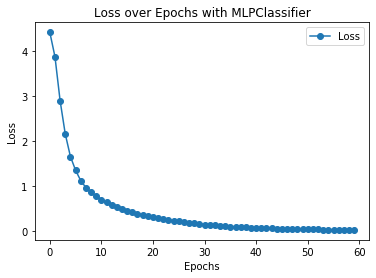

Plot for MLPClassifier(activation='logistic', alpha=0.0001, batch_size=100, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='invscaling',
              learning_rate_init=0.5, max_fun=15000, max_iter=400, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=True, warm_start=False) 


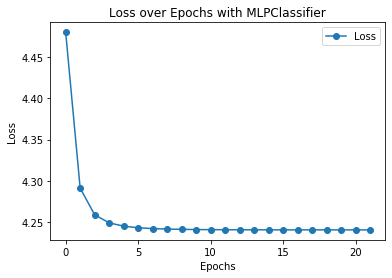

Plot for MLPClassifier(activation='logistic', alpha=0.0001, batch_size=100, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='invscaling',
              learning_rate_init=0.5, max_fun=15000, max_iter=400, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.3333333333333333, random_state=None, shuffle=True,
              solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=True,
              warm_start=False) 


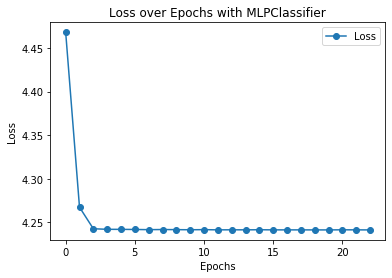

Plot for MLPClassifier(activation='relu', alpha=0.0001, batch_size=100, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='constant',
              learning_rate_init=0.1, max_fun=15000, max_iter=400, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=True, warm_start=False) 


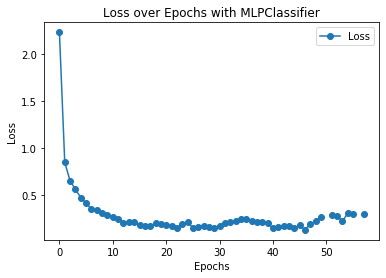

Plot for MLPClassifier(activation='relu', alpha=0.0001, batch_size=100, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='constant',
              learning_rate_init=0.1, max_fun=15000, max_iter=400, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=1e-06,
              validation_fraction=0.1, verbose=True, warm_start=False) 


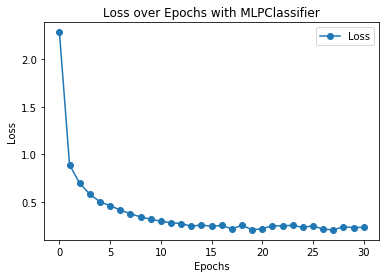

Plot for MLPClassifier(activation='relu', alpha=0.0001, batch_size=100, beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='constant',
              learning_rate_init=0.1, max_fun=15000, max_iter=400, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=1e-06,
              validation_fraction=0.1, verbose=True, warm_start=False) 


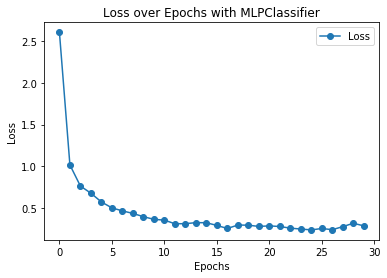

Plot for MLPClassifier(activation='relu', alpha=0.0001, batch_size=100, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='invscaling',
              learning_rate_init=0.5, max_fun=15000, max_iter=400, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=1e-06,
              validation_fraction=0.1, verbose=True, warm_start=False) 


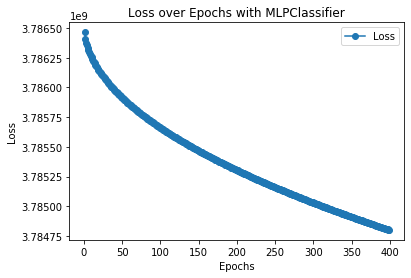

Plot for MLPClassifier(activation='relu', alpha=0.0001, batch_size=100, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='invscaling',
              learning_rate_init=0.5, max_fun=15000, max_iter=400, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.3333333333333333, random_state=None, shuffle=True,
              solver='sgd', tol=1e-06, validation_fraction=0.1, verbose=True,
              warm_start=False) 


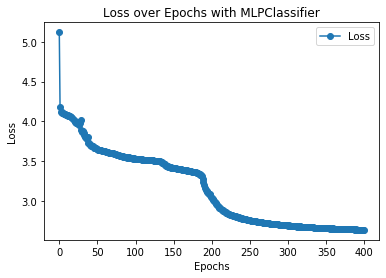

In [43]:
for i in range(len(clf)):
    print("Plot for {} ".format(clf[i]))
    fig = plt.figure(i)
    ax = fig.add_subplot(111)
    ax.plot(clf[i].loss_curve_, marker='o', label='Loss')
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title("Loss over Epochs with MLPClassifier")

    ax.legend()

    #plt.savefig("plots/parte/relu_e-8.png", dpi=1000, bbox_inches='tight')
    plt.show()

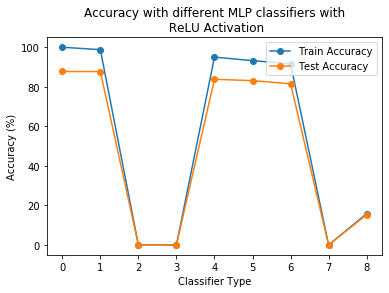

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Accuracy with different MLP classifiers with\n ReLU Activation")
x=np.arange(len(clf))
ax.plot(x, train_accuracy, marker='o', label='Train Accuracy')
ax.plot(x, test_accuracy, marker='o', label='Test Accuracy')
ax.set_xlabel("Classifier Type")
ax.set_ylabel("Accuracy (%)")

plt.legend()
#plt.savefig("plots/parte/accuracy_mlp_relu.png", dpi=1000, bbox_inches='tight')
plt.show()

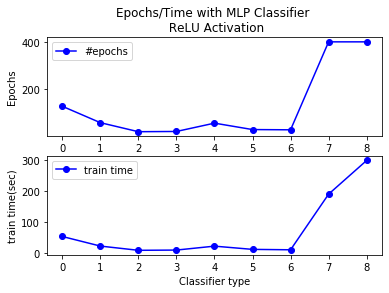

In [42]:
fig = plt.figure()
ax = fig.add_subplot(211)
plt.title("Epochs/Time with MLP Classifier \n ReLU Activation")
ax.plot(x, epochs, c='b', marker='o', label='#epochs')
ax.set_xlabel("Classifier Type")
ax.set_ylabel("Epochs")
ax.legend()

ax1 = fig.add_subplot(212)
ax1.plot(x, train_time, c='b', marker='o', label='train time')
ax1.set_xlabel("Classifier type")
ax1.set_ylabel("train time(sec)")
plt.legend()
#plt.savefig("plots/parte/epochs_time_relu.png", dpi=1000, bbox_inches='tight')
plt.show()